## Bank Churn Prediction - Andre Wills

**Context**

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

**Objective:** 

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

**Data Description**

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

**Data Dictionary**

<ul>
    <li>RowNumber: Row number.</li>
    <li>CustomerId: Unique identification key for different customers.</li>
    <li>Surname: Surname of the customer</li>
    <li>Credit Score: A credit score is a measure of an individual's ability to pay back the borrowed amount. It is the numerical representation of their creditworthiness. A credit score is a 3-digit number that falls in the range of 300-900, 900 being the highest.</li>
    <li>Geography: The country to which the customer belongs.</li>
    <li>Gender: The gender of the customer.</li>
    <li>Age: Age of the customer.</li>
    <li>Tenure: The period of time a customer has been associated with the bank.</li>
    <li>Balance: The account balance (the amount of money deposited in the bank account) of the customer.</li>
    <li>NumOfProducts: How many accounts, bank account affiliated products the person has.</li>
    <li>HasCrCard: Does the customer have a credit card through the bank?</li>
    <li>IsActiveMember: Subjective, but for the concept</li>
    <li>EstimatedSalary: Estimated salary of the customer.</li>
    <li>Exited: Did they leave the bank after all?</li>
</ul>



In [1]:
#importing tensorflow
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA
import seaborn as sns
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#Current version of Keras includes Adam optimizer. Called by optimizer='adam'
#from keras.optimizers import Adam

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn import metrics


### Importing Data

In [3]:
#reading dataset
data = pd.read_csv('bank.csv')

### Data Overview

In [4]:
data.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
data.shape

(10000, 14)

<ul>
    <li> There are 10000 instances for a total of 14 features</li>
    <li> RowNumber & CustomerID can be dropped at a later time. These features are not informative to our predictive model </li>
    <li> No nulls are present </li>
    <li> Exited is our target feature </li>
</ul>

In [7]:
data['Exited'].nunique()

2

Our target variable as the correct number of unique values.

In [8]:
data['Gender'].nunique()

2

Gender has two accepted values, which is expected

In [9]:
data['NumOfProducts'].nunique()

4

In [10]:
data['HasCrCard'].nunique()

2

In [11]:
data['IsActiveMember'].nunique()

2

The variables that are intended to be binary have the correct number of unique values.

In [12]:
(data.Exited.value_counts())/(data.Exited.count())

0    0.7963
1    0.2037
Name: Exited, dtype: float64

There is a data imbalance with regards to our target variable. Of a total 10000 records, we have a split of 79% non-exited customers and a total of 21% of customers who have exited.

### Data Exploration

In [13]:
data.describe().T

count          mean           std          min  \
RowNumber        10000.0  5.000500e+03   2886.895680         1.00   
CustomerId       10000.0  1.569094e+07  71936.186123  15565701.00   
CreditScore      10000.0  6.505288e+02     96.653299       350.00   
Age              10000.0  3.892180e+01     10.487806        18.00   
Tenure           10000.0  5.012800e+00      2.892174         0.00   
Balance          10000.0  7.648589e+04  62397.405202         0.00   
NumOfProducts    10000.0  1.530200e+00      0.581654         1.00   
HasCrCard        10000.0  7.055000e-01      0.455840         0.00   
IsActiveMember   10000.0  5.151000e-01      0.499797         0.00   
EstimatedSalary  10000.0  1.000902e+05  57510.492818        11.58   
Exited           10000.0  2.037000e-01      0.402769         0.00   

                         25%           50%           75%          max  
RowNumber            2500.75  5.000500e+03  7.500250e+03     10000.00  
CustomerId       15628528.25  1.569074e+07  1.575323e+07  15815690.00  
CreditScore           584.00  6.520000e+02  7.180000e+02       850.00  
Age                    32.00  3.700000e+01  4.400000e+01        92.00  
Tenure                  3.00  5.000000e+00  7.000000e+00        10.00  
Balance                 0.00  9.719854e+04  1.276442e+05    250898.09  
NumOfProducts           1.00  1.000000e+00  2.000000e+00         4.00  
HasCrCard               0.00  1.000000e+00  1.000000e+00         1.00  
IsActiveMember          0.00  1.000000e+00  1.000000e+00         1.00  
EstimatedSalary     51002.11  1.001939e+05  1.493882e+05    199992.48  
Exited                  0.00  0.000000e+00  0.000000e+00         1.00

**Observations**

- NumOfProducts,  Tenure, CreditScore, Age, Balance are all values with ranges that will need to be scaled as to properly inform the model
- The Boolean values are all within then 0-1 range
- EstimatedSalary has the largest range of values
- Exited is imbalanced. The data skews heavily in favor of customers who have not exited.

In [14]:
data.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [15]:
data.tail()

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
9995       5       0.00              2          1               0   
9996      10   57369.61              1          1               1   
9997       7       0.00              1          0               1   
9998       3   75075.31              2          1               0   
9999       4  130142.79              1          1               0   

      EstimatedSalary  Exited  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0

In [16]:
data.shape

(10000, 14)

In [17]:
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [18]:
data.isnull().values.any()

False

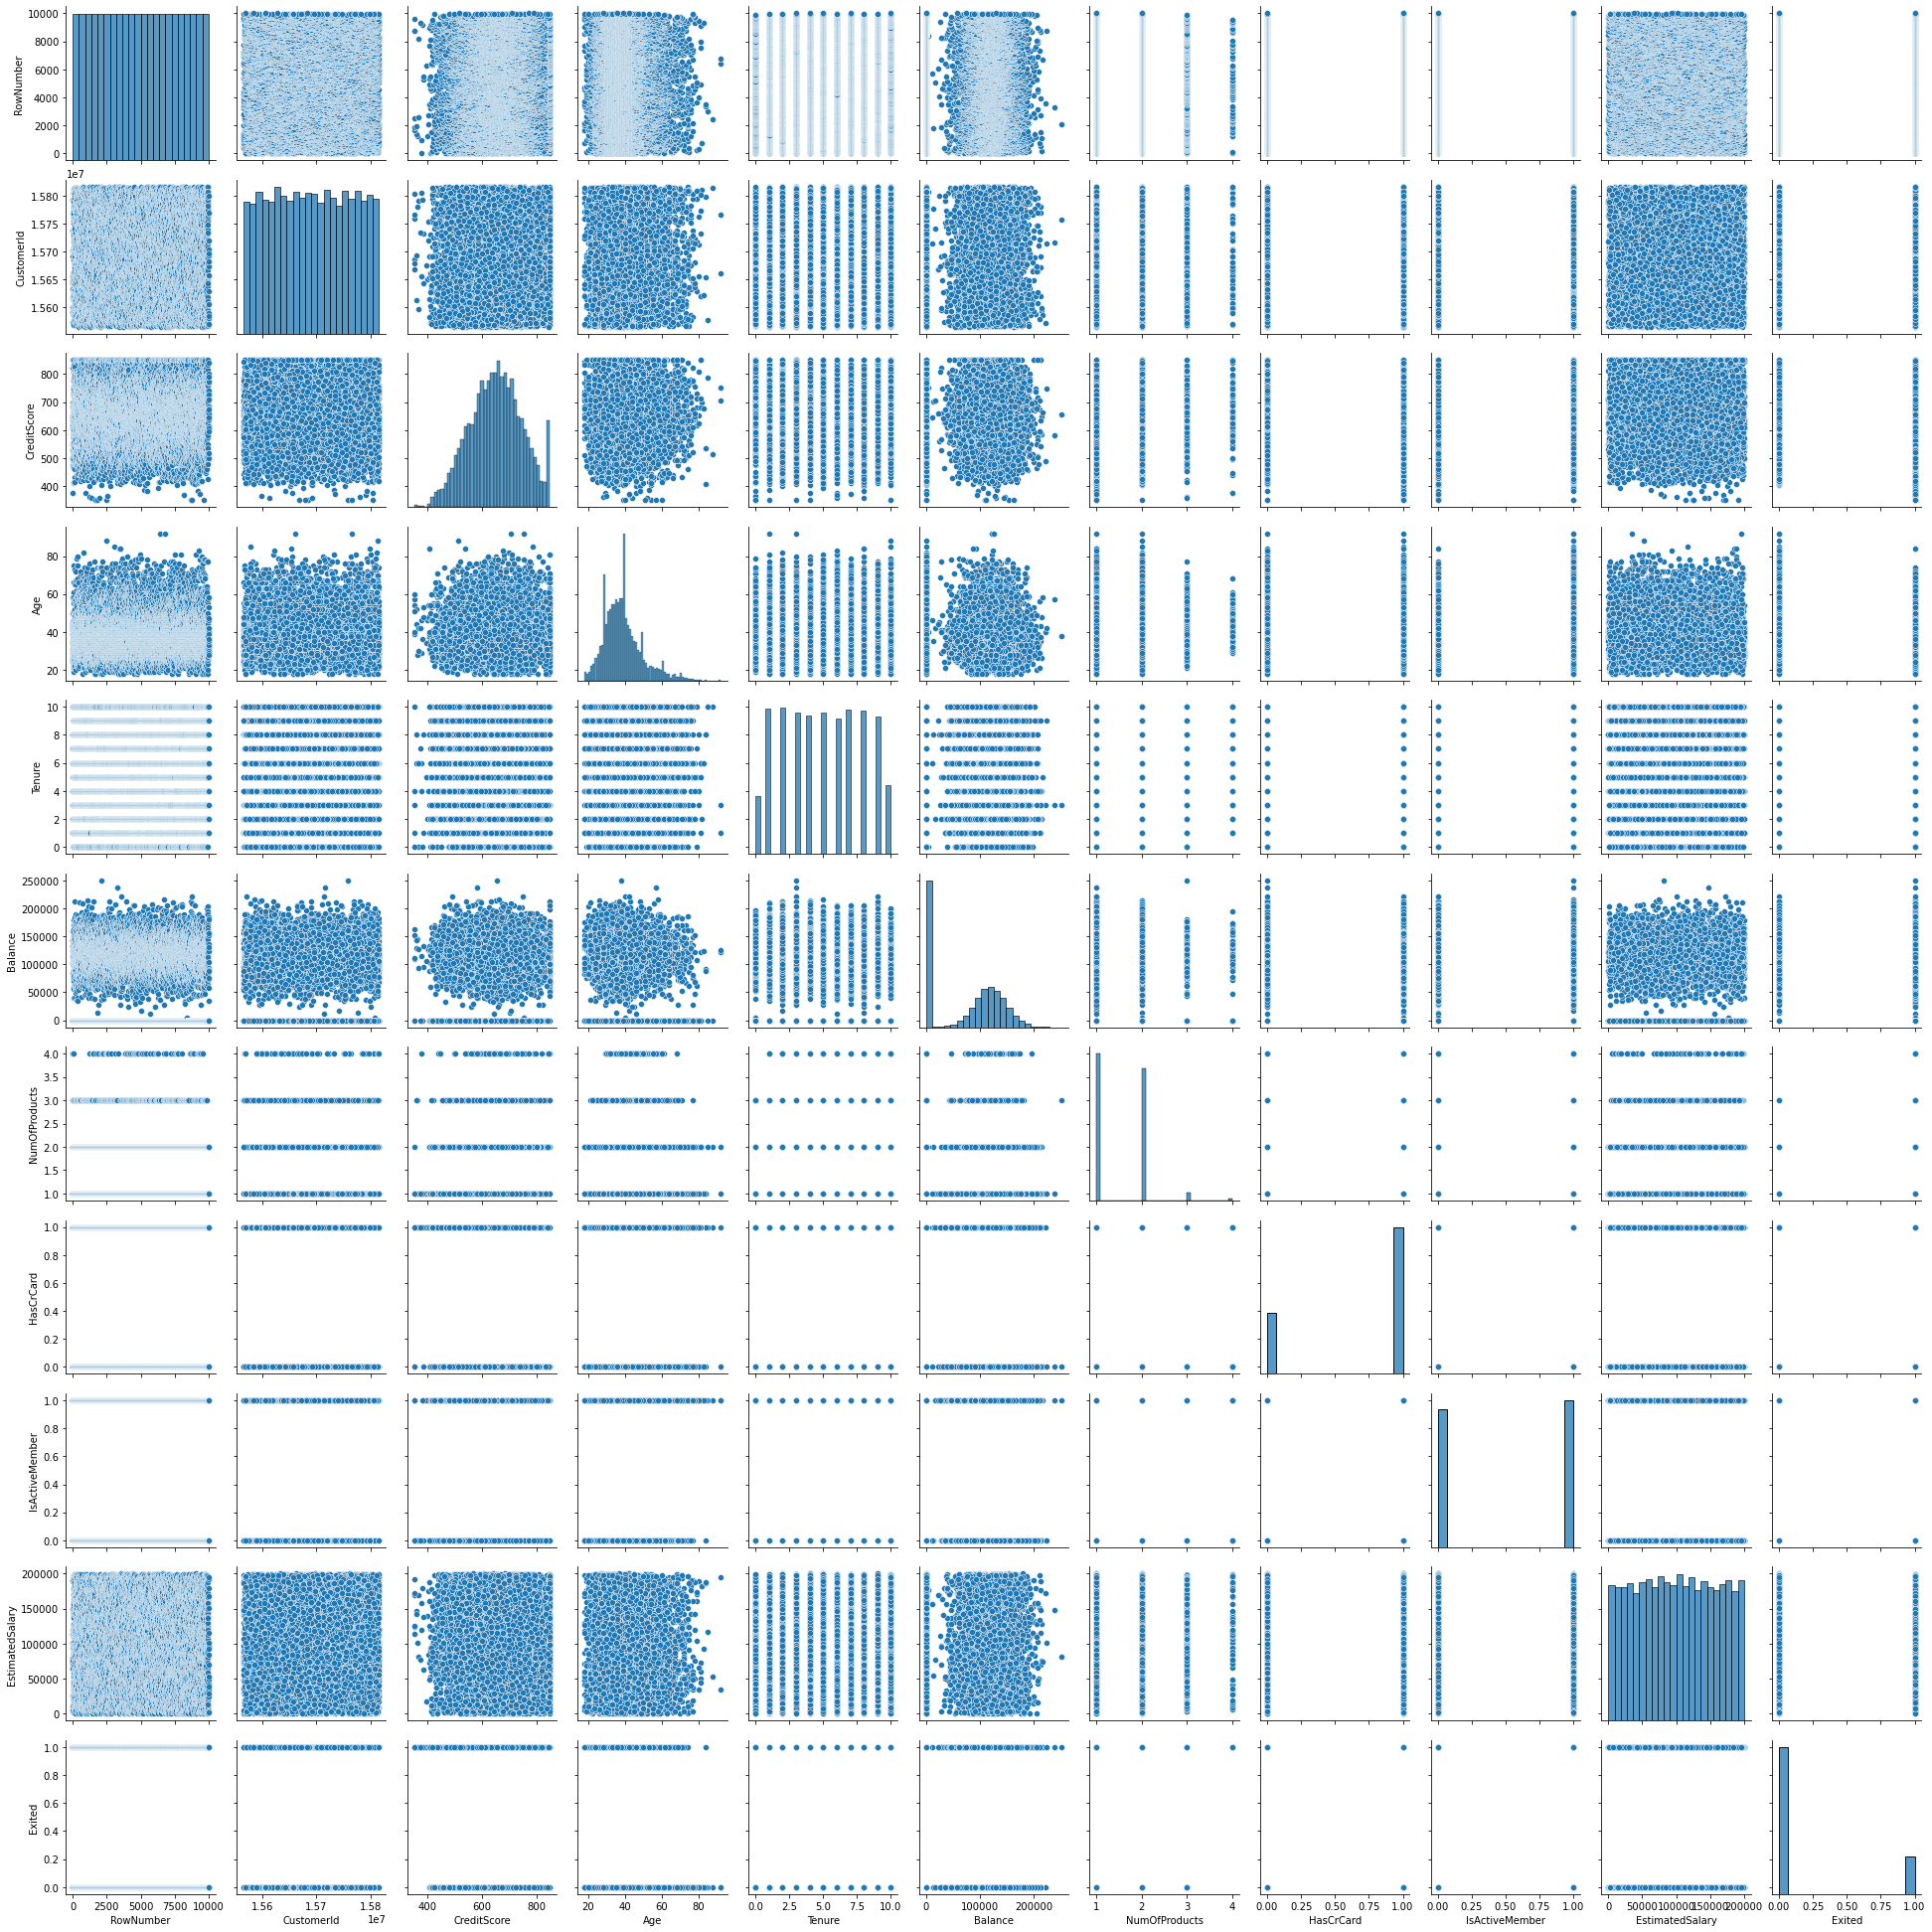

In [19]:
sns.pairplot(data=data.select_dtypes(exclude=['object']))

**Observations**

- There are no immediately obvious distribution issues
- Age has a long right tail indicacting the presence of one or more extreme outliers
- CreditScore is fairly normally distributed with the concentration of a large number forming a statistical outlier on the higher end of values
- Exited is imbalanced
- Balance has a outlier in at value 0. The distribution is heavily skewed.

In [20]:
# Boxplot function for EDA
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,color = 'orange') if bins else sns.distplot(feature, kde=False, ax=ax_hist2,color='tab:cyan') # For histogram
    ax_hist2.axvline(np.mean(feature), color='purple', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

    
# Function to create barplots that indicate percentage for each category.
def perc_on_bar(plot, feature):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    """
    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=12)  # annotate the percantage
    plt.show()  # show the plot

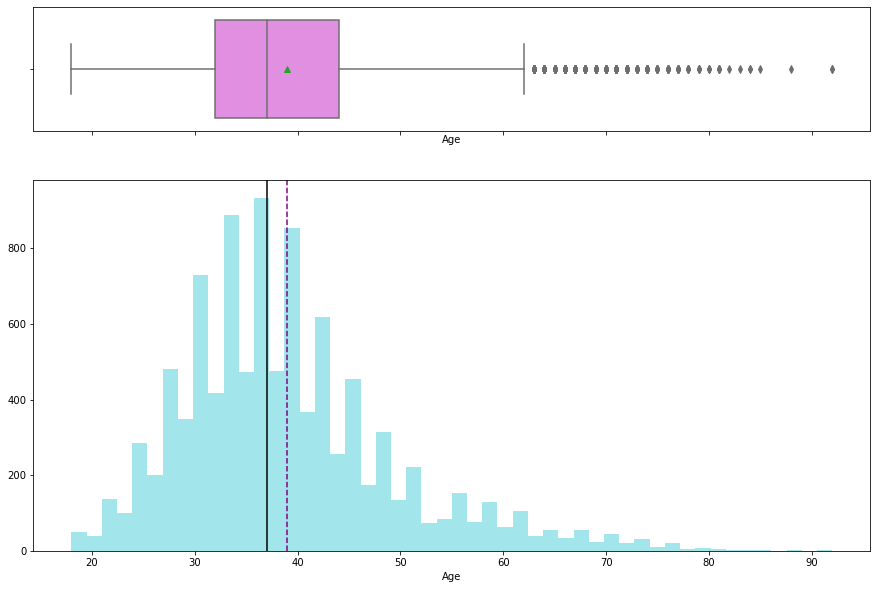

In [21]:
histogram_boxplot(data['Age'])

- The majority of the distribution of Age is concentrated in the 30-45 range
- There are some extreme outliers between 80-95

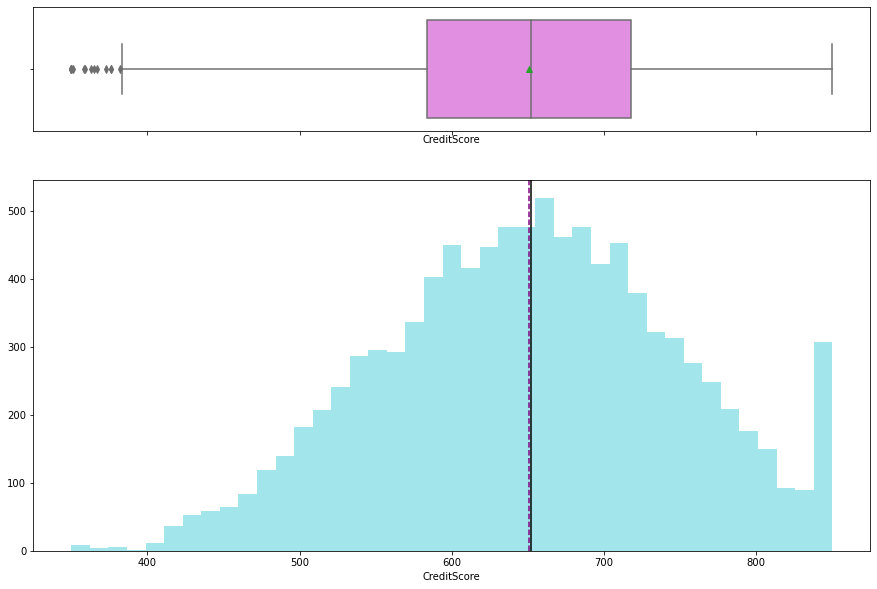

In [22]:
histogram_boxplot(data['CreditScore'])

- As observed in the pairplot. CreditScore is fairly normally distributed around the 650 mark, with outliers being present in the 900~ range
- There are some outliers in the low range as well, falling between 350 & 450.

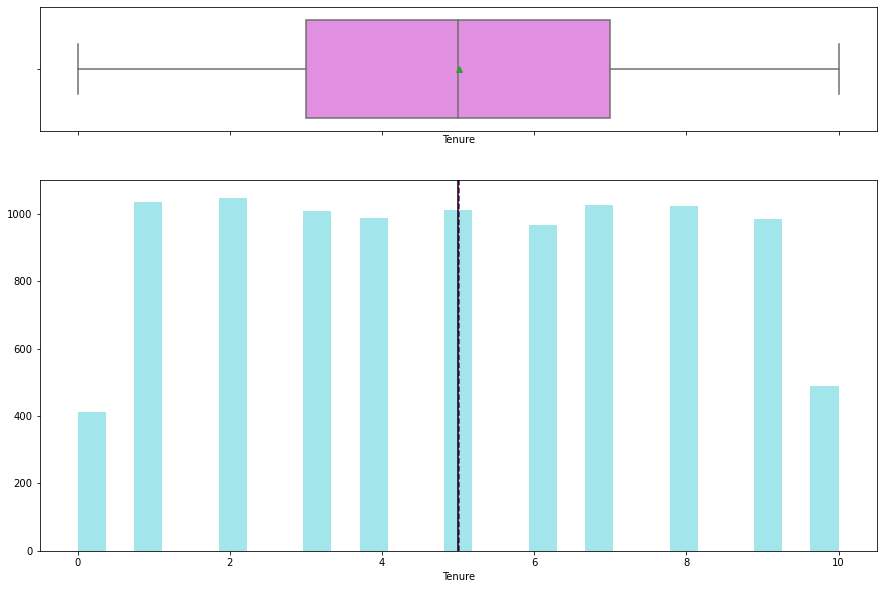

In [23]:
histogram_boxplot(data['Tenure'])

- The time spent at the Bank is well represented, no numbers fall below 0, indicating a sound data set.
- There are no outliers present

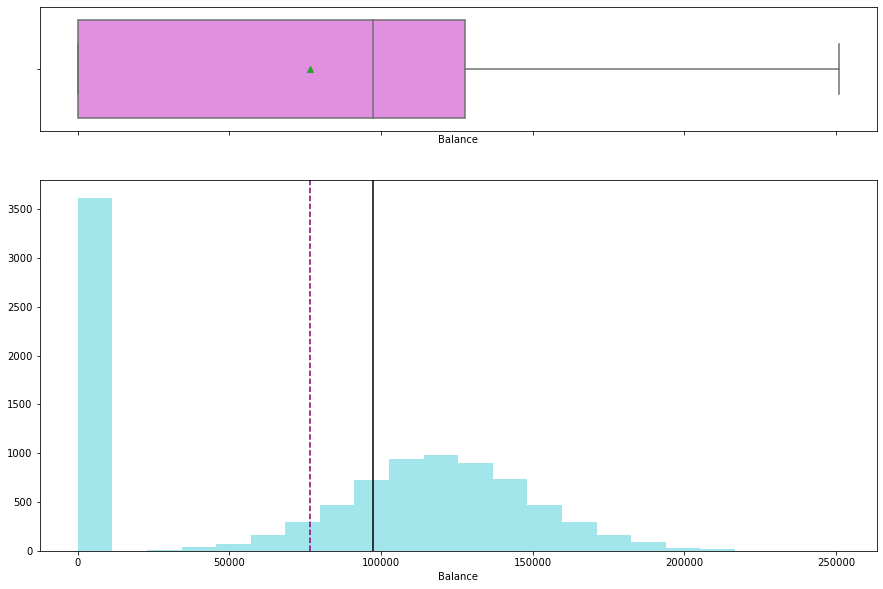

In [24]:
histogram_boxplot(data['Balance'])

- There is a heavily unbalanced distribution of 0 Balance customers. Further investigation is required
- There are outliers present on both ends of the distribution, with 0 being a significant outlier
- We could potentially drop Balance, we will see how it correlates with the rest of the dataset

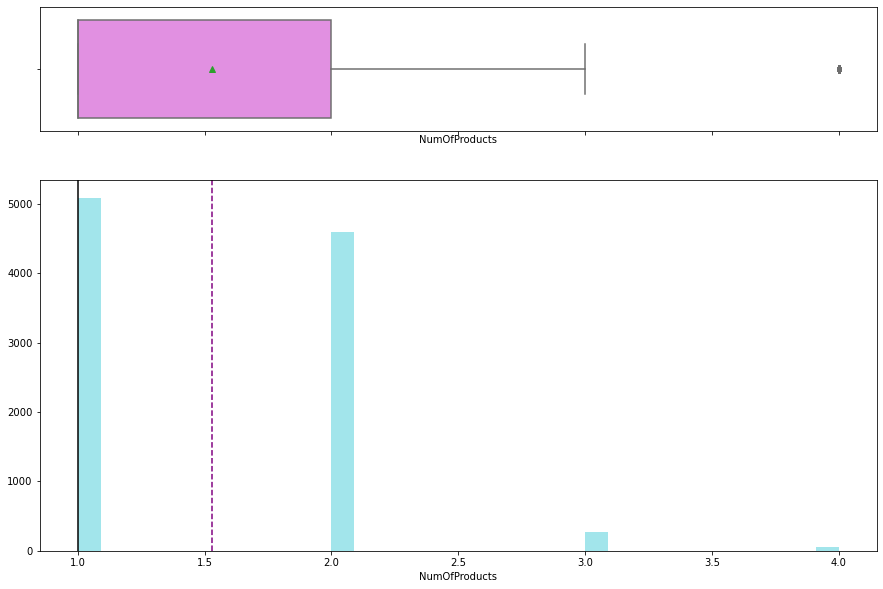

In [25]:
histogram_boxplot(data['NumOfProducts'])

- The majority of customers have 1-2 Products with the bank
- A max of 4 products is present, in a small volume
- I do not consider this a significant outlier, as such no action is required

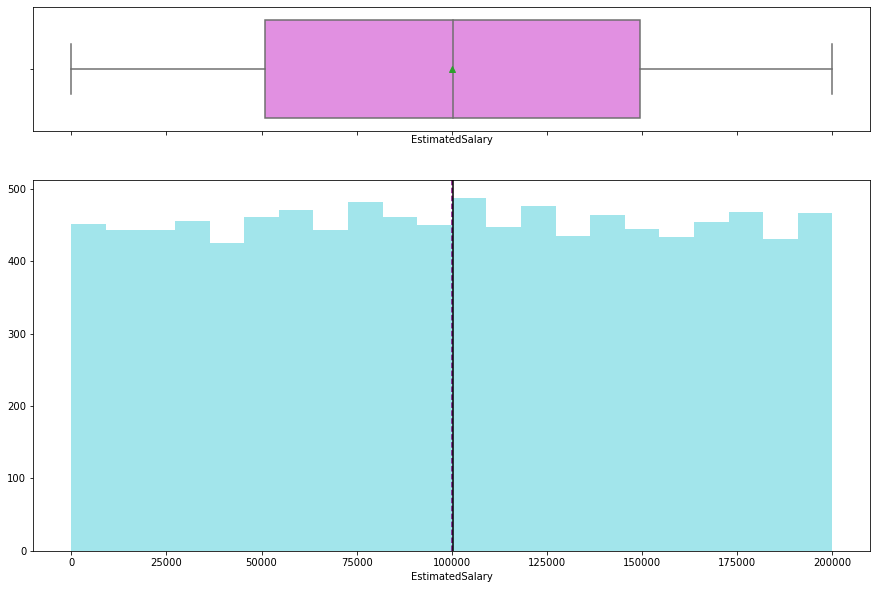

In [26]:
histogram_boxplot(data['EstimatedSalary'])

- As mentioned before, the range of EstimatedSalary will upset the models. This data will be scaled and regularized.

<AxesSubplot:>

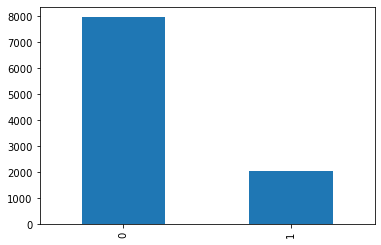

In [27]:
data.Exited.value_counts().plot.bar()

- as noted before, the distribution of the target variable is imbalanced.
- we will need to adjust the models accordingly

<AxesSubplot:>

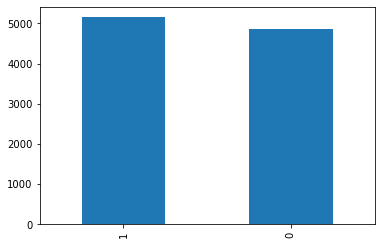

In [28]:
data.IsActiveMember.value_counts().plot.bar()

- the distribution of this feature is almost perfectly distributed across the possible values 0-1. This lowers the correlation with our target variable
- this feature will not perform well as a predictor if left as is

<AxesSubplot:>

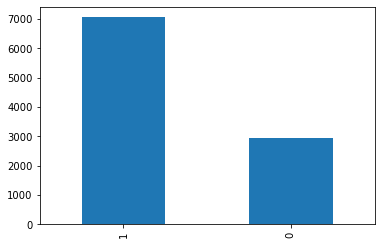

In [29]:
data.HasCrCard.value_counts().plot.bar()

<AxesSubplot:>

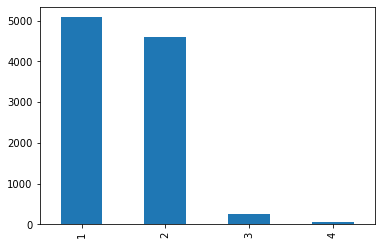

In [30]:
data.NumOfProducts.value_counts().plot.bar()

- the data skews heavily towards 1 & 2. 3 & 4 can be considered outliers

<AxesSubplot:>

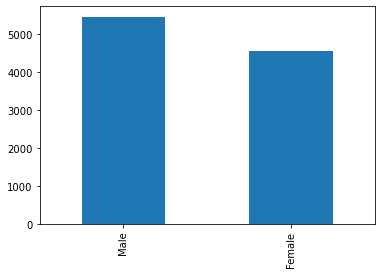

In [31]:
data.Gender.value_counts().plot.bar()

- gender is well represented by the dataset

<AxesSubplot:>

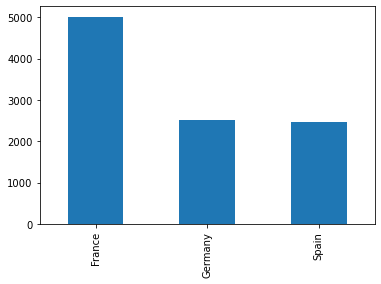

In [32]:
data.Geography.value_counts().plot.bar()

- France over represents the customer base slightly, however this is not too extreme and will not need to be dealt with

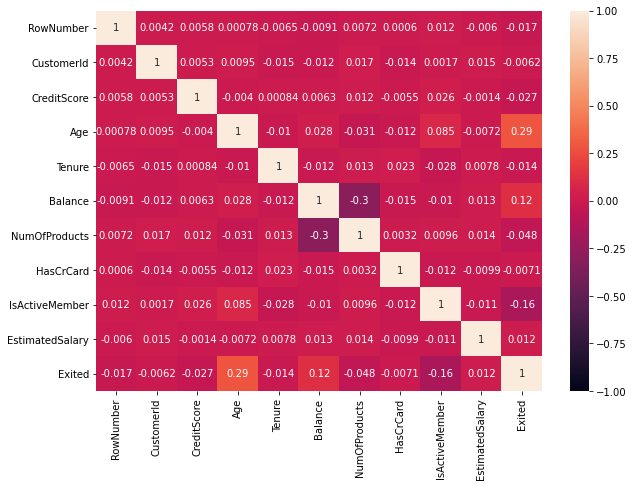

In [33]:
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(),annot=True,vmin=-1,vmax=1,fmt='.2g')
plt.show()

**Observations**
- Exited as a strong positive relationship with Age (0.29)
- Balance also appears to have a strong positive relationship with Age. I assume this is the large volume of Exited = 1 and Balance = 0 records.
- Balance & NumOfProducts is strongly negatively correlated
- Interestingly, "IsActiveMember" does not have a strong correlation with Exited. This is interesting as you would expect that customers who Exited are considered to be "Not Active". We will investigate the relationship further.

### Investigating Balance Distribution

In [34]:
data.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [35]:
df_bal = data.loc[data['Balance'] == 0]

In [36]:
df_bal.describe()

RowNumber    CustomerId  CreditScore          Age       Tenure  \
count  3617.000000  3.617000e+03  3617.000000  3617.000000  3617.000000   
mean   5032.100083  1.569195e+07   649.452861    38.434891     5.071330   
std    2875.309344  7.194749e+04    96.158798    10.492002     2.860781   
min       1.000000  1.556571e+07   350.000000    18.000000     0.000000   
25%    2561.000000  1.562952e+07   583.000000    31.000000     3.000000   
50%    5067.000000  1.569335e+07   651.000000    37.000000     5.000000   
75%    7528.000000  1.575355e+07   717.000000    43.000000     7.000000   
max    9998.000000  1.581536e+07   850.000000    88.000000    10.000000   

       Balance  NumOfProducts    HasCrCard  IsActiveMember  EstimatedSalary  \
count   3617.0    3617.000000  3617.000000     3617.000000      3617.000000   
mean       0.0       1.784628     0.716616        0.517832     98983.559549   
std        0.0       0.496455     0.450704        0.499751     57730.828955   
min        0.0       1.000000     0.000000        0.000000        90.070000   
25%        0.0       1.000000     0.000000        0.000000     49506.820000   
50%        0.0       2.000000     1.000000        1.000000     98618.790000   
75%        0.0       2.000000     1.000000        1.000000    148330.970000   
max        0.0       4.000000     1.000000        1.000000    199992.480000   

            Exited  
count  3617.000000  
mean      0.138236  
std       0.345195  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [37]:
df_bal.Exited.value_counts()

0    3117
1     500
Name: Exited, dtype: int64

**Conclusion**

We will keep Balance as a feature, as the distribution of Balance = 0 as related to Exited = 0 is not significally correlated.

### IsActiveMember vs Exited

In [38]:
pd.crosstab(data['Exited'],data['IsActiveMember'])

IsActiveMember     0     1
Exited                    
0               3547  4416
1               1302   735

- There are a significant number of customers who are still considered Active Members although they have Exited the bank. Considering a customer can be inactive before Exiting, we will not be dropping the feature, rather we will replace the IsActiveMember values that are 1 with 0 where the customer has Exited.

- The distributino of IsActiveMember when Exited = 1, is skewing the importance of whether the Member is actually active or not. If left unchanged, the model will not adequately build around the proper weighting of these figures in accordance with the outcome of predicting a user who Exited.

- "IsActiveMember" as a feature describes a customers recent interaction with the bank. If that customer has Exited, they can no longer be considered as active. This feature is not intended to be a "Status of Customer at Time of Exit". Moving forward, the bank should add an aditional data point that tracks the status of the Customer when they Exit and update the IsActiveMember.

- Due to this, I have made the decision to change the data. I did so because of the above mentioned reasons. I also observed that the models performed significantly better after the change.

//Note for marker. If I am marked down for this decision, I expect a thorough explanation of why

### Data Preparation

In [39]:
df = data.copy()

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [41]:
df.drop(columns=["RowNumber"], inplace=True)
df.drop(columns=["CustomerId"], inplace=True)

#Dropping Surname as it's customer identification information and won't inform our 
#model of anything neccesary for predicting the target variable
df.drop(columns=["Surname"], inplace=True)

In [42]:
#Change IsActiveMember to 0 where Exited = 1
df.loc[df['Exited'] == 1, "IsActiveMember"] = 0

In [43]:
pd.crosstab(df['Exited'],df['IsActiveMember'])

IsActiveMember     0     1
Exited                    
0               3547  4416
1               2037     0

In [44]:
# convert the numeric values to one-hot code to remove the order

df = pd.get_dummies(df, columns=['Gender'])
df = pd.get_dummies(df, columns=['Geography'])



In [45]:
df.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2       0.00              1          1   
1          608   41       1   83807.86              1          0   
2          502   42       8  159660.80              3          1   
3          699   39       1       0.00              2          0   
4          850   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Gender_Female  Gender_Male  \
0               0        101348.88       1              1            0   
1               1        112542.58       0              1            0   
2               0        113931.57       1              1            0   
3               0         93826.63       0              1            0   
4               1         79084.10       0              1            0   

   Geography_France  Geography_Germany  Geography_Spain  
0                 1                  0                0  
1                 0                  0                1  
2                 1                  0                0  
3                 1                  0                0  
4                 0                  0                1

In [46]:
df.describe()

CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

         HasCrCard  IsActiveMember  EstimatedSalary        Exited  \
count  10000.00000    10000.000000     10000.000000  10000.000000   
mean       0.70550        0.441600    100090.239881      0.203700   
std        0.45584        0.496603     57510.492818      0.402769   
min        0.00000        0.000000        11.580000      0.000000   
25%        0.00000        0.000000     51002.110000      0.000000   
50%        1.00000        0.000000    100193.915000      0.000000   
75%        1.00000        1.000000    149388.247500      0.000000   
max        1.00000        1.000000    199992.480000      1.000000   

       Gender_Female   Gender_Male  Geography_France  Geography_Germany  \
count   10000.000000  10000.000000      10000.000000       10000.000000   
mean        0.454300      0.545700          0.501400           0.250900   
std         0.497932      0.497932          0.500023           0.433553   
min         0.000000      0.000000          0.000000           0.000000   
25%         0.000000      0.000000          0.000000           0.000000   
50%         0.000000      1.000000          1.000000           0.000000   
75%         1.000000      1.000000          1.000000           1.000000   
max         1.000000      1.000000          1.000000           1.000000   

       Geography_Spain  
count     10000.000000  
mean          0.247700  
std           0.431698  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           0.000000  
max           1.000000

In [47]:
X_data = df.drop(columns=["Exited"])
y_data = df.Exited

#Standardizing the features
from sklearn.preprocessing import StandardScaler
X_data['normalizedEstimatedSalary'] = StandardScaler().fit_transform(X_data['EstimatedSalary'].values.reshape(-1,1))  # Normalize 'Amount' in [-1,+1] range
X_data= X_data.drop(['EstimatedSalary'],axis=1)

X_data['normalizedBalance'] = StandardScaler().fit_transform(X_data['Balance'].values.reshape(-1,1))  # Normalize 'Amount' in [-1,+1] range
X_data= X_data.drop(['Balance'],axis=1)

X_data['normalizedAge'] = StandardScaler().fit_transform(X_data['Age'].values.reshape(-1,1))  # Normalize 'Amount' in [-1,+1] range
X_data= X_data.drop(['Age'],axis=1)

X_data['normalizedCreditScore'] = StandardScaler().fit_transform(X_data['CreditScore'].values.reshape(-1,1))  # Normalize 'Amount' in [-1,+1] range
X_data= X_data.drop(['CreditScore'],axis=1)

X_data['normalizedTenure'] = StandardScaler().fit_transform(X_data['Tenure'].values.reshape(-1,1))  # Normalize 'Amount' in [-1,+1] range
X_data= X_data.drop(['Tenure'],axis=1)

X_data['normalizedNumberOfProd'] = StandardScaler().fit_transform(X_data['NumOfProducts'].values.reshape(-1,1))  # Normalize 'Amount' in [-1,+1] range
X_data= X_data.drop(['NumOfProducts'],axis=1)

In [48]:
print(y_data.shape)
print(X_data.shape)

X_data = X_data.astype('float32')
y_data = y_data.astype('float32')

(10000,)
(10000, 13)


In [49]:
X_data

HasCrCard  IsActiveMember  Gender_Female  Gender_Male  Geography_France  \
0           1.0             0.0            1.0          0.0               1.0   
1           0.0             1.0            1.0          0.0               0.0   
2           1.0             0.0            1.0          0.0               1.0   
3           0.0             0.0            1.0          0.0               1.0   
4           1.0             1.0            1.0          0.0               0.0   
...         ...             ...            ...          ...               ...   
9995        1.0             0.0            0.0          1.0               1.0   
9996        1.0             1.0            0.0          1.0               1.0   
9997        0.0             0.0            1.0          0.0               1.0   
9998        1.0             0.0            0.0          1.0               0.0   
9999        1.0             0.0            1.0          0.0               1.0   

      Geography_Germany  Geography_Spain  normalizedEstimatedSalary  \
0                   0.0              0.0                   0.021886   
1                   0.0              1.0                   0.216534   
2                   0.0              0.0                   0.240687   
3                   0.0              0.0                  -0.108918   
4                   0.0              1.0                  -0.365276   
...                 ...              ...                        ...   
9995                0.0              0.0                  -0.066419   
9996                0.0              0.0                   0.027988   
9997                0.0              0.0                  -1.008643   
9998                1.0              0.0                  -0.125231   
9999                0.0              0.0                  -1.076370   

      normalizedBalance  normalizedAge  normalizedCreditScore  \
0             -1.225848       0.293517              -0.326221   
1              0.117350       0.198164              -0.440036   
2              1.333053       0.293517              -1.536794   
3             -1.225848       0.007457               0.501521   
4              0.785728       0.388871               2.063884   
...                 ...            ...                    ...   
9995          -1.225848       0.007457               1.246488   
9996          -0.306379      -0.373958              -1.391939   
9997          -1.225848      -0.278604               0.604988   
9998          -0.022608       0.293517               1.256835   
9999           0.859965      -1.041433               1.463771   

      normalizedTenure  normalizedNumberOfProd  
0            -1.041760               -0.911583  
1            -1.387538               -0.911583  
2             1.032908                2.527057  
3            -1.387538                0.807737  
4            -1.041760               -0.911583  
...                ...                     ...  
9995         -0.004426                0.807737  
9996          1.724464               -0.911583  
9997          0.687130               -0.911583  
9998         -0.695982                0.807737  
9999         -0.350204               -0.911583  

[10000 rows x 13 columns]

### Splitting data

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 7)

In [51]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 13)
(2000, 13)
(8000,)
(2000,)


### Model Building

The goal of the models we build will be to predict the target variable - Exited.

**We want to maximise the True Positives, reduce the False Positives will ensuring a high Accuracy & Recall score.**

This ensures that the Bank will accurately predict customers who might leave, while keeping the cost of being wrong low. We wish to minimize the expenses that could potentially be incurred by having a model that too aggressively predicts customers will leave, while not doing too little in predicting these customers.

As such, we will focus on Accuracy & Recall, with attention on FP and TP.

#### Random Forest

We will use a base Random Forest model as a comparison to determine whether the ANN is performing well.

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
random_forest = RandomForestClassifier(n_estimators=100)

In [54]:
# Pandas Series.ravel() function returns the flattened underlying data as an ndarray.
random_forest.fit(X_train,y_train.values.ravel())    # np.ravel() Return a contiguous flattened array

RandomForestClassifier()

In [55]:
y_pred = random_forest.predict(X_test)

In [56]:
random_forest.score(X_test,y_test)

0.8855

In [57]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

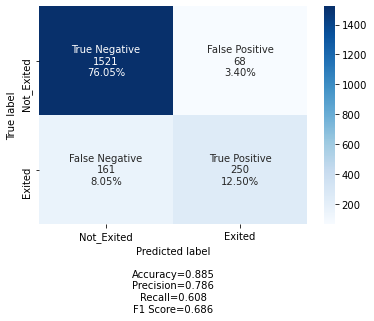

In [58]:
cm1=confusion_matrix(y_test, y_pred)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Performance Review**

The Random Forest model peforms well in predicting the Exited customers. We will use this as a base comparison model as we attempt to improve on the Accuracy & Recall metrics by building more complex ANN models.

The Recall of the Random Forest is relatively low. We will be targeting this performance metric as we move forward.

### Deep neural network

In [59]:
#initialize the model
model = Sequential()

In [60]:
model.add(Dense(units=20, input_dim = 13,activation='relu'))   # input of 13 columns as shown above
# hidden layer
model.add(Dense(units=20,activation='relu'))
#Adding Dropout to prevent overfitting 
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
# binary classification Exited or not

In [61]:
#model optimization using Keras - Adam
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [62]:
#Printing model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                280       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 6,269
Trainable params: 6,269
Non-trainable params: 0
______________________________________________________

#### Training [Forward pass and Backpropagation]

In [63]:
#fitting the model
nn=model.fit(X_train,y_train,batch_size=500,epochs=500,validation_split=0.2)

Epoch 1/500
13/13 [==============================] - 10s 28ms/step - loss: 0.6737 - accuracy: 0.5737 - val_loss: 0.5651 - val_accuracy: 0.7894
Epoch 2/500
13/13 [==============================] - 0s 2ms/step - loss: 0.5340 - accuracy: 0.7969 - val_loss: 0.4973 - val_accuracy: 0.7894
Epoch 3/500
13/13 [==============================] - 0s 2ms/step - loss: 0.4800 - accuracy: 0.8027 - val_loss: 0.4752 - val_accuracy: 0.7894
Epoch 4/500
13/13 [==============================] - 0s 2ms/step - loss: 0.4624 - accuracy: 0.7993 - val_loss: 0.4589 - val_accuracy: 0.7894
Epoch 5/500
13/13 [==============================] - 0s 2ms/step - loss: 0.4430 - accuracy: 0.7972 - val_loss: 0.4375 - val_accuracy: 0.7894
Epoch 6/500
13/13 [==============================] - 0s 2ms/step - loss: 0.4165 - accuracy: 0.8002 - val_loss: 0.4177 - val_accuracy: 0.7894
Epoch 7/500
13/13 [==============================] - 0s 2ms/step - loss: 0.4052 - accuracy: 0.7954 - val_loss: 0.3991 - val_accuracy: 0.7894
Epoch 8/500

Epoch 59/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2220 - accuracy: 0.8998 - val_loss: 0.2496 - val_accuracy: 0.8800
Epoch 60/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2112 - accuracy: 0.9085 - val_loss: 0.2474 - val_accuracy: 0.8850
Epoch 61/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2277 - accuracy: 0.9013 - val_loss: 0.2475 - val_accuracy: 0.8800
Epoch 62/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2252 - accuracy: 0.9012 - val_loss: 0.2474 - val_accuracy: 0.8813
Epoch 63/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2253 - accuracy: 0.9028 - val_loss: 0.2474 - val_accuracy: 0.8825
Epoch 64/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2237 - accuracy: 0.9009 - val_loss: 0.2481 - val_accuracy: 0.8800
Epoch 65/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2254 - accuracy: 0.9019 - val_loss: 0.2477 - val_accuracy: 0.8813
Epoch 

13/13 [==============================] - 0s 2ms/step - loss: 0.2106 - accuracy: 0.9051 - val_loss: 0.2509 - val_accuracy: 0.8813
Epoch 117/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2064 - accuracy: 0.9092 - val_loss: 0.2505 - val_accuracy: 0.8813
Epoch 118/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2101 - accuracy: 0.9085 - val_loss: 0.2536 - val_accuracy: 0.8813
Epoch 119/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2125 - accuracy: 0.9069 - val_loss: 0.2481 - val_accuracy: 0.8844
Epoch 120/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2093 - accuracy: 0.9065 - val_loss: 0.2513 - val_accuracy: 0.8800
Epoch 121/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2092 - accuracy: 0.9132 - val_loss: 0.2483 - val_accuracy: 0.8825
Epoch 122/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2085 - accuracy: 0.9055 - val_loss: 0.2480 - val_accuracy: 0.8831
Epoch 123/500

13/13 [==============================] - 0s 2ms/step - loss: 0.1997 - accuracy: 0.9144 - val_loss: 0.2485 - val_accuracy: 0.8831
Epoch 174/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2034 - accuracy: 0.9140 - val_loss: 0.2518 - val_accuracy: 0.8819
Epoch 175/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2063 - accuracy: 0.9112 - val_loss: 0.2477 - val_accuracy: 0.8838
Epoch 176/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2100 - accuracy: 0.9073 - val_loss: 0.2483 - val_accuracy: 0.8856
Epoch 177/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2011 - accuracy: 0.9127 - val_loss: 0.2542 - val_accuracy: 0.8838
Epoch 178/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1979 - accuracy: 0.9115 - val_loss: 0.2515 - val_accuracy: 0.8794
Epoch 179/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2046 - accuracy: 0.9134 - val_loss: 0.2537 - val_accuracy: 0.8806
Epoch 180/500

13/13 [==============================] - 0s 2ms/step - loss: 0.1886 - accuracy: 0.9155 - val_loss: 0.2590 - val_accuracy: 0.8775
Epoch 231/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1922 - accuracy: 0.9149 - val_loss: 0.2563 - val_accuracy: 0.8819
Epoch 232/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1967 - accuracy: 0.9093 - val_loss: 0.2588 - val_accuracy: 0.8813
Epoch 233/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1947 - accuracy: 0.9156 - val_loss: 0.2624 - val_accuracy: 0.8788
Epoch 234/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2021 - accuracy: 0.9104 - val_loss: 0.2612 - val_accuracy: 0.8800
Epoch 235/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1983 - accuracy: 0.9128 - val_loss: 0.2598 - val_accuracy: 0.8819
Epoch 236/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1987 - accuracy: 0.9123 - val_loss: 0.2544 - val_accuracy: 0.8813
Epoch 237/500

13/13 [==============================] - 0s 2ms/step - loss: 0.2024 - accuracy: 0.9134 - val_loss: 0.2662 - val_accuracy: 0.8819
Epoch 288/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1867 - accuracy: 0.9164 - val_loss: 0.2702 - val_accuracy: 0.8806
Epoch 289/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1924 - accuracy: 0.9144 - val_loss: 0.2699 - val_accuracy: 0.8819
Epoch 290/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1892 - accuracy: 0.9180 - val_loss: 0.2695 - val_accuracy: 0.8819
Epoch 291/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1913 - accuracy: 0.9112 - val_loss: 0.2667 - val_accuracy: 0.8825
Epoch 292/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1919 - accuracy: 0.9129 - val_loss: 0.2703 - val_accuracy: 0.8869
Epoch 293/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1843 - accuracy: 0.9195 - val_loss: 0.2714 - val_accuracy: 0.8788
Epoch 294/500

13/13 [==============================] - 0s 2ms/step - loss: 0.1890 - accuracy: 0.9178 - val_loss: 0.2780 - val_accuracy: 0.8838
Epoch 345/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1859 - accuracy: 0.9213 - val_loss: 0.2761 - val_accuracy: 0.8800
Epoch 346/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1790 - accuracy: 0.9241 - val_loss: 0.2800 - val_accuracy: 0.8844
Epoch 347/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1867 - accuracy: 0.9179 - val_loss: 0.2786 - val_accuracy: 0.8838
Epoch 348/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1902 - accuracy: 0.9147 - val_loss: 0.2768 - val_accuracy: 0.8813
Epoch 349/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1834 - accuracy: 0.9173 - val_loss: 0.2768 - val_accuracy: 0.8813
Epoch 350/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1807 - accuracy: 0.9215 - val_loss: 0.2765 - val_accuracy: 0.8831
Epoch 351/500

13/13 [==============================] - 0s 2ms/step - loss: 0.1928 - accuracy: 0.9112 - val_loss: 0.2897 - val_accuracy: 0.8825
Epoch 402/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1898 - accuracy: 0.9162 - val_loss: 0.2879 - val_accuracy: 0.8838
Epoch 403/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1788 - accuracy: 0.9195 - val_loss: 0.2859 - val_accuracy: 0.8806
Epoch 404/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1880 - accuracy: 0.9148 - val_loss: 0.2891 - val_accuracy: 0.8819
Epoch 405/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.9177 - val_loss: 0.2880 - val_accuracy: 0.8819
Epoch 406/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1803 - accuracy: 0.9189 - val_loss: 0.2886 - val_accuracy: 0.8813
Epoch 407/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1775 - accuracy: 0.9198 - val_loss: 0.2870 - val_accuracy: 0.8831
Epoch 408/500

13/13 [==============================] - 0s 2ms/step - loss: 0.1775 - accuracy: 0.9201 - val_loss: 0.3035 - val_accuracy: 0.8775
Epoch 459/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9164 - val_loss: 0.3023 - val_accuracy: 0.8813
Epoch 460/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1759 - accuracy: 0.9184 - val_loss: 0.2972 - val_accuracy: 0.8838
Epoch 461/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1701 - accuracy: 0.9204 - val_loss: 0.3027 - val_accuracy: 0.8819
Epoch 462/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9215 - val_loss: 0.2993 - val_accuracy: 0.8806
Epoch 463/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1856 - accuracy: 0.9195 - val_loss: 0.3029 - val_accuracy: 0.8838
Epoch 464/500
13/13 [==============================] - 0s 2ms/step - loss: 0.1788 - accuracy: 0.9208 - val_loss: 0.3037 - val_accuracy: 0.8800
Epoch 465/500

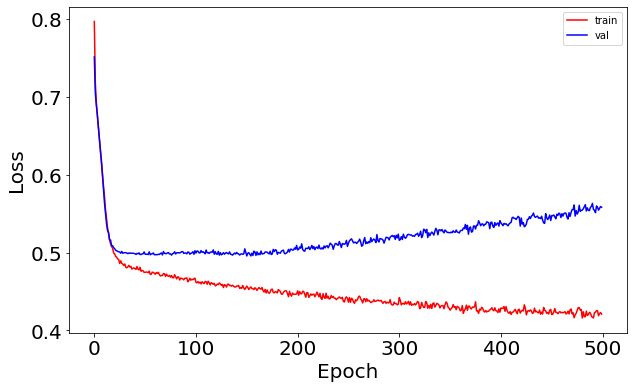

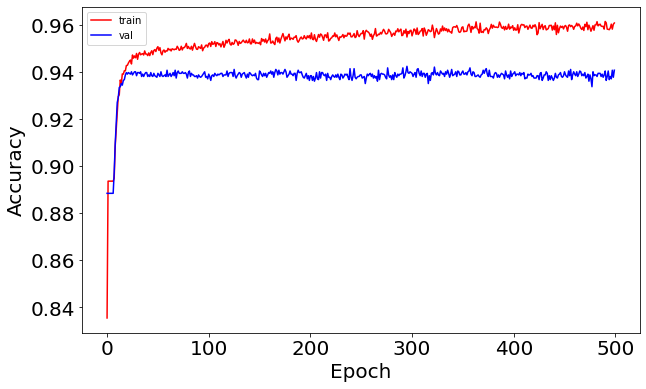

In [64]:
# Capturing learning history per epoch
hist  = pd.DataFrame(nn.history)
hist['epoch'] = nn.epoch

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['loss']), 'r', label='train')
ax.plot(np.sqrt(hist['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['accuracy']), 'r', label='train')
ax.plot(np.sqrt(hist['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

**Observations**

**Loss Function Curve:**
- Comparing the training set performance to the validation set performace reveals a model that is slightly overfitting the training set, as we see a degradation in performance when compared to the validation set. This is most likely due to the imbalaned nature of the datasets.

**Accuracy Curve:**
- As the model learns over time (Epochs) the accuracy improves. It appears though that both the Training Set and Validation Set reaches the max Accuracy at 50~ Epochs, with little to no improvement thereafter
- The Training set has a higher overall accuracy, which suggests that the model is overfitting slightly. However, as observed, this could simply be due to the difference in distribution of Exited across both sets.

**Conclusion**

The imbalanced data needs to be addressed through hyper paramter tuning. Possibly using Up/Down Sampling Techniques.


#### Evaluation

In [65]:
score = model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 338us/step - loss: 0.3466 - accuracy: 0.8735


In [66]:
print(score)

[0.3466022312641144, 0.8734999895095825]


No Skill: ROC AUC=0.500
NN Model: ROC AUC=0.924


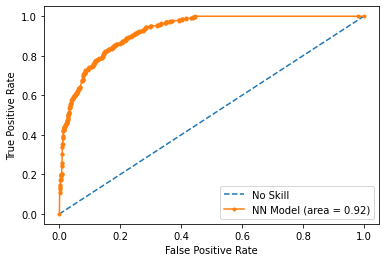

In [67]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NN Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='NN Model (area = %0.2f)' % lr_auc)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

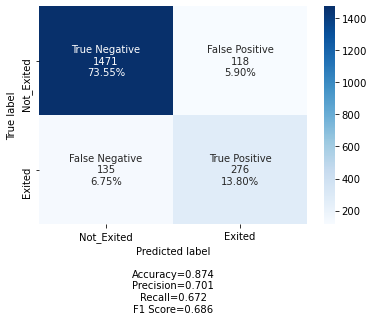

In [68]:
y_pred1 = model.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

Detection of exited customers did improve compared to the previous machine learning model ( Randomforest). However, while the Recall did improve, the number of False Positives increased which is ultimately a potential wasted expense for the business.

- Due to the imbalance of the dataset, the model is struggling to predict Exited = 1. The model does very well in predicting Exited = 0. This can be addressed by increasing the depth of the model, as well as using Earlry Stopping and Weight Initialization to improve the performance of the model.

- The AUC-ROC analysis indicates that the best threshold when assessing the TP to FP rate is at ~0.5. The curve starts to flatten and the gain in TP is minimized as the FP rate increases.

**Conclusion:**

We must find ways to further increase the number of True Positive while reducing the number of False Positives.

### Future Models

We will try different architecture approaches to improve Accuracy & Recall 


There are some basic Hyperparameters which can help to get the better model performance.

**Early stopping:** 

In an attempt to regulize the model and improve the overall performance, we will introduce Early Stopping. Early Stopping is a the algorithmic attempt to test the models performance against the holdout validation set after each Epoch, and stop when the degradation of performance is monitored.

**Weight Initialization**

Due to the inbalance in the dataset related to our target variable, we will introduce different weightings accordingly.

**GridSearch Methods**

After we build the abovementioned models incorporating Early Stopping & Weight Initializaton, we will build a GridSearchCV that we will use to fine tune the hyper parameters in order to maximize the performance of the different models.

We want to maximize recall while improving the TP / FP rate.

### Early Stopping

In [69]:
n_inputs = 13

#Training Multi-layer perceptron with 2 hidden layers

#adding earlystopping callback
es= keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=15, 
                             verbose=0, mode='min', restore_best_weights= True)
Model2 = Sequential()
#Initializing the weights uisng hue_normal 
Model2.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
Model2.add(Dropout(0.5))
Model2.add(Dense(65, kernel_initializer='he_normal', activation='relu'))
Model2.add(Dropout(0.5))
Model2.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

Model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
his_mod2= Model2.fit(X_train, y_train, validation_split=0.2, batch_size=500, epochs=500, callbacks=[es], shuffle=True, verbose=1)


Epoch 1/500
13/13 [==============================] - 1s 17ms/step - loss: 0.8277 - accuracy: 0.6099 - val_loss: 0.5369 - val_accuracy: 0.7875
Epoch 2/500
13/13 [==============================] - 0s 2ms/step - loss: 0.6516 - accuracy: 0.7431 - val_loss: 0.4972 - val_accuracy: 0.7887
Epoch 3/500
13/13 [==============================] - 0s 2ms/step - loss: 0.6092 - accuracy: 0.7550 - val_loss: 0.4603 - val_accuracy: 0.7950
Epoch 4/500
13/13 [==============================] - 0s 2ms/step - loss: 0.5470 - accuracy: 0.7739 - val_loss: 0.4365 - val_accuracy: 0.8062
Epoch 5/500
13/13 [==============================] - 0s 2ms/step - loss: 0.5251 - accuracy: 0.7654 - val_loss: 0.4179 - val_accuracy: 0.8181
Epoch 6/500
13/13 [==============================] - 0s 2ms/step - loss: 0.4736 - accuracy: 0.8063 - val_loss: 0.4031 - val_accuracy: 0.8219
Epoch 7/500
13/13 [==============================] - 0s 2ms/step - loss: 0.4559 - accuracy: 0.8051 - val_loss: 0.3897 - val_accuracy: 0.8300
Epoch 8/500


Epoch 59/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2614 - accuracy: 0.8812 - val_loss: 0.2551 - val_accuracy: 0.8800
Epoch 60/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2697 - accuracy: 0.8800 - val_loss: 0.2546 - val_accuracy: 0.8794
Epoch 61/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2758 - accuracy: 0.8731 - val_loss: 0.2546 - val_accuracy: 0.8819
Epoch 62/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2664 - accuracy: 0.8802 - val_loss: 0.2541 - val_accuracy: 0.8819
Epoch 63/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2678 - accuracy: 0.8821 - val_loss: 0.2539 - val_accuracy: 0.8831
Epoch 64/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2769 - accuracy: 0.8749 - val_loss: 0.2538 - val_accuracy: 0.8819
Epoch 65/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2567 - accuracy: 0.8841 - val_loss: 0.2540 - val_accuracy: 0.8825
Epoch 

13/13 [==============================] - 0s 2ms/step - loss: 0.2511 - accuracy: 0.8847 - val_loss: 0.2512 - val_accuracy: 0.8838
Epoch 117/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2469 - accuracy: 0.8938 - val_loss: 0.2516 - val_accuracy: 0.8819
Epoch 118/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2417 - accuracy: 0.8959 - val_loss: 0.2513 - val_accuracy: 0.8825
Epoch 119/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2436 - accuracy: 0.8892 - val_loss: 0.2511 - val_accuracy: 0.8825
Epoch 120/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2499 - accuracy: 0.8925 - val_loss: 0.2508 - val_accuracy: 0.8813
Epoch 121/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2399 - accuracy: 0.8918 - val_loss: 0.2507 - val_accuracy: 0.8819
Epoch 122/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2528 - accuracy: 0.8902 - val_loss: 0.2512 - val_accuracy: 0.8806
Epoch 123/500

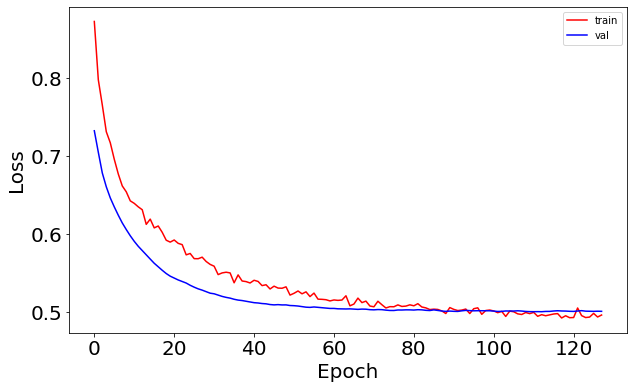

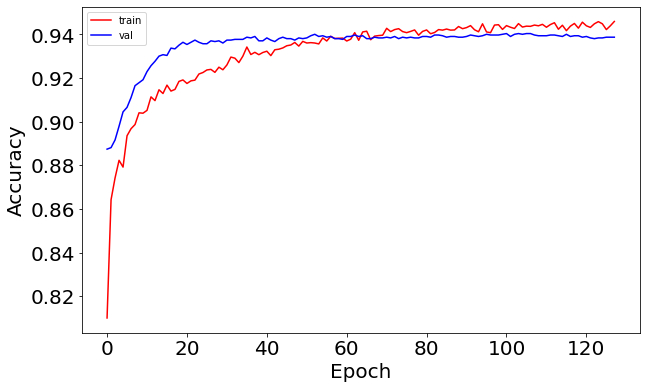

In [70]:
# Capturing learning history per epoch
hist  = pd.DataFrame(his_mod2.history)
hist['epoch'] = his_mod2.epoch

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['loss']), 'r', label='train')
ax.plot(np.sqrt(hist['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['accuracy']), 'r', label='train')
ax.plot(np.sqrt(hist['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

**Observations**

The Training and Validation curves differ slightly.

**Loss Function Curve:**
- both the training and validation set are learning well. As the curve smooths out and flattens to the same Loss over Epochs, we notice that the model is a good fit for the data sets.

**Accuracy Curve:**
- the accuracy curves for both Training and Validation sets indicate to us that the model is a good fit. The Accuracy starts relatively high and continues to perform well as we increase the Epochs. Given enough depth, the model would continue to improve.

No Skill: ROC AUC=0.500
NN Model: ROC AUC=0.940


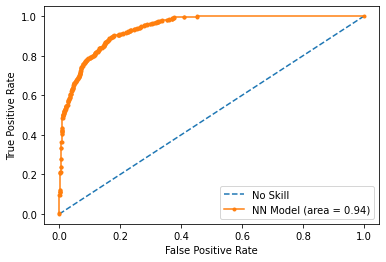

In [72]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = Model2.predict_proba(X_test)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NN Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='NN Model (area = %0.2f)' % lr_auc)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

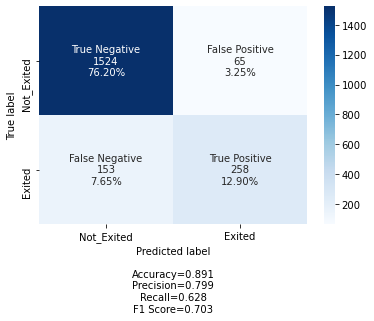

In [146]:
y_pred1 = Model2.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**

The model has performed slightly worse with regards to Accuracy and Recall.

The total number of TP has also decreased.

Overall, the model with early stopping performs slightly worse.

We will attempt to improve Recall and Accuracy in the next model.

**Conclusion:**

As you can see here the Recall of the model has decreased and it is performing worse than the Previous ANN model as well as the RandomForest model.

We will  attempt to tune the model through the introduction of Weighted loss to address the imbalanced data.

### Weighted loss to account for large class imbalance in train dataset

We will adjust the class imbalance by giving additional weight to the loss associated to errors made on fraudulent transaction detection.

We will use our first ANN model and apply weighted loss


In [73]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), np.array([y_train.iloc[i] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.627549419516787, 1: 2.4600246002460024}

In [74]:
n_inputs = 13

Modelwm = Sequential()
#Initializing the weights uisng hue_normal 
Modelwm.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
Modelwm.add(Dropout(0.5))
Modelwm.add(Dense(65, kernel_initializer='he_normal', activation='relu'))
Modelwm.add(Dropout(0.5))
Modelwm.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

Modelwm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
wm= Modelwm.fit(X_train, y_train, validation_split=0.2, batch_size=500, epochs=500, class_weight=class_weights, shuffle=True, verbose=1)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
13/13 [==============================] - 1s 17ms/step - loss: 1.2988 - accuracy: 0.3043 - val_loss: 0.6936 - val_accuracy: 0.5356
Epoch 2/500
13/13 [==============================] - 0s 2ms/step - loss: 0.9366 - accuracy: 0.4942 - val_loss: 0.5530 - val_accuracy: 0.7819
Epoch 3/500
13/13 [==============================] - 0s 2ms/step - loss: 0.8509 - accuracy: 0.5572 - val_loss: 0.5520 - val_accuracy: 0.7862
Epoch 4/500
13/13 [==============================] - 0s 2ms/step - loss: 0.7784 - accuracy: 0.5679 - val_loss: 0.5711 - val_accuracy: 0.7625
Epoch 5/500
13/13 [==============================] - 0s 2ms/step - loss: 0.7159 - accuracy: 0.5784 - val_loss: 0.5506 - val_accuracy: 0.7831
Epoch 6/500
13/13 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.5956 - val_loss: 0.5228 - val_accuracy: 0.8031
Epoch 7/500
13/

13/13 [==============================] - 0s 2ms/step - loss: 0.3551 - accuracy: 0.8159 - val_loss: 0.3078 - val_accuracy: 0.8369
Epoch 57/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3517 - accuracy: 0.8154 - val_loss: 0.3069 - val_accuracy: 0.8388
Epoch 58/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3489 - accuracy: 0.8051 - val_loss: 0.3035 - val_accuracy: 0.8413
Epoch 59/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3512 - accuracy: 0.8108 - val_loss: 0.3040 - val_accuracy: 0.8406
Epoch 60/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3569 - accuracy: 0.8147 - val_loss: 0.3066 - val_accuracy: 0.8369
Epoch 61/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3368 - accuracy: 0.8176 - val_loss: 0.3035 - val_accuracy: 0.8394
Epoch 62/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3415 - accuracy: 0.8187 - val_loss: 0.3038 - val_accuracy: 0.8381
Epoch 63/500
13/13 

Epoch 114/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3115 - accuracy: 0.8305 - val_loss: 0.2936 - val_accuracy: 0.8487
Epoch 115/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3032 - accuracy: 0.8354 - val_loss: 0.2941 - val_accuracy: 0.8506
Epoch 116/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3112 - accuracy: 0.8281 - val_loss: 0.2911 - val_accuracy: 0.8525
Epoch 117/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3082 - accuracy: 0.8331 - val_loss: 0.2916 - val_accuracy: 0.8512
Epoch 118/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3102 - accuracy: 0.8383 - val_loss: 0.2934 - val_accuracy: 0.8494
Epoch 119/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3071 - accuracy: 0.8434 - val_loss: 0.2947 - val_accuracy: 0.8481
Epoch 120/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3181 - accuracy: 0.8308 - val_loss: 0.2904 - val_accuracy: 0.8506

13/13 [==============================] - 0s 2ms/step - loss: 0.3101 - accuracy: 0.8384 - val_loss: 0.2906 - val_accuracy: 0.8525
Epoch 172/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2931 - accuracy: 0.8457 - val_loss: 0.2905 - val_accuracy: 0.8506
Epoch 173/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3005 - accuracy: 0.8405 - val_loss: 0.2910 - val_accuracy: 0.8525
Epoch 174/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2987 - accuracy: 0.8399 - val_loss: 0.2944 - val_accuracy: 0.8487
Epoch 175/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3021 - accuracy: 0.8325 - val_loss: 0.2938 - val_accuracy: 0.8506
Epoch 176/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8383 - val_loss: 0.2913 - val_accuracy: 0.8531
Epoch 177/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2975 - accuracy: 0.8401 - val_loss: 0.2914 - val_accuracy: 0.8512
Epoch 178/500

13/13 [==============================] - 0s 2ms/step - loss: 0.3011 - accuracy: 0.8357 - val_loss: 0.2896 - val_accuracy: 0.8506
Epoch 229/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3048 - accuracy: 0.8324 - val_loss: 0.2879 - val_accuracy: 0.8500
Epoch 230/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2856 - accuracy: 0.8426 - val_loss: 0.2895 - val_accuracy: 0.8494
Epoch 231/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2841 - accuracy: 0.8415 - val_loss: 0.2877 - val_accuracy: 0.8512
Epoch 232/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2990 - accuracy: 0.8408 - val_loss: 0.2886 - val_accuracy: 0.8500
Epoch 233/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2966 - accuracy: 0.8347 - val_loss: 0.2860 - val_accuracy: 0.8506
Epoch 234/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2933 - accuracy: 0.8422 - val_loss: 0.2876 - val_accuracy: 0.8512
Epoch 235/500

13/13 [==============================] - 0s 2ms/step - loss: 0.2833 - accuracy: 0.8410 - val_loss: 0.2847 - val_accuracy: 0.8525
Epoch 286/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2900 - accuracy: 0.8446 - val_loss: 0.2853 - val_accuracy: 0.8531
Epoch 287/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2928 - accuracy: 0.8371 - val_loss: 0.2846 - val_accuracy: 0.8525
Epoch 288/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2784 - accuracy: 0.8464 - val_loss: 0.2845 - val_accuracy: 0.8494
Epoch 289/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2851 - accuracy: 0.8487 - val_loss: 0.2837 - val_accuracy: 0.8519
Epoch 290/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3044 - accuracy: 0.8359 - val_loss: 0.2871 - val_accuracy: 0.8481
Epoch 291/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2854 - accuracy: 0.8398 - val_loss: 0.2869 - val_accuracy: 0.8487
Epoch 292/500

13/13 [==============================] - 0s 2ms/step - loss: 0.2796 - accuracy: 0.8399 - val_loss: 0.2852 - val_accuracy: 0.8475
Epoch 343/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2867 - accuracy: 0.8392 - val_loss: 0.2814 - val_accuracy: 0.8512
Epoch 344/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2835 - accuracy: 0.8452 - val_loss: 0.2828 - val_accuracy: 0.8500
Epoch 345/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2786 - accuracy: 0.8466 - val_loss: 0.2831 - val_accuracy: 0.8512
Epoch 346/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2821 - accuracy: 0.8464 - val_loss: 0.2825 - val_accuracy: 0.8500
Epoch 347/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2806 - accuracy: 0.8482 - val_loss: 0.2830 - val_accuracy: 0.8487
Epoch 348/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2960 - accuracy: 0.8394 - val_loss: 0.2849 - val_accuracy: 0.8450
Epoch 349/500

13/13 [==============================] - 0s 2ms/step - loss: 0.2843 - accuracy: 0.8468 - val_loss: 0.2837 - val_accuracy: 0.8444
Epoch 400/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2753 - accuracy: 0.8476 - val_loss: 0.2840 - val_accuracy: 0.8462
Epoch 401/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2764 - accuracy: 0.8387 - val_loss: 0.2840 - val_accuracy: 0.8487
Epoch 402/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2813 - accuracy: 0.8437 - val_loss: 0.2855 - val_accuracy: 0.8481
Epoch 403/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2776 - accuracy: 0.8439 - val_loss: 0.2852 - val_accuracy: 0.8462
Epoch 404/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2741 - accuracy: 0.8406 - val_loss: 0.2836 - val_accuracy: 0.8469
Epoch 405/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2760 - accuracy: 0.8408 - val_loss: 0.2821 - val_accuracy: 0.8475
Epoch 406/500

13/13 [==============================] - 0s 2ms/step - loss: 0.2690 - accuracy: 0.8496 - val_loss: 0.2795 - val_accuracy: 0.8462
Epoch 457/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2754 - accuracy: 0.8485 - val_loss: 0.2812 - val_accuracy: 0.8438
Epoch 458/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2790 - accuracy: 0.8428 - val_loss: 0.2829 - val_accuracy: 0.8413
Epoch 459/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.8507 - val_loss: 0.2822 - val_accuracy: 0.8431
Epoch 460/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2786 - accuracy: 0.8492 - val_loss: 0.2845 - val_accuracy: 0.8419
Epoch 461/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2799 - accuracy: 0.8497 - val_loss: 0.2830 - val_accuracy: 0.8431
Epoch 462/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2819 - accuracy: 0.8369 - val_loss: 0.2827 - val_accuracy: 0.8431
Epoch 463/500

In [75]:
score_weighted = Modelwm.evaluate(X_test, y_test)

63/63 [==============================] - 0s 321us/step - loss: 0.2997 - accuracy: 0.8245


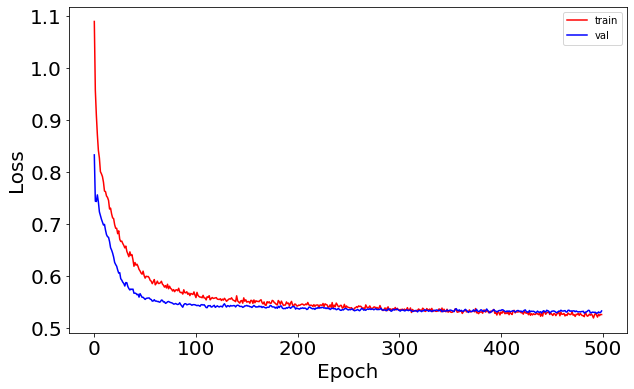

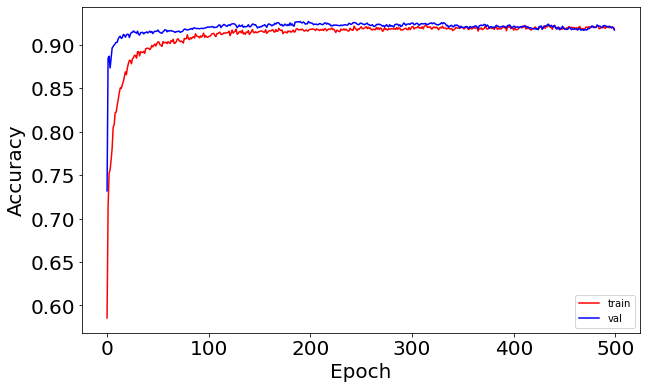

In [76]:
# Capturing learning history per epoch
hist  = pd.DataFrame(wm.history)
hist['epoch'] = wm.epoch

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['loss']), 'r', label='train')
ax.plot(np.sqrt(hist['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['accuracy']), 'r', label='train')
ax.plot(np.sqrt(hist['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

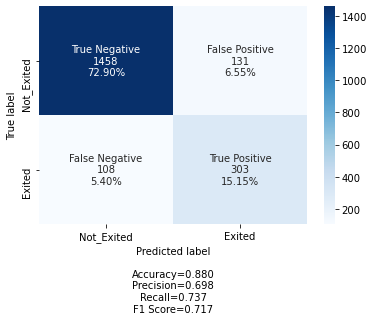

In [149]:
y_pred1 = Modelwm.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.65:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**
    
The model has seen a dramatic improvement in Recall, and a minor decrease in the Accuracy of the model.

So far this is the best performing ANN we have built.

The weighted adjustments for the target variable has improved the models overall ability to predict Exited = 1. However, it is too agressive in its prediction as noticed by the inrease in FP.

We will examine the threshold for better tuning by analyzing the ROC-AUC curve.

No Skill: ROC AUC=0.500
NN Model: ROC AUC=0.936


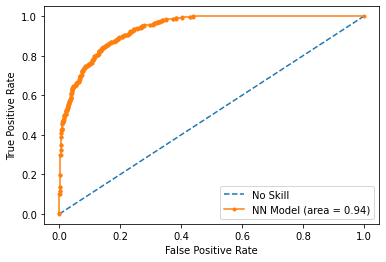

In [78]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = Modelwm.predict_proba(X_test)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NN Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='NN Model (area = %0.2f)' % lr_auc)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Observations:**

The AUC score is very good (0.94).

Based on the curve, we should be able to adjust the threshold to be tighter, based on the curve, we will adjust the threshold to 0.6

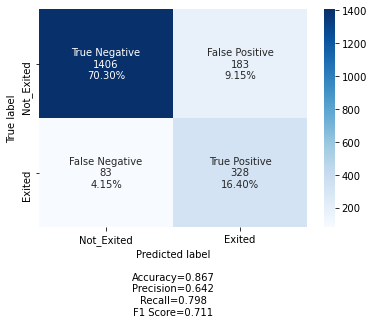

In [79]:
#adjusting threshold
y_pred1 = Modelwm.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.6:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**

Through adjusting the threshold, we have seen an increase in Accuracy and a slight decrease in Recall.

However, we see that we are predicting false positives in a reduced capacity. The trade off by adjusting the threshold has yieled a more balanced and better performing model overall.

### Grid Search NN

In an attempt to find the most optimal hyper parameters, I will be using GridSearchCV to determine the best performing parameters.

We will start with a based ANN model, before attempting the same with the models we used above.

In [80]:
def create_model(optimizer = 'adam', dropout_rate='0.1', neurons='20'):
    model = Sequential()
    model.add(Dense(units=20, input_dim = 13,activation='relu'))   # input of 13 columns as shown above
    # hidden layer
    model.add(Dense(units=20,activation='relu'))
    #Adding Dropout to prevent overfitting 
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))                        # binary classification Exited or not
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [82]:
%%time
# fix random seed for reproducibility (this might work or might not work 
# depending on each library's implenentation)
seed = 7
np.random.seed(seed)

# create the sklearn model for the network
model_init_batch_epoch_CV = KerasClassifier(build_fn=create_model, verbose=1)
batches = [50, 100, 150]
epochs = [50, 100, 150]
optimizers = ['rmsprop', 'adam']
neurons = [10, 15, 20]

# grid search for initializer, batch size and number of epochs
param_grid = dict(epochs=epochs, batch_size=batches, optimizer=optimizers, neurons=neurons)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, 
                    param_grid=param_grid,
                    cv=3)
grid_result = grid.fit(X_train, y_train)





Epoch 1/50
107/107 [==============================] - 1s 485us/step - loss: 0.4919 - accuracy: 0.8001
Epoch 2/50
107/107 [==============================] - 0s 489us/step - loss: 0.3683 - accuracy: 0.8153
Epoch 3/50
107/107 [==============================] - 0s 489us/step - loss: 0.3143 - accuracy: 0.8566
Epoch 4/50
107/107 [==============================] - 0s 489us/step - loss: 0.2925 - accuracy: 0.8681
Epoch 5/50
107/107 [==============================] - 0s 489us/step - loss: 0.2722 - accuracy: 0.8714
Epoch 6/50
107/107 [==============================] - 0s 509us/step - loss: 0.2467 - accuracy: 0.8866
Epoch 7/50
107/107 [==============================] - 0s 499us/step - loss: 0.2558 - accuracy: 0.8849
Epoch 8/50
107/107 [==============================] - 0s 489us/step - loss: 0.2406 - accuracy: 0.8944
Epoch 9/50
107/107 [==============================] - 0s 492us/step - loss: 0.2451 - accuracy: 0.8912
Epoch 10/50
107/107 [==============================] - 0s 491us/step - loss: 0.256

107/107 [==============================] - 0s 470us/step - loss: 0.2242 - accuracy: 0.9005
Epoch 30/50
107/107 [==============================] - 0s 470us/step - loss: 0.2130 - accuracy: 0.9054
Epoch 31/50
107/107 [==============================] - 0s 470us/step - loss: 0.2233 - accuracy: 0.9002
Epoch 32/50
107/107 [==============================] - 0s 475us/step - loss: 0.2264 - accuracy: 0.8977
Epoch 33/50
107/107 [==============================] - 0s 461us/step - loss: 0.2239 - accuracy: 0.9081
Epoch 34/50
107/107 [==============================] - 0s 489us/step - loss: 0.2243 - accuracy: 0.9069
Epoch 35/50
107/107 [==============================] - 0s 470us/step - loss: 0.2264 - accuracy: 0.9001
Epoch 36/50
107/107 [==============================] - 0s 470us/step - loss: 0.2114 - accuracy: 0.9096
Epoch 37/50
107/107 [==============================] - 0s 482us/step - loss: 0.2341 - accuracy: 0.8954
Epoch 38/50
107/107 [==============================] - 0s 467us/step - loss: 0.2237 -

107/107 [==============================] - 0s 457us/step - loss: 0.2613 - accuracy: 0.8821
Epoch 8/50
107/107 [==============================] - 0s 470us/step - loss: 0.2512 - accuracy: 0.8863
Epoch 9/50
107/107 [==============================] - 0s 461us/step - loss: 0.2495 - accuracy: 0.8879
Epoch 10/50
107/107 [==============================] - 0s 461us/step - loss: 0.2322 - accuracy: 0.8954
Epoch 11/50
107/107 [==============================] - 0s 470us/step - loss: 0.2427 - accuracy: 0.8863
Epoch 12/50
107/107 [==============================] - 0s 470us/step - loss: 0.2347 - accuracy: 0.8961
Epoch 13/50
107/107 [==============================] - 0s 470us/step - loss: 0.2359 - accuracy: 0.8957
Epoch 14/50
107/107 [==============================] - 0s 480us/step - loss: 0.2436 - accuracy: 0.8941
Epoch 15/50
107/107 [==============================] - 0s 460us/step - loss: 0.2474 - accuracy: 0.8924
Epoch 16/50
107/107 [==============================] - 0s 461us/step - loss: 0.2376 - a

107/107 [==============================] - 0s 489us/step - loss: 0.2252 - accuracy: 0.8977
Epoch 36/50
107/107 [==============================] - 0s 480us/step - loss: 0.2243 - accuracy: 0.9025
Epoch 37/50
107/107 [==============================] - 0s 494us/step - loss: 0.2190 - accuracy: 0.9027
Epoch 38/50
107/107 [==============================] - 0s 470us/step - loss: 0.2139 - accuracy: 0.9055
Epoch 39/50
107/107 [==============================] - 0s 493us/step - loss: 0.2246 - accuracy: 0.9047
Epoch 40/50
107/107 [==============================] - 0s 470us/step - loss: 0.2232 - accuracy: 0.8955
Epoch 41/50
107/107 [==============================] - 0s 489us/step - loss: 0.2165 - accuracy: 0.9044
Epoch 42/50
107/107 [==============================] - 0s 480us/step - loss: 0.2233 - accuracy: 0.9044
Epoch 43/50
107/107 [==============================] - 0s 471us/step - loss: 0.2203 - accuracy: 0.9018
Epoch 44/50
107/107 [==============================] - 0s 472us/step - loss: 0.2185 -

107/107 [==============================] - 0s 470us/step - loss: 0.2317 - accuracy: 0.8971
Epoch 14/50
107/107 [==============================] - 0s 470us/step - loss: 0.2459 - accuracy: 0.8894
Epoch 15/50
107/107 [==============================] - 0s 487us/step - loss: 0.2269 - accuracy: 0.9015
Epoch 16/50
107/107 [==============================] - 0s 468us/step - loss: 0.2282 - accuracy: 0.8978
Epoch 17/50
107/107 [==============================] - 0s 470us/step - loss: 0.2370 - accuracy: 0.8908
Epoch 18/50
107/107 [==============================] - 0s 470us/step - loss: 0.2253 - accuracy: 0.8965
Epoch 19/50
107/107 [==============================] - 0s 470us/step - loss: 0.2404 - accuracy: 0.8942
Epoch 20/50
107/107 [==============================] - 0s 489us/step - loss: 0.2294 - accuracy: 0.8959
Epoch 21/50
107/107 [==============================] - 0s 470us/step - loss: 0.2220 - accuracy: 0.9053
Epoch 22/50
107/107 [==============================] - 0s 489us/step - loss: 0.2224 -

107/107 [==============================] - 0s 508us/step - loss: 0.2144 - accuracy: 0.9067
Epoch 42/50
107/107 [==============================] - 0s 499us/step - loss: 0.2157 - accuracy: 0.9090
Epoch 43/50
107/107 [==============================] - 0s 527us/step - loss: 0.2034 - accuracy: 0.9071
Epoch 44/50
107/107 [==============================] - 0s 508us/step - loss: 0.2138 - accuracy: 0.9050
Epoch 45/50
107/107 [==============================] - 0s 489us/step - loss: 0.2161 - accuracy: 0.9060
Epoch 46/50
107/107 [==============================] - 0s 499us/step - loss: 0.2290 - accuracy: 0.8971
Epoch 47/50
107/107 [==============================] - 0s 481us/step - loss: 0.2159 - accuracy: 0.9062
Epoch 48/50
107/107 [==============================] - 0s 470us/step - loss: 0.2176 - accuracy: 0.9026
Epoch 49/50
107/107 [==============================] - 0s 480us/step - loss: 0.2137 - accuracy: 0.9032
Epoch 50/50
54/54 [==============================] - 0s 339us/step - loss: 0.2503 - a

107/107 [==============================] - 0s 461us/step - loss: 0.2163 - accuracy: 0.9026
Epoch 20/50
107/107 [==============================] - 0s 461us/step - loss: 0.2325 - accuracy: 0.9004
Epoch 21/50
107/107 [==============================] - 0s 461us/step - loss: 0.2317 - accuracy: 0.8966
Epoch 22/50
107/107 [==============================] - 0s 470us/step - loss: 0.2268 - accuracy: 0.8989
Epoch 23/50
107/107 [==============================] - 0s 470us/step - loss: 0.2324 - accuracy: 0.8946
Epoch 24/50
107/107 [==============================] - 0s 470us/step - loss: 0.2300 - accuracy: 0.9025
Epoch 25/50
107/107 [==============================] - 0s 461us/step - loss: 0.2276 - accuracy: 0.9038
Epoch 26/50
107/107 [==============================] - 0s 470us/step - loss: 0.2311 - accuracy: 0.9011
Epoch 27/50
107/107 [==============================] - 0s 470us/step - loss: 0.2255 - accuracy: 0.9022
Epoch 28/50
107/107 [==============================] - 0s 470us/step - loss: 0.2150 -

107/107 [==============================] - 0s 461us/step - loss: 0.2092 - accuracy: 0.9048
Epoch 48/50
107/107 [==============================] - 0s 461us/step - loss: 0.2157 - accuracy: 0.8999
Epoch 49/50
107/107 [==============================] - 0s 461us/step - loss: 0.2145 - accuracy: 0.8992
Epoch 50/50
54/54 [==============================] - 0s 339us/step - loss: 0.2543 - accuracy: 0.8845
Epoch 1/50
107/107 [==============================] - 1s 470us/step - loss: 0.5482 - accuracy: 0.7533
Epoch 2/50
107/107 [==============================] - 0s 470us/step - loss: 0.4059 - accuracy: 0.8198
Epoch 3/50
107/107 [==============================] - 0s 461us/step - loss: 0.3484 - accuracy: 0.8347
Epoch 4/50
107/107 [==============================] - 0s 480us/step - loss: 0.3003 - accuracy: 0.8668
Epoch 5/50
107/107 [==============================] - 0s 470us/step - loss: 0.2889 - accuracy: 0.8684
Epoch 6/50
107/107 [==============================] - 0s 470us/step - loss: 0.2680 - accurac

107/107 [==============================] - 0s 480us/step - loss: 0.2194 - accuracy: 0.9039
Epoch 26/50
107/107 [==============================] - 0s 461us/step - loss: 0.2344 - accuracy: 0.8939
Epoch 27/50
107/107 [==============================] - 0s 470us/step - loss: 0.2424 - accuracy: 0.8929
Epoch 28/50
107/107 [==============================] - 0s 470us/step - loss: 0.2270 - accuracy: 0.8988
Epoch 29/50
107/107 [==============================] - 0s 470us/step - loss: 0.2183 - accuracy: 0.8995
Epoch 30/50
107/107 [==============================] - 0s 470us/step - loss: 0.2282 - accuracy: 0.8980
Epoch 31/50
107/107 [==============================] - 0s 470us/step - loss: 0.2203 - accuracy: 0.9024
Epoch 32/50
107/107 [==============================] - 0s 489us/step - loss: 0.2325 - accuracy: 0.8952
Epoch 33/50
107/107 [==============================] - 0s 461us/step - loss: 0.2233 - accuracy: 0.8963
Epoch 34/50
107/107 [==============================] - 0s 470us/step - loss: 0.2160 -

107/107 [==============================] - 0s 470us/step - loss: 0.3571 - accuracy: 0.8379
Epoch 4/50
107/107 [==============================] - 0s 470us/step - loss: 0.3099 - accuracy: 0.8572
Epoch 5/50
107/107 [==============================] - 0s 470us/step - loss: 0.2758 - accuracy: 0.8811
Epoch 6/50
107/107 [==============================] - 0s 461us/step - loss: 0.2748 - accuracy: 0.8752
Epoch 7/50
107/107 [==============================] - 0s 470us/step - loss: 0.2417 - accuracy: 0.8983
Epoch 8/50
107/107 [==============================] - 0s 461us/step - loss: 0.2477 - accuracy: 0.8903
Epoch 9/50
107/107 [==============================] - 0s 470us/step - loss: 0.2519 - accuracy: 0.8886
Epoch 10/50
107/107 [==============================] - 0s 480us/step - loss: 0.2466 - accuracy: 0.8926
Epoch 11/50
107/107 [==============================] - 0s 480us/step - loss: 0.2479 - accuracy: 0.8960
Epoch 12/50
107/107 [==============================] - 0s 470us/step - loss: 0.2419 - accur

Epoch 32/50
107/107 [==============================] - 0s 461us/step - loss: 0.2191 - accuracy: 0.9046
Epoch 33/50
107/107 [==============================] - 0s 461us/step - loss: 0.2152 - accuracy: 0.9045
Epoch 34/50
107/107 [==============================] - 0s 461us/step - loss: 0.2109 - accuracy: 0.9073
Epoch 35/50
107/107 [==============================] - 0s 461us/step - loss: 0.2172 - accuracy: 0.9048
Epoch 36/50
107/107 [==============================] - 0s 461us/step - loss: 0.2163 - accuracy: 0.9053
Epoch 37/50
107/107 [==============================] - 0s 470us/step - loss: 0.2283 - accuracy: 0.8961
Epoch 38/50
107/107 [==============================] - 0s 461us/step - loss: 0.2256 - accuracy: 0.8992
Epoch 39/50
107/107 [==============================] - 0s 461us/step - loss: 0.2111 - accuracy: 0.9010
Epoch 40/50
107/107 [==============================] - 0s 461us/step - loss: 0.1997 - accuracy: 0.9086
Epoch 41/50
107/107 [==============================] - 0s 461us/step - lo

Epoch 10/50
107/107 [==============================] - 0s 470us/step - loss: 0.2466 - accuracy: 0.8819
Epoch 11/50
107/107 [==============================] - 0s 470us/step - loss: 0.2543 - accuracy: 0.8871
Epoch 12/50
107/107 [==============================] - 0s 489us/step - loss: 0.2478 - accuracy: 0.8921
Epoch 13/50
107/107 [==============================] - 0s 461us/step - loss: 0.2547 - accuracy: 0.8796
Epoch 14/50
107/107 [==============================] - 0s 470us/step - loss: 0.2355 - accuracy: 0.8979
Epoch 15/50
107/107 [==============================] - 0s 470us/step - loss: 0.2400 - accuracy: 0.8937
Epoch 16/50
107/107 [==============================] - 0s 480us/step - loss: 0.2460 - accuracy: 0.8855
Epoch 17/50
107/107 [==============================] - 0s 461us/step - loss: 0.2441 - accuracy: 0.8880
Epoch 18/50
107/107 [==============================] - 0s 470us/step - loss: 0.2341 - accuracy: 0.8958
Epoch 19/50
107/107 [==============================] - 0s 461us/step - lo

107/107 [==============================] - 0s 470us/step - loss: 0.2238 - accuracy: 0.8988
Epoch 39/100
107/107 [==============================] - 0s 482us/step - loss: 0.2220 - accuracy: 0.9066
Epoch 40/100
107/107 [==============================] - 0s 461us/step - loss: 0.2233 - accuracy: 0.8985
Epoch 41/100
107/107 [==============================] - 0s 470us/step - loss: 0.2196 - accuracy: 0.9051
Epoch 42/100
107/107 [==============================] - 0s 470us/step - loss: 0.2271 - accuracy: 0.8937
Epoch 43/100
107/107 [==============================] - 0s 461us/step - loss: 0.2147 - accuracy: 0.9071
Epoch 44/100
107/107 [==============================] - 0s 470us/step - loss: 0.2135 - accuracy: 0.9023
Epoch 45/100
107/107 [==============================] - 0s 470us/step - loss: 0.1979 - accuracy: 0.9133
Epoch 46/100
107/107 [==============================] - 0s 470us/step - loss: 0.2055 - accuracy: 0.9104
Epoch 47/100
107/107 [==============================] - 0s 461us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.2409 - accuracy: 0.8889
Epoch 17/100
107/107 [==============================] - 0s 461us/step - loss: 0.2362 - accuracy: 0.8950
Epoch 18/100
107/107 [==============================] - 0s 480us/step - loss: 0.2403 - accuracy: 0.8948
Epoch 19/100
107/107 [==============================] - 0s 470us/step - loss: 0.2424 - accuracy: 0.8903
Epoch 20/100
107/107 [==============================] - 0s 470us/step - loss: 0.2444 - accuracy: 0.8861
Epoch 21/100
107/107 [==============================] - 0s 480us/step - loss: 0.2356 - accuracy: 0.8944
Epoch 22/100
107/107 [==============================] - 0s 470us/step - loss: 0.2413 - accuracy: 0.8869
Epoch 23/100
107/107 [==============================] - 0s 489us/step - loss: 0.2400 - accuracy: 0.8912
Epoch 24/100
107/107 [==============================] - 0s 470us/step - loss: 0.2355 - accuracy: 0.8933
Epoch 25/100
107/107 [==============================] - 0s 470us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.2053 - accuracy: 0.9027
Epoch 95/100
107/107 [==============================] - 0s 470us/step - loss: 0.1969 - accuracy: 0.9128
Epoch 96/100
107/107 [==============================] - 0s 461us/step - loss: 0.2012 - accuracy: 0.9106
Epoch 97/100
107/107 [==============================] - 0s 470us/step - loss: 0.1999 - accuracy: 0.9117
Epoch 98/100
107/107 [==============================] - 0s 470us/step - loss: 0.1826 - accuracy: 0.9199
Epoch 99/100
107/107 [==============================] - 0s 470us/step - loss: 0.2192 - accuracy: 0.9043
Epoch 100/100
54/54 [==============================] - 0s 338us/step - loss: 0.2608 - accuracy: 0.8830
Epoch 1/100
107/107 [==============================] - 1s 470us/step - loss: 0.5641 - accuracy: 0.7877
Epoch 2/100
107/107 [==============================] - 0s 461us/step - loss: 0.4328 - accuracy: 0.8033
Epoch 3/100
107/107 [==============================] - 0s 461us/step - loss: 0.3

107/107 [==============================] - 0s 470us/step - loss: 0.2069 - accuracy: 0.9038
Epoch 73/100
107/107 [==============================] - 0s 470us/step - loss: 0.2039 - accuracy: 0.9075
Epoch 74/100
107/107 [==============================] - 0s 461us/step - loss: 0.2027 - accuracy: 0.9118
Epoch 75/100
107/107 [==============================] - 0s 470us/step - loss: 0.2065 - accuracy: 0.9113
Epoch 76/100
107/107 [==============================] - 0s 470us/step - loss: 0.2096 - accuracy: 0.9055
Epoch 77/100
107/107 [==============================] - 0s 461us/step - loss: 0.2068 - accuracy: 0.9036
Epoch 78/100
107/107 [==============================] - 0s 461us/step - loss: 0.2026 - accuracy: 0.9129
Epoch 79/100
107/107 [==============================] - 0s 461us/step - loss: 0.2061 - accuracy: 0.9087
Epoch 80/100
107/107 [==============================] - 0s 470us/step - loss: 0.2257 - accuracy: 0.8951
Epoch 81/100
107/107 [==============================] - 0s 461us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.2145 - accuracy: 0.9088
Epoch 51/100
107/107 [==============================] - 0s 461us/step - loss: 0.2051 - accuracy: 0.9098
Epoch 52/100
107/107 [==============================] - 0s 470us/step - loss: 0.2103 - accuracy: 0.9092
Epoch 53/100
107/107 [==============================] - 0s 470us/step - loss: 0.2090 - accuracy: 0.9042
Epoch 54/100
107/107 [==============================] - 0s 470us/step - loss: 0.2098 - accuracy: 0.9099
Epoch 55/100
107/107 [==============================] - 0s 470us/step - loss: 0.2125 - accuracy: 0.9035
Epoch 56/100
107/107 [==============================] - 0s 470us/step - loss: 0.2116 - accuracy: 0.9101
Epoch 57/100
107/107 [==============================] - 0s 470us/step - loss: 0.2182 - accuracy: 0.9069
Epoch 58/100
107/107 [==============================] - 0s 461us/step - loss: 0.2133 - accuracy: 0.9063
Epoch 59/100
107/107 [==============================] - 0s 470us/step - loss:

107/107 [==============================] - 0s 461us/step - loss: 0.2403 - accuracy: 0.8900
Epoch 29/100
107/107 [==============================] - 0s 461us/step - loss: 0.2215 - accuracy: 0.9010
Epoch 30/100
107/107 [==============================] - 0s 461us/step - loss: 0.2169 - accuracy: 0.9007
Epoch 31/100
107/107 [==============================] - 0s 470us/step - loss: 0.2299 - accuracy: 0.8985
Epoch 32/100
107/107 [==============================] - 0s 461us/step - loss: 0.2261 - accuracy: 0.8962
Epoch 33/100
107/107 [==============================] - 0s 461us/step - loss: 0.2218 - accuracy: 0.8999
Epoch 34/100
107/107 [==============================] - 0s 470us/step - loss: 0.2077 - accuracy: 0.9074
Epoch 35/100
107/107 [==============================] - 0s 461us/step - loss: 0.2241 - accuracy: 0.9012
Epoch 36/100
107/107 [==============================] - 0s 461us/step - loss: 0.2135 - accuracy: 0.9092
Epoch 37/100
107/107 [==============================] - 0s 470us/step - loss:

107/107 [==============================] - 0s 480us/step - loss: 0.2593 - accuracy: 0.8899
Epoch 7/100
107/107 [==============================] - 0s 470us/step - loss: 0.2519 - accuracy: 0.8877
Epoch 8/100
107/107 [==============================] - 0s 470us/step - loss: 0.2454 - accuracy: 0.8908
Epoch 9/100
107/107 [==============================] - 0s 470us/step - loss: 0.2483 - accuracy: 0.8852
Epoch 10/100
107/107 [==============================] - 0s 470us/step - loss: 0.2429 - accuracy: 0.8881
Epoch 11/100
107/107 [==============================] - 0s 470us/step - loss: 0.2409 - accuracy: 0.8899
Epoch 12/100
107/107 [==============================] - 0s 470us/step - loss: 0.2422 - accuracy: 0.8916
Epoch 13/100
107/107 [==============================] - 0s 470us/step - loss: 0.2486 - accuracy: 0.8814
Epoch 14/100
107/107 [==============================] - 0s 480us/step - loss: 0.2396 - accuracy: 0.8939
Epoch 15/100
107/107 [==============================] - 0s 470us/step - loss: 0.

107/107 [==============================] - 0s 470us/step - loss: 0.2089 - accuracy: 0.9103
Epoch 85/100
107/107 [==============================] - 0s 461us/step - loss: 0.2109 - accuracy: 0.9056
Epoch 86/100
107/107 [==============================] - 0s 470us/step - loss: 0.2013 - accuracy: 0.9114
Epoch 87/100
107/107 [==============================] - 0s 480us/step - loss: 0.2036 - accuracy: 0.9092
Epoch 88/100
107/107 [==============================] - 0s 470us/step - loss: 0.2030 - accuracy: 0.9140
Epoch 89/100
107/107 [==============================] - 0s 470us/step - loss: 0.1957 - accuracy: 0.9175
Epoch 90/100
107/107 [==============================] - 0s 480us/step - loss: 0.1943 - accuracy: 0.9160
Epoch 91/100
107/107 [==============================] - 0s 470us/step - loss: 0.1974 - accuracy: 0.9165
Epoch 92/100
107/107 [==============================] - 0s 470us/step - loss: 0.1974 - accuracy: 0.9123
Epoch 93/100
107/107 [==============================] - 0s 470us/step - loss:

107/107 [==============================] - 0s 461us/step - loss: 0.2137 - accuracy: 0.9109
Epoch 63/100
107/107 [==============================] - 0s 461us/step - loss: 0.2100 - accuracy: 0.9039
Epoch 64/100
107/107 [==============================] - 0s 461us/step - loss: 0.2056 - accuracy: 0.9093
Epoch 65/100
107/107 [==============================] - 0s 461us/step - loss: 0.2196 - accuracy: 0.9026
Epoch 66/100
107/107 [==============================] - 0s 452us/step - loss: 0.2059 - accuracy: 0.9133
Epoch 67/100
107/107 [==============================] - 0s 461us/step - loss: 0.2104 - accuracy: 0.9066
Epoch 68/100
107/107 [==============================] - 0s 461us/step - loss: 0.2055 - accuracy: 0.9094
Epoch 69/100
107/107 [==============================] - 0s 470us/step - loss: 0.2181 - accuracy: 0.9048
Epoch 70/100
107/107 [==============================] - 0s 461us/step - loss: 0.2089 - accuracy: 0.9052
Epoch 71/100
107/107 [==============================] - 0s 452us/step - loss:

107/107 [==============================] - 0s 461us/step - loss: 0.2178 - accuracy: 0.9027
Epoch 41/100
107/107 [==============================] - 0s 470us/step - loss: 0.2180 - accuracy: 0.9004
Epoch 42/100
107/107 [==============================] - 0s 461us/step - loss: 0.2228 - accuracy: 0.8999
Epoch 43/100
107/107 [==============================] - 0s 461us/step - loss: 0.2186 - accuracy: 0.9008
Epoch 44/100
107/107 [==============================] - 0s 461us/step - loss: 0.2247 - accuracy: 0.9008
Epoch 45/100
107/107 [==============================] - 0s 461us/step - loss: 0.2291 - accuracy: 0.8976
Epoch 46/100
107/107 [==============================] - 0s 461us/step - loss: 0.2083 - accuracy: 0.9033
Epoch 47/100
107/107 [==============================] - 0s 461us/step - loss: 0.2184 - accuracy: 0.9001
Epoch 48/100
107/107 [==============================] - 0s 470us/step - loss: 0.2238 - accuracy: 0.8965
Epoch 49/100
107/107 [==============================] - 0s 461us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.2342 - accuracy: 0.8985
Epoch 19/100
107/107 [==============================] - 0s 470us/step - loss: 0.2398 - accuracy: 0.8946
Epoch 20/100
107/107 [==============================] - 0s 470us/step - loss: 0.2367 - accuracy: 0.8911
Epoch 21/100
107/107 [==============================] - 0s 470us/step - loss: 0.2361 - accuracy: 0.8964
Epoch 22/100
107/107 [==============================] - 0s 470us/step - loss: 0.2262 - accuracy: 0.9017
Epoch 23/100
107/107 [==============================] - 0s 470us/step - loss: 0.2204 - accuracy: 0.9023
Epoch 24/100
107/107 [==============================] - 0s 470us/step - loss: 0.2260 - accuracy: 0.9022
Epoch 25/100
107/107 [==============================] - 0s 461us/step - loss: 0.2184 - accuracy: 0.9024
Epoch 26/100
107/107 [==============================] - 0s 470us/step - loss: 0.2167 - accuracy: 0.9055
Epoch 27/100
107/107 [==============================] - 0s 470us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.2020 - accuracy: 0.9143
Epoch 97/100
107/107 [==============================] - 0s 470us/step - loss: 0.1982 - accuracy: 0.9165
Epoch 98/100
107/107 [==============================] - 0s 470us/step - loss: 0.1860 - accuracy: 0.9251
Epoch 99/100
107/107 [==============================] - 0s 480us/step - loss: 0.2024 - accuracy: 0.9126
Epoch 100/100
54/54 [==============================] - 0s 345us/step - loss: 0.2492 - accuracy: 0.8815
Epoch 1/100
107/107 [==============================] - 1s 470us/step - loss: 0.5211 - accuracy: 0.8006
Epoch 2/100
107/107 [==============================] - 0s 470us/step - loss: 0.3876 - accuracy: 0.8179
Epoch 3/100
107/107 [==============================] - 0s 470us/step - loss: 0.3246 - accuracy: 0.8508
Epoch 4/100
107/107 [==============================] - 0s 470us/step - loss: 0.2894 - accuracy: 0.8625
Epoch 5/100
107/107 [==============================] - 0s 489us/step - loss: 0.271

107/107 [==============================] - 0s 470us/step - loss: 0.2130 - accuracy: 0.9034
Epoch 75/100
107/107 [==============================] - 0s 472us/step - loss: 0.2072 - accuracy: 0.9067
Epoch 76/100
107/107 [==============================] - 0s 470us/step - loss: 0.2077 - accuracy: 0.9091
Epoch 77/100
107/107 [==============================] - 0s 470us/step - loss: 0.2085 - accuracy: 0.9057
Epoch 78/100
107/107 [==============================] - 0s 470us/step - loss: 0.2242 - accuracy: 0.8937
Epoch 79/100
107/107 [==============================] - 0s 470us/step - loss: 0.2150 - accuracy: 0.9002
Epoch 80/100
107/107 [==============================] - 0s 470us/step - loss: 0.2143 - accuracy: 0.9053
Epoch 81/100
107/107 [==============================] - 0s 480us/step - loss: 0.2119 - accuracy: 0.9062
Epoch 82/100
107/107 [==============================] - 0s 470us/step - loss: 0.2165 - accuracy: 0.8971
Epoch 83/100
107/107 [==============================] - 0s 489us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.2255 - accuracy: 0.8937
Epoch 53/100
107/107 [==============================] - 0s 470us/step - loss: 0.2199 - accuracy: 0.9024
Epoch 54/100
107/107 [==============================] - 0s 470us/step - loss: 0.2063 - accuracy: 0.9113
Epoch 55/100
107/107 [==============================] - 0s 480us/step - loss: 0.2052 - accuracy: 0.9063
Epoch 56/100
107/107 [==============================] - 0s 480us/step - loss: 0.2122 - accuracy: 0.9030
Epoch 57/100
107/107 [==============================] - 0s 470us/step - loss: 0.2040 - accuracy: 0.9107
Epoch 58/100
107/107 [==============================] - 0s 461us/step - loss: 0.2007 - accuracy: 0.9104
Epoch 59/100
107/107 [==============================] - 0s 470us/step - loss: 0.2101 - accuracy: 0.9045
Epoch 60/100
107/107 [==============================] - 0s 461us/step - loss: 0.2015 - accuracy: 0.9057
Epoch 61/100
107/107 [==============================] - 0s 470us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.2172 - accuracy: 0.9061
Epoch 31/100
107/107 [==============================] - 0s 470us/step - loss: 0.2386 - accuracy: 0.8875
Epoch 32/100
107/107 [==============================] - 0s 489us/step - loss: 0.2280 - accuracy: 0.8997
Epoch 33/100
107/107 [==============================] - 0s 480us/step - loss: 0.2337 - accuracy: 0.8980
Epoch 34/100
107/107 [==============================] - 0s 470us/step - loss: 0.2284 - accuracy: 0.8965
Epoch 35/100
107/107 [==============================] - 0s 470us/step - loss: 0.2112 - accuracy: 0.9041
Epoch 36/100
107/107 [==============================] - 0s 470us/step - loss: 0.2198 - accuracy: 0.9095
Epoch 37/100
107/107 [==============================] - 0s 480us/step - loss: 0.2311 - accuracy: 0.8997
Epoch 38/100
107/107 [==============================] - 0s 480us/step - loss: 0.2226 - accuracy: 0.9014
Epoch 39/100
107/107 [==============================] - 0s 470us/step - loss:

107/107 [==============================] - 0s 461us/step - loss: 0.2536 - accuracy: 0.8880
Epoch 9/100
107/107 [==============================] - 0s 470us/step - loss: 0.2511 - accuracy: 0.8952
Epoch 10/100
107/107 [==============================] - 0s 480us/step - loss: 0.2490 - accuracy: 0.8855
Epoch 11/100
107/107 [==============================] - 0s 470us/step - loss: 0.2413 - accuracy: 0.8915
Epoch 12/100
107/107 [==============================] - 0s 470us/step - loss: 0.2475 - accuracy: 0.8886
Epoch 13/100
107/107 [==============================] - 0s 470us/step - loss: 0.2343 - accuracy: 0.8976
Epoch 14/100
107/107 [==============================] - 0s 461us/step - loss: 0.2265 - accuracy: 0.8948
Epoch 15/100
107/107 [==============================] - 0s 461us/step - loss: 0.2304 - accuracy: 0.8965
Epoch 16/100
107/107 [==============================] - 0s 469us/step - loss: 0.2298 - accuracy: 0.8945
Epoch 17/100
107/107 [==============================] - 0s 461us/step - loss: 

107/107 [==============================] - 0s 499us/step - loss: 0.2037 - accuracy: 0.9122
Epoch 87/100
107/107 [==============================] - 0s 517us/step - loss: 0.1983 - accuracy: 0.9131
Epoch 88/100
107/107 [==============================] - 0s 499us/step - loss: 0.2066 - accuracy: 0.9094
Epoch 89/100
107/107 [==============================] - 0s 499us/step - loss: 0.2040 - accuracy: 0.9102
Epoch 90/100
107/107 [==============================] - 0s 489us/step - loss: 0.2008 - accuracy: 0.9095
Epoch 91/100
107/107 [==============================] - 0s 489us/step - loss: 0.2088 - accuracy: 0.9101
Epoch 92/100
107/107 [==============================] - 0s 470us/step - loss: 0.2059 - accuracy: 0.9072
Epoch 93/100
107/107 [==============================] - 0s 499us/step - loss: 0.2083 - accuracy: 0.9106
Epoch 94/100
107/107 [==============================] - 0s 461us/step - loss: 0.2025 - accuracy: 0.9073
Epoch 95/100
107/107 [==============================] - 0s 470us/step - loss:

107/107 [==============================] - 0s 499us/step - loss: 0.1993 - accuracy: 0.9133
Epoch 65/100
107/107 [==============================] - 0s 489us/step - loss: 0.2125 - accuracy: 0.9076
Epoch 66/100
107/107 [==============================] - 0s 499us/step - loss: 0.2189 - accuracy: 0.9021
Epoch 67/100
107/107 [==============================] - 0s 489us/step - loss: 0.2087 - accuracy: 0.9084
Epoch 68/100
107/107 [==============================] - 0s 489us/step - loss: 0.1895 - accuracy: 0.9189
Epoch 69/100
107/107 [==============================] - 0s 489us/step - loss: 0.2004 - accuracy: 0.9057
Epoch 70/100
107/107 [==============================] - 0s 499us/step - loss: 0.2125 - accuracy: 0.9055
Epoch 71/100
107/107 [==============================] - 0s 499us/step - loss: 0.2080 - accuracy: 0.9097
Epoch 72/100
107/107 [==============================] - 0s 489us/step - loss: 0.2227 - accuracy: 0.8998
Epoch 73/100
107/107 [==============================] - 0s 489us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.2270 - accuracy: 0.9001
Epoch 43/100
107/107 [==============================] - 0s 489us/step - loss: 0.2212 - accuracy: 0.9059
Epoch 44/100
107/107 [==============================] - 0s 489us/step - loss: 0.2111 - accuracy: 0.9082
Epoch 45/100
107/107 [==============================] - 0s 489us/step - loss: 0.2197 - accuracy: 0.9066
Epoch 46/100
107/107 [==============================] - 0s 489us/step - loss: 0.2231 - accuracy: 0.8992
Epoch 47/100
107/107 [==============================] - 0s 470us/step - loss: 0.2194 - accuracy: 0.9040
Epoch 48/100
107/107 [==============================] - 0s 489us/step - loss: 0.2178 - accuracy: 0.9012
Epoch 49/100
107/107 [==============================] - 0s 499us/step - loss: 0.2096 - accuracy: 0.9114
Epoch 50/100
107/107 [==============================] - 0s 489us/step - loss: 0.2111 - accuracy: 0.9084
Epoch 51/100
107/107 [==============================] - 0s 480us/step - loss:

107/107 [==============================] - 0s 480us/step - loss: 0.2182 - accuracy: 0.9083
Epoch 21/100
107/107 [==============================] - 0s 480us/step - loss: 0.2228 - accuracy: 0.8979
Epoch 22/100
107/107 [==============================] - 0s 489us/step - loss: 0.2227 - accuracy: 0.9018
Epoch 23/100
107/107 [==============================] - 0s 470us/step - loss: 0.2362 - accuracy: 0.8955
Epoch 24/100
107/107 [==============================] - 0s 489us/step - loss: 0.2377 - accuracy: 0.8898
Epoch 25/100
107/107 [==============================] - 0s 489us/step - loss: 0.2272 - accuracy: 0.9014
Epoch 26/100
107/107 [==============================] - 0s 499us/step - loss: 0.2155 - accuracy: 0.9107
Epoch 27/100
107/107 [==============================] - 0s 489us/step - loss: 0.2171 - accuracy: 0.9041
Epoch 28/100
107/107 [==============================] - 0s 489us/step - loss: 0.2261 - accuracy: 0.8977
Epoch 29/100
107/107 [==============================] - 0s 527us/step - loss:

107/107 [==============================] - 0s 480us/step - loss: 0.2046 - accuracy: 0.9016
Epoch 99/100
107/107 [==============================] - 0s 499us/step - loss: 0.1962 - accuracy: 0.9090
Epoch 100/100
54/54 [==============================] - 0s 339us/step - loss: 0.2881 - accuracy: 0.8834
Epoch 1/100
107/107 [==============================] - 1s 489us/step - loss: 0.5208 - accuracy: 0.8007
Epoch 2/100
107/107 [==============================] - 0s 489us/step - loss: 0.3802 - accuracy: 0.8385
Epoch 3/100
107/107 [==============================] - 0s 489us/step - loss: 0.3078 - accuracy: 0.8602
Epoch 4/100
107/107 [==============================] - 0s 470us/step - loss: 0.2795 - accuracy: 0.8790
Epoch 5/100
107/107 [==============================] - 0s 489us/step - loss: 0.2799 - accuracy: 0.8655
Epoch 6/100
107/107 [==============================] - 0s 489us/step - loss: 0.2582 - accuracy: 0.8777
Epoch 7/100
107/107 [==============================] - 0s 489us/step - loss: 0.2525 

107/107 [==============================] - 0s 489us/step - loss: 0.2031 - accuracy: 0.9117
Epoch 77/100
107/107 [==============================] - 0s 489us/step - loss: 0.2000 - accuracy: 0.9096
Epoch 78/100
107/107 [==============================] - 0s 480us/step - loss: 0.2156 - accuracy: 0.9002
Epoch 79/100
107/107 [==============================] - 0s 489us/step - loss: 0.2059 - accuracy: 0.9083
Epoch 80/100
107/107 [==============================] - 0s 470us/step - loss: 0.2029 - accuracy: 0.9115
Epoch 81/100
107/107 [==============================] - 0s 490us/step - loss: 0.2132 - accuracy: 0.9041
Epoch 82/100
107/107 [==============================] - 0s 480us/step - loss: 0.2106 - accuracy: 0.9074
Epoch 83/100
107/107 [==============================] - 0s 470us/step - loss: 0.1978 - accuracy: 0.9126
Epoch 84/100
107/107 [==============================] - 0s 489us/step - loss: 0.2057 - accuracy: 0.9070
Epoch 85/100
107/107 [==============================] - 0s 489us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.2182 - accuracy: 0.9053
Epoch 55/100
107/107 [==============================] - 0s 480us/step - loss: 0.2097 - accuracy: 0.9085
Epoch 56/100
107/107 [==============================] - 0s 470us/step - loss: 0.2173 - accuracy: 0.9066
Epoch 57/100
107/107 [==============================] - 0s 480us/step - loss: 0.2148 - accuracy: 0.9095
Epoch 58/100
107/107 [==============================] - 0s 470us/step - loss: 0.2169 - accuracy: 0.9039
Epoch 59/100
107/107 [==============================] - 0s 470us/step - loss: 0.2052 - accuracy: 0.9103
Epoch 60/100
107/107 [==============================] - 0s 489us/step - loss: 0.2087 - accuracy: 0.9096
Epoch 61/100
107/107 [==============================] - 0s 470us/step - loss: 0.2092 - accuracy: 0.9075
Epoch 62/100
107/107 [==============================] - 0s 470us/step - loss: 0.2149 - accuracy: 0.9076
Epoch 63/100
107/107 [==============================] - 0s 489us/step - loss:

107/107 [==============================] - 0s 489us/step - loss: 0.2262 - accuracy: 0.8997
Epoch 33/150
107/107 [==============================] - 0s 480us/step - loss: 0.2223 - accuracy: 0.9006
Epoch 34/150
107/107 [==============================] - 0s 489us/step - loss: 0.2139 - accuracy: 0.9065
Epoch 35/150
107/107 [==============================] - 0s 489us/step - loss: 0.2261 - accuracy: 0.8976
Epoch 36/150
107/107 [==============================] - 0s 470us/step - loss: 0.2179 - accuracy: 0.8978
Epoch 37/150
107/107 [==============================] - 0s 489us/step - loss: 0.2231 - accuracy: 0.8999
Epoch 38/150
107/107 [==============================] - 0s 494us/step - loss: 0.2234 - accuracy: 0.9014
Epoch 39/150
107/107 [==============================] - 0s 499us/step - loss: 0.2100 - accuracy: 0.9065
Epoch 40/150
107/107 [==============================] - 0s 480us/step - loss: 0.2224 - accuracy: 0.9005
Epoch 41/150
107/107 [==============================] - 0s 499us/step - loss:

107/107 [==============================] - 0s 487us/step - loss: 0.1920 - accuracy: 0.9138
Epoch 111/150
107/107 [==============================] - 0s 489us/step - loss: 0.1898 - accuracy: 0.9167
Epoch 112/150
107/107 [==============================] - 0s 489us/step - loss: 0.1982 - accuracy: 0.9097
Epoch 113/150
107/107 [==============================] - 0s 489us/step - loss: 0.1996 - accuracy: 0.9113
Epoch 114/150
107/107 [==============================] - 0s 489us/step - loss: 0.1983 - accuracy: 0.9096
Epoch 115/150
107/107 [==============================] - 0s 489us/step - loss: 0.1839 - accuracy: 0.9219
Epoch 116/150
107/107 [==============================] - 0s 499us/step - loss: 0.1918 - accuracy: 0.9160
Epoch 117/150
107/107 [==============================] - 0s 489us/step - loss: 0.2004 - accuracy: 0.9108
Epoch 118/150
107/107 [==============================] - 0s 508us/step - loss: 0.1964 - accuracy: 0.9171
Epoch 119/150
107/107 [==============================] - 0s 489us/ste

107/107 [==============================] - 0s 489us/step - loss: 0.2235 - accuracy: 0.8946
Epoch 38/150
107/107 [==============================] - 0s 499us/step - loss: 0.2211 - accuracy: 0.9018
Epoch 39/150
107/107 [==============================] - 0s 489us/step - loss: 0.2182 - accuracy: 0.9050
Epoch 40/150
107/107 [==============================] - 0s 489us/step - loss: 0.2117 - accuracy: 0.9063
Epoch 41/150
107/107 [==============================] - 0s 489us/step - loss: 0.2302 - accuracy: 0.8945
Epoch 42/150
107/107 [==============================] - 0s 489us/step - loss: 0.2217 - accuracy: 0.9024
Epoch 43/150
107/107 [==============================] - 0s 489us/step - loss: 0.2275 - accuracy: 0.9028
Epoch 44/150
107/107 [==============================] - 0s 489us/step - loss: 0.2130 - accuracy: 0.9051
Epoch 45/150
107/107 [==============================] - 0s 499us/step - loss: 0.2192 - accuracy: 0.9004
Epoch 46/150
107/107 [==============================] - 0s 489us/step - loss:

107/107 [==============================] - 0s 499us/step - loss: 0.2080 - accuracy: 0.8997
Epoch 116/150
107/107 [==============================] - 0s 499us/step - loss: 0.1943 - accuracy: 0.9171
Epoch 117/150
107/107 [==============================] - 0s 499us/step - loss: 0.1956 - accuracy: 0.9197
Epoch 118/150
107/107 [==============================] - 0s 489us/step - loss: 0.1931 - accuracy: 0.9199
Epoch 119/150
107/107 [==============================] - 0s 489us/step - loss: 0.1967 - accuracy: 0.9100
Epoch 120/150
107/107 [==============================] - 0s 489us/step - loss: 0.2029 - accuracy: 0.9108
Epoch 121/150
107/107 [==============================] - 0s 499us/step - loss: 0.1991 - accuracy: 0.9097
Epoch 122/150
107/107 [==============================] - 0s 489us/step - loss: 0.1974 - accuracy: 0.9144
Epoch 123/150
107/107 [==============================] - 0s 499us/step - loss: 0.1825 - accuracy: 0.9236
Epoch 124/150
107/107 [==============================] - 0s 480us/ste

107/107 [==============================] - 0s 470us/step - loss: 0.2148 - accuracy: 0.9070
Epoch 43/150
107/107 [==============================] - 0s 470us/step - loss: 0.2193 - accuracy: 0.9028
Epoch 44/150
107/107 [==============================] - 0s 470us/step - loss: 0.2193 - accuracy: 0.9047
Epoch 45/150
107/107 [==============================] - 0s 470us/step - loss: 0.2128 - accuracy: 0.9059
Epoch 46/150
107/107 [==============================] - 0s 489us/step - loss: 0.2185 - accuracy: 0.9023
Epoch 47/150
107/107 [==============================] - 0s 483us/step - loss: 0.2244 - accuracy: 0.8949
Epoch 48/150
107/107 [==============================] - 0s 470us/step - loss: 0.2179 - accuracy: 0.9071
Epoch 49/150
107/107 [==============================] - 0s 470us/step - loss: 0.2131 - accuracy: 0.9059
Epoch 50/150
107/107 [==============================] - 0s 489us/step - loss: 0.2214 - accuracy: 0.9012
Epoch 51/150
107/107 [==============================] - 0s 480us/step - loss:

107/107 [==============================] - 0s 461us/step - loss: 0.2059 - accuracy: 0.9065
Epoch 121/150
107/107 [==============================] - 0s 470us/step - loss: 0.2053 - accuracy: 0.9075
Epoch 122/150
107/107 [==============================] - 0s 489us/step - loss: 0.1967 - accuracy: 0.9122
Epoch 123/150
107/107 [==============================] - 0s 470us/step - loss: 0.1973 - accuracy: 0.9113
Epoch 124/150
107/107 [==============================] - 0s 470us/step - loss: 0.1892 - accuracy: 0.9195
Epoch 125/150
107/107 [==============================] - 0s 489us/step - loss: 0.1961 - accuracy: 0.9114
Epoch 126/150
107/107 [==============================] - 0s 480us/step - loss: 0.1832 - accuracy: 0.9224
Epoch 127/150
107/107 [==============================] - 0s 484us/step - loss: 0.2073 - accuracy: 0.9059
Epoch 128/150
107/107 [==============================] - 0s 480us/step - loss: 0.1975 - accuracy: 0.9079
Epoch 129/150
107/107 [==============================] - 0s 470us/ste

107/107 [==============================] - 0s 489us/step - loss: 0.2116 - accuracy: 0.9065
Epoch 48/150
107/107 [==============================] - 0s 489us/step - loss: 0.2161 - accuracy: 0.9059
Epoch 49/150
107/107 [==============================] - 0s 489us/step - loss: 0.2062 - accuracy: 0.9103
Epoch 50/150
107/107 [==============================] - 0s 489us/step - loss: 0.2083 - accuracy: 0.9161
Epoch 51/150
107/107 [==============================] - 0s 489us/step - loss: 0.2170 - accuracy: 0.9022
Epoch 52/150
107/107 [==============================] - 0s 489us/step - loss: 0.2083 - accuracy: 0.9089
Epoch 53/150
107/107 [==============================] - 0s 480us/step - loss: 0.2171 - accuracy: 0.9038
Epoch 54/150
107/107 [==============================] - 0s 501us/step - loss: 0.2100 - accuracy: 0.9076
Epoch 55/150
107/107 [==============================] - 0s 489us/step - loss: 0.2154 - accuracy: 0.9090
Epoch 56/150
107/107 [==============================] - 0s 489us/step - loss:

107/107 [==============================] - 0s 489us/step - loss: 0.1866 - accuracy: 0.9220
Epoch 126/150
107/107 [==============================] - 0s 489us/step - loss: 0.2032 - accuracy: 0.9140
Epoch 127/150
107/107 [==============================] - 0s 489us/step - loss: 0.1931 - accuracy: 0.9159
Epoch 128/150
107/107 [==============================] - 0s 499us/step - loss: 0.1950 - accuracy: 0.9157
Epoch 129/150
107/107 [==============================] - 0s 489us/step - loss: 0.1891 - accuracy: 0.9213
Epoch 130/150
107/107 [==============================] - 0s 489us/step - loss: 0.1937 - accuracy: 0.9137
Epoch 131/150
107/107 [==============================] - 0s 489us/step - loss: 0.1931 - accuracy: 0.9150
Epoch 132/150
107/107 [==============================] - 0s 489us/step - loss: 0.2042 - accuracy: 0.9134
Epoch 133/150
107/107 [==============================] - 0s 480us/step - loss: 0.1899 - accuracy: 0.9130
Epoch 134/150
107/107 [==============================] - 0s 480us/ste

107/107 [==============================] - 0s 489us/step - loss: 0.2150 - accuracy: 0.9018
Epoch 53/150
107/107 [==============================] - 0s 470us/step - loss: 0.2058 - accuracy: 0.9081
Epoch 54/150
107/107 [==============================] - 0s 487us/step - loss: 0.2117 - accuracy: 0.9082
Epoch 55/150
107/107 [==============================] - 0s 489us/step - loss: 0.2091 - accuracy: 0.9120
Epoch 56/150
107/107 [==============================] - 0s 480us/step - loss: 0.1972 - accuracy: 0.9144
Epoch 57/150
107/107 [==============================] - 0s 470us/step - loss: 0.2081 - accuracy: 0.9088
Epoch 58/150
107/107 [==============================] - 0s 480us/step - loss: 0.2120 - accuracy: 0.9062
Epoch 59/150
107/107 [==============================] - 0s 470us/step - loss: 0.1976 - accuracy: 0.9155
Epoch 60/150
107/107 [==============================] - 0s 489us/step - loss: 0.2043 - accuracy: 0.9065
Epoch 61/150
107/107 [==============================] - 0s 480us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.1765 - accuracy: 0.9239
Epoch 131/150
107/107 [==============================] - 0s 480us/step - loss: 0.1815 - accuracy: 0.9237
Epoch 132/150
107/107 [==============================] - 0s 489us/step - loss: 0.1879 - accuracy: 0.9186
Epoch 133/150
107/107 [==============================] - 0s 470us/step - loss: 0.1935 - accuracy: 0.9136
Epoch 134/150
107/107 [==============================] - 0s 489us/step - loss: 0.1845 - accuracy: 0.9170
Epoch 135/150
107/107 [==============================] - 0s 480us/step - loss: 0.1850 - accuracy: 0.9214
Epoch 136/150
107/107 [==============================] - 0s 470us/step - loss: 0.1742 - accuracy: 0.9189
Epoch 137/150
107/107 [==============================] - 0s 480us/step - loss: 0.1897 - accuracy: 0.9104
Epoch 138/150
107/107 [==============================] - 0s 485us/step - loss: 0.1855 - accuracy: 0.9202
Epoch 139/150
107/107 [==============================] - 0s 489us/ste

Epoch 58/150
107/107 [==============================] - 0s 489us/step - loss: 0.2197 - accuracy: 0.9033
Epoch 59/150
107/107 [==============================] - 0s 489us/step - loss: 0.2139 - accuracy: 0.9047
Epoch 60/150
107/107 [==============================] - 0s 489us/step - loss: 0.2103 - accuracy: 0.9096
Epoch 61/150
107/107 [==============================] - 0s 489us/step - loss: 0.2125 - accuracy: 0.9030
Epoch 62/150
107/107 [==============================] - 0s 489us/step - loss: 0.2175 - accuracy: 0.9014
Epoch 63/150
107/107 [==============================] - 0s 489us/step - loss: 0.2151 - accuracy: 0.9035
Epoch 64/150
107/107 [==============================] - 0s 489us/step - loss: 0.2223 - accuracy: 0.8957
Epoch 65/150
107/107 [==============================] - 0s 499us/step - loss: 0.2109 - accuracy: 0.9065
Epoch 66/150
107/107 [==============================] - 0s 489us/step - loss: 0.2102 - accuracy: 0.9001
Epoch 67/150
107/107 [==============================] - 0s 489us

107/107 [==============================] - 0s 489us/step - loss: 0.1890 - accuracy: 0.9195
Epoch 137/150
107/107 [==============================] - 0s 489us/step - loss: 0.2014 - accuracy: 0.9083
Epoch 138/150
107/107 [==============================] - 0s 489us/step - loss: 0.2013 - accuracy: 0.9050
Epoch 139/150
107/107 [==============================] - 0s 489us/step - loss: 0.1990 - accuracy: 0.9095
Epoch 140/150
107/107 [==============================] - 0s 499us/step - loss: 0.2073 - accuracy: 0.9056
Epoch 141/150
107/107 [==============================] - 0s 499us/step - loss: 0.1957 - accuracy: 0.9126
Epoch 142/150
107/107 [==============================] - 0s 489us/step - loss: 0.2067 - accuracy: 0.9005
Epoch 143/150
107/107 [==============================] - 0s 489us/step - loss: 0.2058 - accuracy: 0.9101
Epoch 144/150
107/107 [==============================] - 0s 489us/step - loss: 0.2013 - accuracy: 0.9102
Epoch 145/150
107/107 [==============================] - 0s 489us/ste

Epoch 64/150
107/107 [==============================] - 0s 489us/step - loss: 0.2056 - accuracy: 0.9102
Epoch 65/150
107/107 [==============================] - 0s 489us/step - loss: 0.2091 - accuracy: 0.9105
Epoch 66/150
107/107 [==============================] - 0s 489us/step - loss: 0.2085 - accuracy: 0.9093
Epoch 67/150
107/107 [==============================] - 0s 489us/step - loss: 0.2017 - accuracy: 0.9090
Epoch 68/150
107/107 [==============================] - 0s 470us/step - loss: 0.2139 - accuracy: 0.9045
Epoch 69/150
107/107 [==============================] - 0s 489us/step - loss: 0.2087 - accuracy: 0.9101
Epoch 70/150
107/107 [==============================] - 0s 489us/step - loss: 0.2011 - accuracy: 0.9161
Epoch 71/150
107/107 [==============================] - 0s 489us/step - loss: 0.2023 - accuracy: 0.9127
Epoch 72/150
107/107 [==============================] - 0s 489us/step - loss: 0.2107 - accuracy: 0.9057
Epoch 73/150
107/107 [==============================] - 0s 480us

107/107 [==============================] - 0s 489us/step - loss: 0.1918 - accuracy: 0.9121
Epoch 143/150
107/107 [==============================] - 0s 480us/step - loss: 0.1924 - accuracy: 0.9128
Epoch 144/150
107/107 [==============================] - 0s 489us/step - loss: 0.1905 - accuracy: 0.9132
Epoch 145/150
107/107 [==============================] - 0s 489us/step - loss: 0.1833 - accuracy: 0.9230
Epoch 146/150
107/107 [==============================] - 0s 488us/step - loss: 0.1909 - accuracy: 0.9155
Epoch 147/150
107/107 [==============================] - 0s 489us/step - loss: 0.1936 - accuracy: 0.9149
Epoch 148/150
107/107 [==============================] - 0s 489us/step - loss: 0.1922 - accuracy: 0.9154
Epoch 149/150
107/107 [==============================] - 0s 489us/step - loss: 0.1954 - accuracy: 0.9164
Epoch 150/150
54/54 [==============================] - 0s 358us/step - loss: 0.2755 - accuracy: 0.8830
Epoch 1/150
107/107 [==============================] - 1s 489us/step - 

107/107 [==============================] - 0s 470us/step - loss: 0.2152 - accuracy: 0.9014
Epoch 71/150
107/107 [==============================] - 0s 480us/step - loss: 0.2198 - accuracy: 0.8972
Epoch 72/150
107/107 [==============================] - 0s 470us/step - loss: 0.2184 - accuracy: 0.8987
Epoch 73/150
107/107 [==============================] - 0s 480us/step - loss: 0.1995 - accuracy: 0.9160
Epoch 74/150
107/107 [==============================] - 0s 480us/step - loss: 0.2176 - accuracy: 0.9017
Epoch 75/150
107/107 [==============================] - 0s 480us/step - loss: 0.2043 - accuracy: 0.9103
Epoch 76/150
107/107 [==============================] - 0s 480us/step - loss: 0.2153 - accuracy: 0.9046
Epoch 77/150
107/107 [==============================] - 0s 480us/step - loss: 0.2181 - accuracy: 0.9019
Epoch 78/150
107/107 [==============================] - 0s 470us/step - loss: 0.2038 - accuracy: 0.9023
Epoch 79/150
107/107 [==============================] - 0s 489us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.1817 - accuracy: 0.9227
Epoch 149/150
107/107 [==============================] - 0s 489us/step - loss: 0.1905 - accuracy: 0.9194
Epoch 150/150
54/54 [==============================] - 0s 339us/step - loss: 0.2739 - accuracy: 0.8823
Epoch 1/150
107/107 [==============================] - 1s 489us/step - loss: 0.5351 - accuracy: 0.7791
Epoch 2/150
107/107 [==============================] - 0s 499us/step - loss: 0.3614 - accuracy: 0.8326
Epoch 3/150
107/107 [==============================] - 0s 489us/step - loss: 0.3106 - accuracy: 0.8509
Epoch 4/150
107/107 [==============================] - 0s 499us/step - loss: 0.2739 - accuracy: 0.8773
Epoch 5/150
107/107 [==============================] - 0s 489us/step - loss: 0.2683 - accuracy: 0.8763
Epoch 6/150
107/107 [==============================] - 0s 489us/step - loss: 0.2568 - accuracy: 0.8868
Epoch 7/150
107/107 [==============================] - 0s 489us/step - loss: 0.2513

107/107 [==============================] - 0s 489us/step - loss: 0.2108 - accuracy: 0.9113
Epoch 77/150
107/107 [==============================] - 0s 489us/step - loss: 0.2040 - accuracy: 0.9105
Epoch 78/150
107/107 [==============================] - 0s 499us/step - loss: 0.2128 - accuracy: 0.9113
Epoch 79/150
107/107 [==============================] - 0s 489us/step - loss: 0.1968 - accuracy: 0.9183
Epoch 80/150
107/107 [==============================] - 0s 499us/step - loss: 0.2135 - accuracy: 0.9067
Epoch 81/150
107/107 [==============================] - 0s 489us/step - loss: 0.2001 - accuracy: 0.9149
Epoch 82/150
107/107 [==============================] - 0s 489us/step - loss: 0.1945 - accuracy: 0.9187
Epoch 83/150
107/107 [==============================] - 0s 499us/step - loss: 0.2129 - accuracy: 0.9085
Epoch 84/150
107/107 [==============================] - 0s 489us/step - loss: 0.2040 - accuracy: 0.9121
Epoch 85/150
107/107 [==============================] - 0s 499us/step - loss:

107/107 [==============================] - 0s 499us/step - loss: 0.3167 - accuracy: 0.8573
Epoch 4/150
107/107 [==============================] - 0s 499us/step - loss: 0.3012 - accuracy: 0.8559
Epoch 5/150
107/107 [==============================] - 0s 499us/step - loss: 0.2644 - accuracy: 0.8807
Epoch 6/150
107/107 [==============================] - 0s 489us/step - loss: 0.2506 - accuracy: 0.8917
Epoch 7/150
107/107 [==============================] - 0s 499us/step - loss: 0.2502 - accuracy: 0.8862
Epoch 8/150
107/107 [==============================] - 0s 499us/step - loss: 0.2493 - accuracy: 0.8837
Epoch 9/150
107/107 [==============================] - 0s 499us/step - loss: 0.2554 - accuracy: 0.8834
Epoch 10/150
107/107 [==============================] - 0s 499us/step - loss: 0.2572 - accuracy: 0.8816
Epoch 11/150
107/107 [==============================] - 0s 508us/step - loss: 0.2498 - accuracy: 0.8890
Epoch 12/150
107/107 [==============================] - 0s 499us/step - loss: 0.231

Epoch 82/150
107/107 [==============================] - 0s 508us/step - loss: 0.2006 - accuracy: 0.9122
Epoch 83/150
107/107 [==============================] - 0s 499us/step - loss: 0.2155 - accuracy: 0.9123
Epoch 84/150
107/107 [==============================] - 0s 489us/step - loss: 0.1967 - accuracy: 0.9169
Epoch 85/150
107/107 [==============================] - 0s 499us/step - loss: 0.2052 - accuracy: 0.9137
Epoch 86/150
107/107 [==============================] - 0s 499us/step - loss: 0.2145 - accuracy: 0.9049
Epoch 87/150
107/107 [==============================] - 0s 499us/step - loss: 0.1968 - accuracy: 0.9136
Epoch 88/150
107/107 [==============================] - 0s 499us/step - loss: 0.2009 - accuracy: 0.9146
Epoch 89/150
107/107 [==============================] - 0s 499us/step - loss: 0.1938 - accuracy: 0.9176
Epoch 90/150
107/107 [==============================] - 0s 508us/step - loss: 0.1993 - accuracy: 0.9086
Epoch 91/150
107/107 [==============================] - 0s 489us

107/107 [==============================] - 0s 508us/step - loss: 0.2422 - accuracy: 0.8885
Epoch 10/150
107/107 [==============================] - 0s 517us/step - loss: 0.2457 - accuracy: 0.8866
Epoch 11/150
107/107 [==============================] - 0s 489us/step - loss: 0.2493 - accuracy: 0.8871
Epoch 12/150
107/107 [==============================] - 0s 489us/step - loss: 0.2352 - accuracy: 0.8940
Epoch 13/150
107/107 [==============================] - 0s 508us/step - loss: 0.2414 - accuracy: 0.8922
Epoch 14/150
107/107 [==============================] - 0s 489us/step - loss: 0.2320 - accuracy: 0.8915
Epoch 15/150
107/107 [==============================] - 0s 489us/step - loss: 0.2504 - accuracy: 0.8841
Epoch 16/150
107/107 [==============================] - 0s 508us/step - loss: 0.2349 - accuracy: 0.8958
Epoch 17/150
107/107 [==============================] - 0s 489us/step - loss: 0.2306 - accuracy: 0.8954
Epoch 18/150
107/107 [==============================] - 0s 470us/step - loss:

107/107 [==============================] - 0s 527us/step - loss: 0.2034 - accuracy: 0.9124
Epoch 88/150
107/107 [==============================] - 0s 470us/step - loss: 0.2057 - accuracy: 0.9109
Epoch 89/150
107/107 [==============================] - 0s 499us/step - loss: 0.2030 - accuracy: 0.9057
Epoch 90/150
107/107 [==============================] - 0s 527us/step - loss: 0.2096 - accuracy: 0.9078
Epoch 91/150
107/107 [==============================] - 0s 489us/step - loss: 0.2120 - accuracy: 0.9069
Epoch 92/150
107/107 [==============================] - 0s 508us/step - loss: 0.2129 - accuracy: 0.9037
Epoch 93/150
107/107 [==============================] - 0s 470us/step - loss: 0.2255 - accuracy: 0.8982
Epoch 94/150
107/107 [==============================] - 0s 489us/step - loss: 0.1939 - accuracy: 0.9098
Epoch 95/150
107/107 [==============================] - 0s 470us/step - loss: 0.2103 - accuracy: 0.9081
Epoch 96/150
107/107 [==============================] - 0s 499us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.2367 - accuracy: 0.8960
Epoch 15/150
107/107 [==============================] - 0s 470us/step - loss: 0.2462 - accuracy: 0.8922
Epoch 16/150
107/107 [==============================] - 0s 470us/step - loss: 0.2527 - accuracy: 0.8869
Epoch 17/150
107/107 [==============================] - 0s 489us/step - loss: 0.2429 - accuracy: 0.8909
Epoch 18/150
107/107 [==============================] - 0s 539us/step - loss: 0.2395 - accuracy: 0.8978
Epoch 19/150
107/107 [==============================] - 0s 517us/step - loss: 0.2340 - accuracy: 0.8955
Epoch 20/150
107/107 [==============================] - 0s 489us/step - loss: 0.2383 - accuracy: 0.8912
Epoch 21/150
107/107 [==============================] - 0s 499us/step - loss: 0.2355 - accuracy: 0.8997
Epoch 22/150
107/107 [==============================] - 0s 517us/step - loss: 0.2386 - accuracy: 0.8907
Epoch 23/150
107/107 [==============================] - 0s 517us/step - loss:

107/107 [==============================] - 0s 489us/step - loss: 0.2104 - accuracy: 0.9074
Epoch 93/150
107/107 [==============================] - 0s 527us/step - loss: 0.2074 - accuracy: 0.9080
Epoch 94/150
107/107 [==============================] - 0s 527us/step - loss: 0.1951 - accuracy: 0.9162
Epoch 95/150
107/107 [==============================] - 0s 517us/step - loss: 0.1973 - accuracy: 0.9139
Epoch 96/150
107/107 [==============================] - 0s 470us/step - loss: 0.2002 - accuracy: 0.9139
Epoch 97/150
107/107 [==============================] - 0s 470us/step - loss: 0.2048 - accuracy: 0.9113
Epoch 98/150
107/107 [==============================] - 0s 517us/step - loss: 0.1990 - accuracy: 0.9147
Epoch 99/150
107/107 [==============================] - 0s 527us/step - loss: 0.2131 - accuracy: 0.9043
Epoch 100/150
107/107 [==============================] - 0s 517us/step - loss: 0.2083 - accuracy: 0.9068
Epoch 101/150
107/107 [==============================] - ETA: 0s - loss: 0.2

107/107 [==============================] - 0s 517us/step - loss: 0.2309 - accuracy: 0.8947
Epoch 20/150
107/107 [==============================] - 0s 461us/step - loss: 0.2422 - accuracy: 0.8854
Epoch 21/150
107/107 [==============================] - 0s 489us/step - loss: 0.2282 - accuracy: 0.8985
Epoch 22/150
107/107 [==============================] - 0s 536us/step - loss: 0.2350 - accuracy: 0.8937
Epoch 23/150
107/107 [==============================] - 0s 470us/step - loss: 0.2283 - accuracy: 0.8989
Epoch 24/150
107/107 [==============================] - 0s 517us/step - loss: 0.2328 - accuracy: 0.8930
Epoch 25/150
107/107 [==============================] - 0s 485us/step - loss: 0.2223 - accuracy: 0.9022
Epoch 26/150
107/107 [==============================] - 0s 527us/step - loss: 0.2381 - accuracy: 0.8942
Epoch 27/150
107/107 [==============================] - 0s 527us/step - loss: 0.2392 - accuracy: 0.8942
Epoch 28/150
107/107 [==============================] - 0s 489us/step - loss:

107/107 [==============================] - 0s 470us/step - loss: 0.2032 - accuracy: 0.9074
Epoch 98/150
107/107 [==============================] - 0s 489us/step - loss: 0.1957 - accuracy: 0.9142
Epoch 99/150
107/107 [==============================] - 0s 470us/step - loss: 0.2061 - accuracy: 0.9092
Epoch 100/150
107/107 [==============================] - 0s 527us/step - loss: 0.2096 - accuracy: 0.9041
Epoch 101/150
107/107 [==============================] - 0s 536us/step - loss: 0.2145 - accuracy: 0.9040
Epoch 102/150
107/107 [==============================] - 0s 470us/step - loss: 0.2090 - accuracy: 0.9040
Epoch 103/150
107/107 [==============================] - 0s 461us/step - loss: 0.2027 - accuracy: 0.9069
Epoch 104/150
107/107 [==============================] - 0s 527us/step - loss: 0.2078 - accuracy: 0.9056
Epoch 105/150
107/107 [==============================] - 0s 527us/step - loss: 0.1952 - accuracy: 0.9115
Epoch 106/150
107/107 [==============================] - 0s 536us/step 

107/107 [==============================] - 0s 480us/step - loss: 0.2406 - accuracy: 0.8909
Epoch 25/150
107/107 [==============================] - 0s 489us/step - loss: 0.2307 - accuracy: 0.8965
Epoch 26/150
107/107 [==============================] - 0s 489us/step - loss: 0.2237 - accuracy: 0.9049
Epoch 27/150
107/107 [==============================] - 0s 499us/step - loss: 0.2221 - accuracy: 0.9037
Epoch 28/150
107/107 [==============================] - 0s 499us/step - loss: 0.2330 - accuracy: 0.8966
Epoch 29/150
107/107 [==============================] - 0s 489us/step - loss: 0.2337 - accuracy: 0.8941
Epoch 30/150
107/107 [==============================] - 0s 489us/step - loss: 0.2287 - accuracy: 0.8972
Epoch 31/150
107/107 [==============================] - 0s 470us/step - loss: 0.2339 - accuracy: 0.8957
Epoch 32/150
107/107 [==============================] - 0s 499us/step - loss: 0.2363 - accuracy: 0.8928
Epoch 33/150
107/107 [==============================] - 0s 489us/step - loss:

107/107 [==============================] - 0s 480us/step - loss: 0.1960 - accuracy: 0.9139
Epoch 103/150
107/107 [==============================] - 0s 489us/step - loss: 0.2011 - accuracy: 0.9096
Epoch 104/150
107/107 [==============================] - 0s 470us/step - loss: 0.1997 - accuracy: 0.9115
Epoch 105/150
107/107 [==============================] - 0s 489us/step - loss: 0.1980 - accuracy: 0.9141
Epoch 106/150
107/107 [==============================] - 0s 489us/step - loss: 0.1997 - accuracy: 0.9145
Epoch 107/150
107/107 [==============================] - 0s 489us/step - loss: 0.2018 - accuracy: 0.9117
Epoch 108/150
107/107 [==============================] - 0s 480us/step - loss: 0.2027 - accuracy: 0.9054
Epoch 109/150
107/107 [==============================] - 0s 489us/step - loss: 0.1962 - accuracy: 0.9100
Epoch 110/150
107/107 [==============================] - 0s 489us/step - loss: 0.1997 - accuracy: 0.9130
Epoch 111/150
107/107 [==============================] - 0s 489us/ste

107/107 [==============================] - 0s 489us/step - loss: 0.2227 - accuracy: 0.9049
Epoch 30/150
107/107 [==============================] - 0s 489us/step - loss: 0.2157 - accuracy: 0.9046
Epoch 31/150
107/107 [==============================] - 0s 489us/step - loss: 0.2235 - accuracy: 0.9018
Epoch 32/150
107/107 [==============================] - 0s 499us/step - loss: 0.2330 - accuracy: 0.8980
Epoch 33/150
107/107 [==============================] - 0s 489us/step - loss: 0.2271 - accuracy: 0.8953
Epoch 34/150
107/107 [==============================] - 0s 492us/step - loss: 0.2123 - accuracy: 0.9071
Epoch 35/150
107/107 [==============================] - 0s 489us/step - loss: 0.2211 - accuracy: 0.9064
Epoch 36/150
107/107 [==============================] - 0s 480us/step - loss: 0.2230 - accuracy: 0.8986
Epoch 37/150
107/107 [==============================] - 0s 489us/step - loss: 0.2259 - accuracy: 0.8991
Epoch 38/150
107/107 [==============================] - 0s 499us/step - loss:

107/107 [==============================] - 0s 489us/step - loss: 0.1991 - accuracy: 0.9128
Epoch 108/150
107/107 [==============================] - 0s 489us/step - loss: 0.1988 - accuracy: 0.9146
Epoch 109/150
107/107 [==============================] - 0s 489us/step - loss: 0.1957 - accuracy: 0.9155
Epoch 110/150
107/107 [==============================] - 0s 489us/step - loss: 0.2012 - accuracy: 0.9123
Epoch 111/150
107/107 [==============================] - 0s 489us/step - loss: 0.2026 - accuracy: 0.9135
Epoch 112/150
107/107 [==============================] - 0s 489us/step - loss: 0.2071 - accuracy: 0.9135
Epoch 113/150
107/107 [==============================] - 0s 499us/step - loss: 0.2039 - accuracy: 0.9104
Epoch 114/150
107/107 [==============================] - 0s 499us/step - loss: 0.1949 - accuracy: 0.9218
Epoch 115/150
107/107 [==============================] - 0s 489us/step - loss: 0.1891 - accuracy: 0.9241
Epoch 116/150
107/107 [==============================] - 0s 494us/ste

107/107 [==============================] - 0s 499us/step - loss: 0.2266 - accuracy: 0.9040
Epoch 35/150
107/107 [==============================] - 0s 489us/step - loss: 0.2242 - accuracy: 0.8977
Epoch 36/150
107/107 [==============================] - 0s 489us/step - loss: 0.2204 - accuracy: 0.9058
Epoch 37/150
107/107 [==============================] - 0s 499us/step - loss: 0.2212 - accuracy: 0.9041
Epoch 38/150
107/107 [==============================] - 0s 499us/step - loss: 0.2196 - accuracy: 0.9040
Epoch 39/150
107/107 [==============================] - 0s 489us/step - loss: 0.2217 - accuracy: 0.9010
Epoch 40/150
107/107 [==============================] - 0s 499us/step - loss: 0.2161 - accuracy: 0.9098
Epoch 41/150
107/107 [==============================] - 0s 489us/step - loss: 0.2211 - accuracy: 0.8986
Epoch 42/150
107/107 [==============================] - 0s 489us/step - loss: 0.2271 - accuracy: 0.8987
Epoch 43/150
107/107 [==============================] - 0s 489us/step - loss:

107/107 [==============================] - 0s 499us/step - loss: 0.1950 - accuracy: 0.9185
Epoch 113/150
107/107 [==============================] - 0s 499us/step - loss: 0.2126 - accuracy: 0.9158
Epoch 114/150
107/107 [==============================] - 0s 489us/step - loss: 0.1900 - accuracy: 0.9170
Epoch 115/150
107/107 [==============================] - 0s 489us/step - loss: 0.1901 - accuracy: 0.9236
Epoch 116/150
107/107 [==============================] - 0s 489us/step - loss: 0.1975 - accuracy: 0.9158
Epoch 117/150
107/107 [==============================] - 0s 489us/step - loss: 0.2011 - accuracy: 0.9127
Epoch 118/150
107/107 [==============================] - 0s 499us/step - loss: 0.1865 - accuracy: 0.9248
Epoch 119/150
107/107 [==============================] - 0s 489us/step - loss: 0.1957 - accuracy: 0.9138
Epoch 120/150
107/107 [==============================] - 0s 489us/step - loss: 0.1898 - accuracy: 0.9200
Epoch 121/150
107/107 [==============================] - 0s 489us/ste

107/107 [==============================] - 0s 489us/step - loss: 0.2202 - accuracy: 0.9005
Epoch 40/150
107/107 [==============================] - 0s 489us/step - loss: 0.2255 - accuracy: 0.8978
Epoch 41/150
107/107 [==============================] - 0s 489us/step - loss: 0.2139 - accuracy: 0.9031
Epoch 42/150
107/107 [==============================] - 0s 498us/step - loss: 0.2097 - accuracy: 0.9090
Epoch 43/150
107/107 [==============================] - 0s 489us/step - loss: 0.2111 - accuracy: 0.9056
Epoch 44/150
107/107 [==============================] - 0s 489us/step - loss: 0.2156 - accuracy: 0.9086
Epoch 45/150
107/107 [==============================] - 0s 489us/step - loss: 0.2284 - accuracy: 0.9001
Epoch 46/150
107/107 [==============================] - 0s 489us/step - loss: 0.2178 - accuracy: 0.9031
Epoch 47/150
107/107 [==============================] - 0s 499us/step - loss: 0.2136 - accuracy: 0.9076
Epoch 48/150
107/107 [==============================] - 0s 508us/step - loss:

107/107 [==============================] - 0s 489us/step - loss: 0.1866 - accuracy: 0.9216
Epoch 118/150
107/107 [==============================] - 0s 489us/step - loss: 0.1928 - accuracy: 0.9193
Epoch 119/150
107/107 [==============================] - 0s 489us/step - loss: 0.1933 - accuracy: 0.9179
Epoch 120/150
107/107 [==============================] - 0s 489us/step - loss: 0.1917 - accuracy: 0.9218
Epoch 121/150
107/107 [==============================] - 0s 499us/step - loss: 0.1984 - accuracy: 0.9119
Epoch 122/150
107/107 [==============================] - 0s 489us/step - loss: 0.1934 - accuracy: 0.9176
Epoch 123/150
107/107 [==============================] - 0s 489us/step - loss: 0.2020 - accuracy: 0.9128
Epoch 124/150
107/107 [==============================] - 0s 489us/step - loss: 0.1995 - accuracy: 0.9152
Epoch 125/150
107/107 [==============================] - 0s 489us/step - loss: 0.2017 - accuracy: 0.9154
Epoch 126/150
107/107 [==============================] - 0s 499us/ste

107/107 [==============================] - 0s 527us/step - loss: 0.2236 - accuracy: 0.8989
Epoch 45/150
107/107 [==============================] - 0s 536us/step - loss: 0.2255 - accuracy: 0.8952
Epoch 46/150
107/107 [==============================] - 0s 499us/step - loss: 0.2141 - accuracy: 0.9038
Epoch 47/150
107/107 [==============================] - 0s 527us/step - loss: 0.2044 - accuracy: 0.9065
Epoch 48/150
107/107 [==============================] - 0s 489us/step - loss: 0.2149 - accuracy: 0.9069
Epoch 49/150
107/107 [==============================] - 0s 470us/step - loss: 0.2208 - accuracy: 0.8995
Epoch 50/150
107/107 [==============================] - 0s 517us/step - loss: 0.2235 - accuracy: 0.9046
Epoch 51/150
107/107 [==============================] - 0s 527us/step - loss: 0.2231 - accuracy: 0.9012
Epoch 52/150
107/107 [==============================] - 0s 470us/step - loss: 0.2139 - accuracy: 0.9030
Epoch 53/150
107/107 [==============================] - 0s 489us/step - loss:

107/107 [==============================] - 0s 527us/step - loss: 0.1943 - accuracy: 0.9117
Epoch 123/150
107/107 [==============================] - 0s 527us/step - loss: 0.2067 - accuracy: 0.9025
Epoch 124/150
107/107 [==============================] - 0s 527us/step - loss: 0.1884 - accuracy: 0.9162
Epoch 125/150
107/107 [==============================] - 0s 480us/step - loss: 0.1924 - accuracy: 0.9147
Epoch 126/150
107/107 [==============================] - 0s 517us/step - loss: 0.1935 - accuracy: 0.9135
Epoch 127/150
107/107 [==============================] - 0s 527us/step - loss: 0.1943 - accuracy: 0.9167
Epoch 128/150
107/107 [==============================] - 0s 470us/step - loss: 0.1933 - accuracy: 0.9097
Epoch 129/150
107/107 [==============================] - 0s 517us/step - loss: 0.1935 - accuracy: 0.9099
Epoch 130/150
107/107 [==============================] - 0s 527us/step - loss: 0.1985 - accuracy: 0.9122
Epoch 131/150
107/107 [==============================] - 0s 470us/ste

27/27 [==============================] - 0s 384us/step - loss: 0.2428 - accuracy: 0.8901
Epoch 1/50
54/54 [==============================] - 1s 546us/step - loss: 0.5996 - accuracy: 0.7056
Epoch 2/50
54/54 [==============================] - 0s 546us/step - loss: 0.4664 - accuracy: 0.7913
Epoch 3/50
54/54 [==============================] - 0s 546us/step - loss: 0.4055 - accuracy: 0.8099
Epoch 4/50
54/54 [==============================] - 0s 527us/step - loss: 0.3443 - accuracy: 0.8445
Epoch 5/50
54/54 [==============================] - 0s 546us/step - loss: 0.3311 - accuracy: 0.8506
Epoch 6/50
54/54 [==============================] - 0s 546us/step - loss: 0.2992 - accuracy: 0.8736
Epoch 7/50
54/54 [==============================] - 0s 527us/step - loss: 0.2673 - accuracy: 0.8805
Epoch 8/50
54/54 [==============================] - 0s 546us/step - loss: 0.2623 - accuracy: 0.8785
Epoch 9/50
54/54 [==============================] - 0s 527us/step - loss: 0.2561 - accuracy: 0.8836
Epoch 10/50

54/54 [==============================] - 0s 527us/step - loss: 0.2292 - accuracy: 0.9036
Epoch 30/50
54/54 [==============================] - 0s 565us/step - loss: 0.2267 - accuracy: 0.9024
Epoch 31/50
54/54 [==============================] - 0s 546us/step - loss: 0.2368 - accuracy: 0.8966
Epoch 32/50
54/54 [==============================] - 0s 548us/step - loss: 0.2207 - accuracy: 0.9043
Epoch 33/50
54/54 [==============================] - 0s 527us/step - loss: 0.2233 - accuracy: 0.9024
Epoch 34/50
54/54 [==============================] - 0s 546us/step - loss: 0.2407 - accuracy: 0.8954
Epoch 35/50
54/54 [==============================] - 0s 527us/step - loss: 0.2409 - accuracy: 0.8927
Epoch 36/50
54/54 [==============================] - 0s 546us/step - loss: 0.2175 - accuracy: 0.9059
Epoch 37/50
54/54 [==============================] - 0s 546us/step - loss: 0.2267 - accuracy: 0.9020
Epoch 38/50
54/54 [==============================] - 0s 527us/step - loss: 0.2284 - accuracy: 0.8971
Ep

54/54 [==============================] - 0s 565us/step - loss: 0.2723 - accuracy: 0.8761
Epoch 9/50
54/54 [==============================] - 0s 565us/step - loss: 0.2595 - accuracy: 0.8823
Epoch 10/50
54/54 [==============================] - 0s 583us/step - loss: 0.2564 - accuracy: 0.8838
Epoch 11/50
54/54 [==============================] - 0s 546us/step - loss: 0.2536 - accuracy: 0.8809
Epoch 12/50
54/54 [==============================] - 0s 565us/step - loss: 0.2533 - accuracy: 0.8837
Epoch 13/50
54/54 [==============================] - 0s 565us/step - loss: 0.2457 - accuracy: 0.8902
Epoch 14/50
54/54 [==============================] - 0s 565us/step - loss: 0.2508 - accuracy: 0.8886
Epoch 15/50
54/54 [==============================] - 0s 565us/step - loss: 0.2459 - accuracy: 0.8891
Epoch 16/50
54/54 [==============================] - 0s 565us/step - loss: 0.2359 - accuracy: 0.8935
Epoch 17/50
54/54 [==============================] - 0s 583us/step - loss: 0.2463 - accuracy: 0.8872
Epo

54/54 [==============================] - 0s 546us/step - loss: 0.2277 - accuracy: 0.9027
Epoch 39/50
54/54 [==============================] - 0s 528us/step - loss: 0.2216 - accuracy: 0.9034
Epoch 40/50
54/54 [==============================] - 0s 565us/step - loss: 0.2298 - accuracy: 0.8955
Epoch 41/50
54/54 [==============================] - 0s 546us/step - loss: 0.2293 - accuracy: 0.8988
Epoch 42/50
54/54 [==============================] - 0s 546us/step - loss: 0.2185 - accuracy: 0.9010
Epoch 43/50
54/54 [==============================] - 0s 546us/step - loss: 0.2148 - accuracy: 0.9060
Epoch 44/50
54/54 [==============================] - 0s 546us/step - loss: 0.2240 - accuracy: 0.9000
Epoch 45/50
54/54 [==============================] - 0s 565us/step - loss: 0.2245 - accuracy: 0.8995
Epoch 46/50
54/54 [==============================] - 0s 527us/step - loss: 0.2155 - accuracy: 0.9014
Epoch 47/50
54/54 [==============================] - 0s 546us/step - loss: 0.2230 - accuracy: 0.9050
Ep

54/54 [==============================] - 0s 527us/step - loss: 0.2285 - accuracy: 0.8956
Epoch 17/50
54/54 [==============================] - 0s 546us/step - loss: 0.2303 - accuracy: 0.8963
Epoch 18/50
54/54 [==============================] - 0s 527us/step - loss: 0.2373 - accuracy: 0.8909
Epoch 19/50
54/54 [==============================] - 0s 546us/step - loss: 0.2479 - accuracy: 0.8906
Epoch 20/50
54/54 [==============================] - 0s 546us/step - loss: 0.2423 - accuracy: 0.8913
Epoch 21/50
54/54 [==============================] - 0s 527us/step - loss: 0.2382 - accuracy: 0.8893
Epoch 22/50
54/54 [==============================] - 0s 546us/step - loss: 0.2236 - accuracy: 0.9023
Epoch 23/50
54/54 [==============================] - 0s 546us/step - loss: 0.2381 - accuracy: 0.8908
Epoch 24/50
54/54 [==============================] - 0s 527us/step - loss: 0.2304 - accuracy: 0.9003
Epoch 25/50
54/54 [==============================] - 0s 546us/step - loss: 0.2366 - accuracy: 0.8987
Ep

54/54 [==============================] - 0s 546us/step - loss: 0.2223 - accuracy: 0.9005
Epoch 47/50
54/54 [==============================] - 0s 546us/step - loss: 0.2238 - accuracy: 0.9050
Epoch 48/50
54/54 [==============================] - 0s 546us/step - loss: 0.2186 - accuracy: 0.9009
Epoch 49/50
54/54 [==============================] - 0s 565us/step - loss: 0.2170 - accuracy: 0.9087
Epoch 50/50
27/27 [==============================] - 0s 384us/step - loss: 0.2409 - accuracy: 0.8938
Epoch 1/50
54/54 [==============================] - 1s 565us/step - loss: 0.5430 - accuracy: 0.7953
Epoch 2/50
54/54 [==============================] - 0s 546us/step - loss: 0.4646 - accuracy: 0.7896
Epoch 3/50
54/54 [==============================] - 0s 546us/step - loss: 0.3962 - accuracy: 0.7981
Epoch 4/50
54/54 [==============================] - 0s 546us/step - loss: 0.3643 - accuracy: 0.8276
Epoch 5/50
54/54 [==============================] - 0s 565us/step - loss: 0.3235 - accuracy: 0.8544
Epoch 6

54/54 [==============================] - 0s 527us/step - loss: 0.2287 - accuracy: 0.9014
Epoch 26/50
54/54 [==============================] - 0s 527us/step - loss: 0.2296 - accuracy: 0.8970
Epoch 27/50
54/54 [==============================] - 0s 527us/step - loss: 0.2277 - accuracy: 0.8983
Epoch 28/50
54/54 [==============================] - 0s 527us/step - loss: 0.2278 - accuracy: 0.9016
Epoch 29/50
54/54 [==============================] - 0s 527us/step - loss: 0.2213 - accuracy: 0.9026
Epoch 30/50
54/54 [==============================] - 0s 527us/step - loss: 0.2229 - accuracy: 0.9027
Epoch 31/50
54/54 [==============================] - 0s 527us/step - loss: 0.2301 - accuracy: 0.8960
Epoch 32/50
54/54 [==============================] - 0s 527us/step - loss: 0.2153 - accuracy: 0.9037
Epoch 33/50
54/54 [==============================] - 0s 583us/step - loss: 0.2270 - accuracy: 0.8973
Epoch 34/50
54/54 [==============================] - 0s 565us/step - loss: 0.2372 - accuracy: 0.8901
Ep

54/54 [==============================] - 0s 527us/step - loss: 0.3678 - accuracy: 0.8216
Epoch 5/50
54/54 [==============================] - 0s 527us/step - loss: 0.3353 - accuracy: 0.8410
Epoch 6/50
54/54 [==============================] - 0s 527us/step - loss: 0.3030 - accuracy: 0.8642
Epoch 7/50
54/54 [==============================] - 0s 527us/step - loss: 0.2815 - accuracy: 0.8720
Epoch 8/50
54/54 [==============================] - 0s 527us/step - loss: 0.2870 - accuracy: 0.8648
Epoch 9/50
54/54 [==============================] - 0s 527us/step - loss: 0.2660 - accuracy: 0.8760
Epoch 10/50
54/54 [==============================] - 0s 527us/step - loss: 0.2656 - accuracy: 0.8751
Epoch 11/50
54/54 [==============================] - 0s 546us/step - loss: 0.2544 - accuracy: 0.8841
Epoch 12/50
54/54 [==============================] - 0s 527us/step - loss: 0.2523 - accuracy: 0.8908
Epoch 13/50
54/54 [==============================] - 0s 527us/step - loss: 0.2445 - accuracy: 0.8874
Epoch 1

54/54 [==============================] - 0s 527us/step - loss: 0.2334 - accuracy: 0.8954
Epoch 35/50
54/54 [==============================] - 0s 528us/step - loss: 0.2209 - accuracy: 0.9023
Epoch 36/50
54/54 [==============================] - 0s 527us/step - loss: 0.2298 - accuracy: 0.8962
Epoch 37/50
54/54 [==============================] - 0s 527us/step - loss: 0.2142 - accuracy: 0.9047
Epoch 38/50
54/54 [==============================] - 0s 527us/step - loss: 0.2253 - accuracy: 0.8985
Epoch 39/50
54/54 [==============================] - 0s 527us/step - loss: 0.2196 - accuracy: 0.9033
Epoch 40/50
54/54 [==============================] - 0s 527us/step - loss: 0.2189 - accuracy: 0.9033
Epoch 41/50
54/54 [==============================] - 0s 527us/step - loss: 0.2289 - accuracy: 0.8951
Epoch 42/50
54/54 [==============================] - 0s 527us/step - loss: 0.2191 - accuracy: 0.9060
Epoch 43/50
54/54 [==============================] - 0s 527us/step - loss: 0.2089 - accuracy: 0.9111
Ep

54/54 [==============================] - 0s 546us/step - loss: 0.2615 - accuracy: 0.8833
Epoch 14/50
54/54 [==============================] - 0s 527us/step - loss: 0.2422 - accuracy: 0.8829
Epoch 15/50
54/54 [==============================] - 0s 527us/step - loss: 0.2540 - accuracy: 0.8780
Epoch 16/50
54/54 [==============================] - 0s 527us/step - loss: 0.2363 - accuracy: 0.8903
Epoch 17/50
54/54 [==============================] - 0s 527us/step - loss: 0.2434 - accuracy: 0.8938
Epoch 18/50
54/54 [==============================] - 0s 546us/step - loss: 0.2382 - accuracy: 0.8900
Epoch 19/50
54/54 [==============================] - 0s 527us/step - loss: 0.2409 - accuracy: 0.8924
Epoch 20/50
54/54 [==============================] - 0s 527us/step - loss: 0.2318 - accuracy: 0.8950
Epoch 21/50
54/54 [==============================] - 0s 527us/step - loss: 0.2352 - accuracy: 0.8955
Epoch 22/50
54/54 [==============================] - 0s 527us/step - loss: 0.2331 - accuracy: 0.8955
Ep

54/54 [==============================] - 0s 527us/step - loss: 0.2283 - accuracy: 0.8973
Epoch 44/50
54/54 [==============================] - 0s 527us/step - loss: 0.2210 - accuracy: 0.9019
Epoch 45/50
54/54 [==============================] - 0s 527us/step - loss: 0.2196 - accuracy: 0.9032
Epoch 46/50
54/54 [==============================] - 0s 527us/step - loss: 0.2088 - accuracy: 0.9047
Epoch 47/50
54/54 [==============================] - 0s 527us/step - loss: 0.2226 - accuracy: 0.9042
Epoch 48/50
54/54 [==============================] - 0s 527us/step - loss: 0.2225 - accuracy: 0.8949
Epoch 49/50
54/54 [==============================] - 0s 527us/step - loss: 0.2145 - accuracy: 0.9017
Epoch 50/50
27/27 [==============================] - 0s 384us/step - loss: 0.2489 - accuracy: 0.8845
Epoch 1/50
54/54 [==============================] - 1s 527us/step - loss: 0.5390 - accuracy: 0.7920
Epoch 2/50
54/54 [==============================] - 0s 527us/step - loss: 0.4376 - accuracy: 0.7947
Epoc

54/54 [==============================] - 0s 546us/step - loss: 0.2375 - accuracy: 0.8956
Epoch 23/100
54/54 [==============================] - 0s 527us/step - loss: 0.2342 - accuracy: 0.8959
Epoch 24/100
54/54 [==============================] - 0s 527us/step - loss: 0.2273 - accuracy: 0.9016
Epoch 25/100
54/54 [==============================] - 0s 527us/step - loss: 0.2276 - accuracy: 0.8997
Epoch 26/100
54/54 [==============================] - 0s 546us/step - loss: 0.2358 - accuracy: 0.8964
Epoch 27/100
54/54 [==============================] - 0s 527us/step - loss: 0.2179 - accuracy: 0.9048
Epoch 28/100
54/54 [==============================] - 0s 546us/step - loss: 0.2249 - accuracy: 0.9027
Epoch 29/100
54/54 [==============================] - 0s 527us/step - loss: 0.2277 - accuracy: 0.8939
Epoch 30/100
54/54 [==============================] - 0s 527us/step - loss: 0.2188 - accuracy: 0.9044
Epoch 31/100
54/54 [==============================] - 0s 546us/step - loss: 0.2272 - accuracy: 

54/54 [==============================] - 1s 527us/step - loss: 0.5269 - accuracy: 0.7940
Epoch 2/100
54/54 [==============================] - 0s 546us/step - loss: 0.4017 - accuracy: 0.8157
Epoch 3/100
54/54 [==============================] - 0s 527us/step - loss: 0.3387 - accuracy: 0.8510
Epoch 4/100
54/54 [==============================] - 0s 527us/step - loss: 0.3291 - accuracy: 0.8521
Epoch 5/100
54/54 [==============================] - 0s 527us/step - loss: 0.3097 - accuracy: 0.8607
Epoch 6/100
54/54 [==============================] - 0s 527us/step - loss: 0.2764 - accuracy: 0.8763
Epoch 7/100
54/54 [==============================] - 0s 527us/step - loss: 0.2811 - accuracy: 0.8768
Epoch 8/100
54/54 [==============================] - 0s 546us/step - loss: 0.2742 - accuracy: 0.8804
Epoch 9/100
54/54 [==============================] - 0s 527us/step - loss: 0.2567 - accuracy: 0.8868
Epoch 10/100
54/54 [==============================] - 0s 527us/step - loss: 0.2509 - accuracy: 0.8964
E

54/54 [==============================] - 0s 527us/step - loss: 0.2151 - accuracy: 0.9019
Epoch 82/100
54/54 [==============================] - 0s 527us/step - loss: 0.2046 - accuracy: 0.9100
Epoch 83/100
54/54 [==============================] - 0s 527us/step - loss: 0.2126 - accuracy: 0.9036
Epoch 84/100
54/54 [==============================] - 0s 527us/step - loss: 0.2135 - accuracy: 0.9030
Epoch 85/100
54/54 [==============================] - 0s 527us/step - loss: 0.2127 - accuracy: 0.8985
Epoch 86/100
54/54 [==============================] - 0s 527us/step - loss: 0.2191 - accuracy: 0.9021
Epoch 87/100
54/54 [==============================] - 0s 527us/step - loss: 0.2093 - accuracy: 0.9069
Epoch 88/100
54/54 [==============================] - 0s 546us/step - loss: 0.2066 - accuracy: 0.9065
Epoch 89/100
54/54 [==============================] - 0s 527us/step - loss: 0.2075 - accuracy: 0.9068
Epoch 90/100
54/54 [==============================] - 0s 546us/step - loss: 0.2074 - accuracy: 

54/54 [==============================] - 0s 546us/step - loss: 0.2252 - accuracy: 0.8989
Epoch 61/100
54/54 [==============================] - 0s 504us/step - loss: 0.2173 - accuracy: 0.9035
Epoch 62/100
54/54 [==============================] - 0s 527us/step - loss: 0.2165 - accuracy: 0.9054
Epoch 63/100
54/54 [==============================] - 0s 527us/step - loss: 0.2186 - accuracy: 0.9050
Epoch 64/100
54/54 [==============================] - 0s 527us/step - loss: 0.2235 - accuracy: 0.8986
Epoch 65/100
54/54 [==============================] - 0s 508us/step - loss: 0.2142 - accuracy: 0.9074
Epoch 66/100
54/54 [==============================] - 0s 527us/step - loss: 0.2158 - accuracy: 0.9035
Epoch 67/100
54/54 [==============================] - 0s 527us/step - loss: 0.2151 - accuracy: 0.9096
Epoch 68/100
54/54 [==============================] - 0s 508us/step - loss: 0.2149 - accuracy: 0.9033
Epoch 69/100
54/54 [==============================] - 0s 508us/step - loss: 0.2185 - accuracy: 

54/54 [==============================] - 0s 508us/step - loss: 0.2257 - accuracy: 0.9001
Epoch 40/100
54/54 [==============================] - 0s 527us/step - loss: 0.2287 - accuracy: 0.8957
Epoch 41/100
54/54 [==============================] - 0s 508us/step - loss: 0.2314 - accuracy: 0.8960
Epoch 42/100
54/54 [==============================] - 0s 527us/step - loss: 0.2207 - accuracy: 0.9033
Epoch 43/100
54/54 [==============================] - 0s 527us/step - loss: 0.2238 - accuracy: 0.9026
Epoch 44/100
54/54 [==============================] - 0s 508us/step - loss: 0.2203 - accuracy: 0.8999
Epoch 45/100
54/54 [==============================] - 0s 527us/step - loss: 0.2216 - accuracy: 0.9054
Epoch 46/100
54/54 [==============================] - 0s 527us/step - loss: 0.2162 - accuracy: 0.9000
Epoch 47/100
54/54 [==============================] - 0s 527us/step - loss: 0.2181 - accuracy: 0.9034
Epoch 48/100
54/54 [==============================] - 0s 508us/step - loss: 0.2184 - accuracy: 

54/54 [==============================] - 0s 508us/step - loss: 0.2267 - accuracy: 0.9012
Epoch 19/100
54/54 [==============================] - 0s 527us/step - loss: 0.2426 - accuracy: 0.8905
Epoch 20/100
54/54 [==============================] - 0s 527us/step - loss: 0.2458 - accuracy: 0.8867
Epoch 21/100
54/54 [==============================] - 0s 508us/step - loss: 0.2429 - accuracy: 0.8946
Epoch 22/100
54/54 [==============================] - 0s 527us/step - loss: 0.2440 - accuracy: 0.8864
Epoch 23/100
54/54 [==============================] - 0s 527us/step - loss: 0.2307 - accuracy: 0.8925
Epoch 24/100
54/54 [==============================] - 0s 527us/step - loss: 0.2278 - accuracy: 0.8962
Epoch 25/100
54/54 [==============================] - 0s 508us/step - loss: 0.2296 - accuracy: 0.8995
Epoch 26/100
54/54 [==============================] - 0s 527us/step - loss: 0.2277 - accuracy: 0.8948
Epoch 27/100
54/54 [==============================] - 0s 527us/step - loss: 0.2272 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2055 - accuracy: 0.9090
Epoch 99/100
54/54 [==============================] - 0s 548us/step - loss: 0.2171 - accuracy: 0.9038
Epoch 100/100
27/27 [==============================] - 0s 384us/step - loss: 0.2584 - accuracy: 0.8796
Epoch 1/100
54/54 [==============================] - 1s 527us/step - loss: 0.5466 - accuracy: 0.7899
Epoch 2/100
54/54 [==============================] - 0s 527us/step - loss: 0.4072 - accuracy: 0.8111
Epoch 3/100
54/54 [==============================] - 0s 527us/step - loss: 0.3474 - accuracy: 0.8396
Epoch 4/100
54/54 [==============================] - 0s 527us/step - loss: 0.3126 - accuracy: 0.8608
Epoch 5/100
54/54 [==============================] - 0s 527us/step - loss: 0.2839 - accuracy: 0.8680
Epoch 6/100
54/54 [==============================] - 0s 527us/step - loss: 0.2812 - accuracy: 0.8710
Epoch 7/100
54/54 [==============================] - 0s 527us/step - loss: 0.2786 - accuracy: 0.8727

54/54 [==============================] - 0s 508us/step - loss: 0.2072 - accuracy: 0.9092
Epoch 78/100
54/54 [==============================] - 0s 546us/step - loss: 0.2087 - accuracy: 0.9079
Epoch 79/100
54/54 [==============================] - 0s 527us/step - loss: 0.2086 - accuracy: 0.9028
Epoch 80/100
54/54 [==============================] - 0s 527us/step - loss: 0.2070 - accuracy: 0.9143
Epoch 81/100
54/54 [==============================] - 0s 527us/step - loss: 0.2022 - accuracy: 0.9132
Epoch 82/100
54/54 [==============================] - 0s 527us/step - loss: 0.2042 - accuracy: 0.9121
Epoch 83/100
54/54 [==============================] - 0s 527us/step - loss: 0.2145 - accuracy: 0.9051
Epoch 84/100
54/54 [==============================] - 0s 527us/step - loss: 0.2077 - accuracy: 0.9113
Epoch 85/100
54/54 [==============================] - 0s 527us/step - loss: 0.2145 - accuracy: 0.9083
Epoch 86/100
54/54 [==============================] - 0s 546us/step - loss: 0.2058 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2194 - accuracy: 0.8999
Epoch 57/100
54/54 [==============================] - 0s 527us/step - loss: 0.2208 - accuracy: 0.9011
Epoch 58/100
54/54 [==============================] - 0s 527us/step - loss: 0.2208 - accuracy: 0.8979
Epoch 59/100
54/54 [==============================] - 0s 546us/step - loss: 0.2058 - accuracy: 0.9069
Epoch 60/100
54/54 [==============================] - 0s 527us/step - loss: 0.2108 - accuracy: 0.9061
Epoch 61/100
54/54 [==============================] - 0s 527us/step - loss: 0.2096 - accuracy: 0.9075
Epoch 62/100
54/54 [==============================] - 0s 527us/step - loss: 0.2110 - accuracy: 0.9103
Epoch 63/100
54/54 [==============================] - 0s 527us/step - loss: 0.2119 - accuracy: 0.9055
Epoch 64/100
54/54 [==============================] - 0s 527us/step - loss: 0.2169 - accuracy: 0.9056
Epoch 65/100
54/54 [==============================] - 0s 532us/step - loss: 0.2178 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2152 - accuracy: 0.9060
Epoch 36/100
54/54 [==============================] - 0s 527us/step - loss: 0.2321 - accuracy: 0.8974
Epoch 37/100
54/54 [==============================] - 0s 546us/step - loss: 0.2324 - accuracy: 0.8928
Epoch 38/100
54/54 [==============================] - 0s 527us/step - loss: 0.2225 - accuracy: 0.9019
Epoch 39/100
54/54 [==============================] - 0s 527us/step - loss: 0.2268 - accuracy: 0.8981
Epoch 40/100
54/54 [==============================] - 0s 546us/step - loss: 0.2244 - accuracy: 0.8965
Epoch 41/100
54/54 [==============================] - 0s 527us/step - loss: 0.2317 - accuracy: 0.8969
Epoch 42/100
54/54 [==============================] - 0s 531us/step - loss: 0.2187 - accuracy: 0.9056
Epoch 43/100
54/54 [==============================] - 0s 527us/step - loss: 0.2361 - accuracy: 0.8925
Epoch 44/100
54/54 [==============================] - 0s 527us/step - loss: 0.2179 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2484 - accuracy: 0.8914
Epoch 15/100
54/54 [==============================] - 0s 508us/step - loss: 0.2433 - accuracy: 0.8895
Epoch 16/100
54/54 [==============================] - 0s 527us/step - loss: 0.2470 - accuracy: 0.8837
Epoch 17/100
54/54 [==============================] - 0s 527us/step - loss: 0.2467 - accuracy: 0.8878
Epoch 18/100
54/54 [==============================] - 0s 527us/step - loss: 0.2455 - accuracy: 0.8921
Epoch 19/100
54/54 [==============================] - 0s 527us/step - loss: 0.2318 - accuracy: 0.9002
Epoch 20/100
54/54 [==============================] - 0s 508us/step - loss: 0.2416 - accuracy: 0.8917
Epoch 21/100
54/54 [==============================] - 0s 546us/step - loss: 0.2442 - accuracy: 0.8897
Epoch 22/100
54/54 [==============================] - 0s 527us/step - loss: 0.2219 - accuracy: 0.9045
Epoch 23/100
54/54 [==============================] - 0s 527us/step - loss: 0.2364 - accuracy: 

54/54 [==============================] - 0s 526us/step - loss: 0.2181 - accuracy: 0.9081
Epoch 95/100
54/54 [==============================] - 0s 527us/step - loss: 0.2081 - accuracy: 0.9121
Epoch 96/100
54/54 [==============================] - 0s 508us/step - loss: 0.2129 - accuracy: 0.9117
Epoch 97/100
54/54 [==============================] - 0s 527us/step - loss: 0.2140 - accuracy: 0.9127
Epoch 98/100
54/54 [==============================] - 0s 508us/step - loss: 0.2125 - accuracy: 0.9068
Epoch 99/100
54/54 [==============================] - 0s 527us/step - loss: 0.2040 - accuracy: 0.9084
Epoch 100/100
27/27 [==============================] - 0s 344us/step - loss: 0.2485 - accuracy: 0.8875
Epoch 1/100
54/54 [==============================] - 1s 527us/step - loss: 0.5691 - accuracy: 0.7598
Epoch 2/100
54/54 [==============================] - 0s 508us/step - loss: 0.4333 - accuracy: 0.7979
Epoch 3/100
54/54 [==============================] - 0s 508us/step - loss: 0.3905 - accuracy: 0.

54/54 [==============================] - 0s 527us/step - loss: 0.2133 - accuracy: 0.9049
Epoch 73/100
54/54 [==============================] - 0s 527us/step - loss: 0.2136 - accuracy: 0.8986
Epoch 74/100
54/54 [==============================] - 0s 527us/step - loss: 0.2108 - accuracy: 0.9066
Epoch 75/100
54/54 [==============================] - 0s 527us/step - loss: 0.2111 - accuracy: 0.9060
Epoch 76/100
54/54 [==============================] - 0s 527us/step - loss: 0.2142 - accuracy: 0.9045
Epoch 77/100
54/54 [==============================] - 0s 527us/step - loss: 0.2273 - accuracy: 0.8978
Epoch 78/100
54/54 [==============================] - 0s 508us/step - loss: 0.2269 - accuracy: 0.8969
Epoch 79/100
54/54 [==============================] - 0s 527us/step - loss: 0.2228 - accuracy: 0.9018
Epoch 80/100
54/54 [==============================] - 0s 508us/step - loss: 0.2021 - accuracy: 0.9080
Epoch 81/100
54/54 [==============================] - 0s 527us/step - loss: 0.2154 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2170 - accuracy: 0.9012
Epoch 52/100
54/54 [==============================] - 0s 527us/step - loss: 0.2190 - accuracy: 0.8998
Epoch 53/100
54/54 [==============================] - 0s 527us/step - loss: 0.2151 - accuracy: 0.9052
Epoch 54/100
54/54 [==============================] - 0s 527us/step - loss: 0.2173 - accuracy: 0.9045
Epoch 55/100
54/54 [==============================] - 0s 527us/step - loss: 0.2147 - accuracy: 0.9027
Epoch 56/100
54/54 [==============================] - 0s 527us/step - loss: 0.2288 - accuracy: 0.9056
Epoch 57/100
54/54 [==============================] - 0s 526us/step - loss: 0.2182 - accuracy: 0.9030
Epoch 58/100
54/54 [==============================] - 0s 527us/step - loss: 0.2164 - accuracy: 0.9048
Epoch 59/100
54/54 [==============================] - 0s 527us/step - loss: 0.2081 - accuracy: 0.9061
Epoch 60/100
54/54 [==============================] - 0s 527us/step - loss: 0.2078 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2276 - accuracy: 0.8955
Epoch 31/100
54/54 [==============================] - 0s 527us/step - loss: 0.2346 - accuracy: 0.8968
Epoch 32/100
54/54 [==============================] - 0s 527us/step - loss: 0.2276 - accuracy: 0.9048
Epoch 33/100
54/54 [==============================] - 0s 527us/step - loss: 0.2317 - accuracy: 0.9028
Epoch 34/100
54/54 [==============================] - 0s 527us/step - loss: 0.2244 - accuracy: 0.9035
Epoch 35/100
54/54 [==============================] - 0s 527us/step - loss: 0.2215 - accuracy: 0.9037
Epoch 36/100
54/54 [==============================] - 0s 508us/step - loss: 0.2326 - accuracy: 0.8991
Epoch 37/100
54/54 [==============================] - 0s 546us/step - loss: 0.2238 - accuracy: 0.9017
Epoch 38/100
54/54 [==============================] - 0s 527us/step - loss: 0.2236 - accuracy: 0.9013
Epoch 39/100
54/54 [==============================] - 0s 527us/step - loss: 0.2192 - accuracy: 

54/54 [==============================] - 0s 546us/step - loss: 0.2721 - accuracy: 0.8784
Epoch 9/100
54/54 [==============================] - 0s 527us/step - loss: 0.2477 - accuracy: 0.8858
Epoch 10/100
54/54 [==============================] - 0s 546us/step - loss: 0.2455 - accuracy: 0.8933
Epoch 11/100
54/54 [==============================] - 0s 546us/step - loss: 0.2439 - accuracy: 0.8903
Epoch 12/100
54/54 [==============================] - 0s 546us/step - loss: 0.2423 - accuracy: 0.8928
Epoch 13/100
54/54 [==============================] - 0s 527us/step - loss: 0.2354 - accuracy: 0.8954
Epoch 14/100
54/54 [==============================] - 0s 546us/step - loss: 0.2294 - accuracy: 0.8970
Epoch 15/100
54/54 [==============================] - 0s 527us/step - loss: 0.2375 - accuracy: 0.8938
Epoch 16/100
54/54 [==============================] - 0s 546us/step - loss: 0.2369 - accuracy: 0.9006
Epoch 17/100
54/54 [==============================] - 0s 546us/step - loss: 0.2430 - accuracy: 0

54/54 [==============================] - 0s 546us/step - loss: 0.2021 - accuracy: 0.9109
Epoch 89/100
54/54 [==============================] - 0s 546us/step - loss: 0.2040 - accuracy: 0.9063
Epoch 90/100
54/54 [==============================] - 0s 546us/step - loss: 0.1980 - accuracy: 0.9150
Epoch 91/100
54/54 [==============================] - 0s 527us/step - loss: 0.2023 - accuracy: 0.9099
Epoch 92/100
54/54 [==============================] - 0s 527us/step - loss: 0.2108 - accuracy: 0.8994
Epoch 93/100
54/54 [==============================] - 0s 546us/step - loss: 0.2118 - accuracy: 0.9067
Epoch 94/100
54/54 [==============================] - 0s 527us/step - loss: 0.1948 - accuracy: 0.9135
Epoch 95/100
54/54 [==============================] - 0s 546us/step - loss: 0.2068 - accuracy: 0.9076
Epoch 96/100
54/54 [==============================] - 0s 527us/step - loss: 0.2100 - accuracy: 0.9063
Epoch 97/100
54/54 [==============================] - 0s 546us/step - loss: 0.1938 - accuracy: 

54/54 [==============================] - 0s 546us/step - loss: 0.2090 - accuracy: 0.9083
Epoch 67/100
54/54 [==============================] - 0s 527us/step - loss: 0.2082 - accuracy: 0.9049
Epoch 68/100
54/54 [==============================] - 0s 527us/step - loss: 0.2029 - accuracy: 0.9104
Epoch 69/100
54/54 [==============================] - 0s 527us/step - loss: 0.2013 - accuracy: 0.9118
Epoch 70/100
54/54 [==============================] - 0s 527us/step - loss: 0.2108 - accuracy: 0.9077
Epoch 71/100
54/54 [==============================] - 0s 546us/step - loss: 0.2197 - accuracy: 0.9048
Epoch 72/100
54/54 [==============================] - 0s 527us/step - loss: 0.2105 - accuracy: 0.9096
Epoch 73/100
54/54 [==============================] - 0s 546us/step - loss: 0.2169 - accuracy: 0.9070
Epoch 74/100
54/54 [==============================] - 0s 527us/step - loss: 0.2099 - accuracy: 0.9021
Epoch 75/100
54/54 [==============================] - 0s 527us/step - loss: 0.2122 - accuracy: 

54/54 [==============================] - 0s 522us/step - loss: 0.2181 - accuracy: 0.9103
Epoch 46/100
54/54 [==============================] - 0s 527us/step - loss: 0.2240 - accuracy: 0.9028
Epoch 47/100
54/54 [==============================] - 0s 546us/step - loss: 0.2276 - accuracy: 0.9016
Epoch 48/100
54/54 [==============================] - 0s 527us/step - loss: 0.2256 - accuracy: 0.9008
Epoch 49/100
54/54 [==============================] - 0s 527us/step - loss: 0.2270 - accuracy: 0.9002
Epoch 50/100
54/54 [==============================] - 0s 527us/step - loss: 0.2218 - accuracy: 0.9071
Epoch 51/100
54/54 [==============================] - 0s 527us/step - loss: 0.2239 - accuracy: 0.9029
Epoch 52/100
54/54 [==============================] - 0s 527us/step - loss: 0.2236 - accuracy: 0.9020
Epoch 53/100
54/54 [==============================] - 0s 527us/step - loss: 0.2372 - accuracy: 0.8945
Epoch 54/100
54/54 [==============================] - 0s 527us/step - loss: 0.2116 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2303 - accuracy: 0.8945
Epoch 25/100
54/54 [==============================] - 0s 546us/step - loss: 0.2336 - accuracy: 0.8994
Epoch 26/100
54/54 [==============================] - 0s 527us/step - loss: 0.2343 - accuracy: 0.8933
Epoch 27/100
54/54 [==============================] - 0s 527us/step - loss: 0.2475 - accuracy: 0.8877
Epoch 28/100
54/54 [==============================] - 0s 546us/step - loss: 0.2303 - accuracy: 0.8958
Epoch 29/100
54/54 [==============================] - 0s 546us/step - loss: 0.2264 - accuracy: 0.8947
Epoch 30/100
54/54 [==============================] - 0s 527us/step - loss: 0.2367 - accuracy: 0.8950
Epoch 31/100
54/54 [==============================] - 0s 527us/step - loss: 0.2348 - accuracy: 0.8944
Epoch 32/100
54/54 [==============================] - 0s 527us/step - loss: 0.2231 - accuracy: 0.8975
Epoch 33/100
54/54 [==============================] - 0s 527us/step - loss: 0.2348 - accuracy: 

54/54 [==============================] - 0s 546us/step - loss: 0.3667 - accuracy: 0.8160
Epoch 4/100
54/54 [==============================] - 0s 527us/step - loss: 0.3122 - accuracy: 0.8502
Epoch 5/100
54/54 [==============================] - 0s 527us/step - loss: 0.2925 - accuracy: 0.8635
Epoch 6/100
54/54 [==============================] - 0s 546us/step - loss: 0.2884 - accuracy: 0.8684
Epoch 7/100
54/54 [==============================] - 0s 546us/step - loss: 0.2689 - accuracy: 0.8740
Epoch 8/100
54/54 [==============================] - 0s 527us/step - loss: 0.2714 - accuracy: 0.8777
Epoch 9/100
54/54 [==============================] - 0s 546us/step - loss: 0.2598 - accuracy: 0.8814
Epoch 10/100
54/54 [==============================] - 0s 548us/step - loss: 0.2521 - accuracy: 0.8853
Epoch 11/100
54/54 [==============================] - 0s 527us/step - loss: 0.2411 - accuracy: 0.8918
Epoch 12/100
54/54 [==============================] - 0s 546us/step - loss: 0.2440 - accuracy: 0.8852

54/54 [==============================] - 0s 527us/step - loss: 0.2065 - accuracy: 0.9040
Epoch 84/100
54/54 [==============================] - 0s 546us/step - loss: 0.2015 - accuracy: 0.9120
Epoch 85/100
54/54 [==============================] - 0s 527us/step - loss: 0.2155 - accuracy: 0.9064
Epoch 86/100
54/54 [==============================] - 0s 546us/step - loss: 0.1961 - accuracy: 0.9124
Epoch 87/100
54/54 [==============================] - 0s 527us/step - loss: 0.2030 - accuracy: 0.9095
Epoch 88/100
54/54 [==============================] - 0s 527us/step - loss: 0.2122 - accuracy: 0.9055
Epoch 89/100
54/54 [==============================] - 0s 546us/step - loss: 0.2112 - accuracy: 0.9024
Epoch 90/100
54/54 [==============================] - 0s 547us/step - loss: 0.2090 - accuracy: 0.9028
Epoch 91/100
54/54 [==============================] - 0s 546us/step - loss: 0.2008 - accuracy: 0.9083
Epoch 92/100
54/54 [==============================] - 0s 527us/step - loss: 0.2144 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2127 - accuracy: 0.9028
Epoch 63/100
54/54 [==============================] - 0s 508us/step - loss: 0.2207 - accuracy: 0.9031
Epoch 64/100
54/54 [==============================] - 0s 527us/step - loss: 0.2324 - accuracy: 0.8960
Epoch 65/100
54/54 [==============================] - 0s 527us/step - loss: 0.2216 - accuracy: 0.9002
Epoch 66/100
54/54 [==============================] - 0s 527us/step - loss: 0.2165 - accuracy: 0.9083
Epoch 67/100
54/54 [==============================] - 0s 527us/step - loss: 0.2235 - accuracy: 0.9048
Epoch 68/100
54/54 [==============================] - 0s 527us/step - loss: 0.2207 - accuracy: 0.9053
Epoch 69/100
54/54 [==============================] - 0s 527us/step - loss: 0.2091 - accuracy: 0.9067
Epoch 70/100
54/54 [==============================] - 0s 527us/step - loss: 0.2129 - accuracy: 0.9051
Epoch 71/100
54/54 [==============================] - 0s 527us/step - loss: 0.2111 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2278 - accuracy: 0.8987
Epoch 42/150
54/54 [==============================] - 0s 527us/step - loss: 0.2197 - accuracy: 0.9021
Epoch 43/150
54/54 [==============================] - 0s 527us/step - loss: 0.2157 - accuracy: 0.9046
Epoch 44/150
54/54 [==============================] - 0s 527us/step - loss: 0.2259 - accuracy: 0.9005
Epoch 45/150
54/54 [==============================] - 0s 527us/step - loss: 0.2251 - accuracy: 0.9003
Epoch 46/150
54/54 [==============================] - 0s 527us/step - loss: 0.2245 - accuracy: 0.8992
Epoch 47/150
54/54 [==============================] - 0s 527us/step - loss: 0.2152 - accuracy: 0.9012
Epoch 48/150
54/54 [==============================] - 0s 527us/step - loss: 0.2220 - accuracy: 0.9037
Epoch 49/150
54/54 [==============================] - 0s 527us/step - loss: 0.2258 - accuracy: 0.9033
Epoch 50/150
54/54 [==============================] - 0s 531us/step - loss: 0.2200 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2034 - accuracy: 0.9084
Epoch 122/150
54/54 [==============================] - 0s 527us/step - loss: 0.1938 - accuracy: 0.9109
Epoch 123/150
54/54 [==============================] - 0s 527us/step - loss: 0.2079 - accuracy: 0.9057
Epoch 124/150
54/54 [==============================] - 0s 546us/step - loss: 0.1963 - accuracy: 0.9134
Epoch 125/150
54/54 [==============================] - 0s 527us/step - loss: 0.1939 - accuracy: 0.9133
Epoch 126/150
54/54 [==============================] - 0s 527us/step - loss: 0.2065 - accuracy: 0.9129
Epoch 127/150
54/54 [==============================] - 0s 527us/step - loss: 0.2027 - accuracy: 0.9113
Epoch 128/150
54/54 [==============================] - 0s 527us/step - loss: 0.2094 - accuracy: 0.9086
Epoch 129/150
54/54 [==============================] - 0s 527us/step - loss: 0.1930 - accuracy: 0.9174
Epoch 130/150
54/54 [==============================] - 0s 527us/step - loss: 0.2026 - a

54/54 [==============================] - 0s 546us/step - loss: 0.2172 - accuracy: 0.9013
Epoch 51/150
54/54 [==============================] - 0s 527us/step - loss: 0.2257 - accuracy: 0.9020
Epoch 52/150
54/54 [==============================] - 0s 527us/step - loss: 0.2097 - accuracy: 0.9020
Epoch 53/150
54/54 [==============================] - 0s 527us/step - loss: 0.2130 - accuracy: 0.9035
Epoch 54/150
54/54 [==============================] - 0s 527us/step - loss: 0.2095 - accuracy: 0.9027
Epoch 55/150
54/54 [==============================] - 0s 527us/step - loss: 0.2159 - accuracy: 0.9015
Epoch 56/150
54/54 [==============================] - 0s 527us/step - loss: 0.2055 - accuracy: 0.9077
Epoch 57/150
54/54 [==============================] - 0s 527us/step - loss: 0.2183 - accuracy: 0.9053
Epoch 58/150
54/54 [==============================] - 0s 527us/step - loss: 0.2255 - accuracy: 0.8964
Epoch 59/150
54/54 [==============================] - 0s 527us/step - loss: 0.2225 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2115 - accuracy: 0.8998
Epoch 131/150
54/54 [==============================] - 0s 527us/step - loss: 0.1955 - accuracy: 0.9133
Epoch 132/150
54/54 [==============================] - 0s 546us/step - loss: 0.2001 - accuracy: 0.9104
Epoch 133/150
54/54 [==============================] - 0s 527us/step - loss: 0.1983 - accuracy: 0.9136
Epoch 134/150
54/54 [==============================] - 0s 527us/step - loss: 0.1903 - accuracy: 0.9160
Epoch 135/150
54/54 [==============================] - 0s 546us/step - loss: 0.1938 - accuracy: 0.9144
Epoch 136/150
54/54 [==============================] - 0s 527us/step - loss: 0.1998 - accuracy: 0.9081
Epoch 137/150
54/54 [==============================] - 0s 527us/step - loss: 0.1846 - accuracy: 0.9172
Epoch 138/150
54/54 [==============================] - 0s 551us/step - loss: 0.1914 - accuracy: 0.9117
Epoch 139/150
54/54 [==============================] - 0s 546us/step - loss: 0.1910 - a

54/54 [==============================] - 0s 527us/step - loss: 0.2175 - accuracy: 0.9031
Epoch 60/150
54/54 [==============================] - 0s 527us/step - loss: 0.2203 - accuracy: 0.9065
Epoch 61/150
54/54 [==============================] - 0s 527us/step - loss: 0.2227 - accuracy: 0.9005
Epoch 62/150
54/54 [==============================] - 0s 527us/step - loss: 0.2187 - accuracy: 0.9051
Epoch 63/150
54/54 [==============================] - 0s 546us/step - loss: 0.2164 - accuracy: 0.9057
Epoch 64/150
54/54 [==============================] - 0s 527us/step - loss: 0.2067 - accuracy: 0.9101
Epoch 65/150
54/54 [==============================] - 0s 527us/step - loss: 0.2148 - accuracy: 0.9039
Epoch 66/150
54/54 [==============================] - 0s 527us/step - loss: 0.2157 - accuracy: 0.9088
Epoch 67/150
54/54 [==============================] - 0s 528us/step - loss: 0.2171 - accuracy: 0.9027
Epoch 68/150
54/54 [==============================] - 0s 546us/step - loss: 0.2009 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2002 - accuracy: 0.9109
Epoch 139/150
54/54 [==============================] - 0s 546us/step - loss: 0.1859 - accuracy: 0.9153
Epoch 140/150
54/54 [==============================] - 0s 527us/step - loss: 0.1918 - accuracy: 0.9128
Epoch 141/150
54/54 [==============================] - 0s 508us/step - loss: 0.1864 - accuracy: 0.9226
Epoch 142/150
54/54 [==============================] - 0s 527us/step - loss: 0.1930 - accuracy: 0.9176
Epoch 143/150
54/54 [==============================] - 0s 527us/step - loss: 0.1892 - accuracy: 0.9170
Epoch 144/150
54/54 [==============================] - 0s 527us/step - loss: 0.1917 - accuracy: 0.9164
Epoch 145/150
54/54 [==============================] - 0s 527us/step - loss: 0.1959 - accuracy: 0.9177
Epoch 146/150
54/54 [==============================] - 0s 527us/step - loss: 0.1968 - accuracy: 0.9116
Epoch 147/150
54/54 [==============================] - 0s 527us/step - loss: 0.1866 - a

54/54 [==============================] - 0s 527us/step - loss: 0.2165 - accuracy: 0.9092
Epoch 68/150
54/54 [==============================] - 0s 527us/step - loss: 0.2146 - accuracy: 0.9084
Epoch 69/150
54/54 [==============================] - 0s 546us/step - loss: 0.2151 - accuracy: 0.9064
Epoch 70/150
54/54 [==============================] - 0s 546us/step - loss: 0.2141 - accuracy: 0.9087
Epoch 71/150
54/54 [==============================] - 0s 527us/step - loss: 0.2069 - accuracy: 0.9126
Epoch 72/150
54/54 [==============================] - 0s 527us/step - loss: 0.2137 - accuracy: 0.9086
Epoch 73/150
54/54 [==============================] - 0s 527us/step - loss: 0.2151 - accuracy: 0.9045
Epoch 74/150
54/54 [==============================] - 0s 527us/step - loss: 0.2196 - accuracy: 0.9009
Epoch 75/150
54/54 [==============================] - 0s 546us/step - loss: 0.2138 - accuracy: 0.9060
Epoch 76/150
54/54 [==============================] - 0s 527us/step - loss: 0.2067 - accuracy: 

Epoch 147/150
54/54 [==============================] - 0s 527us/step - loss: 0.1962 - accuracy: 0.9113
Epoch 148/150
54/54 [==============================] - 0s 508us/step - loss: 0.1857 - accuracy: 0.9229
Epoch 149/150
54/54 [==============================] - 0s 527us/step - loss: 0.1903 - accuracy: 0.9177
Epoch 150/150
27/27 [==============================] - 0s 343us/step - loss: 0.2666 - accuracy: 0.8800
Epoch 1/150
54/54 [==============================] - 1s 508us/step - loss: 0.5648 - accuracy: 0.7945
Epoch 2/150
54/54 [==============================] - 0s 527us/step - loss: 0.4281 - accuracy: 0.8081
Epoch 3/150
54/54 [==============================] - 0s 527us/step - loss: 0.3851 - accuracy: 0.8068
Epoch 4/150
54/54 [==============================] - 0s 508us/step - loss: 0.3292 - accuracy: 0.8409
Epoch 5/150
54/54 [==============================] - 0s 527us/step - loss: 0.3034 - accuracy: 0.8514
Epoch 6/150
54/54 [==============================] - 0s 527us/step - loss: 0.2768 -

54/54 [==============================] - 0s 527us/step - loss: 0.2091 - accuracy: 0.9009
Epoch 77/150
54/54 [==============================] - 0s 527us/step - loss: 0.2064 - accuracy: 0.9069
Epoch 78/150
54/54 [==============================] - 0s 508us/step - loss: 0.2194 - accuracy: 0.9036
Epoch 79/150
54/54 [==============================] - 0s 527us/step - loss: 0.2036 - accuracy: 0.9112
Epoch 80/150
54/54 [==============================] - 0s 527us/step - loss: 0.2139 - accuracy: 0.9056
Epoch 81/150
54/54 [==============================] - 0s 527us/step - loss: 0.2173 - accuracy: 0.9040
Epoch 82/150
54/54 [==============================] - 0s 527us/step - loss: 0.2057 - accuracy: 0.9067
Epoch 83/150
54/54 [==============================] - 0s 508us/step - loss: 0.2160 - accuracy: 0.9025
Epoch 84/150
54/54 [==============================] - 0s 527us/step - loss: 0.2080 - accuracy: 0.9045
Epoch 85/150
54/54 [==============================] - 0s 508us/step - loss: 0.2112 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.3016 - accuracy: 0.8584
Epoch 6/150
54/54 [==============================] - 0s 546us/step - loss: 0.2848 - accuracy: 0.8660
Epoch 7/150
54/54 [==============================] - 0s 527us/step - loss: 0.2686 - accuracy: 0.8818
Epoch 8/150
54/54 [==============================] - 0s 546us/step - loss: 0.2694 - accuracy: 0.8782
Epoch 9/150
54/54 [==============================] - 0s 527us/step - loss: 0.2610 - accuracy: 0.8793
Epoch 10/150
54/54 [==============================] - 0s 546us/step - loss: 0.2488 - accuracy: 0.8882
Epoch 11/150
54/54 [==============================] - 0s 527us/step - loss: 0.2448 - accuracy: 0.8888
Epoch 12/150
54/54 [==============================] - 0s 527us/step - loss: 0.2483 - accuracy: 0.8888
Epoch 13/150
54/54 [==============================] - 0s 527us/step - loss: 0.2476 - accuracy: 0.8888
Epoch 14/150
54/54 [==============================] - 0s 527us/step - loss: 0.2431 - accuracy: 0.88

54/54 [==============================] - 0s 527us/step - loss: 0.2068 - accuracy: 0.9122
Epoch 86/150
54/54 [==============================] - 0s 527us/step - loss: 0.1943 - accuracy: 0.9171
Epoch 87/150
54/54 [==============================] - 0s 527us/step - loss: 0.2203 - accuracy: 0.9015
Epoch 88/150
54/54 [==============================] - 0s 527us/step - loss: 0.2076 - accuracy: 0.9123
Epoch 89/150
54/54 [==============================] - 0s 527us/step - loss: 0.2111 - accuracy: 0.9114
Epoch 90/150
54/54 [==============================] - 0s 546us/step - loss: 0.1912 - accuracy: 0.9246
Epoch 91/150
54/54 [==============================] - 0s 527us/step - loss: 0.2054 - accuracy: 0.9114
Epoch 92/150
54/54 [==============================] - 0s 527us/step - loss: 0.1898 - accuracy: 0.9221
Epoch 93/150
54/54 [==============================] - 0s 527us/step - loss: 0.1961 - accuracy: 0.9212
Epoch 94/150
54/54 [==============================] - 0s 527us/step - loss: 0.2135 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2495 - accuracy: 0.8877
Epoch 15/150
54/54 [==============================] - 0s 527us/step - loss: 0.2463 - accuracy: 0.8898
Epoch 16/150
54/54 [==============================] - 0s 527us/step - loss: 0.2599 - accuracy: 0.8857
Epoch 17/150
54/54 [==============================] - 0s 527us/step - loss: 0.2517 - accuracy: 0.8869
Epoch 18/150
54/54 [==============================] - 0s 527us/step - loss: 0.2474 - accuracy: 0.8871
Epoch 19/150
54/54 [==============================] - 0s 527us/step - loss: 0.2321 - accuracy: 0.8945
Epoch 20/150
54/54 [==============================] - 0s 527us/step - loss: 0.2508 - accuracy: 0.8879
Epoch 21/150
54/54 [==============================] - 0s 527us/step - loss: 0.2308 - accuracy: 0.8926
Epoch 22/150
54/54 [==============================] - 0s 508us/step - loss: 0.2366 - accuracy: 0.8888
Epoch 23/150
54/54 [==============================] - 0s 527us/step - loss: 0.2459 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2131 - accuracy: 0.9079
Epoch 95/150
54/54 [==============================] - 0s 527us/step - loss: 0.2138 - accuracy: 0.9054
Epoch 96/150
54/54 [==============================] - 0s 527us/step - loss: 0.1958 - accuracy: 0.9105
Epoch 97/150
54/54 [==============================] - 0s 527us/step - loss: 0.1991 - accuracy: 0.9126
Epoch 98/150
54/54 [==============================] - 0s 527us/step - loss: 0.2044 - accuracy: 0.9105
Epoch 99/150
54/54 [==============================] - 0s 527us/step - loss: 0.2089 - accuracy: 0.9115
Epoch 100/150
54/54 [==============================] - 0s 508us/step - loss: 0.1947 - accuracy: 0.9104
Epoch 101/150
54/54 [==============================] - 0s 527us/step - loss: 0.2075 - accuracy: 0.9078
Epoch 102/150
54/54 [==============================] - 0s 527us/step - loss: 0.1996 - accuracy: 0.9090
Epoch 103/150
54/54 [==============================] - 0s 546us/step - loss: 0.2058 - accura

54/54 [==============================] - 0s 527us/step - loss: 0.2286 - accuracy: 0.8990
Epoch 24/150
54/54 [==============================] - 0s 546us/step - loss: 0.2313 - accuracy: 0.8941
Epoch 25/150
54/54 [==============================] - 0s 527us/step - loss: 0.2285 - accuracy: 0.9003
Epoch 26/150
54/54 [==============================] - 0s 527us/step - loss: 0.2367 - accuracy: 0.8895
Epoch 27/150
54/54 [==============================] - 0s 527us/step - loss: 0.2240 - accuracy: 0.8981
Epoch 28/150
54/54 [==============================] - 0s 527us/step - loss: 0.2344 - accuracy: 0.8902
Epoch 29/150
54/54 [==============================] - 0s 527us/step - loss: 0.2317 - accuracy: 0.8945
Epoch 30/150
54/54 [==============================] - 0s 527us/step - loss: 0.2265 - accuracy: 0.8974
Epoch 31/150
54/54 [==============================] - 0s 527us/step - loss: 0.2247 - accuracy: 0.9024
Epoch 32/150
54/54 [==============================] - 0s 527us/step - loss: 0.2279 - accuracy: 

54/54 [==============================] - 0s 546us/step - loss: 0.1993 - accuracy: 0.9101
Epoch 104/150
54/54 [==============================] - 0s 527us/step - loss: 0.2107 - accuracy: 0.9071
Epoch 105/150
54/54 [==============================] - 0s 527us/step - loss: 0.1988 - accuracy: 0.9109
Epoch 106/150
54/54 [==============================] - 0s 527us/step - loss: 0.2117 - accuracy: 0.9053
Epoch 107/150
54/54 [==============================] - 0s 527us/step - loss: 0.1883 - accuracy: 0.9175
Epoch 108/150
54/54 [==============================] - 0s 527us/step - loss: 0.2014 - accuracy: 0.9085
Epoch 109/150
54/54 [==============================] - 0s 527us/step - loss: 0.1968 - accuracy: 0.9107
Epoch 110/150
54/54 [==============================] - 0s 522us/step - loss: 0.1962 - accuracy: 0.9134
Epoch 111/150
54/54 [==============================] - 0s 527us/step - loss: 0.2072 - accuracy: 0.9106
Epoch 112/150
54/54 [==============================] - 0s 546us/step - loss: 0.1982 - a

54/54 [==============================] - 0s 565us/step - loss: 0.2278 - accuracy: 0.8983
Epoch 32/150
54/54 [==============================] - 0s 546us/step - loss: 0.2197 - accuracy: 0.9019
Epoch 33/150
54/54 [==============================] - 0s 546us/step - loss: 0.2242 - accuracy: 0.9033
Epoch 34/150
54/54 [==============================] - 0s 546us/step - loss: 0.2333 - accuracy: 0.8949
Epoch 35/150
54/54 [==============================] - 0s 527us/step - loss: 0.2289 - accuracy: 0.8986
Epoch 36/150
54/54 [==============================] - 0s 565us/step - loss: 0.2353 - accuracy: 0.8975
Epoch 37/150
54/54 [==============================] - 0s 527us/step - loss: 0.2176 - accuracy: 0.9023
Epoch 38/150
54/54 [==============================] - 0s 546us/step - loss: 0.2213 - accuracy: 0.9047
Epoch 39/150
54/54 [==============================] - 0s 546us/step - loss: 0.2221 - accuracy: 0.9087
Epoch 40/150
54/54 [==============================] - 0s 546us/step - loss: 0.2344 - accuracy: 

54/54 [==============================] - 0s 546us/step - loss: 0.2034 - accuracy: 0.9114
Epoch 112/150
54/54 [==============================] - 0s 527us/step - loss: 0.2037 - accuracy: 0.9110
Epoch 113/150
54/54 [==============================] - 0s 565us/step - loss: 0.2101 - accuracy: 0.9068
Epoch 114/150
54/54 [==============================] - 0s 527us/step - loss: 0.2036 - accuracy: 0.9094
Epoch 115/150
54/54 [==============================] - 0s 546us/step - loss: 0.2060 - accuracy: 0.9072
Epoch 116/150
54/54 [==============================] - 0s 527us/step - loss: 0.1992 - accuracy: 0.9155
Epoch 117/150
54/54 [==============================] - 0s 546us/step - loss: 0.2016 - accuracy: 0.9146
Epoch 118/150
54/54 [==============================] - 0s 527us/step - loss: 0.1940 - accuracy: 0.9153
Epoch 119/150
54/54 [==============================] - 0s 546us/step - loss: 0.2007 - accuracy: 0.9136
Epoch 120/150
54/54 [==============================] - 0s 527us/step - loss: 0.2038 - a

54/54 [==============================] - 0s 527us/step - loss: 0.2227 - accuracy: 0.9006
Epoch 41/150
54/54 [==============================] - 0s 527us/step - loss: 0.2191 - accuracy: 0.8982
Epoch 42/150
54/54 [==============================] - 0s 527us/step - loss: 0.2112 - accuracy: 0.9095
Epoch 43/150
54/54 [==============================] - 0s 527us/step - loss: 0.2264 - accuracy: 0.8944
Epoch 44/150
54/54 [==============================] - 0s 527us/step - loss: 0.2253 - accuracy: 0.9013
Epoch 45/150
54/54 [==============================] - 0s 527us/step - loss: 0.2288 - accuracy: 0.9018
Epoch 46/150
54/54 [==============================] - 0s 527us/step - loss: 0.2223 - accuracy: 0.9050
Epoch 47/150
54/54 [==============================] - 0s 527us/step - loss: 0.2143 - accuracy: 0.9061
Epoch 48/150
54/54 [==============================] - 0s 527us/step - loss: 0.2250 - accuracy: 0.9013
Epoch 49/150
54/54 [==============================] - 0s 527us/step - loss: 0.2281 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2048 - accuracy: 0.9102
Epoch 121/150
54/54 [==============================] - 0s 546us/step - loss: 0.2037 - accuracy: 0.9112
Epoch 122/150
54/54 [==============================] - 0s 546us/step - loss: 0.1959 - accuracy: 0.9105
Epoch 123/150
54/54 [==============================] - 0s 527us/step - loss: 0.2063 - accuracy: 0.9123
Epoch 124/150
54/54 [==============================] - 0s 546us/step - loss: 0.2055 - accuracy: 0.9078
Epoch 125/150
54/54 [==============================] - 0s 546us/step - loss: 0.1915 - accuracy: 0.9190
Epoch 126/150
54/54 [==============================] - 0s 546us/step - loss: 0.1854 - accuracy: 0.9227
Epoch 127/150
54/54 [==============================] - 0s 527us/step - loss: 0.1842 - accuracy: 0.9235
Epoch 128/150
54/54 [==============================] - 0s 546us/step - loss: 0.1918 - accuracy: 0.9221
Epoch 129/150
54/54 [==============================] - 0s 546us/step - loss: 0.1924 - a

54/54 [==============================] - 0s 508us/step - loss: 0.2183 - accuracy: 0.9069
Epoch 50/150
54/54 [==============================] - 0s 527us/step - loss: 0.2105 - accuracy: 0.9070
Epoch 51/150
54/54 [==============================] - 0s 527us/step - loss: 0.2128 - accuracy: 0.9089
Epoch 52/150
54/54 [==============================] - 0s 527us/step - loss: 0.2123 - accuracy: 0.9096
Epoch 53/150
54/54 [==============================] - 0s 531us/step - loss: 0.2105 - accuracy: 0.9115
Epoch 54/150
54/54 [==============================] - 0s 527us/step - loss: 0.2121 - accuracy: 0.9038
Epoch 55/150
54/54 [==============================] - 0s 527us/step - loss: 0.2093 - accuracy: 0.9033
Epoch 56/150
54/54 [==============================] - 0s 527us/step - loss: 0.2214 - accuracy: 0.9028
Epoch 57/150
54/54 [==============================] - 0s 527us/step - loss: 0.1997 - accuracy: 0.9144
Epoch 58/150
54/54 [==============================] - 0s 527us/step - loss: 0.2183 - accuracy: 

54/54 [==============================] - 0s 508us/step - loss: 0.2011 - accuracy: 0.9116
Epoch 129/150
54/54 [==============================] - 0s 527us/step - loss: 0.1840 - accuracy: 0.9205
Epoch 130/150
54/54 [==============================] - 0s 527us/step - loss: 0.1938 - accuracy: 0.9153
Epoch 131/150
54/54 [==============================] - 0s 508us/step - loss: 0.2073 - accuracy: 0.9111
Epoch 132/150
54/54 [==============================] - 0s 527us/step - loss: 0.2033 - accuracy: 0.9131
Epoch 133/150
54/54 [==============================] - 0s 508us/step - loss: 0.2045 - accuracy: 0.9111
Epoch 134/150
54/54 [==============================] - 0s 527us/step - loss: 0.2060 - accuracy: 0.9080
Epoch 135/150
54/54 [==============================] - 0s 527us/step - loss: 0.1902 - accuracy: 0.9174
Epoch 136/150
54/54 [==============================] - 0s 508us/step - loss: 0.2033 - accuracy: 0.9119
Epoch 137/150
54/54 [==============================] - 0s 527us/step - loss: 0.1977 - a

54/54 [==============================] - 0s 546us/step - loss: 0.2257 - accuracy: 0.9018
Epoch 58/150
54/54 [==============================] - 0s 527us/step - loss: 0.2161 - accuracy: 0.9035
Epoch 59/150
54/54 [==============================] - 0s 546us/step - loss: 0.2185 - accuracy: 0.9035
Epoch 60/150
54/54 [==============================] - 0s 527us/step - loss: 0.2105 - accuracy: 0.9084
Epoch 61/150
54/54 [==============================] - 0s 527us/step - loss: 0.2163 - accuracy: 0.9020
Epoch 62/150
54/54 [==============================] - 0s 527us/step - loss: 0.2267 - accuracy: 0.9052
Epoch 63/150
54/54 [==============================] - 0s 527us/step - loss: 0.2158 - accuracy: 0.9073
Epoch 64/150
54/54 [==============================] - 0s 527us/step - loss: 0.2280 - accuracy: 0.8987
Epoch 65/150
54/54 [==============================] - 0s 527us/step - loss: 0.2166 - accuracy: 0.9068
Epoch 66/150
54/54 [==============================] - 0s 527us/step - loss: 0.2186 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2032 - accuracy: 0.9100
Epoch 138/150
54/54 [==============================] - 0s 527us/step - loss: 0.2158 - accuracy: 0.9118
Epoch 139/150
54/54 [==============================] - 0s 527us/step - loss: 0.1929 - accuracy: 0.9185
Epoch 140/150
54/54 [==============================] - 0s 527us/step - loss: 0.2028 - accuracy: 0.9146
Epoch 141/150
54/54 [==============================] - 0s 546us/step - loss: 0.1976 - accuracy: 0.9180
Epoch 142/150
54/54 [==============================] - 0s 527us/step - loss: 0.2096 - accuracy: 0.9135
Epoch 143/150
54/54 [==============================] - 0s 546us/step - loss: 0.2000 - accuracy: 0.9150
Epoch 144/150
54/54 [==============================] - 0s 527us/step - loss: 0.1947 - accuracy: 0.9099
Epoch 145/150
54/54 [==============================] - 0s 527us/step - loss: 0.1902 - accuracy: 0.9148
Epoch 146/150
54/54 [==============================] - 0s 527us/step - loss: 0.2012 - a

54/54 [==============================] - 0s 527us/step - loss: 0.2192 - accuracy: 0.9039
Epoch 67/150
54/54 [==============================] - 0s 527us/step - loss: 0.2193 - accuracy: 0.9013
Epoch 68/150
54/54 [==============================] - 0s 527us/step - loss: 0.2097 - accuracy: 0.9099
Epoch 69/150
54/54 [==============================] - 0s 527us/step - loss: 0.2244 - accuracy: 0.8977
Epoch 70/150
54/54 [==============================] - 0s 527us/step - loss: 0.2080 - accuracy: 0.9100
Epoch 71/150
54/54 [==============================] - 0s 527us/step - loss: 0.2003 - accuracy: 0.9113
Epoch 72/150
54/54 [==============================] - 0s 508us/step - loss: 0.2238 - accuracy: 0.9045
Epoch 73/150
54/54 [==============================] - 0s 527us/step - loss: 0.2153 - accuracy: 0.9000
Epoch 74/150
54/54 [==============================] - 0s 527us/step - loss: 0.2145 - accuracy: 0.9053
Epoch 75/150
54/54 [==============================] - 0s 527us/step - loss: 0.2096 - accuracy: 

54/54 [==============================] - 0s 546us/step - loss: 0.1971 - accuracy: 0.9153
Epoch 146/150
54/54 [==============================] - 0s 527us/step - loss: 0.1900 - accuracy: 0.9185
Epoch 147/150
54/54 [==============================] - 0s 508us/step - loss: 0.1927 - accuracy: 0.9187
Epoch 148/150
54/54 [==============================] - 0s 508us/step - loss: 0.2005 - accuracy: 0.9153
Epoch 149/150
54/54 [==============================] - 0s 527us/step - loss: 0.1917 - accuracy: 0.9194
Epoch 150/150
27/27 [==============================] - 0s 345us/step - loss: 0.2919 - accuracy: 0.8669
Epoch 1/150
54/54 [==============================] - 1s 527us/step - loss: 0.6286 - accuracy: 0.6247
Epoch 2/150
54/54 [==============================] - 0s 527us/step - loss: 0.4518 - accuracy: 0.8006
Epoch 3/150
54/54 [==============================] - 0s 527us/step - loss: 0.3778 - accuracy: 0.8230
Epoch 4/150
54/54 [==============================] - 0s 527us/step - loss: 0.3156 - accuracy:

54/54 [==============================] - 0s 527us/step - loss: 0.2100 - accuracy: 0.9070
Epoch 75/150
54/54 [==============================] - 0s 527us/step - loss: 0.2004 - accuracy: 0.9141
Epoch 76/150
54/54 [==============================] - 0s 527us/step - loss: 0.2013 - accuracy: 0.9065
Epoch 77/150
54/54 [==============================] - 0s 527us/step - loss: 0.2065 - accuracy: 0.9062
Epoch 78/150
54/54 [==============================] - 0s 527us/step - loss: 0.2139 - accuracy: 0.9031
Epoch 79/150
54/54 [==============================] - 0s 527us/step - loss: 0.1990 - accuracy: 0.9148
Epoch 80/150
54/54 [==============================] - 0s 527us/step - loss: 0.2034 - accuracy: 0.9119
Epoch 81/150
54/54 [==============================] - 0s 527us/step - loss: 0.2100 - accuracy: 0.9077
Epoch 82/150
54/54 [==============================] - 0s 536us/step - loss: 0.2014 - accuracy: 0.9168
Epoch 83/150
54/54 [==============================] - 0s 527us/step - loss: 0.1980 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.3932 - accuracy: 0.8088
Epoch 4/150
54/54 [==============================] - 0s 546us/step - loss: 0.3524 - accuracy: 0.8353
Epoch 5/150
54/54 [==============================] - 0s 527us/step - loss: 0.3088 - accuracy: 0.8549
Epoch 6/150
54/54 [==============================] - 0s 527us/step - loss: 0.2841 - accuracy: 0.8640
Epoch 7/150
54/54 [==============================] - 0s 546us/step - loss: 0.2658 - accuracy: 0.8748
Epoch 8/150
54/54 [==============================] - 0s 546us/step - loss: 0.2592 - accuracy: 0.8829
Epoch 9/150
54/54 [==============================] - 0s 527us/step - loss: 0.2491 - accuracy: 0.8880
Epoch 10/150
54/54 [==============================] - 0s 546us/step - loss: 0.2516 - accuracy: 0.8819
Epoch 11/150
54/54 [==============================] - 0s 546us/step - loss: 0.2413 - accuracy: 0.8914
Epoch 12/150
54/54 [==============================] - 0s 527us/step - loss: 0.2459 - accuracy: 0.8898

54/54 [==============================] - 0s 565us/step - loss: 0.2114 - accuracy: 0.9065
Epoch 84/150
54/54 [==============================] - 0s 527us/step - loss: 0.2125 - accuracy: 0.9076
Epoch 85/150
54/54 [==============================] - 0s 527us/step - loss: 0.2110 - accuracy: 0.9075
Epoch 86/150
54/54 [==============================] - 0s 546us/step - loss: 0.2152 - accuracy: 0.9076
Epoch 87/150
54/54 [==============================] - 0s 527us/step - loss: 0.2052 - accuracy: 0.9103
Epoch 88/150
54/54 [==============================] - 0s 527us/step - loss: 0.2211 - accuracy: 0.8970
Epoch 89/150
54/54 [==============================] - 0s 546us/step - loss: 0.2201 - accuracy: 0.9015
Epoch 90/150
54/54 [==============================] - 0s 546us/step - loss: 0.2065 - accuracy: 0.9084
Epoch 91/150
54/54 [==============================] - 0s 546us/step - loss: 0.2066 - accuracy: 0.9090
Epoch 92/150
54/54 [==============================] - 0s 546us/step - loss: 0.2101 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2637 - accuracy: 0.8773
Epoch 12/150
54/54 [==============================] - 0s 527us/step - loss: 0.2579 - accuracy: 0.8804
Epoch 13/150
54/54 [==============================] - 0s 527us/step - loss: 0.2436 - accuracy: 0.8895
Epoch 14/150
54/54 [==============================] - 0s 527us/step - loss: 0.2472 - accuracy: 0.8959
Epoch 15/150
54/54 [==============================] - 0s 508us/step - loss: 0.2523 - accuracy: 0.8839
Epoch 16/150
54/54 [==============================] - 0s 527us/step - loss: 0.2445 - accuracy: 0.8950
Epoch 17/150
54/54 [==============================] - 0s 527us/step - loss: 0.2410 - accuracy: 0.8896
Epoch 18/150
54/54 [==============================] - 0s 527us/step - loss: 0.2286 - accuracy: 0.8981
Epoch 19/150
54/54 [==============================] - 0s 527us/step - loss: 0.2253 - accuracy: 0.9015
Epoch 20/150
54/54 [==============================] - 0s 527us/step - loss: 0.2349 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2203 - accuracy: 0.8958
Epoch 92/150
54/54 [==============================] - 0s 527us/step - loss: 0.2138 - accuracy: 0.9060
Epoch 93/150
54/54 [==============================] - 0s 527us/step - loss: 0.2148 - accuracy: 0.9065
Epoch 94/150
54/54 [==============================] - 0s 527us/step - loss: 0.2183 - accuracy: 0.9007
Epoch 95/150
54/54 [==============================] - 0s 539us/step - loss: 0.2047 - accuracy: 0.9118
Epoch 96/150
54/54 [==============================] - 0s 534us/step - loss: 0.2095 - accuracy: 0.9076
Epoch 97/150
54/54 [==============================] - 0s 527us/step - loss: 0.2156 - accuracy: 0.9055
Epoch 98/150
54/54 [==============================] - 0s 527us/step - loss: 0.2019 - accuracy: 0.9131
Epoch 99/150
54/54 [==============================] - 0s 527us/step - loss: 0.2004 - accuracy: 0.9140
Epoch 100/150
54/54 [==============================] - 0s 527us/step - loss: 0.1976 - accuracy:

54/54 [==============================] - 0s 527us/step - loss: 0.2380 - accuracy: 0.8924
Epoch 21/150
54/54 [==============================] - 0s 527us/step - loss: 0.2377 - accuracy: 0.8979
Epoch 22/150
54/54 [==============================] - 0s 527us/step - loss: 0.2284 - accuracy: 0.9021
Epoch 23/150
54/54 [==============================] - 0s 527us/step - loss: 0.2253 - accuracy: 0.8992
Epoch 24/150
54/54 [==============================] - 0s 527us/step - loss: 0.2408 - accuracy: 0.8921
Epoch 25/150
54/54 [==============================] - 0s 527us/step - loss: 0.2348 - accuracy: 0.9009
Epoch 26/150
54/54 [==============================] - 0s 508us/step - loss: 0.2308 - accuracy: 0.8986
Epoch 27/150
54/54 [==============================] - 0s 508us/step - loss: 0.2188 - accuracy: 0.9096
Epoch 28/150
54/54 [==============================] - 0s 527us/step - loss: 0.2379 - accuracy: 0.8934
Epoch 29/150
54/54 [==============================] - 0s 527us/step - loss: 0.2298 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2089 - accuracy: 0.9109
Epoch 101/150
54/54 [==============================] - 0s 527us/step - loss: 0.2130 - accuracy: 0.9064
Epoch 102/150
54/54 [==============================] - 0s 527us/step - loss: 0.1969 - accuracy: 0.9151
Epoch 103/150
54/54 [==============================] - 0s 546us/step - loss: 0.2075 - accuracy: 0.9158
Epoch 104/150
54/54 [==============================] - 0s 546us/step - loss: 0.2017 - accuracy: 0.9128
Epoch 105/150
54/54 [==============================] - 0s 546us/step - loss: 0.2142 - accuracy: 0.9034
Epoch 106/150
54/54 [==============================] - 0s 527us/step - loss: 0.2145 - accuracy: 0.9056
Epoch 107/150
54/54 [==============================] - 0s 527us/step - loss: 0.2077 - accuracy: 0.9120
Epoch 108/150
54/54 [==============================] - 0s 527us/step - loss: 0.2013 - accuracy: 0.9126
Epoch 109/150
54/54 [==============================] - 0s 527us/step - loss: 0.2066 - a

54/54 [==============================] - 0s 527us/step - loss: 0.2421 - accuracy: 0.8940
Epoch 30/150
54/54 [==============================] - 0s 527us/step - loss: 0.2188 - accuracy: 0.9031
Epoch 31/150
54/54 [==============================] - 0s 527us/step - loss: 0.2336 - accuracy: 0.8935
Epoch 32/150
54/54 [==============================] - 0s 527us/step - loss: 0.2347 - accuracy: 0.8959
Epoch 33/150
54/54 [==============================] - 0s 527us/step - loss: 0.2198 - accuracy: 0.9005
Epoch 34/150
54/54 [==============================] - 0s 527us/step - loss: 0.2251 - accuracy: 0.9009
Epoch 35/150
54/54 [==============================] - 0s 508us/step - loss: 0.2216 - accuracy: 0.8990
Epoch 36/150
54/54 [==============================] - 0s 527us/step - loss: 0.2164 - accuracy: 0.9053
Epoch 37/150
54/54 [==============================] - 0s 527us/step - loss: 0.2232 - accuracy: 0.9030
Epoch 38/150
54/54 [==============================] - 0s 508us/step - loss: 0.2214 - accuracy: 

54/54 [==============================] - 0s 527us/step - loss: 0.2072 - accuracy: 0.9086
Epoch 110/150
54/54 [==============================] - 0s 527us/step - loss: 0.2158 - accuracy: 0.9020
Epoch 111/150
54/54 [==============================] - 0s 527us/step - loss: 0.1926 - accuracy: 0.9208
Epoch 112/150
54/54 [==============================] - 0s 527us/step - loss: 0.2103 - accuracy: 0.9099
Epoch 113/150
54/54 [==============================] - 0s 527us/step - loss: 0.1987 - accuracy: 0.9147
Epoch 114/150
54/54 [==============================] - 0s 508us/step - loss: 0.2077 - accuracy: 0.9087
Epoch 115/150
54/54 [==============================] - 0s 527us/step - loss: 0.2053 - accuracy: 0.9112
Epoch 116/150
54/54 [==============================] - 0s 527us/step - loss: 0.2141 - accuracy: 0.9041
Epoch 117/150
54/54 [==============================] - 0s 526us/step - loss: 0.1979 - accuracy: 0.9161
Epoch 118/150
54/54 [==============================] - 0s 527us/step - loss: 0.2081 - a

36/36 [==============================] - 0s 570us/step - loss: 0.2256 - accuracy: 0.9027
Epoch 39/50
36/36 [==============================] - 0s 601us/step - loss: 0.2270 - accuracy: 0.9013
Epoch 40/50
36/36 [==============================] - 0s 570us/step - loss: 0.2314 - accuracy: 0.9001
Epoch 41/50
36/36 [==============================] - 0s 598us/step - loss: 0.2283 - accuracy: 0.8948
Epoch 42/50
36/36 [==============================] - 0s 570us/step - loss: 0.2322 - accuracy: 0.8957
Epoch 43/50
36/36 [==============================] - 0s 598us/step - loss: 0.2187 - accuracy: 0.9035
Epoch 44/50
36/36 [==============================] - 0s 570us/step - loss: 0.2272 - accuracy: 0.8991
Epoch 45/50
36/36 [==============================] - 0s 570us/step - loss: 0.2237 - accuracy: 0.9013
Epoch 46/50
36/36 [==============================] - 0s 570us/step - loss: 0.2188 - accuracy: 0.9067
Epoch 47/50
36/36 [==============================] - 0s 570us/step - loss: 0.2237 - accuracy: 0.9025
Ep

36/36 [==============================] - 0s 598us/step - loss: 0.2433 - accuracy: 0.8909
Epoch 18/50
36/36 [==============================] - 0s 598us/step - loss: 0.2368 - accuracy: 0.8971
Epoch 19/50
36/36 [==============================] - 0s 598us/step - loss: 0.2428 - accuracy: 0.8932
Epoch 20/50
36/36 [==============================] - 0s 598us/step - loss: 0.2456 - accuracy: 0.8877
Epoch 21/50
36/36 [==============================] - 0s 598us/step - loss: 0.2387 - accuracy: 0.8956
Epoch 22/50
36/36 [==============================] - 0s 598us/step - loss: 0.2391 - accuracy: 0.8919
Epoch 23/50
36/36 [==============================] - 0s 598us/step - loss: 0.2409 - accuracy: 0.8899
Epoch 24/50
36/36 [==============================] - 0s 598us/step - loss: 0.2432 - accuracy: 0.8839
Epoch 25/50
36/36 [==============================] - 0s 598us/step - loss: 0.2408 - accuracy: 0.8937
Epoch 26/50
36/36 [==============================] - 0s 598us/step - loss: 0.2358 - accuracy: 0.8887
Ep

36/36 [==============================] - 0s 598us/step - loss: 0.2213 - accuracy: 0.8963
Epoch 48/50
36/36 [==============================] - 0s 598us/step - loss: 0.2230 - accuracy: 0.8976
Epoch 49/50
36/36 [==============================] - 0s 598us/step - loss: 0.2112 - accuracy: 0.9076
Epoch 50/50
18/18 [==============================] - 0s 411us/step - loss: 0.2397 - accuracy: 0.8958
Epoch 1/50
36/36 [==============================] - 1s 598us/step - loss: 0.5685 - accuracy: 0.8052
Epoch 2/50
36/36 [==============================] - 0s 570us/step - loss: 0.4549 - accuracy: 0.7978
Epoch 3/50
36/36 [==============================] - 0s 598us/step - loss: 0.3980 - accuracy: 0.8103
Epoch 4/50
36/36 [==============================] - 0s 598us/step - loss: 0.3720 - accuracy: 0.8295
Epoch 5/50
36/36 [==============================] - 0s 598us/step - loss: 0.3320 - accuracy: 0.8559
Epoch 6/50
36/36 [==============================] - 0s 627us/step - loss: 0.3061 - accuracy: 0.8671
Epoch 7/

36/36 [==============================] - 0s 598us/step - loss: 0.2408 - accuracy: 0.8930
Epoch 27/50
36/36 [==============================] - 0s 570us/step - loss: 0.2435 - accuracy: 0.8959
Epoch 28/50
36/36 [==============================] - 0s 570us/step - loss: 0.2374 - accuracy: 0.8943
Epoch 29/50
36/36 [==============================] - 0s 598us/step - loss: 0.2467 - accuracy: 0.8892
Epoch 30/50
36/36 [==============================] - 0s 570us/step - loss: 0.2365 - accuracy: 0.8952
Epoch 31/50
36/36 [==============================] - 0s 598us/step - loss: 0.2386 - accuracy: 0.8876
Epoch 32/50
36/36 [==============================] - 0s 570us/step - loss: 0.2337 - accuracy: 0.8994
Epoch 33/50
36/36 [==============================] - 0s 570us/step - loss: 0.2350 - accuracy: 0.8994
Epoch 34/50
36/36 [==============================] - 0s 598us/step - loss: 0.2325 - accuracy: 0.8985
Epoch 35/50
36/36 [==============================] - 0s 598us/step - loss: 0.2345 - accuracy: 0.8883
Ep

36/36 [==============================] - 0s 570us/step - loss: 0.3471 - accuracy: 0.8467
Epoch 6/50
36/36 [==============================] - 0s 598us/step - loss: 0.3184 - accuracy: 0.8565
Epoch 7/50
36/36 [==============================] - 0s 570us/step - loss: 0.3004 - accuracy: 0.8596
Epoch 8/50
36/36 [==============================] - 0s 570us/step - loss: 0.2932 - accuracy: 0.8733
Epoch 9/50
36/36 [==============================] - 0s 570us/step - loss: 0.2621 - accuracy: 0.8836
Epoch 10/50
36/36 [==============================] - 0s 598us/step - loss: 0.2780 - accuracy: 0.8728
Epoch 11/50
36/36 [==============================] - 0s 570us/step - loss: 0.2810 - accuracy: 0.8723
Epoch 12/50
36/36 [==============================] - 0s 570us/step - loss: 0.2689 - accuracy: 0.8781
Epoch 13/50
36/36 [==============================] - 0s 570us/step - loss: 0.2469 - accuracy: 0.8950
Epoch 14/50
36/36 [==============================] - 0s 598us/step - loss: 0.2606 - accuracy: 0.8856
Epoch 

36/36 [==============================] - 0s 598us/step - loss: 0.2327 - accuracy: 0.8936
Epoch 36/50
36/36 [==============================] - 0s 598us/step - loss: 0.2349 - accuracy: 0.8976
Epoch 37/50
36/36 [==============================] - 0s 570us/step - loss: 0.2369 - accuracy: 0.8936
Epoch 38/50
36/36 [==============================] - 0s 598us/step - loss: 0.2287 - accuracy: 0.8944
Epoch 39/50
36/36 [==============================] - 0s 570us/step - loss: 0.2215 - accuracy: 0.9047
Epoch 40/50
36/36 [==============================] - 0s 598us/step - loss: 0.2218 - accuracy: 0.9047
Epoch 41/50
36/36 [==============================] - 0s 598us/step - loss: 0.2252 - accuracy: 0.9007
Epoch 42/50
36/36 [==============================] - 0s 598us/step - loss: 0.2234 - accuracy: 0.9001
Epoch 43/50
36/36 [==============================] - 0s 570us/step - loss: 0.2316 - accuracy: 0.8944
Epoch 44/50
36/36 [==============================] - 0s 598us/step - loss: 0.2355 - accuracy: 0.8973
Ep

36/36 [==============================] - 0s 570us/step - loss: 0.2486 - accuracy: 0.8903
Epoch 15/50
36/36 [==============================] - 0s 570us/step - loss: 0.2440 - accuracy: 0.8965
Epoch 16/50
36/36 [==============================] - 0s 598us/step - loss: 0.2456 - accuracy: 0.8923
Epoch 17/50
36/36 [==============================] - 0s 570us/step - loss: 0.2462 - accuracy: 0.8873
Epoch 18/50
36/36 [==============================] - 0s 627us/step - loss: 0.2364 - accuracy: 0.8946
Epoch 19/50
36/36 [==============================] - 0s 570us/step - loss: 0.2378 - accuracy: 0.8866
Epoch 20/50
36/36 [==============================] - 0s 598us/step - loss: 0.2347 - accuracy: 0.8912
Epoch 21/50
36/36 [==============================] - 0s 598us/step - loss: 0.2427 - accuracy: 0.8910
Epoch 22/50
36/36 [==============================] - 0s 598us/step - loss: 0.2300 - accuracy: 0.8955
Epoch 23/50
36/36 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.89 - 0s 598us

36/36 [==============================] - 0s 570us/step - loss: 0.2148 - accuracy: 0.9052
Epoch 45/50
36/36 [==============================] - 0s 598us/step - loss: 0.2230 - accuracy: 0.9015
Epoch 46/50
36/36 [==============================] - 0s 570us/step - loss: 0.2195 - accuracy: 0.9023
Epoch 47/50
36/36 [==============================] - 0s 598us/step - loss: 0.2242 - accuracy: 0.8978
Epoch 48/50
36/36 [==============================] - 0s 598us/step - loss: 0.2244 - accuracy: 0.9061
Epoch 49/50
36/36 [==============================] - 0s 598us/step - loss: 0.2134 - accuracy: 0.9054
Epoch 50/50
18/18 [==============================] - 0s 411us/step - loss: 0.2440 - accuracy: 0.8935
Epoch 1/50
36/36 [==============================] - 1s 598us/step - loss: 0.5918 - accuracy: 0.7694
Epoch 2/50
36/36 [==============================] - 0s 541us/step - loss: 0.4985 - accuracy: 0.7852
Epoch 3/50
36/36 [==============================] - 0s 570us/step - loss: 0.4548 - accuracy: 0.7875
Epoch

36/36 [==============================] - 0s 598us/step - loss: 0.2376 - accuracy: 0.8915
Epoch 24/50
36/36 [==============================] - 0s 598us/step - loss: 0.2384 - accuracy: 0.8903
Epoch 25/50
36/36 [==============================] - 0s 598us/step - loss: 0.2420 - accuracy: 0.8953
Epoch 26/50
36/36 [==============================] - 0s 570us/step - loss: 0.2246 - accuracy: 0.8981
Epoch 27/50
36/36 [==============================] - 0s 598us/step - loss: 0.2382 - accuracy: 0.8937
Epoch 28/50
36/36 [==============================] - 0s 598us/step - loss: 0.2295 - accuracy: 0.8990
Epoch 29/50
36/36 [==============================] - 0s 570us/step - loss: 0.2382 - accuracy: 0.8989
Epoch 30/50
36/36 [==============================] - 0s 570us/step - loss: 0.2407 - accuracy: 0.8916
Epoch 31/50
36/36 [==============================] - 0s 598us/step - loss: 0.2258 - accuracy: 0.8994
Epoch 32/50
36/36 [==============================] - 0s 598us/step - loss: 0.2305 - accuracy: 0.9003
Ep

36/36 [==============================] - 0s 570us/step - loss: 0.4769 - accuracy: 0.7956
Epoch 3/50
36/36 [==============================] - 0s 598us/step - loss: 0.4102 - accuracy: 0.7996
Epoch 4/50
36/36 [==============================] - 0s 598us/step - loss: 0.3513 - accuracy: 0.8345
Epoch 5/50
36/36 [==============================] - 0s 570us/step - loss: 0.3384 - accuracy: 0.8394
Epoch 6/50
36/36 [==============================] - 0s 598us/step - loss: 0.3026 - accuracy: 0.8592
Epoch 7/50
36/36 [==============================] - 0s 570us/step - loss: 0.2830 - accuracy: 0.8798
Epoch 8/50
36/36 [==============================] - 0s 598us/step - loss: 0.2708 - accuracy: 0.8806
Epoch 9/50
36/36 [==============================] - 0s 570us/step - loss: 0.2620 - accuracy: 0.8815
Epoch 10/50
36/36 [==============================] - 0s 598us/step - loss: 0.2596 - accuracy: 0.8817
Epoch 11/50
36/36 [==============================] - 0s 570us/step - loss: 0.2478 - accuracy: 0.8908
Epoch 12/

36/36 [==============================] - 0s 627us/step - loss: 0.2239 - accuracy: 0.9001
Epoch 33/50
36/36 [==============================] - 0s 627us/step - loss: 0.2298 - accuracy: 0.8973
Epoch 34/50
36/36 [==============================] - 0s 598us/step - loss: 0.2295 - accuracy: 0.9001
Epoch 35/50
36/36 [==============================] - 0s 598us/step - loss: 0.2366 - accuracy: 0.8924
Epoch 36/50
36/36 [==============================] - 0s 598us/step - loss: 0.2207 - accuracy: 0.9040
Epoch 37/50
36/36 [==============================] - 0s 598us/step - loss: 0.2244 - accuracy: 0.9001
Epoch 38/50
36/36 [==============================] - 0s 598us/step - loss: 0.2300 - accuracy: 0.8992
Epoch 39/50
36/36 [==============================] - 0s 598us/step - loss: 0.2364 - accuracy: 0.8918
Epoch 40/50
36/36 [==============================] - 0s 598us/step - loss: 0.2330 - accuracy: 0.8958
Epoch 41/50
36/36 [==============================] - 0s 627us/step - loss: 0.2242 - accuracy: 0.9023
Ep

36/36 [==============================] - 0s 598us/step - loss: 0.2603 - accuracy: 0.8828
Epoch 12/100
36/36 [==============================] - 0s 570us/step - loss: 0.2446 - accuracy: 0.8917
Epoch 13/100
36/36 [==============================] - 0s 598us/step - loss: 0.2553 - accuracy: 0.8827
Epoch 14/100
36/36 [==============================] - 0s 598us/step - loss: 0.2348 - accuracy: 0.8972
Epoch 15/100
36/36 [==============================] - 0s 570us/step - loss: 0.2450 - accuracy: 0.8874
Epoch 16/100
36/36 [==============================] - 0s 598us/step - loss: 0.2482 - accuracy: 0.8864
Epoch 17/100
36/36 [==============================] - 0s 570us/step - loss: 0.2446 - accuracy: 0.8891
Epoch 18/100
36/36 [==============================] - 0s 598us/step - loss: 0.2351 - accuracy: 0.8941
Epoch 19/100
36/36 [==============================] - 0s 598us/step - loss: 0.2313 - accuracy: 0.8975
Epoch 20/100
36/36 [==============================] - 0s 598us/step - loss: 0.2254 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2088 - accuracy: 0.9047
Epoch 92/100
36/36 [==============================] - 0s 598us/step - loss: 0.2042 - accuracy: 0.9072
Epoch 93/100
36/36 [==============================] - 0s 598us/step - loss: 0.1984 - accuracy: 0.9086
Epoch 94/100
36/36 [==============================] - 0s 627us/step - loss: 0.2104 - accuracy: 0.9030
Epoch 95/100
36/36 [==============================] - 0s 570us/step - loss: 0.2107 - accuracy: 0.9100
Epoch 96/100
36/36 [==============================] - 0s 598us/step - loss: 0.2017 - accuracy: 0.9111
Epoch 97/100
36/36 [==============================] - 0s 598us/step - loss: 0.2094 - accuracy: 0.9039
Epoch 98/100
36/36 [==============================] - 0s 570us/step - loss: 0.2074 - accuracy: 0.9067
Epoch 99/100
36/36 [==============================] - 0s 598us/step - loss: 0.2056 - accuracy: 0.9133
Epoch 100/100
18/18 [==============================] - 0s 411us/step - loss: 0.2533 - accuracy:

36/36 [==============================] - 0s 570us/step - loss: 0.2094 - accuracy: 0.9089
Epoch 71/100
36/36 [==============================] - 0s 598us/step - loss: 0.2104 - accuracy: 0.9072
Epoch 72/100
36/36 [==============================] - 0s 598us/step - loss: 0.2115 - accuracy: 0.9021
Epoch 73/100
36/36 [==============================] - 0s 598us/step - loss: 0.2103 - accuracy: 0.9044
Epoch 74/100
36/36 [==============================] - 0s 570us/step - loss: 0.2083 - accuracy: 0.9096
Epoch 75/100
36/36 [==============================] - 0s 598us/step - loss: 0.2165 - accuracy: 0.9022
Epoch 76/100
36/36 [==============================] - 0s 570us/step - loss: 0.2076 - accuracy: 0.9114
Epoch 77/100
36/36 [==============================] - 0s 570us/step - loss: 0.2133 - accuracy: 0.9073
Epoch 78/100
36/36 [==============================] - 0s 570us/step - loss: 0.2167 - accuracy: 0.9005
Epoch 79/100
36/36 [==============================] - 0s 570us/step - loss: 0.2118 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2217 - accuracy: 0.9067
Epoch 50/100
36/36 [==============================] - 0s 627us/step - loss: 0.2167 - accuracy: 0.9076
Epoch 51/100
36/36 [==============================] - 0s 584us/step - loss: 0.2111 - accuracy: 0.9087
Epoch 52/100
36/36 [==============================] - 0s 598us/step - loss: 0.2189 - accuracy: 0.9030
Epoch 53/100
36/36 [==============================] - 0s 598us/step - loss: 0.2198 - accuracy: 0.9067
Epoch 54/100
36/36 [==============================] - 0s 598us/step - loss: 0.2220 - accuracy: 0.9068
Epoch 55/100
36/36 [==============================] - 0s 598us/step - loss: 0.2258 - accuracy: 0.9001
Epoch 56/100
36/36 [==============================] - 0s 598us/step - loss: 0.2187 - accuracy: 0.9046
Epoch 57/100
36/36 [==============================] - 0s 598us/step - loss: 0.2316 - accuracy: 0.8988
Epoch 58/100
36/36 [==============================] - 0s 598us/step - loss: 0.2156 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2281 - accuracy: 0.8987
Epoch 29/100
36/36 [==============================] - 0s 598us/step - loss: 0.2306 - accuracy: 0.8939
Epoch 30/100
36/36 [==============================] - 0s 598us/step - loss: 0.2227 - accuracy: 0.9025
Epoch 31/100
36/36 [==============================] - 0s 627us/step - loss: 0.2294 - accuracy: 0.8974
Epoch 32/100
36/36 [==============================] - 0s 598us/step - loss: 0.2251 - accuracy: 0.9026
Epoch 33/100
36/36 [==============================] - 0s 598us/step - loss: 0.2251 - accuracy: 0.8975
Epoch 34/100
36/36 [==============================] - 0s 598us/step - loss: 0.2339 - accuracy: 0.8964
Epoch 35/100
36/36 [==============================] - 0s 598us/step - loss: 0.2363 - accuracy: 0.8968
Epoch 36/100
36/36 [==============================] - 0s 627us/step - loss: 0.2258 - accuracy: 0.8970
Epoch 37/100
36/36 [==============================] - 0s 627us/step - loss: 0.2316 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2810 - accuracy: 0.8749
Epoch 8/100
36/36 [==============================] - 0s 598us/step - loss: 0.2723 - accuracy: 0.8736
Epoch 9/100
36/36 [==============================] - 0s 598us/step - loss: 0.2671 - accuracy: 0.8824
Epoch 10/100
36/36 [==============================] - 0s 598us/step - loss: 0.2483 - accuracy: 0.8913
Epoch 11/100
36/36 [==============================] - 0s 598us/step - loss: 0.2481 - accuracy: 0.8928
Epoch 12/100
36/36 [==============================] - 0s 613us/step - loss: 0.2539 - accuracy: 0.8883
Epoch 13/100
36/36 [==============================] - 0s 598us/step - loss: 0.2448 - accuracy: 0.8939
Epoch 14/100
36/36 [==============================] - 0s 598us/step - loss: 0.2530 - accuracy: 0.8823
Epoch 15/100
36/36 [==============================] - 0s 598us/step - loss: 0.2477 - accuracy: 0.8934
Epoch 16/100
36/36 [==============================] - 0s 627us/step - loss: 0.2491 - accuracy: 0.

36/36 [==============================] - 0s 598us/step - loss: 0.2066 - accuracy: 0.9143
Epoch 88/100
36/36 [==============================] - 0s 598us/step - loss: 0.2111 - accuracy: 0.9075
Epoch 89/100
36/36 [==============================] - 0s 627us/step - loss: 0.2130 - accuracy: 0.9135
Epoch 90/100
36/36 [==============================] - 0s 598us/step - loss: 0.2174 - accuracy: 0.9033
Epoch 91/100
36/36 [==============================] - 0s 598us/step - loss: 0.2058 - accuracy: 0.9135
Epoch 92/100
36/36 [==============================] - 0s 598us/step - loss: 0.2134 - accuracy: 0.9075
Epoch 93/100
36/36 [==============================] - 0s 598us/step - loss: 0.1981 - accuracy: 0.9195
Epoch 94/100
36/36 [==============================] - 0s 627us/step - loss: 0.2133 - accuracy: 0.9070
Epoch 95/100
36/36 [==============================] - 0s 627us/step - loss: 0.2164 - accuracy: 0.9061
Epoch 96/100
36/36 [==============================] - 0s 627us/step - loss: 0.2091 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2142 - accuracy: 0.9090
Epoch 67/100
36/36 [==============================] - 0s 598us/step - loss: 0.2138 - accuracy: 0.9042
Epoch 68/100
36/36 [==============================] - 0s 598us/step - loss: 0.2050 - accuracy: 0.9109
Epoch 69/100
36/36 [==============================] - 0s 598us/step - loss: 0.2209 - accuracy: 0.9023
Epoch 70/100
36/36 [==============================] - 0s 598us/step - loss: 0.2028 - accuracy: 0.9124
Epoch 71/100
36/36 [==============================] - 0s 598us/step - loss: 0.2198 - accuracy: 0.9052
Epoch 72/100
36/36 [==============================] - 0s 598us/step - loss: 0.2179 - accuracy: 0.9056
Epoch 73/100
36/36 [==============================] - 0s 598us/step - loss: 0.2210 - accuracy: 0.9054
Epoch 74/100
36/36 [==============================] - 0s 598us/step - loss: 0.2164 - accuracy: 0.9051
Epoch 75/100
36/36 [==============================] - 0s 627us/step - loss: 0.1995 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2182 - accuracy: 0.9078
Epoch 46/100
36/36 [==============================] - 0s 598us/step - loss: 0.2120 - accuracy: 0.9100
Epoch 47/100
36/36 [==============================] - 0s 598us/step - loss: 0.2225 - accuracy: 0.9028
Epoch 48/100
36/36 [==============================] - 0s 598us/step - loss: 0.2234 - accuracy: 0.8978
Epoch 49/100
36/36 [==============================] - 0s 598us/step - loss: 0.2217 - accuracy: 0.9018
Epoch 50/100
36/36 [==============================] - 0s 570us/step - loss: 0.2170 - accuracy: 0.9027
Epoch 51/100
36/36 [==============================] - 0s 598us/step - loss: 0.2219 - accuracy: 0.9032
Epoch 52/100
36/36 [==============================] - 0s 570us/step - loss: 0.2234 - accuracy: 0.9023
Epoch 53/100
36/36 [==============================] - 0s 598us/step - loss: 0.2245 - accuracy: 0.9011
Epoch 54/100
36/36 [==============================] - 0s 598us/step - loss: 0.2163 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2381 - accuracy: 0.8933
Epoch 25/100
36/36 [==============================] - 0s 570us/step - loss: 0.2427 - accuracy: 0.8893
Epoch 26/100
36/36 [==============================] - 0s 570us/step - loss: 0.2343 - accuracy: 0.8991
Epoch 27/100
36/36 [==============================] - 0s 598us/step - loss: 0.2372 - accuracy: 0.8932
Epoch 28/100
36/36 [==============================] - 0s 600us/step - loss: 0.2330 - accuracy: 0.8964
Epoch 29/100
36/36 [==============================] - 0s 570us/step - loss: 0.2336 - accuracy: 0.9006
Epoch 30/100
36/36 [==============================] - 0s 598us/step - loss: 0.2356 - accuracy: 0.8922
Epoch 31/100
36/36 [==============================] - 0s 570us/step - loss: 0.2239 - accuracy: 0.9009
Epoch 32/100
36/36 [==============================] - 0s 570us/step - loss: 0.2325 - accuracy: 0.8978
Epoch 33/100
36/36 [==============================] - 0s 598us/step - loss: 0.2272 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.4360 - accuracy: 0.7918
Epoch 4/100
36/36 [==============================] - 0s 570us/step - loss: 0.3933 - accuracy: 0.8156
Epoch 5/100
36/36 [==============================] - 0s 570us/step - loss: 0.3430 - accuracy: 0.8511
Epoch 6/100
36/36 [==============================] - 0s 570us/step - loss: 0.3076 - accuracy: 0.8670
Epoch 7/100
36/36 [==============================] - 0s 598us/step - loss: 0.3146 - accuracy: 0.8565
Epoch 8/100
36/36 [==============================] - 0s 598us/step - loss: 0.2801 - accuracy: 0.8810
Epoch 9/100
36/36 [==============================] - 0s 598us/step - loss: 0.2802 - accuracy: 0.8717
Epoch 10/100
36/36 [==============================] - 0s 598us/step - loss: 0.2694 - accuracy: 0.8774
Epoch 11/100
36/36 [==============================] - 0s 598us/step - loss: 0.2607 - accuracy: 0.8841
Epoch 12/100
36/36 [==============================] - 0s 598us/step - loss: 0.2611 - accuracy: 0.8814

36/36 [==============================] - 0s 598us/step - loss: 0.2132 - accuracy: 0.9009
Epoch 84/100
36/36 [==============================] - 0s 598us/step - loss: 0.2080 - accuracy: 0.9104
Epoch 85/100
36/36 [==============================] - 0s 598us/step - loss: 0.2184 - accuracy: 0.9032
Epoch 86/100
36/36 [==============================] - 0s 570us/step - loss: 0.2140 - accuracy: 0.9016
Epoch 87/100
36/36 [==============================] - 0s 598us/step - loss: 0.2078 - accuracy: 0.9075
Epoch 88/100
36/36 [==============================] - 0s 598us/step - loss: 0.2026 - accuracy: 0.9075
Epoch 89/100
36/36 [==============================] - 0s 598us/step - loss: 0.2235 - accuracy: 0.8999
Epoch 90/100
36/36 [==============================] - 0s 598us/step - loss: 0.2187 - accuracy: 0.9030
Epoch 91/100
36/36 [==============================] - 0s 598us/step - loss: 0.2177 - accuracy: 0.9045
Epoch 92/100
36/36 [==============================] - 0s 570us/step - loss: 0.2159 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2132 - accuracy: 0.9075
Epoch 62/100
36/36 [==============================] - 0s 598us/step - loss: 0.2225 - accuracy: 0.8985
Epoch 63/100
36/36 [==============================] - 0s 598us/step - loss: 0.2214 - accuracy: 0.9039
Epoch 64/100
36/36 [==============================] - 0s 598us/step - loss: 0.2190 - accuracy: 0.9078
Epoch 65/100
36/36 [==============================] - 0s 570us/step - loss: 0.2162 - accuracy: 0.9083
Epoch 66/100
36/36 [==============================] - 0s 598us/step - loss: 0.2193 - accuracy: 0.9084
Epoch 67/100
36/36 [==============================] - 0s 598us/step - loss: 0.2085 - accuracy: 0.9152
Epoch 68/100
36/36 [==============================] - 0s 598us/step - loss: 0.2143 - accuracy: 0.9035
Epoch 69/100
36/36 [==============================] - 0s 608us/step - loss: 0.2138 - accuracy: 0.9080
Epoch 70/100
36/36 [==============================] - 0s 598us/step - loss: 0.2262 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2181 - accuracy: 0.9009
Epoch 41/100
36/36 [==============================] - 0s 598us/step - loss: 0.2320 - accuracy: 0.8984
Epoch 42/100
36/36 [==============================] - 0s 598us/step - loss: 0.2136 - accuracy: 0.9059
Epoch 43/100
36/36 [==============================] - 0s 598us/step - loss: 0.2302 - accuracy: 0.8934
Epoch 44/100
36/36 [==============================] - 0s 570us/step - loss: 0.2265 - accuracy: 0.9036
Epoch 45/100
36/36 [==============================] - 0s 598us/step - loss: 0.2200 - accuracy: 0.8985
Epoch 46/100
36/36 [==============================] - 0s 598us/step - loss: 0.2257 - accuracy: 0.8990
Epoch 47/100
36/36 [==============================] - 0s 598us/step - loss: 0.2176 - accuracy: 0.9080
Epoch 48/100
36/36 [==============================] - 0s 598us/step - loss: 0.2116 - accuracy: 0.9131
Epoch 49/100
36/36 [==============================] - 0s 598us/step - loss: 0.2130 - accuracy: 

36/36 [==============================] - 0s 627us/step - loss: 0.2399 - accuracy: 0.8928
Epoch 20/100
36/36 [==============================] - 0s 598us/step - loss: 0.2349 - accuracy: 0.8996
Epoch 21/100
36/36 [==============================] - 0s 598us/step - loss: 0.2420 - accuracy: 0.8934
Epoch 22/100
36/36 [==============================] - 0s 627us/step - loss: 0.2425 - accuracy: 0.8893
Epoch 23/100
36/36 [==============================] - 0s 598us/step - loss: 0.2397 - accuracy: 0.8922
Epoch 24/100
36/36 [==============================] - 0s 598us/step - loss: 0.2375 - accuracy: 0.8958
Epoch 25/100
36/36 [==============================] - 0s 627us/step - loss: 0.2458 - accuracy: 0.8946
Epoch 26/100
36/36 [==============================] - 0s 598us/step - loss: 0.2333 - accuracy: 0.8992
Epoch 27/100
36/36 [==============================] - 0s 598us/step - loss: 0.2334 - accuracy: 0.8963
Epoch 28/100
36/36 [==============================] - 0s 598us/step - loss: 0.2307 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2146 - accuracy: 0.9055
Epoch 100/100
18/18 [==============================] - 0s 411us/step - loss: 0.2407 - accuracy: 0.8867
Epoch 1/100
36/36 [==============================] - 1s 598us/step - loss: 0.5996 - accuracy: 0.7630
Epoch 2/100
36/36 [==============================] - 0s 598us/step - loss: 0.4727 - accuracy: 0.7877
Epoch 3/100
36/36 [==============================] - 0s 570us/step - loss: 0.4319 - accuracy: 0.7859
Epoch 4/100
36/36 [==============================] - 0s 570us/step - loss: 0.3939 - accuracy: 0.8144
Epoch 5/100
36/36 [==============================] - 0s 570us/step - loss: 0.3726 - accuracy: 0.8297
Epoch 6/100
36/36 [==============================] - 0s 570us/step - loss: 0.3286 - accuracy: 0.8499
Epoch 7/100
36/36 [==============================] - 0s 598us/step - loss: 0.3052 - accuracy: 0.8619
Epoch 8/100
36/36 [==============================] - 0s 570us/step - loss: 0.2970 - accuracy: 0.8623


36/36 [==============================] - 0s 598us/step - loss: 0.2165 - accuracy: 0.8988
Epoch 79/100
36/36 [==============================] - 0s 627us/step - loss: 0.2118 - accuracy: 0.9063
Epoch 80/100
36/36 [==============================] - 0s 598us/step - loss: 0.2081 - accuracy: 0.9050
Epoch 81/100
36/36 [==============================] - 0s 598us/step - loss: 0.2074 - accuracy: 0.9064
Epoch 82/100
36/36 [==============================] - 0s 598us/step - loss: 0.2167 - accuracy: 0.9025
Epoch 83/100
36/36 [==============================] - 0s 598us/step - loss: 0.2111 - accuracy: 0.9058
Epoch 84/100
36/36 [==============================] - 0s 598us/step - loss: 0.2095 - accuracy: 0.9053
Epoch 85/100
36/36 [==============================] - 0s 598us/step - loss: 0.2051 - accuracy: 0.9073
Epoch 86/100
36/36 [==============================] - 0s 598us/step - loss: 0.2143 - accuracy: 0.9045
Epoch 87/100
36/36 [==============================] - 0s 598us/step - loss: 0.2174 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2134 - accuracy: 0.9052
Epoch 58/100
36/36 [==============================] - 0s 598us/step - loss: 0.2214 - accuracy: 0.9022
Epoch 59/100
36/36 [==============================] - 0s 598us/step - loss: 0.2206 - accuracy: 0.8951
Epoch 60/100
36/36 [==============================] - 0s 570us/step - loss: 0.2273 - accuracy: 0.9021
Epoch 61/100
36/36 [==============================] - 0s 598us/step - loss: 0.2092 - accuracy: 0.9082
Epoch 62/100
36/36 [==============================] - 0s 598us/step - loss: 0.2236 - accuracy: 0.8979
Epoch 63/100
36/36 [==============================] - 0s 570us/step - loss: 0.2294 - accuracy: 0.8924
Epoch 64/100
36/36 [==============================] - 0s 598us/step - loss: 0.2212 - accuracy: 0.9045
Epoch 65/100
36/36 [==============================] - 0s 598us/step - loss: 0.2210 - accuracy: 0.8987
Epoch 66/100
36/36 [==============================] - 0s 570us/step - loss: 0.2177 - accuracy: 

36/36 [==============================] - 0s 570us/step - loss: 0.2299 - accuracy: 0.8994
Epoch 37/100
36/36 [==============================] - 0s 570us/step - loss: 0.2182 - accuracy: 0.9019
Epoch 38/100
36/36 [==============================] - 0s 570us/step - loss: 0.2400 - accuracy: 0.8918
Epoch 39/100
36/36 [==============================] - 0s 570us/step - loss: 0.2389 - accuracy: 0.8968
Epoch 40/100
36/36 [==============================] - 0s 598us/step - loss: 0.2275 - accuracy: 0.9008
Epoch 41/100
36/36 [==============================] - 0s 570us/step - loss: 0.2313 - accuracy: 0.8968
Epoch 42/100
36/36 [==============================] - 0s 570us/step - loss: 0.2290 - accuracy: 0.8993
Epoch 43/100
36/36 [==============================] - 0s 570us/step - loss: 0.2234 - accuracy: 0.9025
Epoch 44/100
36/36 [==============================] - 0s 570us/step - loss: 0.2323 - accuracy: 0.8979
Epoch 45/100
36/36 [==============================] - 0s 598us/step - loss: 0.2275 - accuracy: 

36/36 [==============================] - 0s 570us/step - loss: 0.2491 - accuracy: 0.8826
Epoch 16/100
36/36 [==============================] - 0s 598us/step - loss: 0.2549 - accuracy: 0.8861
Epoch 17/100
36/36 [==============================] - 0s 598us/step - loss: 0.2490 - accuracy: 0.8855
Epoch 18/100
36/36 [==============================] - 0s 598us/step - loss: 0.2452 - accuracy: 0.8902
Epoch 19/100
36/36 [==============================] - 0s 570us/step - loss: 0.2443 - accuracy: 0.8866
Epoch 20/100
36/36 [==============================] - 0s 570us/step - loss: 0.2368 - accuracy: 0.8920
Epoch 21/100
36/36 [==============================] - 0s 598us/step - loss: 0.2398 - accuracy: 0.8972
Epoch 22/100
36/36 [==============================] - 0s 570us/step - loss: 0.2433 - accuracy: 0.8869
Epoch 23/100
36/36 [==============================] - 0s 598us/step - loss: 0.2330 - accuracy: 0.8892
Epoch 24/100
36/36 [==============================] - 0s 570us/step - loss: 0.2340 - accuracy: 

36/36 [==============================] - 0s 570us/step - loss: 0.2089 - accuracy: 0.9044
Epoch 96/100
36/36 [==============================] - 0s 570us/step - loss: 0.2195 - accuracy: 0.9025
Epoch 97/100
36/36 [==============================] - 0s 598us/step - loss: 0.1920 - accuracy: 0.9143
Epoch 98/100
36/36 [==============================] - 0s 570us/step - loss: 0.1998 - accuracy: 0.9084
Epoch 99/100
36/36 [==============================] - 0s 570us/step - loss: 0.2107 - accuracy: 0.9035
Epoch 100/100
18/18 [==============================] - 0s 411us/step - loss: 0.2567 - accuracy: 0.8864
Epoch 1/100
36/36 [==============================] - 1s 598us/step - loss: 0.5583 - accuracy: 0.7891
Epoch 2/100
36/36 [==============================] - 0s 570us/step - loss: 0.4664 - accuracy: 0.7989
Epoch 3/100
36/36 [==============================] - 0s 570us/step - loss: 0.4175 - accuracy: 0.8045
Epoch 4/100
36/36 [==============================] - 0s 598us/step - loss: 0.3637 - accuracy: 0.8

36/36 [==============================] - 0s 598us/step - loss: 0.2136 - accuracy: 0.9061
Epoch 75/100
36/36 [==============================] - 0s 570us/step - loss: 0.2141 - accuracy: 0.9031
Epoch 76/100
36/36 [==============================] - 0s 598us/step - loss: 0.2075 - accuracy: 0.9095
Epoch 77/100
36/36 [==============================] - 0s 598us/step - loss: 0.2262 - accuracy: 0.8912
Epoch 78/100
36/36 [==============================] - 0s 598us/step - loss: 0.2155 - accuracy: 0.9018
Epoch 79/100
36/36 [==============================] - 0s 598us/step - loss: 0.2239 - accuracy: 0.9020
Epoch 80/100
36/36 [==============================] - 0s 598us/step - loss: 0.2183 - accuracy: 0.8993
Epoch 81/100
36/36 [==============================] - 0s 570us/step - loss: 0.2134 - accuracy: 0.9049
Epoch 82/100
36/36 [==============================] - 0s 570us/step - loss: 0.2172 - accuracy: 0.8999
Epoch 83/100
36/36 [==============================] - 0s 598us/step - loss: 0.2020 - accuracy: 

36/36 [==============================] - 0s 627us/step - loss: 0.2232 - accuracy: 0.9012
Epoch 54/100
36/36 [==============================] - 0s 598us/step - loss: 0.2212 - accuracy: 0.9031
Epoch 55/100
36/36 [==============================] - 0s 598us/step - loss: 0.2264 - accuracy: 0.8969
Epoch 56/100
36/36 [==============================] - 0s 598us/step - loss: 0.2196 - accuracy: 0.8975
Epoch 57/100
36/36 [==============================] - 0s 598us/step - loss: 0.2303 - accuracy: 0.8984
Epoch 58/100
36/36 [==============================] - 0s 598us/step - loss: 0.2252 - accuracy: 0.9012
Epoch 59/100
36/36 [==============================] - 0s 598us/step - loss: 0.2209 - accuracy: 0.9029
Epoch 60/100
36/36 [==============================] - 0s 627us/step - loss: 0.2132 - accuracy: 0.9079
Epoch 61/100
36/36 [==============================] - 0s 627us/step - loss: 0.2245 - accuracy: 0.9011
Epoch 62/100
36/36 [==============================] - 0s 570us/step - loss: 0.2243 - accuracy: 

36/36 [==============================] - 0s 627us/step - loss: 0.2337 - accuracy: 0.8975
Epoch 33/150
36/36 [==============================] - 0s 598us/step - loss: 0.2344 - accuracy: 0.8905
Epoch 34/150
36/36 [==============================] - 0s 627us/step - loss: 0.2257 - accuracy: 0.9005
Epoch 35/150
36/36 [==============================] - 0s 598us/step - loss: 0.2340 - accuracy: 0.8984
Epoch 36/150
36/36 [==============================] - 0s 627us/step - loss: 0.2333 - accuracy: 0.8911
Epoch 37/150
36/36 [==============================] - 0s 598us/step - loss: 0.2428 - accuracy: 0.8845
Epoch 38/150
36/36 [==============================] - 0s 598us/step - loss: 0.2292 - accuracy: 0.8936
Epoch 39/150
36/36 [==============================] - 0s 627us/step - loss: 0.2349 - accuracy: 0.8938
Epoch 40/150
36/36 [==============================] - 0s 627us/step - loss: 0.2272 - accuracy: 0.8986
Epoch 41/150
36/36 [==============================] - 0s 596us/step - loss: 0.2247 - accuracy: 

36/36 [==============================] - 0s 627us/step - loss: 0.2087 - accuracy: 0.9075
Epoch 113/150
36/36 [==============================] - 0s 598us/step - loss: 0.1969 - accuracy: 0.9132
Epoch 114/150
36/36 [==============================] - 0s 598us/step - loss: 0.1965 - accuracy: 0.9130
Epoch 115/150
36/36 [==============================] - 0s 627us/step - loss: 0.2100 - accuracy: 0.9031
Epoch 116/150
36/36 [==============================] - 0s 598us/step - loss: 0.1976 - accuracy: 0.9157
Epoch 117/150
36/36 [==============================] - 0s 627us/step - loss: 0.1993 - accuracy: 0.9133
Epoch 118/150
36/36 [==============================] - 0s 598us/step - loss: 0.2036 - accuracy: 0.9130
Epoch 119/150
36/36 [==============================] - 0s 598us/step - loss: 0.2019 - accuracy: 0.9042
Epoch 120/150
36/36 [==============================] - 0s 627us/step - loss: 0.1993 - accuracy: 0.9095
Epoch 121/150
36/36 [==============================] - 0s 598us/step - loss: 0.1864 - a

36/36 [==============================] - 0s 598us/step - loss: 0.2362 - accuracy: 0.8947
Epoch 42/150
36/36 [==============================] - 0s 598us/step - loss: 0.2405 - accuracy: 0.8918
Epoch 43/150
36/36 [==============================] - 0s 598us/step - loss: 0.2232 - accuracy: 0.9009
Epoch 44/150
36/36 [==============================] - 0s 598us/step - loss: 0.2207 - accuracy: 0.9087
Epoch 45/150
36/36 [==============================] - 0s 598us/step - loss: 0.2311 - accuracy: 0.8996
Epoch 46/150
36/36 [==============================] - 0s 627us/step - loss: 0.2258 - accuracy: 0.8971
Epoch 47/150
36/36 [==============================] - 0s 598us/step - loss: 0.2187 - accuracy: 0.9032
Epoch 48/150
36/36 [==============================] - 0s 570us/step - loss: 0.2166 - accuracy: 0.9052
Epoch 49/150
36/36 [==============================] - 0s 598us/step - loss: 0.2233 - accuracy: 0.8993
Epoch 50/150
36/36 [==============================] - 0s 598us/step - loss: 0.2285 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2132 - accuracy: 0.9028
Epoch 122/150
36/36 [==============================] - 0s 598us/step - loss: 0.2025 - accuracy: 0.9055
Epoch 123/150
36/36 [==============================] - 0s 570us/step - loss: 0.2050 - accuracy: 0.9076
Epoch 124/150
36/36 [==============================] - 0s 598us/step - loss: 0.1962 - accuracy: 0.9139
Epoch 125/150
36/36 [==============================] - 0s 598us/step - loss: 0.2086 - accuracy: 0.9080
Epoch 126/150
36/36 [==============================] - 0s 598us/step - loss: 0.1977 - accuracy: 0.9186
Epoch 127/150
36/36 [==============================] - 0s 598us/step - loss: 0.2036 - accuracy: 0.9130
Epoch 128/150
36/36 [==============================] - 0s 598us/step - loss: 0.2063 - accuracy: 0.9113
Epoch 129/150
36/36 [==============================] - 0s 598us/step - loss: 0.2082 - accuracy: 0.9083
Epoch 130/150
36/36 [==============================] - 0s 598us/step - loss: 0.2036 - a

36/36 [==============================] - 0s 598us/step - loss: 0.2286 - accuracy: 0.8965
Epoch 51/150
36/36 [==============================] - 0s 598us/step - loss: 0.2298 - accuracy: 0.9007
Epoch 52/150
36/36 [==============================] - 0s 570us/step - loss: 0.2222 - accuracy: 0.9015
Epoch 53/150
36/36 [==============================] - 0s 598us/step - loss: 0.2203 - accuracy: 0.9031
Epoch 54/150
36/36 [==============================] - 0s 598us/step - loss: 0.2305 - accuracy: 0.8992
Epoch 55/150
36/36 [==============================] - 0s 570us/step - loss: 0.2248 - accuracy: 0.9034
Epoch 56/150
36/36 [==============================] - 0s 598us/step - loss: 0.2203 - accuracy: 0.9042
Epoch 57/150
36/36 [==============================] - 0s 570us/step - loss: 0.2253 - accuracy: 0.9036
Epoch 58/150
36/36 [==============================] - 0s 598us/step - loss: 0.2339 - accuracy: 0.8953
Epoch 59/150
36/36 [==============================] - 0s 570us/step - loss: 0.2254 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.1997 - accuracy: 0.9139
Epoch 131/150
36/36 [==============================] - 0s 570us/step - loss: 0.1961 - accuracy: 0.9147
Epoch 132/150
36/36 [==============================] - 0s 598us/step - loss: 0.1963 - accuracy: 0.9186
Epoch 133/150
36/36 [==============================] - 0s 570us/step - loss: 0.1954 - accuracy: 0.9147
Epoch 134/150
36/36 [==============================] - 0s 598us/step - loss: 0.2038 - accuracy: 0.9118
Epoch 135/150
36/36 [==============================] - 0s 570us/step - loss: 0.2040 - accuracy: 0.9122
Epoch 136/150
36/36 [==============================] - 0s 570us/step - loss: 0.1990 - accuracy: 0.9193
Epoch 137/150
36/36 [==============================] - 0s 598us/step - loss: 0.1918 - accuracy: 0.9169
Epoch 138/150
36/36 [==============================] - 0s 598us/step - loss: 0.1979 - accuracy: 0.9146
Epoch 139/150
36/36 [==============================] - 0s 570us/step - loss: 0.2012 - a

36/36 [==============================] - 0s 598us/step - loss: 0.2103 - accuracy: 0.9041
Epoch 60/150
36/36 [==============================] - 0s 598us/step - loss: 0.2068 - accuracy: 0.9078
Epoch 61/150
36/36 [==============================] - 0s 598us/step - loss: 0.2223 - accuracy: 0.9018
Epoch 62/150
36/36 [==============================] - 0s 627us/step - loss: 0.2190 - accuracy: 0.9040
Epoch 63/150
36/36 [==============================] - 0s 598us/step - loss: 0.2211 - accuracy: 0.9036
Epoch 64/150
36/36 [==============================] - 0s 598us/step - loss: 0.2089 - accuracy: 0.9125
Epoch 65/150
36/36 [==============================] - 0s 598us/step - loss: 0.2149 - accuracy: 0.8995
Epoch 66/150
36/36 [==============================] - 0s 598us/step - loss: 0.2158 - accuracy: 0.9012
Epoch 67/150
36/36 [==============================] - 0s 598us/step - loss: 0.2161 - accuracy: 0.8994
Epoch 68/150
36/36 [==============================] - 0s 570us/step - loss: 0.2083 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2083 - accuracy: 0.9034
Epoch 140/150
36/36 [==============================] - 0s 598us/step - loss: 0.2037 - accuracy: 0.9117
Epoch 141/150
36/36 [==============================] - 0s 598us/step - loss: 0.2065 - accuracy: 0.9053
Epoch 142/150
36/36 [==============================] - 0s 598us/step - loss: 0.2111 - accuracy: 0.9055
Epoch 143/150
36/36 [==============================] - 0s 598us/step - loss: 0.1998 - accuracy: 0.9141
Epoch 144/150
36/36 [==============================] - 0s 598us/step - loss: 0.1872 - accuracy: 0.9186
Epoch 145/150
36/36 [==============================] - 0s 598us/step - loss: 0.2022 - accuracy: 0.9132
Epoch 146/150
36/36 [==============================] - 0s 598us/step - loss: 0.1854 - accuracy: 0.9222
Epoch 147/150
36/36 [==============================] - 0s 570us/step - loss: 0.1926 - accuracy: 0.9158
Epoch 148/150
36/36 [==============================] - 0s 605us/step - loss: 0.1974 - a

36/36 [==============================] - 0s 598us/step - loss: 0.2157 - accuracy: 0.9019
Epoch 69/150
36/36 [==============================] - 0s 570us/step - loss: 0.2213 - accuracy: 0.9044
Epoch 70/150
36/36 [==============================] - 0s 598us/step - loss: 0.2219 - accuracy: 0.9052
Epoch 71/150
36/36 [==============================] - 0s 598us/step - loss: 0.2115 - accuracy: 0.9097
Epoch 72/150
36/36 [==============================] - 0s 598us/step - loss: 0.2105 - accuracy: 0.9013
Epoch 73/150
36/36 [==============================] - 0s 598us/step - loss: 0.2081 - accuracy: 0.9078
Epoch 74/150
36/36 [==============================] - 0s 598us/step - loss: 0.2092 - accuracy: 0.9080
Epoch 75/150
36/36 [==============================] - 0s 598us/step - loss: 0.2121 - accuracy: 0.9096
Epoch 76/150
36/36 [==============================] - 0s 598us/step - loss: 0.2127 - accuracy: 0.9117
Epoch 77/150
36/36 [==============================] - 0s 598us/step - loss: 0.2087 - accuracy: 

Epoch 148/150
36/36 [==============================] - 0s 598us/step - loss: 0.1960 - accuracy: 0.9183
Epoch 149/150
36/36 [==============================] - 0s 598us/step - loss: 0.1978 - accuracy: 0.9146
Epoch 150/150
18/18 [==============================] - 0s 409us/step - loss: 0.2762 - accuracy: 0.8793
Epoch 1/150
36/36 [==============================] - 1s 598us/step - loss: 0.6162 - accuracy: 0.7182
Epoch 2/150
36/36 [==============================] - 0s 598us/step - loss: 0.4805 - accuracy: 0.7979
Epoch 3/150
36/36 [==============================] - 0s 627us/step - loss: 0.4169 - accuracy: 0.8052
Epoch 4/150
36/36 [==============================] - 0s 598us/step - loss: 0.3623 - accuracy: 0.8356
Epoch 5/150
36/36 [==============================] - 0s 598us/step - loss: 0.3331 - accuracy: 0.8471
Epoch 6/150
36/36 [==============================] - 0s 598us/step - loss: 0.3043 - accuracy: 0.8628
Epoch 7/150
36/36 [==============================] - 0s 598us/step - loss: 0.2767 - a

36/36 [==============================] - 0s 598us/step - loss: 0.2156 - accuracy: 0.9051
Epoch 78/150
36/36 [==============================] - 0s 598us/step - loss: 0.2191 - accuracy: 0.9003
Epoch 79/150
36/36 [==============================] - 0s 598us/step - loss: 0.2177 - accuracy: 0.9067
Epoch 80/150
36/36 [==============================] - 0s 627us/step - loss: 0.2007 - accuracy: 0.9136
Epoch 81/150
36/36 [==============================] - 0s 598us/step - loss: 0.2197 - accuracy: 0.9037
Epoch 82/150
36/36 [==============================] - 0s 627us/step - loss: 0.2027 - accuracy: 0.9125
Epoch 83/150
36/36 [==============================] - 0s 627us/step - loss: 0.2070 - accuracy: 0.9084
Epoch 84/150
36/36 [==============================] - 0s 627us/step - loss: 0.2207 - accuracy: 0.9026
Epoch 85/150
36/36 [==============================] - 0s 598us/step - loss: 0.2147 - accuracy: 0.9049
Epoch 86/150
36/36 [==============================] - 0s 598us/step - loss: 0.2197 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.3232 - accuracy: 0.8482
Epoch 7/150
36/36 [==============================] - 0s 627us/step - loss: 0.3057 - accuracy: 0.8567
Epoch 8/150
36/36 [==============================] - 0s 627us/step - loss: 0.2938 - accuracy: 0.8609
Epoch 9/150
36/36 [==============================] - 0s 598us/step - loss: 0.2711 - accuracy: 0.8817
Epoch 10/150
36/36 [==============================] - 0s 627us/step - loss: 0.2659 - accuracy: 0.8764
Epoch 11/150
36/36 [==============================] - 0s 598us/step - loss: 0.2593 - accuracy: 0.8776
Epoch 12/150
36/36 [==============================] - 0s 627us/step - loss: 0.2529 - accuracy: 0.8793
Epoch 13/150
36/36 [==============================] - 0s 598us/step - loss: 0.2476 - accuracy: 0.8835
Epoch 14/150
36/36 [==============================] - 0s 627us/step - loss: 0.2479 - accuracy: 0.8890
Epoch 15/150
36/36 [==============================] - 0s 598us/step - loss: 0.2489 - accuracy: 0.8

36/36 [==============================] - 0s 598us/step - loss: 0.2176 - accuracy: 0.9028
Epoch 87/150
36/36 [==============================] - 0s 627us/step - loss: 0.2125 - accuracy: 0.9025
Epoch 88/150
36/36 [==============================] - 0s 598us/step - loss: 0.2037 - accuracy: 0.9132
Epoch 89/150
36/36 [==============================] - 0s 627us/step - loss: 0.2158 - accuracy: 0.9020
Epoch 90/150
36/36 [==============================] - 0s 598us/step - loss: 0.2026 - accuracy: 0.9096
Epoch 91/150
36/36 [==============================] - 0s 627us/step - loss: 0.2082 - accuracy: 0.9048
Epoch 92/150
36/36 [==============================] - 0s 598us/step - loss: 0.2100 - accuracy: 0.9068
Epoch 93/150
36/36 [==============================] - 0s 627us/step - loss: 0.2045 - accuracy: 0.9131
Epoch 94/150
36/36 [==============================] - 0s 598us/step - loss: 0.2112 - accuracy: 0.9099
Epoch 95/150
36/36 [==============================] - 0s 627us/step - loss: 0.2121 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2455 - accuracy: 0.8873
Epoch 16/150
36/36 [==============================] - 0s 598us/step - loss: 0.2401 - accuracy: 0.8912
Epoch 17/150
36/36 [==============================] - 0s 598us/step - loss: 0.2387 - accuracy: 0.8926
Epoch 18/150
36/36 [==============================] - 0s 598us/step - loss: 0.2412 - accuracy: 0.8909
Epoch 19/150
36/36 [==============================] - 0s 627us/step - loss: 0.2453 - accuracy: 0.8888
Epoch 20/150
36/36 [==============================] - 0s 598us/step - loss: 0.2415 - accuracy: 0.8920
Epoch 21/150
36/36 [==============================] - 0s 598us/step - loss: 0.2396 - accuracy: 0.8906
Epoch 22/150
36/36 [==============================] - 0s 598us/step - loss: 0.2399 - accuracy: 0.8947
Epoch 23/150
36/36 [==============================] - 0s 598us/step - loss: 0.2394 - accuracy: 0.8885
Epoch 24/150
36/36 [==============================] - 0s 598us/step - loss: 0.2354 - accuracy: 

36/36 [==============================] - 0s 598us/step - loss: 0.2114 - accuracy: 0.9098
Epoch 96/150
36/36 [==============================] - 0s 598us/step - loss: 0.2059 - accuracy: 0.9043
Epoch 97/150
36/36 [==============================] - 0s 598us/step - loss: 0.2022 - accuracy: 0.9099
Epoch 98/150
36/36 [==============================] - 0s 627us/step - loss: 0.2162 - accuracy: 0.9040
Epoch 99/150
36/36 [==============================] - 0s 598us/step - loss: 0.2135 - accuracy: 0.9064
Epoch 100/150
36/36 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.89 - 0s 598us/step - loss: 0.2123 - accuracy: 0.9031
Epoch 101/150
36/36 [==============================] - 0s 598us/step - loss: 0.2070 - accuracy: 0.9012
Epoch 102/150
36/36 [==============================] - 0s 627us/step - loss: 0.2145 - accuracy: 0.9003
Epoch 103/150
36/36 [==============================] - 0s 598us/step - loss: 0.2043 - accuracy: 0.9078
Epoch 104/150
36/36 [============================

36/36 [==============================] - 0s 598us/step - loss: 0.2377 - accuracy: 0.8986
Epoch 24/150
36/36 [==============================] - 0s 570us/step - loss: 0.2363 - accuracy: 0.8923
Epoch 25/150
36/36 [==============================] - 0s 598us/step - loss: 0.2383 - accuracy: 0.8892
Epoch 26/150
36/36 [==============================] - 0s 570us/step - loss: 0.2426 - accuracy: 0.8931
Epoch 27/150
36/36 [==============================] - 0s 570us/step - loss: 0.2224 - accuracy: 0.9044
Epoch 28/150
36/36 [==============================] - 0s 598us/step - loss: 0.2420 - accuracy: 0.8926
Epoch 29/150
36/36 [==============================] - 0s 598us/step - loss: 0.2380 - accuracy: 0.8910
Epoch 30/150
36/36 [==============================] - 0s 570us/step - loss: 0.2257 - accuracy: 0.8977
Epoch 31/150
36/36 [==============================] - 0s 570us/step - loss: 0.2329 - accuracy: 0.8969
Epoch 32/150
36/36 [==============================] - 0s 570us/step - loss: 0.2338 - accuracy: 

36/36 [==============================] - 0s 570us/step - loss: 0.2080 - accuracy: 0.9091
Epoch 104/150
36/36 [==============================] - 0s 598us/step - loss: 0.2117 - accuracy: 0.9042
Epoch 105/150
36/36 [==============================] - 0s 598us/step - loss: 0.2233 - accuracy: 0.9053
Epoch 106/150
36/36 [==============================] - 0s 570us/step - loss: 0.2064 - accuracy: 0.9105
Epoch 107/150
36/36 [==============================] - 0s 598us/step - loss: 0.1949 - accuracy: 0.9138
Epoch 108/150
36/36 [==============================] - 0s 570us/step - loss: 0.1984 - accuracy: 0.9101
Epoch 109/150
36/36 [==============================] - 0s 570us/step - loss: 0.2117 - accuracy: 0.9074
Epoch 110/150
36/36 [==============================] - 0s 597us/step - loss: 0.1999 - accuracy: 0.9168
Epoch 111/150
36/36 [==============================] - 0s 598us/step - loss: 0.2118 - accuracy: 0.9064
Epoch 112/150
36/36 [==============================] - 0s 627us/step - loss: 0.2053 - a

36/36 [==============================] - 0s 570us/step - loss: 0.2360 - accuracy: 0.8957
Epoch 33/150
36/36 [==============================] - 0s 598us/step - loss: 0.2191 - accuracy: 0.9037
Epoch 34/150
36/36 [==============================] - 0s 570us/step - loss: 0.2300 - accuracy: 0.8995
Epoch 35/150
36/36 [==============================] - 0s 598us/step - loss: 0.2220 - accuracy: 0.9038
Epoch 36/150
36/36 [==============================] - 0s 570us/step - loss: 0.2336 - accuracy: 0.8970
Epoch 37/150
36/36 [==============================] - 0s 598us/step - loss: 0.2357 - accuracy: 0.8988
Epoch 38/150
36/36 [==============================] - 0s 598us/step - loss: 0.2220 - accuracy: 0.9042
Epoch 39/150
36/36 [==============================] - 0s 570us/step - loss: 0.2301 - accuracy: 0.8915
Epoch 40/150
36/36 [==============================] - 0s 598us/step - loss: 0.2249 - accuracy: 0.9029
Epoch 41/150
36/36 [==============================] - 0s 598us/step - loss: 0.2343 - accuracy: 

36/36 [==============================] - 0s 570us/step - loss: 0.2086 - accuracy: 0.9079
Epoch 113/150
36/36 [==============================] - 0s 598us/step - loss: 0.1987 - accuracy: 0.9146
Epoch 114/150
36/36 [==============================] - 0s 570us/step - loss: 0.1980 - accuracy: 0.9137
Epoch 115/150
36/36 [==============================] - 0s 570us/step - loss: 0.2051 - accuracy: 0.9087
Epoch 116/150
36/36 [==============================] - 0s 598us/step - loss: 0.2010 - accuracy: 0.9150
Epoch 117/150
36/36 [==============================] - 0s 570us/step - loss: 0.1975 - accuracy: 0.9089
Epoch 118/150
36/36 [==============================] - 0s 598us/step - loss: 0.1977 - accuracy: 0.9130
Epoch 119/150
36/36 [==============================] - 0s 570us/step - loss: 0.1986 - accuracy: 0.9130
Epoch 120/150
36/36 [==============================] - 0s 598us/step - loss: 0.2105 - accuracy: 0.9126
Epoch 121/150
36/36 [==============================] - 0s 598us/step - loss: 0.2053 - a

36/36 [==============================] - 0s 570us/step - loss: 0.2299 - accuracy: 0.8968
Epoch 42/150
36/36 [==============================] - 0s 598us/step - loss: 0.2299 - accuracy: 0.8997
Epoch 43/150
36/36 [==============================] - 0s 570us/step - loss: 0.2424 - accuracy: 0.8929
Epoch 44/150
36/36 [==============================] - 0s 570us/step - loss: 0.2231 - accuracy: 0.9048
Epoch 45/150
36/36 [==============================] - 0s 570us/step - loss: 0.2287 - accuracy: 0.8941
Epoch 46/150
36/36 [==============================] - 0s 570us/step - loss: 0.2284 - accuracy: 0.8990
Epoch 47/150
36/36 [==============================] - 0s 598us/step - loss: 0.2169 - accuracy: 0.9037
Epoch 48/150
36/36 [==============================] - 0s 570us/step - loss: 0.2381 - accuracy: 0.8941
Epoch 49/150
36/36 [==============================] - 0s 570us/step - loss: 0.2260 - accuracy: 0.9006
Epoch 50/150
36/36 [==============================] - 0s 598us/step - loss: 0.2323 - accuracy: 

36/36 [==============================] - 0s 570us/step - loss: 0.1984 - accuracy: 0.9140
Epoch 122/150
36/36 [==============================] - 0s 598us/step - loss: 0.2009 - accuracy: 0.9156
Epoch 123/150
36/36 [==============================] - 0s 570us/step - loss: 0.1993 - accuracy: 0.9128
Epoch 124/150
36/36 [==============================] - 0s 570us/step - loss: 0.1889 - accuracy: 0.9185
Epoch 125/150
36/36 [==============================] - 0s 570us/step - loss: 0.2087 - accuracy: 0.9098
Epoch 126/150
36/36 [==============================] - 0s 598us/step - loss: 0.1955 - accuracy: 0.9068
Epoch 127/150
36/36 [==============================] - 0s 570us/step - loss: 0.2025 - accuracy: 0.9078
Epoch 128/150
36/36 [==============================] - 0s 570us/step - loss: 0.1999 - accuracy: 0.9123
Epoch 129/150
36/36 [==============================] - 0s 570us/step - loss: 0.2084 - accuracy: 0.9058
Epoch 130/150
36/36 [==============================] - 0s 570us/step - loss: 0.2001 - a

Epoch 50/150
36/36 [==============================] - 0s 598us/step - loss: 0.2243 - accuracy: 0.9024
Epoch 51/150
36/36 [==============================] - 0s 598us/step - loss: 0.2217 - accuracy: 0.9014
Epoch 52/150
36/36 [==============================] - 0s 598us/step - loss: 0.2104 - accuracy: 0.9098
Epoch 53/150
36/36 [==============================] - 0s 598us/step - loss: 0.2224 - accuracy: 0.9012
Epoch 54/150
36/36 [==============================] - 0s 598us/step - loss: 0.2173 - accuracy: 0.9053
Epoch 55/150
36/36 [==============================] - 0s 598us/step - loss: 0.2226 - accuracy: 0.9034
Epoch 56/150
36/36 [==============================] - 0s 627us/step - loss: 0.2234 - accuracy: 0.9058
Epoch 57/150
36/36 [==============================] - 0s 570us/step - loss: 0.2185 - accuracy: 0.9017
Epoch 58/150
36/36 [==============================] - 0s 598us/step - loss: 0.2080 - accuracy: 0.9099
Epoch 59/150
36/36 [==============================] - 0s 598us/step - loss: 0.2150

36/36 [==============================] - 0s 598us/step - loss: 0.2074 - accuracy: 0.9095
Epoch 131/150
36/36 [==============================] - 0s 598us/step - loss: 0.2011 - accuracy: 0.9100
Epoch 132/150
36/36 [==============================] - 0s 598us/step - loss: 0.2141 - accuracy: 0.9096
Epoch 133/150
36/36 [==============================] - 0s 570us/step - loss: 0.1949 - accuracy: 0.9225
Epoch 134/150
36/36 [==============================] - 0s 598us/step - loss: 0.2012 - accuracy: 0.9120
Epoch 135/150
36/36 [==============================] - 0s 598us/step - loss: 0.2090 - accuracy: 0.9092
Epoch 136/150
36/36 [==============================] - 0s 596us/step - loss: 0.2029 - accuracy: 0.9120
Epoch 137/150
36/36 [==============================] - 0s 598us/step - loss: 0.1991 - accuracy: 0.9150
Epoch 138/150
36/36 [==============================] - 0s 598us/step - loss: 0.2010 - accuracy: 0.9179
Epoch 139/150
36/36 [==============================] - 0s 598us/step - loss: 0.1993 - a

36/36 [==============================] - 0s 598us/step - loss: 0.2208 - accuracy: 0.9011
Epoch 60/150
36/36 [==============================] - 0s 598us/step - loss: 0.2253 - accuracy: 0.8972
Epoch 61/150
36/36 [==============================] - 0s 598us/step - loss: 0.2260 - accuracy: 0.9003
Epoch 62/150
36/36 [==============================] - 0s 598us/step - loss: 0.2297 - accuracy: 0.8985
Epoch 63/150
36/36 [==============================] - 0s 598us/step - loss: 0.2184 - accuracy: 0.8980
Epoch 64/150
36/36 [==============================] - 0s 598us/step - loss: 0.2203 - accuracy: 0.9025
Epoch 65/150
36/36 [==============================] - 0s 598us/step - loss: 0.2240 - accuracy: 0.9002
Epoch 66/150
36/36 [==============================] - 0s 598us/step - loss: 0.2125 - accuracy: 0.9063
Epoch 67/150
36/36 [==============================] - 0s 598us/step - loss: 0.2163 - accuracy: 0.9038
Epoch 68/150
36/36 [==============================] - 0s 598us/step - loss: 0.2208 - accuracy: 

36/36 [==============================] - 0s 627us/step - loss: 0.2091 - accuracy: 0.9102
Epoch 140/150
36/36 [==============================] - 0s 570us/step - loss: 0.2252 - accuracy: 0.9032
Epoch 141/150
36/36 [==============================] - 0s 598us/step - loss: 0.2079 - accuracy: 0.9025
Epoch 142/150
36/36 [==============================] - 0s 598us/step - loss: 0.2012 - accuracy: 0.9094
Epoch 143/150
36/36 [==============================] - 0s 622us/step - loss: 0.1989 - accuracy: 0.9144
Epoch 144/150
36/36 [==============================] - 0s 598us/step - loss: 0.2127 - accuracy: 0.9045
Epoch 145/150
36/36 [==============================] - 0s 570us/step - loss: 0.2013 - accuracy: 0.9118
Epoch 146/150
36/36 [==============================] - 0s 598us/step - loss: 0.1996 - accuracy: 0.9077
Epoch 147/150
36/36 [==============================] - 0s 598us/step - loss: 0.1942 - accuracy: 0.9170
Epoch 148/150
36/36 [==============================] - 0s 598us/step - loss: 0.1932 - a

36/36 [==============================] - 0s 598us/step - loss: 0.2202 - accuracy: 0.9064
Epoch 69/150
36/36 [==============================] - 0s 627us/step - loss: 0.2072 - accuracy: 0.9140
Epoch 70/150
36/36 [==============================] - 0s 598us/step - loss: 0.2111 - accuracy: 0.9086
Epoch 71/150
36/36 [==============================] - 0s 627us/step - loss: 0.2162 - accuracy: 0.9096
Epoch 72/150
36/36 [==============================] - 0s 598us/step - loss: 0.2116 - accuracy: 0.9156
Epoch 73/150
36/36 [==============================] - 0s 627us/step - loss: 0.2084 - accuracy: 0.9055
Epoch 74/150
36/36 [==============================] - 0s 598us/step - loss: 0.2053 - accuracy: 0.9152
Epoch 75/150
36/36 [==============================] - 0s 598us/step - loss: 0.2130 - accuracy: 0.9107
Epoch 76/150
36/36 [==============================] - 0s 627us/step - loss: 0.2112 - accuracy: 0.9054
Epoch 77/150
36/36 [==============================] - 0s 598us/step - loss: 0.2060 - accuracy: 

Epoch 148/150
36/36 [==============================] - 0s 627us/step - loss: 0.2084 - accuracy: 0.9072
Epoch 149/150
36/36 [==============================] - 0s 598us/step - loss: 0.2006 - accuracy: 0.9131
Epoch 150/150
18/18 [==============================] - 0s 411us/step - loss: 0.2638 - accuracy: 0.8853
Epoch 1/150
36/36 [==============================] - 1s 598us/step - loss: 0.6446 - accuracy: 0.5989
Epoch 2/150
36/36 [==============================] - 0s 598us/step - loss: 0.4876 - accuracy: 0.8002
Epoch 3/150
36/36 [==============================] - 0s 598us/step - loss: 0.4403 - accuracy: 0.8025
Epoch 4/150
36/36 [==============================] - 0s 598us/step - loss: 0.4227 - accuracy: 0.7930
Epoch 5/150
36/36 [==============================] - 0s 598us/step - loss: 0.3831 - accuracy: 0.8066
Epoch 6/150
36/36 [==============================] - 0s 598us/step - loss: 0.3460 - accuracy: 0.8357
Epoch 7/150
36/36 [==============================] - 0s 598us/step - loss: 0.3206 - a

36/36 [==============================] - 0s 627us/step - loss: 0.2104 - accuracy: 0.9084
Epoch 78/150
36/36 [==============================] - 0s 598us/step - loss: 0.2153 - accuracy: 0.9045
Epoch 79/150
36/36 [==============================] - 0s 598us/step - loss: 0.2150 - accuracy: 0.9093
Epoch 80/150
36/36 [==============================] - 0s 598us/step - loss: 0.2013 - accuracy: 0.9134
Epoch 81/150
36/36 [==============================] - 0s 598us/step - loss: 0.2202 - accuracy: 0.9090
Epoch 82/150
36/36 [==============================] - 0s 598us/step - loss: 0.2224 - accuracy: 0.8999
Epoch 83/150
36/36 [==============================] - 0s 598us/step - loss: 0.2087 - accuracy: 0.9092
Epoch 84/150
36/36 [==============================] - 0s 598us/step - loss: 0.2070 - accuracy: 0.9016
Epoch 85/150
36/36 [==============================] - 0s 627us/step - loss: 0.2130 - accuracy: 0.9030
Epoch 86/150
36/36 [==============================] - 0s 598us/step - loss: 0.2112 - accuracy: 

36/36 [==============================] - 0s 570us/step - loss: 0.3266 - accuracy: 0.8585
Epoch 7/150
36/36 [==============================] - 0s 598us/step - loss: 0.2988 - accuracy: 0.8671
Epoch 8/150
36/36 [==============================] - 0s 570us/step - loss: 0.2933 - accuracy: 0.8707
Epoch 9/150
36/36 [==============================] - 0s 598us/step - loss: 0.2828 - accuracy: 0.8770
Epoch 10/150
36/36 [==============================] - 0s 570us/step - loss: 0.2820 - accuracy: 0.8745
Epoch 11/150
36/36 [==============================] - 0s 570us/step - loss: 0.2764 - accuracy: 0.8761
Epoch 12/150
36/36 [==============================] - 0s 598us/step - loss: 0.2680 - accuracy: 0.8785
Epoch 13/150
36/36 [==============================] - 0s 570us/step - loss: 0.2635 - accuracy: 0.8792
Epoch 14/150
36/36 [==============================] - 0s 598us/step - loss: 0.2600 - accuracy: 0.8799
Epoch 15/150
36/36 [==============================] - 0s 570us/step - loss: 0.2522 - accuracy: 0.8

36/36 [==============================] - 0s 598us/step - loss: 0.2112 - accuracy: 0.9118
Epoch 87/150
36/36 [==============================] - 0s 598us/step - loss: 0.2072 - accuracy: 0.9080
Epoch 88/150
36/36 [==============================] - 0s 570us/step - loss: 0.2122 - accuracy: 0.9063
Epoch 89/150
36/36 [==============================] - 0s 570us/step - loss: 0.2067 - accuracy: 0.9085
Epoch 90/150
36/36 [==============================] - 0s 570us/step - loss: 0.2062 - accuracy: 0.9111
Epoch 91/150
36/36 [==============================] - 0s 598us/step - loss: 0.2087 - accuracy: 0.9062
Epoch 92/150
36/36 [==============================] - 0s 598us/step - loss: 0.2123 - accuracy: 0.9054
Epoch 93/150
36/36 [==============================] - 0s 570us/step - loss: 0.2232 - accuracy: 0.9041
Epoch 94/150
36/36 [==============================] - 0s 570us/step - loss: 0.2104 - accuracy: 0.9062
Epoch 95/150
36/36 [==============================] - 0s 598us/step - loss: 0.2134 - accuracy: 

36/36 [==============================] - 0s 599us/step - loss: 0.2352 - accuracy: 0.8985
Epoch 16/150
36/36 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.91 - 0s 598us/step - loss: 0.2488 - accuracy: 0.8900
Epoch 17/150
36/36 [==============================] - 0s 598us/step - loss: 0.2316 - accuracy: 0.9012
Epoch 18/150
36/36 [==============================] - 0s 627us/step - loss: 0.2471 - accuracy: 0.8883
Epoch 19/150
36/36 [==============================] - 0s 598us/step - loss: 0.2446 - accuracy: 0.8905
Epoch 20/150
36/36 [==============================] - 0s 598us/step - loss: 0.2432 - accuracy: 0.8886
Epoch 21/150
36/36 [==============================] - 0s 598us/step - loss: 0.2329 - accuracy: 0.8968
Epoch 22/150
36/36 [==============================] - 0s 598us/step - loss: 0.2365 - accuracy: 0.8915
Epoch 23/150
36/36 [==============================] - 0s 570us/step - loss: 0.2392 - accuracy: 0.8945
Epoch 24/150
36/36 [==============================] -

36/36 [==============================] - 0s 627us/step - loss: 0.2081 - accuracy: 0.9100
Epoch 96/150
36/36 [==============================] - 0s 627us/step - loss: 0.2046 - accuracy: 0.9088
Epoch 97/150
36/36 [==============================] - 0s 598us/step - loss: 0.2009 - accuracy: 0.9160
Epoch 98/150
36/36 [==============================] - 0s 598us/step - loss: 0.2022 - accuracy: 0.9093
Epoch 99/150
36/36 [==============================] - 0s 598us/step - loss: 0.2071 - accuracy: 0.9062
Epoch 100/150
36/36 [==============================] - 0s 598us/step - loss: 0.2079 - accuracy: 0.9100
Epoch 101/150
36/36 [==============================] - 0s 598us/step - loss: 0.2039 - accuracy: 0.9093
Epoch 102/150
36/36 [==============================] - 0s 598us/step - loss: 0.2036 - accuracy: 0.9109
Epoch 103/150
36/36 [==============================] - 0s 598us/step - loss: 0.2041 - accuracy: 0.9140
Epoch 104/150
36/36 [==============================] - 0s 627us/step - loss: 0.2054 - accur

36/36 [==============================] - 0s 598us/step - loss: 0.2484 - accuracy: 0.8833
Epoch 25/150
36/36 [==============================] - 0s 598us/step - loss: 0.2328 - accuracy: 0.8968
Epoch 26/150
36/36 [==============================] - 0s 598us/step - loss: 0.2431 - accuracy: 0.8887
Epoch 27/150
36/36 [==============================] - 0s 598us/step - loss: 0.2441 - accuracy: 0.8939
Epoch 28/150
36/36 [==============================] - 0s 598us/step - loss: 0.2380 - accuracy: 0.8916
Epoch 29/150
36/36 [==============================] - 0s 598us/step - loss: 0.2403 - accuracy: 0.8929
Epoch 30/150
36/36 [==============================] - 0s 598us/step - loss: 0.2493 - accuracy: 0.8910
Epoch 31/150
36/36 [==============================] - 0s 627us/step - loss: 0.2428 - accuracy: 0.8894
Epoch 32/150
36/36 [==============================] - 0s 598us/step - loss: 0.2419 - accuracy: 0.8886
Epoch 33/150
36/36 [==============================] - 0s 598us/step - loss: 0.2350 - accuracy: 

Epoch 104/150
36/36 [==============================] - 0s 598us/step - loss: 0.2165 - accuracy: 0.9048
Epoch 105/150
36/36 [==============================] - 0s 598us/step - loss: 0.2124 - accuracy: 0.9066
Epoch 106/150
36/36 [==============================] - 0s 598us/step - loss: 0.2103 - accuracy: 0.9089
Epoch 107/150
36/36 [==============================] - 0s 627us/step - loss: 0.2017 - accuracy: 0.9141
Epoch 108/150
36/36 [==============================] - 0s 598us/step - loss: 0.1949 - accuracy: 0.9151
Epoch 109/150
36/36 [==============================] - 0s 598us/step - loss: 0.2136 - accuracy: 0.9060
Epoch 110/150
36/36 [==============================] - 0s 598us/step - loss: 0.2089 - accuracy: 0.9154
Epoch 111/150
36/36 [==============================] - 0s 628us/step - loss: 0.2120 - accuracy: 0.9097
Epoch 112/150
36/36 [==============================] - 0s 598us/step - loss: 0.2208 - accuracy: 0.9051
Epoch 113/150
36/36 [==============================] - 0s 598us/step - lo

54/54 [==============================] - 0s 602us/step - loss: 0.2328 - accuracy: 0.8975
Epoch 34/50
54/54 [==============================] - 0s 602us/step - loss: 0.2241 - accuracy: 0.9013
Epoch 35/50
54/54 [==============================] - 0s 602us/step - loss: 0.2275 - accuracy: 0.8994
Epoch 36/50
54/54 [==============================] - 0s 583us/step - loss: 0.2258 - accuracy: 0.9033
Epoch 37/50
54/54 [==============================] - 0s 602us/step - loss: 0.2214 - accuracy: 0.9021
Epoch 38/50
54/54 [==============================] - 0s 602us/step - loss: 0.2242 - accuracy: 0.9009
Epoch 39/50
54/54 [==============================] - 0s 602us/step - loss: 0.2295 - accuracy: 0.9001
Epoch 40/50
54/54 [==============================] - 0s 602us/step - loss: 0.2261 - accuracy: 0.8981
Epoch 41/50
54/54 [==============================] - 0s 602us/step - loss: 0.2269 - accuracy: 0.8985
Epoch 42/50
54/54 [==============================] - 0s 602us/step - loss: 0.2257 - accuracy: 0.8967
Ep

In [83]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.8918750683466593 using {'batch_size': 150, 'epochs': 50, 'neurons': 10, 'optimizer': 'adam'}
 mean=0.8889, std=0.006267 using {'batch_size': 50, 'epochs': 50, 'neurons': 10, 'optimizer': 'rmsprop'}
 mean=0.8875, std=0.0005953 using {'batch_size': 50, 'epochs': 50, 'neurons': 10, 'optimizer': 'adam'}
 mean=0.8885, std=0.001269 using {'batch_size': 50, 'epochs': 50, 'neurons': 15, 'optimizer': 'rmsprop'}
 mean=0.8869, std=0.001829 using {'batch_size': 50, 'epochs': 50, 'neurons': 15, 'optimizer': 'adam'}
 mean=0.8889, std=0.001976 using {'batch_size': 50, 'epochs': 50, 'neurons': 20, 'optimizer': 'rmsprop'}
 mean=0.887, std=0.000864 using {'batch_size': 50, 'epochs': 50, 'neurons': 20, 'optimizer': 'adam'}
 mean=0.8828, std=0.001829 using {'batch_size': 50, 'epochs': 100, 'neurons': 10, 'optimizer': 'rmsprop'}
 mean=0.8846, std=0.004687 using {'batch_size': 50, 'epochs': 100, 'neurons': 10, 'optimizer': 'adam'}
 mean=0.8844, std=0.002104 using {'batch_size': 50, 'epoc

In [84]:
#Fitting model with GridSearch results.
modelnn = Sequential()
modelnn.add(Dense(units=20, input_dim = 13,activation='relu'))   # input of 13 columns as shown above
    # hidden layer
modelnn.add(Dense(units=20,activation='relu'))
    #Adding Dropout to prevent overfitting 
modelnn.add(Dropout(0.3))
modelnn.add(Dense(64,activation='relu'))
modelnn.add(Dense(64,activation='relu'))
modelnn.add(Dense(1,activation='sigmoid'))                        # binary classification Exited or not
modelnn.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])   


In [85]:
#Setting Batch_Size & Epochs to Grid results
nn_1=modelnn.fit(X_train,y_train, batch_size=100, epochs=50,validation_split=0.2)

Epoch 1/50
64/64 [==============================] - 1s 4ms/step - loss: 0.5395 - accuracy: 0.7781 - val_loss: 0.4627 - val_accuracy: 0.7894
Epoch 2/50
64/64 [==============================] - 0s 681us/step - loss: 0.4372 - accuracy: 0.8036 - val_loss: 0.4034 - val_accuracy: 0.8019
Epoch 3/50
64/64 [==============================] - 0s 697us/step - loss: 0.3900 - accuracy: 0.8124 - val_loss: 0.3562 - val_accuracy: 0.8344
Epoch 4/50
64/64 [==============================] - 0s 665us/step - loss: 0.3433 - accuracy: 0.8397 - val_loss: 0.3117 - val_accuracy: 0.8619
Epoch 5/50
64/64 [==============================] - 0s 681us/step - loss: 0.3099 - accuracy: 0.8507 - val_loss: 0.2916 - val_accuracy: 0.8694
Epoch 6/50
64/64 [==============================] - 0s 665us/step - loss: 0.2932 - accuracy: 0.8651 - val_loss: 0.2804 - val_accuracy: 0.8694
Epoch 7/50
64/64 [==============================] - 0s 681us/step - loss: 0.2775 - accuracy: 0.8728 - val_loss: 0.2696 - val_accuracy: 0.8731
Epoch 8/

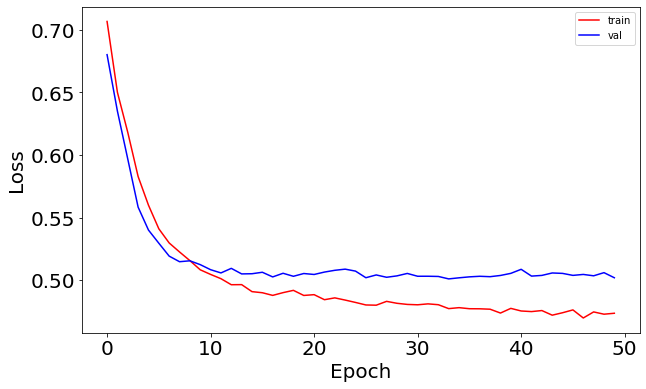

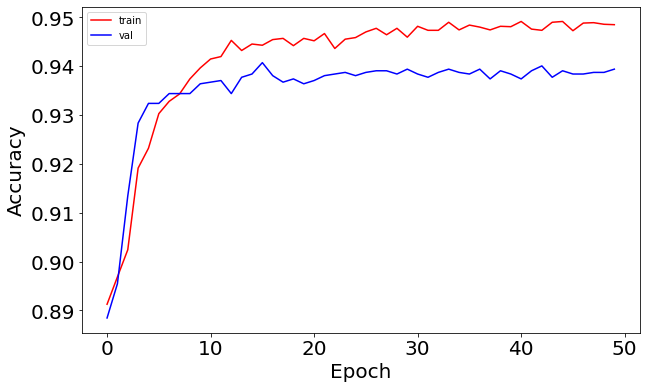

In [86]:
# Capturing learning history per epoch
hist  = pd.DataFrame(nn_1.history)
hist['epoch'] = nn_1.epoch

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['loss']), 'r', label='train')
ax.plot(np.sqrt(hist['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['accuracy']), 'r', label='train')
ax.plot(np.sqrt(hist['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [87]:
score = modelnn.evaluate(X_test, y_test)
print(score)

63/63 [==============================] - 0s 527us/step - loss: 0.2493 - accuracy: 0.8860
[0.24927881360054016, 0.8859999775886536]


### ROC-AUC Curve Analysis

No Skill: ROC AUC=0.500
NN Model: ROC AUC=0.933


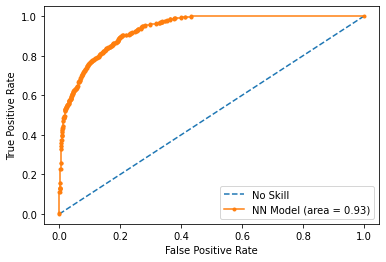

In [89]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = modelnn.predict_proba(X_test)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NN Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='NN Model (area = %0.2f)' % lr_auc)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

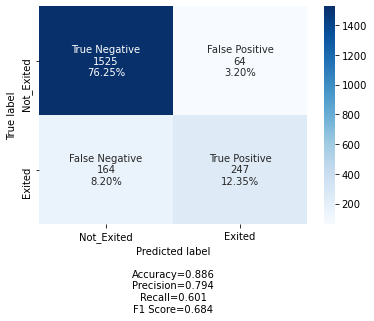

In [129]:
y_pred1 = modelnn.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**
    
The initial GridSearch yielded hyper parameters that generated a improved Accuracy score.

The Recall performance is also good.

Notably, the ration of FP to TP has improved.

However, the rate at which the model is generating False Negatives has worsened by ~100%.

This is not neccesarily bad, but it is something we should make note of.

We will GridSearch tune the early stopping model next.

### GridSearch with EarlyStopping

In [90]:
%%time

es= keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=15, 
                             verbose=0, mode='min', restore_best_weights= True)


model_init_batch_epoch_CV = KerasClassifier(build_fn=create_model, verbose=1)
batches = [50, 100, 150]
epochs = [50, 100, 150]
optimizers = ['rmsprop', 'adam']

# grid search for initializer, batch size and number of epochs
param_grid = dict(epochs=epochs, batch_size=batches, optimizer=optimizers, neurons=neurons)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, 
                    param_grid=param_grid,
                    cv=3)
grid_result = grid.fit(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=True, verbose=1)

Epoch 1/50
86/86 [==============================] - 1s 3ms/step - loss: 0.5766 - accuracy: 0.6974 - val_loss: 0.3994 - val_accuracy: 0.8060
Epoch 2/50
86/86 [==============================] - 0s 669us/step - loss: 0.3832 - accuracy: 0.8234 - val_loss: 0.3280 - val_accuracy: 0.8529
Epoch 3/50
86/86 [==============================] - 0s 657us/step - loss: 0.3310 - accuracy: 0.8453 - val_loss: 0.2913 - val_accuracy: 0.8660
Epoch 4/50
86/86 [==============================] - 0s 669us/step - loss: 0.2867 - accuracy: 0.8712 - val_loss: 0.2731 - val_accuracy: 0.8754
Epoch 5/50
86/86 [==============================] - 0s 664us/step - loss: 0.2690 - accuracy: 0.8792 - val_loss: 0.2688 - val_accuracy: 0.8716
Epoch 6/50
86/86 [==============================] - 0s 671us/step - loss: 0.2710 - accuracy: 0.8777 - val_loss: 0.2664 - val_accuracy: 0.8735
Epoch 7/50
86/86 [==============================] - 0s 657us/step - loss: 0.2673 - accuracy: 0.8774 - val_loss: 0.2636 - val_accuracy: 0.8716
Epoch 8/

Epoch 20/50
86/86 [==============================] - 0s 645us/step - loss: 0.2363 - accuracy: 0.8921 - val_loss: 0.2539 - val_accuracy: 0.8800
Epoch 21/50
86/86 [==============================] - 0s 657us/step - loss: 0.2255 - accuracy: 0.8952 - val_loss: 0.2538 - val_accuracy: 0.8810
Epoch 22/50
86/86 [==============================] - 0s 669us/step - loss: 0.2278 - accuracy: 0.8935 - val_loss: 0.2559 - val_accuracy: 0.8782
Epoch 23/50
86/86 [==============================] - 0s 657us/step - loss: 0.2203 - accuracy: 0.8983 - val_loss: 0.2574 - val_accuracy: 0.8763
Epoch 24/50
86/86 [==============================] - 0s 669us/step - loss: 0.2240 - accuracy: 0.8982 - val_loss: 0.2522 - val_accuracy: 0.8800
Epoch 25/50
86/86 [==============================] - 0s 657us/step - loss: 0.2319 - accuracy: 0.8909 - val_loss: 0.2517 - val_accuracy: 0.8810
Epoch 26/50
86/86 [==============================] - 0s 669us/step - loss: 0.2131 - accuracy: 0.9038 - val_loss: 0.2533 - val_accuracy: 0.8800

86/86 [==============================] - 1s 3ms/step - loss: 0.5826 - accuracy: 0.7685 - val_loss: 0.4417 - val_accuracy: 0.7957
Epoch 2/50
86/86 [==============================] - 0s 681us/step - loss: 0.4134 - accuracy: 0.8021 - val_loss: 0.3484 - val_accuracy: 0.8463
Epoch 3/50
86/86 [==============================] - 0s 669us/step - loss: 0.3412 - accuracy: 0.8466 - val_loss: 0.3060 - val_accuracy: 0.8669
Epoch 4/50
86/86 [==============================] - 0s 657us/step - loss: 0.2838 - accuracy: 0.8802 - val_loss: 0.2858 - val_accuracy: 0.8697
Epoch 5/50
86/86 [==============================] - 0s 669us/step - loss: 0.2715 - accuracy: 0.8814 - val_loss: 0.2759 - val_accuracy: 0.8725
Epoch 6/50
86/86 [==============================] - 0s 669us/step - loss: 0.2581 - accuracy: 0.8874 - val_loss: 0.2664 - val_accuracy: 0.8754
Epoch 7/50
86/86 [==============================] - 0s 669us/step - loss: 0.2481 - accuracy: 0.8948 - val_loss: 0.2652 - val_accuracy: 0.8763
Epoch 8/50
86/86 [=

Epoch 25/50
86/86 [==============================] - 0s 669us/step - loss: 0.2247 - accuracy: 0.8984 - val_loss: 0.2509 - val_accuracy: 0.8800
Epoch 26/50
86/86 [==============================] - 0s 669us/step - loss: 0.2278 - accuracy: 0.8969 - val_loss: 0.2497 - val_accuracy: 0.8791
Epoch 27/50
86/86 [==============================] - 0s 657us/step - loss: 0.2233 - accuracy: 0.9003 - val_loss: 0.2523 - val_accuracy: 0.8782
Epoch 28/50
86/86 [==============================] - 0s 657us/step - loss: 0.2316 - accuracy: 0.8975 - val_loss: 0.2479 - val_accuracy: 0.8828
Epoch 29/50
86/86 [==============================] - 0s 657us/step - loss: 0.2251 - accuracy: 0.8979 - val_loss: 0.2488 - val_accuracy: 0.8810
Epoch 30/50
86/86 [==============================] - 0s 657us/step - loss: 0.2191 - accuracy: 0.9067 - val_loss: 0.2548 - val_accuracy: 0.8782
Epoch 31/50
86/86 [==============================] - 0s 657us/step - loss: 0.2269 - accuracy: 0.9028 - val_loss: 0.2513 - val_accuracy: 0.8828

Epoch 7/50
86/86 [==============================] - 0s 645us/step - loss: 0.2691 - accuracy: 0.8764 - val_loss: 0.2651 - val_accuracy: 0.8716
Epoch 8/50
86/86 [==============================] - 0s 669us/step - loss: 0.2749 - accuracy: 0.8760 - val_loss: 0.2616 - val_accuracy: 0.8744
Epoch 9/50
86/86 [==============================] - 0s 657us/step - loss: 0.2523 - accuracy: 0.8907 - val_loss: 0.2638 - val_accuracy: 0.8763
Epoch 10/50
86/86 [==============================] - 0s 657us/step - loss: 0.2437 - accuracy: 0.8931 - val_loss: 0.2616 - val_accuracy: 0.8744
Epoch 11/50
86/86 [==============================] - 0s 657us/step - loss: 0.2489 - accuracy: 0.8842 - val_loss: 0.2648 - val_accuracy: 0.8782
Epoch 12/50
86/86 [==============================] - 0s 657us/step - loss: 0.2391 - accuracy: 0.8918 - val_loss: 0.2579 - val_accuracy: 0.8754
Epoch 13/50
86/86 [==============================] - 0s 657us/step - loss: 0.2420 - accuracy: 0.8925 - val_loss: 0.2599 - val_accuracy: 0.8725
Ep

Epoch 37/50
86/86 [==============================] - 0s 645us/step - loss: 0.2270 - accuracy: 0.8958 - val_loss: 0.2532 - val_accuracy: 0.8819
Epoch 38/50
86/86 [==============================] - 0s 645us/step - loss: 0.2079 - accuracy: 0.9090 - val_loss: 0.2519 - val_accuracy: 0.8819
Epoch 39/50
86/86 [==============================] - 0s 657us/step - loss: 0.2160 - accuracy: 0.9077 - val_loss: 0.2508 - val_accuracy: 0.8838
Epoch 40/50
86/86 [==============================] - 0s 651us/step - loss: 0.2172 - accuracy: 0.9040 - val_loss: 0.2564 - val_accuracy: 0.8800
Epoch 41/50
86/86 [==============================] - 0s 662us/step - loss: 0.2120 - accuracy: 0.9046 - val_loss: 0.2521 - val_accuracy: 0.8810
Epoch 42/50
54/54 [==============================] - 0s 339us/step - loss: 0.2426 - accuracy: 0.8905
Epoch 1/50
86/86 [==============================] - 1s 3ms/step - loss: 0.5567 - accuracy: 0.7503 - val_loss: 0.4407 - val_accuracy: 0.7985
Epoch 2/50
86/86 [==========================

86/86 [==============================] - 0s 669us/step - loss: 0.2248 - accuracy: 0.9042 - val_loss: 0.2542 - val_accuracy: 0.8828
Epoch 18/50
86/86 [==============================] - 0s 669us/step - loss: 0.2298 - accuracy: 0.8958 - val_loss: 0.2495 - val_accuracy: 0.8791
Epoch 19/50
86/86 [==============================] - 0s 657us/step - loss: 0.2195 - accuracy: 0.9037 - val_loss: 0.2564 - val_accuracy: 0.8847
Epoch 20/50
86/86 [==============================] - 0s 669us/step - loss: 0.2285 - accuracy: 0.8982 - val_loss: 0.2528 - val_accuracy: 0.8819
Epoch 21/50
86/86 [==============================] - 0s 657us/step - loss: 0.2069 - accuracy: 0.9133 - val_loss: 0.2604 - val_accuracy: 0.8716
Epoch 22/50
86/86 [==============================] - 0s 657us/step - loss: 0.2135 - accuracy: 0.9027 - val_loss: 0.2559 - val_accuracy: 0.8857
Epoch 23/50
86/86 [==============================] - 0s 657us/step - loss: 0.2261 - accuracy: 0.8994 - val_loss: 0.2558 - val_accuracy: 0.8763
Epoch 24/50

86/86 [==============================] - 0s 669us/step - loss: 0.2791 - accuracy: 0.8776 - val_loss: 0.2651 - val_accuracy: 0.8819
Epoch 6/50
86/86 [==============================] - 0s 657us/step - loss: 0.2680 - accuracy: 0.8831 - val_loss: 0.2544 - val_accuracy: 0.8838
Epoch 7/50
86/86 [==============================] - 0s 669us/step - loss: 0.2660 - accuracy: 0.8735 - val_loss: 0.2479 - val_accuracy: 0.8847
Epoch 8/50
86/86 [==============================] - 0s 657us/step - loss: 0.2618 - accuracy: 0.8855 - val_loss: 0.2451 - val_accuracy: 0.8913
Epoch 9/50
86/86 [==============================] - 0s 657us/step - loss: 0.2568 - accuracy: 0.8842 - val_loss: 0.2425 - val_accuracy: 0.8894
Epoch 10/50
86/86 [==============================] - 0s 669us/step - loss: 0.2619 - accuracy: 0.8857 - val_loss: 0.2403 - val_accuracy: 0.8941
Epoch 11/50
86/86 [==============================] - 0s 657us/step - loss: 0.2557 - accuracy: 0.8865 - val_loss: 0.2412 - val_accuracy: 0.8932
Epoch 12/50
86/

Epoch 18/50
86/86 [==============================] - 0s 669us/step - loss: 0.2214 - accuracy: 0.9067 - val_loss: 0.2498 - val_accuracy: 0.8875
Epoch 19/50
86/86 [==============================] - 0s 657us/step - loss: 0.2285 - accuracy: 0.8978 - val_loss: 0.2523 - val_accuracy: 0.8828
Epoch 20/50
86/86 [==============================] - 0s 669us/step - loss: 0.2340 - accuracy: 0.8976 - val_loss: 0.2493 - val_accuracy: 0.8857
Epoch 21/50
86/86 [==============================] - 0s 669us/step - loss: 0.2178 - accuracy: 0.9045 - val_loss: 0.2502 - val_accuracy: 0.8838
Epoch 22/50
86/86 [==============================] - 0s 657us/step - loss: 0.2223 - accuracy: 0.8963 - val_loss: 0.2529 - val_accuracy: 0.8819
Epoch 23/50
86/86 [==============================] - 0s 669us/step - loss: 0.2216 - accuracy: 0.9050 - val_loss: 0.2508 - val_accuracy: 0.8875
Epoch 24/50
86/86 [==============================] - 0s 669us/step - loss: 0.2191 - accuracy: 0.9020 - val_loss: 0.2513 - val_accuracy: 0.8875

54/54 [==============================] - 0s 320us/step - loss: 0.2467 - accuracy: 0.8901
Epoch 1/50
86/86 [==============================] - 1s 3ms/step - loss: 0.5958 - accuracy: 0.7131 - val_loss: 0.4595 - val_accuracy: 0.7985
Epoch 2/50
86/86 [==============================] - 0s 657us/step - loss: 0.4421 - accuracy: 0.8000 - val_loss: 0.3823 - val_accuracy: 0.8004
Epoch 3/50
86/86 [==============================] - 0s 657us/step - loss: 0.3772 - accuracy: 0.8220 - val_loss: 0.3250 - val_accuracy: 0.8463
Epoch 4/50
86/86 [==============================] - 0s 657us/step - loss: 0.3337 - accuracy: 0.8421 - val_loss: 0.2859 - val_accuracy: 0.8763
Epoch 5/50
86/86 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.94 - 0s 645us/step - loss: 0.2936 - accuracy: 0.8631 - val_loss: 0.2847 - val_accuracy: 0.8613
Epoch 6/50
86/86 [==============================] - 0s 657us/step - loss: 0.2785 - accuracy: 0.8683 - val_loss: 0.2620 - val_accuracy: 0.8800
Epoch 7/50
86/86 [=

Epoch 23/50
86/86 [==============================] - 0s 657us/step - loss: 0.2318 - accuracy: 0.8958 - val_loss: 0.2660 - val_accuracy: 0.8800
Epoch 24/50
86/86 [==============================] - 0s 657us/step - loss: 0.2243 - accuracy: 0.8991 - val_loss: 0.2557 - val_accuracy: 0.8810
Epoch 25/50
86/86 [==============================] - 0s 657us/step - loss: 0.2239 - accuracy: 0.9001 - val_loss: 0.2586 - val_accuracy: 0.8772
Epoch 26/50
86/86 [==============================] - 0s 657us/step - loss: 0.2091 - accuracy: 0.9123 - val_loss: 0.2569 - val_accuracy: 0.8800
Epoch 27/50
86/86 [==============================] - 0s 669us/step - loss: 0.2339 - accuracy: 0.8972 - val_loss: 0.2615 - val_accuracy: 0.8800
Epoch 28/50
86/86 [==============================] - 0s 669us/step - loss: 0.2200 - accuracy: 0.8989 - val_loss: 0.2581 - val_accuracy: 0.8763
Epoch 29/50
86/86 [==============================] - 0s 669us/step - loss: 0.2193 - accuracy: 0.9088 - val_loss: 0.2565 - val_accuracy: 0.8800

Epoch 32/50
86/86 [==============================] - 0s 669us/step - loss: 0.2220 - accuracy: 0.9057 - val_loss: 0.2601 - val_accuracy: 0.8791
Epoch 33/50
86/86 [==============================] - 0s 669us/step - loss: 0.2166 - accuracy: 0.9096 - val_loss: 0.2615 - val_accuracy: 0.8838
Epoch 34/50
86/86 [==============================] - 0s 657us/step - loss: 0.2117 - accuracy: 0.9087 - val_loss: 0.2597 - val_accuracy: 0.8810
Epoch 35/50
86/86 [==============================] - 0s 669us/step - loss: 0.2056 - accuracy: 0.9100 - val_loss: 0.2593 - val_accuracy: 0.8791
Epoch 36/50
86/86 [==============================] - 0s 681us/step - loss: 0.2158 - accuracy: 0.9059 - val_loss: 0.2614 - val_accuracy: 0.8819
Epoch 37/50
86/86 [==============================] - 0s 681us/step - loss: 0.2224 - accuracy: 0.9047 - val_loss: 0.2677 - val_accuracy: 0.8819
Epoch 38/50
54/54 [==============================] - 0s 338us/step - loss: 0.2484 - accuracy: 0.8834
Epoch 1/50
86/86 [=======================

Epoch 4/100
86/86 [==============================] - 0s 669us/step - loss: 0.2843 - accuracy: 0.8701 - val_loss: 0.2842 - val_accuracy: 0.8585
Epoch 5/100
86/86 [==============================] - 0s 657us/step - loss: 0.2963 - accuracy: 0.8568 - val_loss: 0.2631 - val_accuracy: 0.8735
Epoch 6/100
86/86 [==============================] - 0s 681us/step - loss: 0.2627 - accuracy: 0.8828 - val_loss: 0.2619 - val_accuracy: 0.8763
Epoch 7/100
86/86 [==============================] - 0s 669us/step - loss: 0.2516 - accuracy: 0.8864 - val_loss: 0.2558 - val_accuracy: 0.8772
Epoch 8/100
86/86 [==============================] - 0s 657us/step - loss: 0.2495 - accuracy: 0.8856 - val_loss: 0.2521 - val_accuracy: 0.8819
Epoch 9/100
86/86 [==============================] - 0s 657us/step - loss: 0.2432 - accuracy: 0.8945 - val_loss: 0.2578 - val_accuracy: 0.8669
Epoch 10/100
86/86 [==============================] - 0s 657us/step - loss: 0.2431 - accuracy: 0.8914 - val_loss: 0.2501 - val_accuracy: 0.876

Epoch 3/100
86/86 [==============================] - 0s 657us/step - loss: 0.3704 - accuracy: 0.8240 - val_loss: 0.2914 - val_accuracy: 0.8650
Epoch 4/100
86/86 [==============================] - 0s 657us/step - loss: 0.3145 - accuracy: 0.8528 - val_loss: 0.2631 - val_accuracy: 0.8810
Epoch 5/100
86/86 [==============================] - 0s 657us/step - loss: 0.2924 - accuracy: 0.8674 - val_loss: 0.2567 - val_accuracy: 0.8754
Epoch 6/100
86/86 [==============================] - 0s 657us/step - loss: 0.2814 - accuracy: 0.8726 - val_loss: 0.2508 - val_accuracy: 0.8800
Epoch 7/100
86/86 [==============================] - 0s 657us/step - loss: 0.2702 - accuracy: 0.8710 - val_loss: 0.2453 - val_accuracy: 0.8857
Epoch 8/100
86/86 [==============================] - 0s 657us/step - loss: 0.2586 - accuracy: 0.8836 - val_loss: 0.2400 - val_accuracy: 0.8941
Epoch 9/100
86/86 [==============================] - 0s 657us/step - loss: 0.2482 - accuracy: 0.8903 - val_loss: 0.2401 - val_accuracy: 0.8903

86/86 [==============================] - 0s 657us/step - loss: 0.2154 - accuracy: 0.9107 - val_loss: 0.2540 - val_accuracy: 0.8782
Epoch 25/100
86/86 [==============================] - 0s 657us/step - loss: 0.2266 - accuracy: 0.8974 - val_loss: 0.2567 - val_accuracy: 0.8782
Epoch 26/100
86/86 [==============================] - 0s 657us/step - loss: 0.2228 - accuracy: 0.8967 - val_loss: 0.2545 - val_accuracy: 0.8810
Epoch 27/100
86/86 [==============================] - 0s 657us/step - loss: 0.2141 - accuracy: 0.9091 - val_loss: 0.2545 - val_accuracy: 0.8782
Epoch 28/100
54/54 [==============================] - 0s 339us/step - loss: 0.2480 - accuracy: 0.8868
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.5332 - accuracy: 0.8028 - val_loss: 0.4493 - val_accuracy: 0.7957
Epoch 2/100
86/86 [==============================] - 0s 669us/step - loss: 0.4203 - accuracy: 0.8059 - val_loss: 0.3773 - val_accuracy: 0.8229
Epoch 3/100
86/86 [==============================] 

Epoch 7/100
86/86 [==============================] - 0s 657us/step - loss: 0.2631 - accuracy: 0.8839 - val_loss: 0.2517 - val_accuracy: 0.8903
Epoch 8/100
86/86 [==============================] - 0s 657us/step - loss: 0.2591 - accuracy: 0.8834 - val_loss: 0.2526 - val_accuracy: 0.8866
Epoch 9/100
86/86 [==============================] - 0s 657us/step - loss: 0.2600 - accuracy: 0.8879 - val_loss: 0.2465 - val_accuracy: 0.8894
Epoch 10/100
86/86 [==============================] - 0s 669us/step - loss: 0.2448 - accuracy: 0.8984 - val_loss: 0.2460 - val_accuracy: 0.8932
Epoch 11/100
86/86 [==============================] - 0s 669us/step - loss: 0.2517 - accuracy: 0.8936 - val_loss: 0.2445 - val_accuracy: 0.8913
Epoch 12/100
86/86 [==============================] - 0s 657us/step - loss: 0.2327 - accuracy: 0.8966 - val_loss: 0.2411 - val_accuracy: 0.8913
Epoch 13/100
86/86 [==============================] - 0s 669us/step - loss: 0.2399 - accuracy: 0.9019 - val_loss: 0.2428 - val_accuracy: 0.

86/86 [==============================] - 0s 645us/step - loss: 0.2198 - accuracy: 0.9045 - val_loss: 0.2577 - val_accuracy: 0.8800
Epoch 28/100
86/86 [==============================] - 0s 657us/step - loss: 0.2191 - accuracy: 0.9016 - val_loss: 0.2517 - val_accuracy: 0.8847
Epoch 29/100
86/86 [==============================] - 0s 657us/step - loss: 0.2251 - accuracy: 0.8963 - val_loss: 0.2603 - val_accuracy: 0.8819
Epoch 30/100
86/86 [==============================] - 0s 657us/step - loss: 0.2174 - accuracy: 0.9105 - val_loss: 0.2548 - val_accuracy: 0.8800
Epoch 31/100
86/86 [==============================] - 0s 669us/step - loss: 0.2193 - accuracy: 0.9015 - val_loss: 0.2603 - val_accuracy: 0.8791
Epoch 32/100
86/86 [==============================] - 0s 657us/step - loss: 0.2106 - accuracy: 0.9053 - val_loss: 0.2609 - val_accuracy: 0.8847
Epoch 33/100
86/86 [==============================] - 0s 669us/step - loss: 0.2198 - accuracy: 0.9039 - val_loss: 0.2585 - val_accuracy: 0.8800
Epoch

Epoch 2/100
86/86 [==============================] - 0s 657us/step - loss: 0.4097 - accuracy: 0.8013 - val_loss: 0.3344 - val_accuracy: 0.8557
Epoch 3/100
86/86 [==============================] - 0s 669us/step - loss: 0.3476 - accuracy: 0.8362 - val_loss: 0.2975 - val_accuracy: 0.8613
Epoch 4/100
86/86 [==============================] - 0s 657us/step - loss: 0.3101 - accuracy: 0.8550 - val_loss: 0.2787 - val_accuracy: 0.8622
Epoch 5/100
86/86 [==============================] - 0s 662us/step - loss: 0.2837 - accuracy: 0.8763 - val_loss: 0.2707 - val_accuracy: 0.8669
Epoch 6/100
86/86 [==============================] - 0s 669us/step - loss: 0.2730 - accuracy: 0.8820 - val_loss: 0.2608 - val_accuracy: 0.8725
Epoch 7/100
86/86 [==============================] - 0s 657us/step - loss: 0.2709 - accuracy: 0.8829 - val_loss: 0.2584 - val_accuracy: 0.8819
Epoch 8/100
86/86 [==============================] - 0s 645us/step - loss: 0.2574 - accuracy: 0.8875 - val_loss: 0.2568 - val_accuracy: 0.8810

86/86 [==============================] - 0s 657us/step - loss: 0.2655 - accuracy: 0.8866 - val_loss: 0.2630 - val_accuracy: 0.8819
Epoch 7/100
86/86 [==============================] - 0s 657us/step - loss: 0.2555 - accuracy: 0.8872 - val_loss: 0.2549 - val_accuracy: 0.8800
Epoch 8/100
86/86 [==============================] - 0s 657us/step - loss: 0.2644 - accuracy: 0.8814 - val_loss: 0.2551 - val_accuracy: 0.8763
Epoch 9/100
86/86 [==============================] - 0s 657us/step - loss: 0.2505 - accuracy: 0.8897 - val_loss: 0.2526 - val_accuracy: 0.8810
Epoch 10/100
86/86 [==============================] - 0s 657us/step - loss: 0.2510 - accuracy: 0.8810 - val_loss: 0.2551 - val_accuracy: 0.8725
Epoch 11/100
86/86 [==============================] - 0s 645us/step - loss: 0.2386 - accuracy: 0.8992 - val_loss: 0.2540 - val_accuracy: 0.8754
Epoch 12/100
86/86 [==============================] - 0s 657us/step - loss: 0.2393 - accuracy: 0.8920 - val_loss: 0.2528 - val_accuracy: 0.8782
Epoch 13

86/86 [==============================] - 0s 645us/step - loss: 0.2212 - accuracy: 0.8989 - val_loss: 0.2659 - val_accuracy: 0.8772
Epoch 34/100
86/86 [==============================] - 0s 645us/step - loss: 0.2094 - accuracy: 0.9055 - val_loss: 0.2707 - val_accuracy: 0.8725
Epoch 35/100
86/86 [==============================] - 0s 645us/step - loss: 0.2071 - accuracy: 0.9097 - val_loss: 0.2739 - val_accuracy: 0.8763
Epoch 36/100
86/86 [==============================] - 0s 657us/step - loss: 0.2183 - accuracy: 0.9023 - val_loss: 0.2658 - val_accuracy: 0.8697
Epoch 37/100
54/54 [==============================] - 0s 320us/step - loss: 0.2470 - accuracy: 0.8879
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.5459 - accuracy: 0.7872 - val_loss: 0.3783 - val_accuracy: 0.8247
Epoch 2/100
86/86 [==============================] - 0s 704us/step - loss: 0.3976 - accuracy: 0.8282 - val_loss: 0.3011 - val_accuracy: 0.8669
Epoch 3/100
86/86 [==============================] 

Epoch 17/100
86/86 [==============================] - 0s 669us/step - loss: 0.2414 - accuracy: 0.8944 - val_loss: 0.2547 - val_accuracy: 0.8782
Epoch 18/100
86/86 [==============================] - 0s 669us/step - loss: 0.2464 - accuracy: 0.8935 - val_loss: 0.2579 - val_accuracy: 0.8800
Epoch 19/100
86/86 [==============================] - 0s 645us/step - loss: 0.2375 - accuracy: 0.8965 - val_loss: 0.2551 - val_accuracy: 0.8782
Epoch 20/100
86/86 [==============================] - 0s 657us/step - loss: 0.2255 - accuracy: 0.9026 - val_loss: 0.2522 - val_accuracy: 0.8782
Epoch 21/100
86/86 [==============================] - 0s 657us/step - loss: 0.2141 - accuracy: 0.9095 - val_loss: 0.2536 - val_accuracy: 0.8782
Epoch 22/100
86/86 [==============================] - 0s 669us/step - loss: 0.2207 - accuracy: 0.9088 - val_loss: 0.2558 - val_accuracy: 0.8763
Epoch 23/100
86/86 [==============================] - 0s 657us/step - loss: 0.2253 - accuracy: 0.9038 - val_loss: 0.2544 - val_accuracy:

Epoch 6/100
86/86 [==============================] - 0s 634us/step - loss: 0.2737 - accuracy: 0.8775 - val_loss: 0.2550 - val_accuracy: 0.8754
Epoch 7/100
86/86 [==============================] - 0s 645us/step - loss: 0.2575 - accuracy: 0.8776 - val_loss: 0.2504 - val_accuracy: 0.8800
Epoch 8/100
86/86 [==============================] - 0s 4ms/step - loss: 0.2627 - accuracy: 0.8831 - val_loss: 0.2479 - val_accuracy: 0.8800
Epoch 9/100
86/86 [==============================] - 0s 680us/step - loss: 0.2570 - accuracy: 0.8875 - val_loss: 0.2476 - val_accuracy: 0.8810
Epoch 10/100
86/86 [==============================] - 0s 645us/step - loss: 0.2456 - accuracy: 0.8883 - val_loss: 0.2474 - val_accuracy: 0.8782
Epoch 11/100
86/86 [==============================] - 0s 645us/step - loss: 0.2468 - accuracy: 0.8925 - val_loss: 0.2476 - val_accuracy: 0.8857
Epoch 12/100
86/86 [==============================] - 0s 657us/step - loss: 0.2426 - accuracy: 0.8906 - val_loss: 0.2475 - val_accuracy: 0.883

54/54 [==============================] - 0s 339us/step - loss: 0.2479 - accuracy: 0.8886
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.5849 - accuracy: 0.7729 - val_loss: 0.4567 - val_accuracy: 0.7957
Epoch 2/100
86/86 [==============================] - 0s 634us/step - loss: 0.4259 - accuracy: 0.8082 - val_loss: 0.3835 - val_accuracy: 0.8144
Epoch 3/100
86/86 [==============================] - 0s 634us/step - loss: 0.3635 - accuracy: 0.8385 - val_loss: 0.3346 - val_accuracy: 0.8379
Epoch 4/100
86/86 [==============================] - 0s 634us/step - loss: 0.3124 - accuracy: 0.8618 - val_loss: 0.2974 - val_accuracy: 0.8632
Epoch 5/100
86/86 [==============================] - 0s 645us/step - loss: 0.2903 - accuracy: 0.8751 - val_loss: 0.2929 - val_accuracy: 0.8650
Epoch 6/100
86/86 [==============================] - 0s 634us/step - loss: 0.2723 - accuracy: 0.8787 - val_loss: 0.2774 - val_accuracy: 0.8763
Epoch 7/100
86/86 [==============================] - 0s

Epoch 28/100
86/86 [==============================] - 0s 634us/step - loss: 0.2327 - accuracy: 0.8987 - val_loss: 0.2436 - val_accuracy: 0.8922
Epoch 29/100
86/86 [==============================] - 0s 634us/step - loss: 0.2228 - accuracy: 0.9065 - val_loss: 0.2414 - val_accuracy: 0.8894
Epoch 30/100
86/86 [==============================] - 0s 634us/step - loss: 0.2328 - accuracy: 0.8943 - val_loss: 0.2447 - val_accuracy: 0.8894
Epoch 31/100
54/54 [==============================] - 0s 339us/step - loss: 0.2367 - accuracy: 0.8905
Epoch 1/150
86/86 [==============================] - 1s 3ms/step - loss: 0.5508 - accuracy: 0.7741 - val_loss: 0.4342 - val_accuracy: 0.7966
Epoch 2/150
86/86 [==============================] - 0s 657us/step - loss: 0.4239 - accuracy: 0.8070 - val_loss: 0.3487 - val_accuracy: 0.8529
Epoch 3/150
86/86 [==============================] - 0s 645us/step - loss: 0.3356 - accuracy: 0.8503 - val_loss: 0.2990 - val_accuracy: 0.8604
Epoch 4/150
86/86 [====================

Epoch 27/150
86/86 [==============================] - 0s 657us/step - loss: 0.2183 - accuracy: 0.8992 - val_loss: 0.2501 - val_accuracy: 0.8763
Epoch 28/150
86/86 [==============================] - 0s 634us/step - loss: 0.2267 - accuracy: 0.8990 - val_loss: 0.2561 - val_accuracy: 0.8744
Epoch 29/150
86/86 [==============================] - 0s 657us/step - loss: 0.2038 - accuracy: 0.9120 - val_loss: 0.2514 - val_accuracy: 0.8782
Epoch 30/150
86/86 [==============================] - 0s 634us/step - loss: 0.2259 - accuracy: 0.9052 - val_loss: 0.2524 - val_accuracy: 0.8754
Epoch 31/150
86/86 [==============================] - 0s 645us/step - loss: 0.2246 - accuracy: 0.8987 - val_loss: 0.2543 - val_accuracy: 0.8763
Epoch 32/150
86/86 [==============================] - 0s 645us/step - loss: 0.2136 - accuracy: 0.8990 - val_loss: 0.2566 - val_accuracy: 0.8660
Epoch 33/150
86/86 [==============================] - 0s 645us/step - loss: 0.2231 - accuracy: 0.9079 - val_loss: 0.2536 - val_accuracy:

Epoch 3/150
86/86 [==============================] - 0s 657us/step - loss: 0.3495 - accuracy: 0.8489 - val_loss: 0.3058 - val_accuracy: 0.8557
Epoch 4/150
86/86 [==============================] - 0s 657us/step - loss: 0.2992 - accuracy: 0.8724 - val_loss: 0.2889 - val_accuracy: 0.8491
Epoch 5/150
86/86 [==============================] - 0s 657us/step - loss: 0.2885 - accuracy: 0.8656 - val_loss: 0.2773 - val_accuracy: 0.8613
Epoch 6/150
86/86 [==============================] - 0s 657us/step - loss: 0.2541 - accuracy: 0.8857 - val_loss: 0.2643 - val_accuracy: 0.8641
Epoch 7/150
86/86 [==============================] - 0s 657us/step - loss: 0.2555 - accuracy: 0.8832 - val_loss: 0.2652 - val_accuracy: 0.8669
Epoch 8/150
86/86 [==============================] - 0s 669us/step - loss: 0.2536 - accuracy: 0.8913 - val_loss: 0.2592 - val_accuracy: 0.8744
Epoch 9/150
86/86 [==============================] - 0s 645us/step - loss: 0.2507 - accuracy: 0.8913 - val_loss: 0.2610 - val_accuracy: 0.8763

86/86 [==============================] - 0s 657us/step - loss: 0.2399 - accuracy: 0.8917 - val_loss: 0.2582 - val_accuracy: 0.8725
Epoch 18/150
86/86 [==============================] - 0s 657us/step - loss: 0.2358 - accuracy: 0.8945 - val_loss: 0.2579 - val_accuracy: 0.8725
Epoch 19/150
86/86 [==============================] - 0s 657us/step - loss: 0.2312 - accuracy: 0.8970 - val_loss: 0.2563 - val_accuracy: 0.8763
Epoch 20/150
86/86 [==============================] - 0s 645us/step - loss: 0.2377 - accuracy: 0.8899 - val_loss: 0.2570 - val_accuracy: 0.8716
Epoch 21/150
86/86 [==============================] - 0s 669us/step - loss: 0.2112 - accuracy: 0.9073 - val_loss: 0.2560 - val_accuracy: 0.8725
Epoch 22/150
86/86 [==============================] - 0s 657us/step - loss: 0.2254 - accuracy: 0.9047 - val_loss: 0.2582 - val_accuracy: 0.8791
Epoch 23/150
86/86 [==============================] - 0s 640us/step - loss: 0.2255 - accuracy: 0.8999 - val_loss: 0.2619 - val_accuracy: 0.8707
Epoch

Epoch 18/150
86/86 [==============================] - 0s 645us/step - loss: 0.2396 - accuracy: 0.8922 - val_loss: 0.2573 - val_accuracy: 0.8838
Epoch 19/150
86/86 [==============================] - 0s 657us/step - loss: 0.2234 - accuracy: 0.9026 - val_loss: 0.2567 - val_accuracy: 0.8800
Epoch 20/150
86/86 [==============================] - 0s 634us/step - loss: 0.2269 - accuracy: 0.9044 - val_loss: 0.2603 - val_accuracy: 0.8875
Epoch 21/150
86/86 [==============================] - 0s 645us/step - loss: 0.2352 - accuracy: 0.8957 - val_loss: 0.2566 - val_accuracy: 0.8857
Epoch 22/150
86/86 [==============================] - 0s 645us/step - loss: 0.2319 - accuracy: 0.8943 - val_loss: 0.2599 - val_accuracy: 0.8810
Epoch 23/150
86/86 [==============================] - 0s 645us/step - loss: 0.2257 - accuracy: 0.9024 - val_loss: 0.2582 - val_accuracy: 0.8838
Epoch 24/150
86/86 [==============================] - 0s 645us/step - loss: 0.2191 - accuracy: 0.9029 - val_loss: 0.2609 - val_accuracy:

Epoch 8/150
86/86 [==============================] - 0s 657us/step - loss: 0.2551 - accuracy: 0.8925 - val_loss: 0.2509 - val_accuracy: 0.8828
Epoch 9/150
86/86 [==============================] - 0s 645us/step - loss: 0.2534 - accuracy: 0.8886 - val_loss: 0.2491 - val_accuracy: 0.8782
Epoch 10/150
86/86 [==============================] - 0s 645us/step - loss: 0.2378 - accuracy: 0.8978 - val_loss: 0.2471 - val_accuracy: 0.8819
Epoch 11/150
86/86 [==============================] - 0s 657us/step - loss: 0.2304 - accuracy: 0.9015 - val_loss: 0.2478 - val_accuracy: 0.8857
Epoch 12/150
86/86 [==============================] - 0s 645us/step - loss: 0.2362 - accuracy: 0.8976 - val_loss: 0.2463 - val_accuracy: 0.8810
Epoch 13/150
86/86 [==============================] - 0s 657us/step - loss: 0.2323 - accuracy: 0.9012 - val_loss: 0.2454 - val_accuracy: 0.8819
Epoch 14/150
86/86 [==============================] - 0s 657us/step - loss: 0.2276 - accuracy: 0.9039 - val_loss: 0.2550 - val_accuracy: 0

86/86 [==============================] - 0s 657us/step - loss: 0.2147 - accuracy: 0.9036 - val_loss: 0.2522 - val_accuracy: 0.8838
Epoch 30/150
86/86 [==============================] - 0s 657us/step - loss: 0.2163 - accuracy: 0.9060 - val_loss: 0.2514 - val_accuracy: 0.8857
Epoch 31/150
86/86 [==============================] - 0s 645us/step - loss: 0.2152 - accuracy: 0.9055 - val_loss: 0.2550 - val_accuracy: 0.8847
Epoch 32/150
86/86 [==============================] - 0s 657us/step - loss: 0.2144 - accuracy: 0.9061 - val_loss: 0.2573 - val_accuracy: 0.8847
Epoch 33/150
86/86 [==============================] - 0s 645us/step - loss: 0.2331 - accuracy: 0.8979 - val_loss: 0.2540 - val_accuracy: 0.8800
Epoch 34/150
86/86 [==============================] - 0s 645us/step - loss: 0.2184 - accuracy: 0.9022 - val_loss: 0.2518 - val_accuracy: 0.8800
Epoch 35/150
86/86 [==============================] - 0s 645us/step - loss: 0.2122 - accuracy: 0.9069 - val_loss: 0.2496 - val_accuracy: 0.8847
Epoch

86/86 [==============================] - 0s 657us/step - loss: 0.2168 - accuracy: 0.9060 - val_loss: 0.2611 - val_accuracy: 0.8744
Epoch 33/150
86/86 [==============================] - 0s 657us/step - loss: 0.2198 - accuracy: 0.9087 - val_loss: 0.2666 - val_accuracy: 0.8725
Epoch 34/150
86/86 [==============================] - 0s 657us/step - loss: 0.2238 - accuracy: 0.8996 - val_loss: 0.2595 - val_accuracy: 0.8735
Epoch 35/150
86/86 [==============================] - 0s 657us/step - loss: 0.2107 - accuracy: 0.9057 - val_loss: 0.2620 - val_accuracy: 0.8744
Epoch 36/150
86/86 [==============================] - 0s 669us/step - loss: 0.2006 - accuracy: 0.9152 - val_loss: 0.2607 - val_accuracy: 0.8688
Epoch 37/150
86/86 [==============================] - 0s 657us/step - loss: 0.2201 - accuracy: 0.9062 - val_loss: 0.2589 - val_accuracy: 0.8688
Epoch 38/150
86/86 [==============================] - 0s 657us/step - loss: 0.2064 - accuracy: 0.9076 - val_loss: 0.2633 - val_accuracy: 0.8707
Epoch

Epoch 4/150
86/86 [==============================] - 0s 645us/step - loss: 0.3229 - accuracy: 0.8520 - val_loss: 0.3009 - val_accuracy: 0.8538
Epoch 5/150
86/86 [==============================] - 0s 645us/step - loss: 0.3056 - accuracy: 0.8618 - val_loss: 0.2921 - val_accuracy: 0.8575
Epoch 6/150
86/86 [==============================] - 0s 645us/step - loss: 0.2795 - accuracy: 0.8681 - val_loss: 0.2909 - val_accuracy: 0.8632
Epoch 7/150
86/86 [==============================] - 0s 657us/step - loss: 0.2795 - accuracy: 0.8721 - val_loss: 0.2797 - val_accuracy: 0.8679
Epoch 8/150
86/86 [==============================] - 0s 657us/step - loss: 0.2732 - accuracy: 0.8781 - val_loss: 0.2798 - val_accuracy: 0.8679
Epoch 9/150
86/86 [==============================] - 0s 645us/step - loss: 0.2479 - accuracy: 0.8905 - val_loss: 0.2687 - val_accuracy: 0.8744
Epoch 10/150
86/86 [==============================] - 0s 645us/step - loss: 0.2605 - accuracy: 0.8869 - val_loss: 0.2643 - val_accuracy: 0.878

54/54 [==============================] - 0s 319us/step - loss: 0.2480 - accuracy: 0.8898
Epoch 1/150
86/86 [==============================] - 1s 3ms/step - loss: 0.5106 - accuracy: 0.7911 - val_loss: 0.3916 - val_accuracy: 0.8201
Epoch 2/150
86/86 [==============================] - 0s 657us/step - loss: 0.3983 - accuracy: 0.8042 - val_loss: 0.3203 - val_accuracy: 0.8575
Epoch 3/150
86/86 [==============================] - 0s 669us/step - loss: 0.3235 - accuracy: 0.8638 - val_loss: 0.2719 - val_accuracy: 0.8763
Epoch 4/150
86/86 [==============================] - 0s 657us/step - loss: 0.2865 - accuracy: 0.8700 - val_loss: 0.2549 - val_accuracy: 0.8847
Epoch 5/150
86/86 [==============================] - 0s 657us/step - loss: 0.2670 - accuracy: 0.8795 - val_loss: 0.2586 - val_accuracy: 0.8847
Epoch 6/150
86/86 [==============================] - 0s 645us/step - loss: 0.2572 - accuracy: 0.8893 - val_loss: 0.2500 - val_accuracy: 0.8894
Epoch 7/150
86/86 [==============================] - 0s

86/86 [==============================] - 0s 646us/step - loss: 0.2308 - accuracy: 0.8981 - val_loss: 0.2596 - val_accuracy: 0.8791
Epoch 19/150
86/86 [==============================] - 0s 645us/step - loss: 0.2459 - accuracy: 0.8946 - val_loss: 0.2665 - val_accuracy: 0.8782
Epoch 20/150
86/86 [==============================] - 0s 634us/step - loss: 0.2310 - accuracy: 0.8973 - val_loss: 0.2630 - val_accuracy: 0.8847
Epoch 21/150
86/86 [==============================] - 0s 645us/step - loss: 0.2214 - accuracy: 0.9054 - val_loss: 0.2597 - val_accuracy: 0.8782
Epoch 22/150
86/86 [==============================] - 0s 645us/step - loss: 0.2486 - accuracy: 0.8905 - val_loss: 0.2626 - val_accuracy: 0.8735
Epoch 23/150
86/86 [==============================] - 0s 657us/step - loss: 0.2245 - accuracy: 0.9036 - val_loss: 0.2597 - val_accuracy: 0.8763
Epoch 24/150
86/86 [==============================] - 0s 645us/step - loss: 0.2180 - accuracy: 0.9084 - val_loss: 0.2609 - val_accuracy: 0.8763
Epoch

86/86 [==============================] - 0s 669us/step - loss: 0.2058 - accuracy: 0.9078 - val_loss: 0.2551 - val_accuracy: 0.8791
Epoch 45/150
86/86 [==============================] - 0s 657us/step - loss: 0.1963 - accuracy: 0.9199 - val_loss: 0.2564 - val_accuracy: 0.8725
Epoch 46/150
54/54 [==============================] - 0s 339us/step - loss: 0.2461 - accuracy: 0.8853
Epoch 1/150
86/86 [==============================] - 1s 6ms/step - loss: 0.5482 - accuracy: 0.7632 - val_loss: 0.4544 - val_accuracy: 0.7985
Epoch 2/150
86/86 [==============================] - 0s 657us/step - loss: 0.4451 - accuracy: 0.8013 - val_loss: 0.3987 - val_accuracy: 0.8229
Epoch 3/150
86/86 [==============================] - 0s 657us/step - loss: 0.3918 - accuracy: 0.8219 - val_loss: 0.3352 - val_accuracy: 0.8566
Epoch 4/150
86/86 [==============================] - 0s 657us/step - loss: 0.3395 - accuracy: 0.8507 - val_loss: 0.2888 - val_accuracy: 0.8772
Epoch 5/150
86/86 [==============================] - 

Epoch 14/50
43/43 [==============================] - 0s 819us/step - loss: 0.2425 - accuracy: 0.8937 - val_loss: 0.2534 - val_accuracy: 0.8819
Epoch 15/50
43/43 [==============================] - 0s 831us/step - loss: 0.2354 - accuracy: 0.8935 - val_loss: 0.2539 - val_accuracy: 0.8866
Epoch 16/50
43/43 [==============================] - 0s 807us/step - loss: 0.2401 - accuracy: 0.8877 - val_loss: 0.2548 - val_accuracy: 0.8819
Epoch 17/50
43/43 [==============================] - 0s 807us/step - loss: 0.2371 - accuracy: 0.8901 - val_loss: 0.2543 - val_accuracy: 0.8838
Epoch 18/50
43/43 [==============================] - 0s 807us/step - loss: 0.2374 - accuracy: 0.8905 - val_loss: 0.2555 - val_accuracy: 0.8828
Epoch 19/50
43/43 [==============================] - 0s 831us/step - loss: 0.2238 - accuracy: 0.9008 - val_loss: 0.2553 - val_accuracy: 0.8810
Epoch 20/50
43/43 [==============================] - 0s 807us/step - loss: 0.2340 - accuracy: 0.8990 - val_loss: 0.2551 - val_accuracy: 0.8810

Epoch 42/50
43/43 [==============================] - 0s 807us/step - loss: 0.2239 - accuracy: 0.9026 - val_loss: 0.2676 - val_accuracy: 0.8725
Epoch 43/50
43/43 [==============================] - 0s 807us/step - loss: 0.2274 - accuracy: 0.9007 - val_loss: 0.2663 - val_accuracy: 0.8725
Epoch 44/50
43/43 [==============================] - 0s 807us/step - loss: 0.2257 - accuracy: 0.9017 - val_loss: 0.2684 - val_accuracy: 0.8707
Epoch 45/50
43/43 [==============================] - 0s 807us/step - loss: 0.2217 - accuracy: 0.9019 - val_loss: 0.2708 - val_accuracy: 0.8735
Epoch 46/50
43/43 [==============================] - 0s 807us/step - loss: 0.2031 - accuracy: 0.9080 - val_loss: 0.2680 - val_accuracy: 0.8679
Epoch 47/50
43/43 [==============================] - 0s 807us/step - loss: 0.2174 - accuracy: 0.8987 - val_loss: 0.2691 - val_accuracy: 0.8716
Epoch 48/50
43/43 [==============================] - 0s 807us/step - loss: 0.2156 - accuracy: 0.8999 - val_loss: 0.2745 - val_accuracy: 0.8679

Epoch 49/50
27/27 [==============================] - 0s 345us/step - loss: 0.2460 - accuracy: 0.8916
Epoch 1/50
43/43 [==============================] - 1s 6ms/step - loss: 0.5759 - accuracy: 0.7831 - val_loss: 0.4595 - val_accuracy: 0.7957
Epoch 2/50
43/43 [==============================] - 0s 831us/step - loss: 0.4647 - accuracy: 0.7880 - val_loss: 0.3771 - val_accuracy: 0.8172
Epoch 3/50
43/43 [==============================] - 0s 855us/step - loss: 0.3893 - accuracy: 0.8147 - val_loss: 0.3195 - val_accuracy: 0.8538
Epoch 4/50
43/43 [==============================] - 0s 831us/step - loss: 0.3235 - accuracy: 0.8482 - val_loss: 0.2913 - val_accuracy: 0.8622
Epoch 5/50
43/43 [==============================] - 0s 807us/step - loss: 0.2907 - accuracy: 0.8658 - val_loss: 0.2809 - val_accuracy: 0.8697
Epoch 6/50
43/43 [==============================] - 0s 807us/step - loss: 0.2895 - accuracy: 0.8621 - val_loss: 0.2744 - val_accuracy: 0.8669
Epoch 7/50
43/43 [==============================]

43/43 [==============================] - 0s 807us/step - loss: 0.3520 - accuracy: 0.8364 - val_loss: 0.3275 - val_accuracy: 0.8510
Epoch 6/50
43/43 [==============================] - 0s 807us/step - loss: 0.3181 - accuracy: 0.8529 - val_loss: 0.3074 - val_accuracy: 0.8585
Epoch 7/50
43/43 [==============================] - 0s 807us/step - loss: 0.3074 - accuracy: 0.8559 - val_loss: 0.2912 - val_accuracy: 0.8688
Epoch 8/50
43/43 [==============================] - 0s 831us/step - loss: 0.2790 - accuracy: 0.8763 - val_loss: 0.2824 - val_accuracy: 0.8716
Epoch 9/50
43/43 [==============================] - 0s 831us/step - loss: 0.2710 - accuracy: 0.8854 - val_loss: 0.2730 - val_accuracy: 0.8782
Epoch 10/50
43/43 [==============================] - 0s 807us/step - loss: 0.2700 - accuracy: 0.8830 - val_loss: 0.2643 - val_accuracy: 0.8810
Epoch 11/50
43/43 [==============================] - 0s 807us/step - loss: 0.2450 - accuracy: 0.8960 - val_loss: 0.2600 - val_accuracy: 0.8828
Epoch 12/50
43/

Epoch 16/50
43/43 [==============================] - 0s 807us/step - loss: 0.2391 - accuracy: 0.8944 - val_loss: 0.2450 - val_accuracy: 0.8950
Epoch 17/50
43/43 [==============================] - 0s 807us/step - loss: 0.2461 - accuracy: 0.8899 - val_loss: 0.2425 - val_accuracy: 0.8922
Epoch 18/50
43/43 [==============================] - 0s 807us/step - loss: 0.2435 - accuracy: 0.8935 - val_loss: 0.2467 - val_accuracy: 0.8828
Epoch 19/50
43/43 [==============================] - 0s 807us/step - loss: 0.2401 - accuracy: 0.8909 - val_loss: 0.2424 - val_accuracy: 0.8960
Epoch 20/50
43/43 [==============================] - 0s 807us/step - loss: 0.2242 - accuracy: 0.9076 - val_loss: 0.2439 - val_accuracy: 0.8950
Epoch 21/50
43/43 [==============================] - 0s 831us/step - loss: 0.2415 - accuracy: 0.8985 - val_loss: 0.2429 - val_accuracy: 0.8866
Epoch 22/50
43/43 [==============================] - 0s 831us/step - loss: 0.2390 - accuracy: 0.8976 - val_loss: 0.2431 - val_accuracy: 0.8894

43/43 [==============================] - 0s 831us/step - loss: 0.3788 - accuracy: 0.8227 - val_loss: 0.3435 - val_accuracy: 0.8510
Epoch 5/50
43/43 [==============================] - 0s 831us/step - loss: 0.3502 - accuracy: 0.8335 - val_loss: 0.3103 - val_accuracy: 0.8641
Epoch 6/50
43/43 [==============================] - 0s 807us/step - loss: 0.2990 - accuracy: 0.8668 - val_loss: 0.2876 - val_accuracy: 0.8669
Epoch 7/50
43/43 [==============================] - 0s 807us/step - loss: 0.2833 - accuracy: 0.8766 - val_loss: 0.2718 - val_accuracy: 0.8697
Epoch 8/50
43/43 [==============================] - 0s 831us/step - loss: 0.2616 - accuracy: 0.8784 - val_loss: 0.2680 - val_accuracy: 0.8650
Epoch 9/50
43/43 [==============================] - 0s 831us/step - loss: 0.2616 - accuracy: 0.8857 - val_loss: 0.2615 - val_accuracy: 0.8744
Epoch 10/50
43/43 [==============================] - 0s 831us/step - loss: 0.2369 - accuracy: 0.8992 - val_loss: 0.2580 - val_accuracy: 0.8754
Epoch 11/50
43/4

Epoch 32/50
43/43 [==============================] - 0s 807us/step - loss: 0.2223 - accuracy: 0.9051 - val_loss: 0.2484 - val_accuracy: 0.8828
Epoch 33/50
43/43 [==============================] - 0s 831us/step - loss: 0.2278 - accuracy: 0.8967 - val_loss: 0.2502 - val_accuracy: 0.8866
Epoch 34/50
43/43 [==============================] - 0s 807us/step - loss: 0.2286 - accuracy: 0.8949 - val_loss: 0.2495 - val_accuracy: 0.8847
Epoch 35/50
43/43 [==============================] - 0s 831us/step - loss: 0.2241 - accuracy: 0.9000 - val_loss: 0.2477 - val_accuracy: 0.8838
Epoch 36/50
43/43 [==============================] - 0s 807us/step - loss: 0.2345 - accuracy: 0.8969 - val_loss: 0.2490 - val_accuracy: 0.8838
Epoch 37/50
43/43 [==============================] - 0s 831us/step - loss: 0.2114 - accuracy: 0.9059 - val_loss: 0.2531 - val_accuracy: 0.8782
Epoch 38/50
43/43 [==============================] - 0s 807us/step - loss: 0.2356 - accuracy: 0.8914 - val_loss: 0.2507 - val_accuracy: 0.8819

43/43 [==============================] - 0s 807us/step - loss: 0.3531 - accuracy: 0.8361 - val_loss: 0.3169 - val_accuracy: 0.8463
Epoch 5/50
43/43 [==============================] - 0s 807us/step - loss: 0.3221 - accuracy: 0.8620 - val_loss: 0.2941 - val_accuracy: 0.8622
Epoch 6/50
43/43 [==============================] - 0s 807us/step - loss: 0.2942 - accuracy: 0.8673 - val_loss: 0.2874 - val_accuracy: 0.8754
Epoch 7/50
43/43 [==============================] - 0s 807us/step - loss: 0.2900 - accuracy: 0.8750 - val_loss: 0.2730 - val_accuracy: 0.8782
Epoch 8/50
43/43 [==============================] - 0s 807us/step - loss: 0.2679 - accuracy: 0.8781 - val_loss: 0.2720 - val_accuracy: 0.8847
Epoch 9/50
43/43 [==============================] - 0s 831us/step - loss: 0.2766 - accuracy: 0.8750 - val_loss: 0.2626 - val_accuracy: 0.8810
Epoch 10/50
43/43 [==============================] - 0s 807us/step - loss: 0.2603 - accuracy: 0.8878 - val_loss: 0.2595 - val_accuracy: 0.8800
Epoch 11/50
43/4

43/43 [==============================] - 0s 807us/step - loss: 0.2645 - accuracy: 0.8761 - val_loss: 0.2567 - val_accuracy: 0.8819
Epoch 11/50
43/43 [==============================] - 0s 807us/step - loss: 0.2616 - accuracy: 0.8881 - val_loss: 0.2520 - val_accuracy: 0.8819
Epoch 12/50
43/43 [==============================] - 0s 808us/step - loss: 0.2547 - accuracy: 0.8869 - val_loss: 0.2489 - val_accuracy: 0.8847
Epoch 13/50
43/43 [==============================] - 0s 807us/step - loss: 0.2511 - accuracy: 0.8870 - val_loss: 0.2508 - val_accuracy: 0.8866
Epoch 14/50
43/43 [==============================] - 0s 807us/step - loss: 0.2519 - accuracy: 0.8934 - val_loss: 0.2492 - val_accuracy: 0.8894
Epoch 15/50
43/43 [==============================] - 0s 831us/step - loss: 0.2368 - accuracy: 0.8982 - val_loss: 0.2483 - val_accuracy: 0.8885
Epoch 16/50
43/43 [==============================] - 0s 831us/step - loss: 0.2650 - accuracy: 0.8859 - val_loss: 0.2442 - val_accuracy: 0.8903
Epoch 17/50

Epoch 25/50
43/43 [==============================] - 0s 831us/step - loss: 0.2336 - accuracy: 0.8971 - val_loss: 0.2597 - val_accuracy: 0.8772
Epoch 26/50
43/43 [==============================] - 0s 831us/step - loss: 0.2279 - accuracy: 0.9048 - val_loss: 0.2627 - val_accuracy: 0.8772
Epoch 27/50
43/43 [==============================] - 0s 807us/step - loss: 0.2261 - accuracy: 0.9007 - val_loss: 0.2650 - val_accuracy: 0.8716
Epoch 28/50
43/43 [==============================] - 0s 819us/step - loss: 0.2349 - accuracy: 0.8967 - val_loss: 0.2624 - val_accuracy: 0.8763
Epoch 29/50
43/43 [==============================] - 0s 820us/step - loss: 0.2288 - accuracy: 0.8995 - val_loss: 0.2718 - val_accuracy: 0.8716
Epoch 30/50
43/43 [==============================] - 0s 831us/step - loss: 0.2286 - accuracy: 0.8995 - val_loss: 0.2634 - val_accuracy: 0.8763
Epoch 31/50
43/43 [==============================] - 0s 831us/step - loss: 0.2337 - accuracy: 0.8966 - val_loss: 0.2607 - val_accuracy: 0.8763

Epoch 43/50
43/43 [==============================] - 0s 831us/step - loss: 0.2101 - accuracy: 0.9058 - val_loss: 0.2595 - val_accuracy: 0.8810
Epoch 44/50
43/43 [==============================] - 0s 807us/step - loss: 0.2256 - accuracy: 0.9011 - val_loss: 0.2552 - val_accuracy: 0.8782
Epoch 45/50
43/43 [==============================] - 0s 807us/step - loss: 0.2217 - accuracy: 0.9065 - val_loss: 0.2590 - val_accuracy: 0.8819
Epoch 46/50
43/43 [==============================] - 0s 807us/step - loss: 0.2143 - accuracy: 0.9031 - val_loss: 0.2631 - val_accuracy: 0.8828
Epoch 47/50
43/43 [==============================] - 0s 808us/step - loss: 0.2180 - accuracy: 0.9029 - val_loss: 0.2588 - val_accuracy: 0.8791
Epoch 48/50
43/43 [==============================] - 0s 831us/step - loss: 0.2261 - accuracy: 0.8994 - val_loss: 0.2571 - val_accuracy: 0.8772
Epoch 49/50
27/27 [==============================] - 0s 345us/step - loss: 0.2434 - accuracy: 0.8931
Epoch 1/50
43/43 [=======================

27/27 [==============================] - 0s 382us/step - loss: 0.2471 - accuracy: 0.8916
Epoch 1/50
43/43 [==============================] - 1s 6ms/step - loss: 0.5294 - accuracy: 0.7781 - val_loss: 0.4477 - val_accuracy: 0.7957
Epoch 2/50
43/43 [==============================] - 0s 807us/step - loss: 0.4517 - accuracy: 0.7849 - val_loss: 0.4128 - val_accuracy: 0.8032
Epoch 3/50
43/43 [==============================] - 0s 807us/step - loss: 0.4229 - accuracy: 0.8039 - val_loss: 0.3673 - val_accuracy: 0.8435
Epoch 4/50
43/43 [==============================] - 0s 807us/step - loss: 0.3649 - accuracy: 0.8445 - val_loss: 0.3196 - val_accuracy: 0.8604
Epoch 5/50
43/43 [==============================] - 0s 879us/step - loss: 0.3274 - accuracy: 0.8524 - val_loss: 0.2931 - val_accuracy: 0.8679
Epoch 6/50
43/43 [==============================] - 0s 831us/step - loss: 0.2887 - accuracy: 0.8756 - val_loss: 0.2785 - val_accuracy: 0.8716
Epoch 7/50
43/43 [==============================] - 0s 997us/

43/43 [==============================] - 0s 807us/step - loss: 0.2310 - accuracy: 0.8990 - val_loss: 0.2536 - val_accuracy: 0.8866
Epoch 24/50
43/43 [==============================] - 0s 831us/step - loss: 0.2403 - accuracy: 0.8993 - val_loss: 0.2522 - val_accuracy: 0.8838
Epoch 25/50
43/43 [==============================] - 0s 807us/step - loss: 0.2326 - accuracy: 0.8997 - val_loss: 0.2518 - val_accuracy: 0.8819
Epoch 26/50
43/43 [==============================] - 0s 807us/step - loss: 0.2206 - accuracy: 0.9097 - val_loss: 0.2531 - val_accuracy: 0.8875
Epoch 27/50
43/43 [==============================] - 0s 807us/step - loss: 0.2256 - accuracy: 0.9035 - val_loss: 0.2627 - val_accuracy: 0.8782
Epoch 28/50
43/43 [==============================] - 0s 831us/step - loss: 0.2145 - accuracy: 0.9105 - val_loss: 0.2526 - val_accuracy: 0.8857
Epoch 29/50
43/43 [==============================] - 0s 807us/step - loss: 0.2444 - accuracy: 0.8900 - val_loss: 0.2531 - val_accuracy: 0.8828
Epoch 30/50

43/43 [==============================] - 1s 6ms/step - loss: 0.6003 - accuracy: 0.7440 - val_loss: 0.4778 - val_accuracy: 0.7957
Epoch 2/100
43/43 [==============================] - 0s 807us/step - loss: 0.4589 - accuracy: 0.7928 - val_loss: 0.4325 - val_accuracy: 0.8032
Epoch 3/100
43/43 [==============================] - 0s 807us/step - loss: 0.4353 - accuracy: 0.7998 - val_loss: 0.3986 - val_accuracy: 0.8219
Epoch 4/100
43/43 [==============================] - 0s 807us/step - loss: 0.3852 - accuracy: 0.8257 - val_loss: 0.3648 - val_accuracy: 0.8388
Epoch 5/100
43/43 [==============================] - 0s 807us/step - loss: 0.3600 - accuracy: 0.8336 - val_loss: 0.3331 - val_accuracy: 0.8444
Epoch 6/100
43/43 [==============================] - 0s 807us/step - loss: 0.3204 - accuracy: 0.8496 - val_loss: 0.3045 - val_accuracy: 0.8604
Epoch 7/100
43/43 [==============================] - 0s 831us/step - loss: 0.3056 - accuracy: 0.8536 - val_loss: 0.2852 - val_accuracy: 0.8697
Epoch 8/100
4

43/43 [==============================] - 0s 831us/step - loss: 0.2510 - accuracy: 0.8921 - val_loss: 0.2613 - val_accuracy: 0.8744
Epoch 13/100
43/43 [==============================] - 0s 831us/step - loss: 0.2448 - accuracy: 0.8961 - val_loss: 0.2559 - val_accuracy: 0.8791
Epoch 14/100
43/43 [==============================] - 0s 807us/step - loss: 0.2478 - accuracy: 0.8824 - val_loss: 0.2557 - val_accuracy: 0.8791
Epoch 15/100
43/43 [==============================] - 0s 831us/step - loss: 0.2568 - accuracy: 0.8804 - val_loss: 0.2558 - val_accuracy: 0.8800
Epoch 16/100
43/43 [==============================] - 0s 807us/step - loss: 0.2359 - accuracy: 0.8962 - val_loss: 0.2585 - val_accuracy: 0.8782
Epoch 17/100
43/43 [==============================] - 0s 831us/step - loss: 0.2404 - accuracy: 0.8959 - val_loss: 0.2588 - val_accuracy: 0.8763
Epoch 18/100
43/43 [==============================] - 0s 807us/step - loss: 0.2309 - accuracy: 0.8957 - val_loss: 0.2587 - val_accuracy: 0.8763
Epoch

27/27 [==============================] - 0s 422us/step - loss: 0.2512 - accuracy: 0.8901
Epoch 1/100
43/43 [==============================] - 1s 6ms/step - loss: 0.6248 - accuracy: 0.6856 - val_loss: 0.4876 - val_accuracy: 0.7957
Epoch 2/100
43/43 [==============================] - 0s 831us/step - loss: 0.4761 - accuracy: 0.7969 - val_loss: 0.4393 - val_accuracy: 0.8013
Epoch 3/100
43/43 [==============================] - 0s 831us/step - loss: 0.4286 - accuracy: 0.8103 - val_loss: 0.3921 - val_accuracy: 0.8182
Epoch 4/100
43/43 [==============================] - 0s 831us/step - loss: 0.3871 - accuracy: 0.8287 - val_loss: 0.3409 - val_accuracy: 0.8397
Epoch 5/100
43/43 [==============================] - 0s 831us/step - loss: 0.3554 - accuracy: 0.8464 - val_loss: 0.3025 - val_accuracy: 0.8613
Epoch 6/100
43/43 [==============================] - 0s 855us/step - loss: 0.3071 - accuracy: 0.8609 - val_loss: 0.2844 - val_accuracy: 0.8688
Epoch 7/100
43/43 [==============================] - 0s

Epoch 28/100
43/43 [==============================] - 0s 807us/step - loss: 0.2382 - accuracy: 0.8938 - val_loss: 0.2584 - val_accuracy: 0.8791
Epoch 29/100
43/43 [==============================] - 0s 807us/step - loss: 0.2428 - accuracy: 0.8899 - val_loss: 0.2574 - val_accuracy: 0.8782
Epoch 30/100
43/43 [==============================] - 0s 807us/step - loss: 0.2386 - accuracy: 0.8941 - val_loss: 0.2570 - val_accuracy: 0.8791
Epoch 31/100
43/43 [==============================] - 0s 831us/step - loss: 0.2297 - accuracy: 0.8989 - val_loss: 0.2576 - val_accuracy: 0.8772
Epoch 32/100
43/43 [==============================] - 0s 807us/step - loss: 0.2318 - accuracy: 0.9008 - val_loss: 0.2599 - val_accuracy: 0.8772
Epoch 33/100
43/43 [==============================] - 0s 807us/step - loss: 0.2319 - accuracy: 0.8978 - val_loss: 0.2617 - val_accuracy: 0.8791
Epoch 34/100
43/43 [==============================] - 0s 807us/step - loss: 0.2337 - accuracy: 0.8953 - val_loss: 0.2562 - val_accuracy:

43/43 [==============================] - 0s 807us/step - loss: 0.2357 - accuracy: 0.8978 - val_loss: 0.2548 - val_accuracy: 0.8857
Epoch 24/100
43/43 [==============================] - 0s 807us/step - loss: 0.2205 - accuracy: 0.9059 - val_loss: 0.2617 - val_accuracy: 0.8763
Epoch 25/100
43/43 [==============================] - 0s 807us/step - loss: 0.2358 - accuracy: 0.8923 - val_loss: 0.2553 - val_accuracy: 0.8857
Epoch 26/100
43/43 [==============================] - 0s 807us/step - loss: 0.2253 - accuracy: 0.9006 - val_loss: 0.2574 - val_accuracy: 0.8800
Epoch 27/100
43/43 [==============================] - 0s 807us/step - loss: 0.2210 - accuracy: 0.9015 - val_loss: 0.2605 - val_accuracy: 0.8763
Epoch 28/100
43/43 [==============================] - 0s 807us/step - loss: 0.2215 - accuracy: 0.9056 - val_loss: 0.2562 - val_accuracy: 0.8838
Epoch 29/100
43/43 [==============================] - 0s 807us/step - loss: 0.2182 - accuracy: 0.9048 - val_loss: 0.2583 - val_accuracy: 0.8791
Epoch

Epoch 12/100
43/43 [==============================] - 0s 807us/step - loss: 0.2485 - accuracy: 0.8908 - val_loss: 0.2660 - val_accuracy: 0.8716
Epoch 13/100
43/43 [==============================] - 0s 831us/step - loss: 0.2499 - accuracy: 0.8883 - val_loss: 0.2632 - val_accuracy: 0.8754
Epoch 14/100
43/43 [==============================] - 0s 807us/step - loss: 0.2391 - accuracy: 0.8986 - val_loss: 0.2640 - val_accuracy: 0.8697
Epoch 15/100
43/43 [==============================] - 0s 831us/step - loss: 0.2311 - accuracy: 0.9072 - val_loss: 0.2686 - val_accuracy: 0.8735
Epoch 16/100
43/43 [==============================] - 0s 831us/step - loss: 0.2470 - accuracy: 0.8923 - val_loss: 0.2610 - val_accuracy: 0.8707
Epoch 17/100
43/43 [==============================] - 0s 807us/step - loss: 0.2252 - accuracy: 0.9020 - val_loss: 0.2645 - val_accuracy: 0.8707
Epoch 18/100
43/43 [==============================] - 0s 831us/step - loss: 0.2374 - accuracy: 0.8960 - val_loss: 0.2607 - val_accuracy:

43/43 [==============================] - 0s 807us/step - loss: 0.2228 - accuracy: 0.9056 - val_loss: 0.2471 - val_accuracy: 0.8866
Epoch 32/100
43/43 [==============================] - 0s 807us/step - loss: 0.2167 - accuracy: 0.9038 - val_loss: 0.2482 - val_accuracy: 0.8857
Epoch 33/100
43/43 [==============================] - 0s 831us/step - loss: 0.2136 - accuracy: 0.9081 - val_loss: 0.2508 - val_accuracy: 0.8875
Epoch 34/100
43/43 [==============================] - 0s 807us/step - loss: 0.2165 - accuracy: 0.9050 - val_loss: 0.2501 - val_accuracy: 0.8885
Epoch 35/100
43/43 [==============================] - 0s 807us/step - loss: 0.2259 - accuracy: 0.9027 - val_loss: 0.2503 - val_accuracy: 0.8800
Epoch 36/100
43/43 [==============================] - 0s 831us/step - loss: 0.2150 - accuracy: 0.9083 - val_loss: 0.2463 - val_accuracy: 0.8903
Epoch 37/100
43/43 [==============================] - 0s 807us/step - loss: 0.2237 - accuracy: 0.9030 - val_loss: 0.2518 - val_accuracy: 0.8828
Epoch

Epoch 3/100
43/43 [==============================] - 0s 807us/step - loss: 0.4410 - accuracy: 0.8078 - val_loss: 0.4175 - val_accuracy: 0.8069
Epoch 4/100
43/43 [==============================] - 0s 784us/step - loss: 0.4076 - accuracy: 0.8132 - val_loss: 0.3652 - val_accuracy: 0.8369
Epoch 5/100
43/43 [==============================] - 0s 855us/step - loss: 0.3458 - accuracy: 0.8412 - val_loss: 0.3278 - val_accuracy: 0.8332
Epoch 6/100
43/43 [==============================] - 0s 831us/step - loss: 0.3320 - accuracy: 0.8439 - val_loss: 0.3102 - val_accuracy: 0.8510
Epoch 7/100
43/43 [==============================] - 0s 831us/step - loss: 0.3146 - accuracy: 0.8598 - val_loss: 0.2942 - val_accuracy: 0.8529
Epoch 8/100
43/43 [==============================] - 0s 807us/step - loss: 0.2812 - accuracy: 0.8716 - val_loss: 0.2905 - val_accuracy: 0.8538
Epoch 9/100
43/43 [==============================] - 0s 807us/step - loss: 0.2683 - accuracy: 0.8764 - val_loss: 0.2834 - val_accuracy: 0.8613

43/43 [==============================] - 0s 807us/step - loss: 0.2405 - accuracy: 0.8902 - val_loss: 0.2467 - val_accuracy: 0.8885
Epoch 19/100
43/43 [==============================] - 0s 807us/step - loss: 0.2288 - accuracy: 0.8990 - val_loss: 0.2465 - val_accuracy: 0.8885
Epoch 20/100
43/43 [==============================] - 0s 831us/step - loss: 0.2367 - accuracy: 0.9001 - val_loss: 0.2467 - val_accuracy: 0.8894
Epoch 21/100
43/43 [==============================] - 0s 807us/step - loss: 0.2299 - accuracy: 0.9000 - val_loss: 0.2471 - val_accuracy: 0.8922
Epoch 22/100
43/43 [==============================] - 0s 807us/step - loss: 0.2356 - accuracy: 0.8980 - val_loss: 0.2469 - val_accuracy: 0.8875
Epoch 23/100
43/43 [==============================] - 0s 807us/step - loss: 0.2330 - accuracy: 0.8974 - val_loss: 0.2476 - val_accuracy: 0.8903
Epoch 24/100
43/43 [==============================] - 0s 807us/step - loss: 0.2267 - accuracy: 0.9019 - val_loss: 0.2506 - val_accuracy: 0.8819
Epoch

Epoch 4/100
43/43 [==============================] - 0s 807us/step - loss: 0.3987 - accuracy: 0.7977 - val_loss: 0.3741 - val_accuracy: 0.8097
Epoch 5/100
43/43 [==============================] - 0s 831us/step - loss: 0.3566 - accuracy: 0.8291 - val_loss: 0.3378 - val_accuracy: 0.8416
Epoch 6/100
43/43 [==============================] - 0s 831us/step - loss: 0.3358 - accuracy: 0.8378 - val_loss: 0.3120 - val_accuracy: 0.8510
Epoch 7/100
43/43 [==============================] - 0s 807us/step - loss: 0.3142 - accuracy: 0.8548 - val_loss: 0.3037 - val_accuracy: 0.8538
Epoch 8/100
43/43 [==============================] - 0s 831us/step - loss: 0.2926 - accuracy: 0.8703 - val_loss: 0.2948 - val_accuracy: 0.8632
Epoch 9/100
43/43 [==============================] - 0s 807us/step - loss: 0.2781 - accuracy: 0.8741 - val_loss: 0.2905 - val_accuracy: 0.8585
Epoch 10/100
43/43 [==============================] - 0s 807us/step - loss: 0.2767 - accuracy: 0.8745 - val_loss: 0.2840 - val_accuracy: 0.863

43/43 [==============================] - 0s 831us/step - loss: 0.2369 - accuracy: 0.8960 - val_loss: 0.2504 - val_accuracy: 0.8847
Epoch 17/100
43/43 [==============================] - 0s 831us/step - loss: 0.2525 - accuracy: 0.8902 - val_loss: 0.2516 - val_accuracy: 0.8810
Epoch 18/100
43/43 [==============================] - 0s 831us/step - loss: 0.2435 - accuracy: 0.8877 - val_loss: 0.2550 - val_accuracy: 0.8772
Epoch 19/100
43/43 [==============================] - 0s 831us/step - loss: 0.2395 - accuracy: 0.8949 - val_loss: 0.2475 - val_accuracy: 0.8828
Epoch 20/100
43/43 [==============================] - 0s 807us/step - loss: 0.2446 - accuracy: 0.8879 - val_loss: 0.2450 - val_accuracy: 0.8800
Epoch 21/100
43/43 [==============================] - 0s 831us/step - loss: 0.2473 - accuracy: 0.8860 - val_loss: 0.2467 - val_accuracy: 0.8838
Epoch 22/100
43/43 [==============================] - 0s 831us/step - loss: 0.2457 - accuracy: 0.8887 - val_loss: 0.2484 - val_accuracy: 0.8847
Epoch

43/43 [==============================] - 0s 831us/step - loss: 0.2406 - accuracy: 0.8952 - val_loss: 0.2646 - val_accuracy: 0.8735
Epoch 14/100
43/43 [==============================] - 0s 831us/step - loss: 0.2527 - accuracy: 0.8898 - val_loss: 0.2636 - val_accuracy: 0.8716
Epoch 15/100
43/43 [==============================] - 0s 807us/step - loss: 0.2308 - accuracy: 0.8992 - val_loss: 0.2607 - val_accuracy: 0.8763
Epoch 16/100
43/43 [==============================] - 0s 855us/step - loss: 0.2328 - accuracy: 0.8978 - val_loss: 0.2570 - val_accuracy: 0.8782
Epoch 17/100
43/43 [==============================] - 0s 831us/step - loss: 0.2496 - accuracy: 0.8849 - val_loss: 0.2588 - val_accuracy: 0.8782
Epoch 18/100
43/43 [==============================] - 0s 831us/step - loss: 0.2327 - accuracy: 0.9005 - val_loss: 0.2578 - val_accuracy: 0.8782
Epoch 19/100
43/43 [==============================] - 0s 807us/step - loss: 0.2338 - accuracy: 0.8998 - val_loss: 0.2574 - val_accuracy: 0.8772
Epoch

43/43 [==============================] - 0s 831us/step - loss: 0.2199 - accuracy: 0.9081 - val_loss: 0.2575 - val_accuracy: 0.8800
Epoch 33/100
43/43 [==============================] - 0s 807us/step - loss: 0.2304 - accuracy: 0.8999 - val_loss: 0.2557 - val_accuracy: 0.8800
Epoch 34/100
43/43 [==============================] - 0s 831us/step - loss: 0.2199 - accuracy: 0.9103 - val_loss: 0.2551 - val_accuracy: 0.8782
Epoch 35/100
43/43 [==============================] - 0s 831us/step - loss: 0.2253 - accuracy: 0.8974 - val_loss: 0.2546 - val_accuracy: 0.8800
Epoch 36/100
43/43 [==============================] - 0s 831us/step - loss: 0.2276 - accuracy: 0.8992 - val_loss: 0.2556 - val_accuracy: 0.8791
Epoch 37/100
43/43 [==============================] - 0s 831us/step - loss: 0.2291 - accuracy: 0.9006 - val_loss: 0.2555 - val_accuracy: 0.8800
Epoch 38/100
27/27 [==============================] - 0s 345us/step - loss: 0.2468 - accuracy: 0.8909
Epoch 1/100
43/43 [============================

27/27 [==============================] - 0s 384us/step - loss: 0.2429 - accuracy: 0.8897
Epoch 1/150
43/43 [==============================] - 1s 6ms/step - loss: 0.6175 - accuracy: 0.6934 - val_loss: 0.5045 - val_accuracy: 0.7957
Epoch 2/150
43/43 [==============================] - 0s 807us/step - loss: 0.4995 - accuracy: 0.7868 - val_loss: 0.4242 - val_accuracy: 0.7957
Epoch 3/150
43/43 [==============================] - 0s 807us/step - loss: 0.4247 - accuracy: 0.7867 - val_loss: 0.3480 - val_accuracy: 0.8444
Epoch 4/150
43/43 [==============================] - 0s 807us/step - loss: 0.3524 - accuracy: 0.8423 - val_loss: 0.3076 - val_accuracy: 0.8594
Epoch 5/150
43/43 [==============================] - 0s 807us/step - loss: 0.3197 - accuracy: 0.8528 - val_loss: 0.2893 - val_accuracy: 0.8613
Epoch 6/150
43/43 [==============================] - 0s 822us/step - loss: 0.2855 - accuracy: 0.8659 - val_loss: 0.2752 - val_accuracy: 0.8669
Epoch 7/150
43/43 [==============================] - 0s

Epoch 2/150
43/43 [==============================] - 0s 784us/step - loss: 0.4538 - accuracy: 0.7980 - val_loss: 0.4088 - val_accuracy: 0.8135
Epoch 3/150
43/43 [==============================] - 0s 807us/step - loss: 0.3916 - accuracy: 0.8227 - val_loss: 0.3614 - val_accuracy: 0.8397
Epoch 4/150
43/43 [==============================] - 0s 807us/step - loss: 0.3538 - accuracy: 0.8433 - val_loss: 0.3149 - val_accuracy: 0.8604
Epoch 5/150
43/43 [==============================] - 0s 784us/step - loss: 0.3177 - accuracy: 0.8628 - val_loss: 0.2933 - val_accuracy: 0.8632
Epoch 6/150
43/43 [==============================] - 0s 807us/step - loss: 0.2853 - accuracy: 0.8760 - val_loss: 0.2790 - val_accuracy: 0.8707
Epoch 7/150
43/43 [==============================] - 0s 807us/step - loss: 0.2786 - accuracy: 0.8728 - val_loss: 0.2705 - val_accuracy: 0.8725
Epoch 8/150
43/43 [==============================] - 0s 807us/step - loss: 0.2722 - accuracy: 0.8809 - val_loss: 0.2685 - val_accuracy: 0.8744

43/43 [==============================] - 0s 807us/step - loss: 0.2373 - accuracy: 0.8933 - val_loss: 0.2521 - val_accuracy: 0.8866
Epoch 31/150
43/43 [==============================] - 0s 831us/step - loss: 0.2304 - accuracy: 0.8971 - val_loss: 0.2490 - val_accuracy: 0.8894
Epoch 32/150
43/43 [==============================] - 0s 807us/step - loss: 0.2331 - accuracy: 0.8969 - val_loss: 0.2497 - val_accuracy: 0.8875
Epoch 33/150
43/43 [==============================] - 0s 807us/step - loss: 0.2300 - accuracy: 0.8983 - val_loss: 0.2500 - val_accuracy: 0.8847
Epoch 34/150
43/43 [==============================] - 0s 807us/step - loss: 0.2358 - accuracy: 0.8960 - val_loss: 0.2509 - val_accuracy: 0.8885
Epoch 35/150
43/43 [==============================] - 0s 807us/step - loss: 0.2410 - accuracy: 0.8911 - val_loss: 0.2494 - val_accuracy: 0.8875
Epoch 36/150
43/43 [==============================] - 0s 807us/step - loss: 0.2371 - accuracy: 0.8999 - val_loss: 0.2512 - val_accuracy: 0.8875
Epoch

43/43 [==============================] - 0s 807us/step - loss: 0.2238 - accuracy: 0.9057 - val_loss: 0.2608 - val_accuracy: 0.8828
Epoch 43/150
43/43 [==============================] - 0s 831us/step - loss: 0.2198 - accuracy: 0.9046 - val_loss: 0.2538 - val_accuracy: 0.8838
Epoch 44/150
43/43 [==============================] - 0s 831us/step - loss: 0.2055 - accuracy: 0.9131 - val_loss: 0.2560 - val_accuracy: 0.8772
Epoch 45/150
43/43 [==============================] - 0s 807us/step - loss: 0.2112 - accuracy: 0.9051 - val_loss: 0.2524 - val_accuracy: 0.8838
Epoch 46/150
43/43 [==============================] - 0s 831us/step - loss: 0.2214 - accuracy: 0.9077 - val_loss: 0.2524 - val_accuracy: 0.8847
Epoch 47/150
43/43 [==============================] - 0s 831us/step - loss: 0.2210 - accuracy: 0.9021 - val_loss: 0.2520 - val_accuracy: 0.8810
Epoch 48/150
43/43 [==============================] - 0s 831us/step - loss: 0.2164 - accuracy: 0.9051 - val_loss: 0.2536 - val_accuracy: 0.8828
Epoch

27/27 [==============================] - 0s 384us/step - loss: 0.2431 - accuracy: 0.8905
Epoch 1/150
43/43 [==============================] - 1s 6ms/step - loss: 0.5640 - accuracy: 0.7818 - val_loss: 0.4374 - val_accuracy: 0.7985
Epoch 2/150
43/43 [==============================] - 0s 831us/step - loss: 0.4470 - accuracy: 0.8023 - val_loss: 0.3612 - val_accuracy: 0.8247
Epoch 3/150
43/43 [==============================] - 0s 807us/step - loss: 0.3735 - accuracy: 0.8332 - val_loss: 0.3279 - val_accuracy: 0.8491
Epoch 4/150
43/43 [==============================] - 0s 807us/step - loss: 0.3530 - accuracy: 0.8490 - val_loss: 0.2985 - val_accuracy: 0.8510
Epoch 5/150
43/43 [==============================] - 0s 831us/step - loss: 0.3313 - accuracy: 0.8547 - val_loss: 0.2835 - val_accuracy: 0.8557
Epoch 6/150
43/43 [==============================] - 0s 831us/step - loss: 0.3098 - accuracy: 0.8708 - val_loss: 0.2701 - val_accuracy: 0.8660
Epoch 7/150
43/43 [==============================] - 0s

Epoch 22/150
43/43 [==============================] - 0s 807us/step - loss: 0.2202 - accuracy: 0.9068 - val_loss: 0.2652 - val_accuracy: 0.8744
Epoch 23/150
43/43 [==============================] - 0s 831us/step - loss: 0.2259 - accuracy: 0.9008 - val_loss: 0.2613 - val_accuracy: 0.8782
Epoch 24/150
43/43 [==============================] - 0s 831us/step - loss: 0.2388 - accuracy: 0.8952 - val_loss: 0.2665 - val_accuracy: 0.8763
Epoch 25/150
43/43 [==============================] - 0s 784us/step - loss: 0.2239 - accuracy: 0.9033 - val_loss: 0.2628 - val_accuracy: 0.8735
Epoch 26/150
43/43 [==============================] - 0s 807us/step - loss: 0.2240 - accuracy: 0.9047 - val_loss: 0.2654 - val_accuracy: 0.8772
Epoch 27/150
43/43 [==============================] - 0s 831us/step - loss: 0.2141 - accuracy: 0.9091 - val_loss: 0.2629 - val_accuracy: 0.8744
Epoch 28/150
43/43 [==============================] - 0s 831us/step - loss: 0.2156 - accuracy: 0.9063 - val_loss: 0.2630 - val_accuracy:

Epoch 2/150
43/43 [==============================] - 0s 807us/step - loss: 0.4535 - accuracy: 0.7976 - val_loss: 0.3944 - val_accuracy: 0.8022
Epoch 3/150
43/43 [==============================] - 0s 807us/step - loss: 0.3937 - accuracy: 0.8099 - val_loss: 0.3325 - val_accuracy: 0.8529
Epoch 4/150
43/43 [==============================] - 0s 807us/step - loss: 0.3511 - accuracy: 0.8435 - val_loss: 0.2931 - val_accuracy: 0.8622
Epoch 5/150
43/43 [==============================] - 0s 807us/step - loss: 0.3112 - accuracy: 0.8624 - val_loss: 0.2751 - val_accuracy: 0.8707
Epoch 6/150
43/43 [==============================] - 0s 831us/step - loss: 0.2847 - accuracy: 0.8735 - val_loss: 0.2642 - val_accuracy: 0.8791
Epoch 7/150
43/43 [==============================] - 0s 807us/step - loss: 0.2775 - accuracy: 0.8746 - val_loss: 0.2653 - val_accuracy: 0.8754
Epoch 8/150
43/43 [==============================] - 0s 831us/step - loss: 0.2737 - accuracy: 0.8749 - val_loss: 0.2563 - val_accuracy: 0.8763

43/43 [==============================] - 0s 831us/step - loss: 0.2337 - accuracy: 0.8964 - val_loss: 0.2583 - val_accuracy: 0.8763
Epoch 22/150
43/43 [==============================] - 0s 831us/step - loss: 0.2220 - accuracy: 0.9077 - val_loss: 0.2560 - val_accuracy: 0.8847
Epoch 23/150
43/43 [==============================] - 0s 831us/step - loss: 0.2333 - accuracy: 0.8953 - val_loss: 0.2541 - val_accuracy: 0.8810
Epoch 24/150
43/43 [==============================] - 0s 807us/step - loss: 0.2229 - accuracy: 0.9012 - val_loss: 0.2598 - val_accuracy: 0.8810
Epoch 25/150
43/43 [==============================] - 0s 807us/step - loss: 0.2386 - accuracy: 0.8971 - val_loss: 0.2542 - val_accuracy: 0.8847
Epoch 26/150
43/43 [==============================] - 0s 831us/step - loss: 0.2343 - accuracy: 0.8957 - val_loss: 0.2543 - val_accuracy: 0.8819
Epoch 27/150
43/43 [==============================] - 0s 831us/step - loss: 0.2398 - accuracy: 0.8917 - val_loss: 0.2549 - val_accuracy: 0.8866
Epoch

43/43 [==============================] - 0s 807us/step - loss: 0.2221 - accuracy: 0.9029 - val_loss: 0.2550 - val_accuracy: 0.8735
Epoch 24/150
43/43 [==============================] - 0s 831us/step - loss: 0.2251 - accuracy: 0.9001 - val_loss: 0.2561 - val_accuracy: 0.8754
Epoch 25/150
43/43 [==============================] - 0s 807us/step - loss: 0.2212 - accuracy: 0.9023 - val_loss: 0.2566 - val_accuracy: 0.8744
Epoch 26/150
43/43 [==============================] - 0s 831us/step - loss: 0.2178 - accuracy: 0.9013 - val_loss: 0.2525 - val_accuracy: 0.8763
Epoch 27/150
43/43 [==============================] - 0s 831us/step - loss: 0.2202 - accuracy: 0.9024 - val_loss: 0.2530 - val_accuracy: 0.8791
Epoch 28/150
43/43 [==============================] - 0s 831us/step - loss: 0.2279 - accuracy: 0.9000 - val_loss: 0.2572 - val_accuracy: 0.8707
Epoch 29/150
43/43 [==============================] - 0s 807us/step - loss: 0.2199 - accuracy: 0.9053 - val_loss: 0.2550 - val_accuracy: 0.8782
Epoch

43/43 [==============================] - 0s 831us/step - loss: 0.2216 - accuracy: 0.9008 - val_loss: 0.2379 - val_accuracy: 0.8885
Epoch 39/150
27/27 [==============================] - 0s 422us/step - loss: 0.2408 - accuracy: 0.8935
Epoch 1/150
43/43 [==============================] - 1s 6ms/step - loss: 0.6260 - accuracy: 0.6550 - val_loss: 0.4901 - val_accuracy: 0.7957
Epoch 2/150
43/43 [==============================] - 0s 807us/step - loss: 0.4897 - accuracy: 0.7923 - val_loss: 0.4202 - val_accuracy: 0.8182
Epoch 3/150
43/43 [==============================] - 0s 807us/step - loss: 0.4296 - accuracy: 0.8152 - val_loss: 0.3783 - val_accuracy: 0.8294
Epoch 4/150
43/43 [==============================] - 0s 831us/step - loss: 0.3657 - accuracy: 0.8393 - val_loss: 0.3496 - val_accuracy: 0.8454
Epoch 5/150
43/43 [==============================] - 0s 807us/step - loss: 0.3706 - accuracy: 0.8266 - val_loss: 0.3256 - val_accuracy: 0.8425
Epoch 6/150
43/43 [==============================] - 0

Epoch 22/150
43/43 [==============================] - 0s 831us/step - loss: 0.2345 - accuracy: 0.9002 - val_loss: 0.2537 - val_accuracy: 0.8735
Epoch 23/150
43/43 [==============================] - 0s 807us/step - loss: 0.2312 - accuracy: 0.8973 - val_loss: 0.2548 - val_accuracy: 0.8763
Epoch 24/150
43/43 [==============================] - 0s 807us/step - loss: 0.2306 - accuracy: 0.8983 - val_loss: 0.2546 - val_accuracy: 0.8772
Epoch 25/150
43/43 [==============================] - 0s 807us/step - loss: 0.2346 - accuracy: 0.9032 - val_loss: 0.2574 - val_accuracy: 0.8716
Epoch 26/150
43/43 [==============================] - 0s 807us/step - loss: 0.2297 - accuracy: 0.8949 - val_loss: 0.2574 - val_accuracy: 0.8707
Epoch 27/150
43/43 [==============================] - 0s 808us/step - loss: 0.2226 - accuracy: 0.8973 - val_loss: 0.2574 - val_accuracy: 0.8707
Epoch 28/150
43/43 [==============================] - 0s 831us/step - loss: 0.2258 - accuracy: 0.8990 - val_loss: 0.2563 - val_accuracy:

43/43 [==============================] - 0s 807us/step - loss: 0.2200 - accuracy: 0.9027 - val_loss: 0.2516 - val_accuracy: 0.8885
Epoch 46/150
43/43 [==============================] - 0s 807us/step - loss: 0.2313 - accuracy: 0.8942 - val_loss: 0.2512 - val_accuracy: 0.8866
Epoch 47/150
43/43 [==============================] - 0s 807us/step - loss: 0.2188 - accuracy: 0.9081 - val_loss: 0.2499 - val_accuracy: 0.8875
Epoch 48/150
43/43 [==============================] - 0s 807us/step - loss: 0.2181 - accuracy: 0.9030 - val_loss: 0.2485 - val_accuracy: 0.8894
Epoch 49/150
43/43 [==============================] - 0s 807us/step - loss: 0.2268 - accuracy: 0.8967 - val_loss: 0.2507 - val_accuracy: 0.8885
Epoch 50/150
27/27 [==============================] - 0s 384us/step - loss: 0.2431 - accuracy: 0.8912
Epoch 1/150
43/43 [==============================] - 1s 6ms/step - loss: 0.6250 - accuracy: 0.6357 - val_loss: 0.4690 - val_accuracy: 0.7957
Epoch 2/150
43/43 [==============================]

Epoch 12/150
43/43 [==============================] - 0s 807us/step - loss: 0.2614 - accuracy: 0.8858 - val_loss: 0.2826 - val_accuracy: 0.8660
Epoch 13/150
43/43 [==============================] - 0s 807us/step - loss: 0.2506 - accuracy: 0.8958 - val_loss: 0.2790 - val_accuracy: 0.8725
Epoch 14/150
43/43 [==============================] - 0s 831us/step - loss: 0.2619 - accuracy: 0.8814 - val_loss: 0.2755 - val_accuracy: 0.8725
Epoch 15/150
43/43 [==============================] - 0s 831us/step - loss: 0.2419 - accuracy: 0.8996 - val_loss: 0.2707 - val_accuracy: 0.8725
Epoch 16/150
43/43 [==============================] - 0s 807us/step - loss: 0.2481 - accuracy: 0.8854 - val_loss: 0.2756 - val_accuracy: 0.8669
Epoch 17/150
43/43 [==============================] - 0s 820us/step - loss: 0.2543 - accuracy: 0.8893 - val_loss: 0.2701 - val_accuracy: 0.8716
Epoch 18/150
43/43 [==============================] - 0s 831us/step - loss: 0.2479 - accuracy: 0.8864 - val_loss: 0.2722 - val_accuracy:

43/43 [==============================] - 0s 807us/step - loss: 0.2419 - accuracy: 0.8915 - val_loss: 0.2505 - val_accuracy: 0.8903
Epoch 22/150
43/43 [==============================] - 0s 831us/step - loss: 0.2285 - accuracy: 0.9020 - val_loss: 0.2507 - val_accuracy: 0.8894
Epoch 23/150
43/43 [==============================] - 0s 831us/step - loss: 0.2378 - accuracy: 0.9042 - val_loss: 0.2520 - val_accuracy: 0.8857
Epoch 24/150
43/43 [==============================] - 0s 807us/step - loss: 0.2496 - accuracy: 0.8862 - val_loss: 0.2515 - val_accuracy: 0.8857
Epoch 25/150
43/43 [==============================] - 0s 807us/step - loss: 0.2332 - accuracy: 0.8962 - val_loss: 0.2526 - val_accuracy: 0.8838
Epoch 26/150
43/43 [==============================] - 0s 831us/step - loss: 0.2249 - accuracy: 0.9050 - val_loss: 0.2515 - val_accuracy: 0.8866
Epoch 27/150
43/43 [==============================] - 0s 831us/step - loss: 0.2182 - accuracy: 0.9073 - val_loss: 0.2513 - val_accuracy: 0.8894
Epoch

29/29 [==============================] - 0s 997us/step - loss: 0.2629 - accuracy: 0.8788 - val_loss: 0.2581 - val_accuracy: 0.8791
Epoch 17/50
29/29 [==============================] - 0s 997us/step - loss: 0.2472 - accuracy: 0.8926 - val_loss: 0.2595 - val_accuracy: 0.8763
Epoch 18/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2463 - accuracy: 0.8954 - val_loss: 0.2526 - val_accuracy: 0.8791
Epoch 19/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2464 - accuracy: 0.8910 - val_loss: 0.2528 - val_accuracy: 0.8791
Epoch 20/50
29/29 [==============================] - 0s 997us/step - loss: 0.2527 - accuracy: 0.8837 - val_loss: 0.2524 - val_accuracy: 0.8763
Epoch 21/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2349 - accuracy: 0.8971 - val_loss: 0.2541 - val_accuracy: 0.8819
Epoch 22/50
29/29 [==============================] - 0s 997us/step - loss: 0.2392 - accuracy: 0.8926 - val_loss: 0.2532 - val_accuracy: 0.8772
Epoch 23/50
29/29

Epoch 31/50
29/29 [==============================] - 0s 962us/step - loss: 0.2307 - accuracy: 0.8972 - val_loss: 0.2600 - val_accuracy: 0.8707
Epoch 32/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2245 - accuracy: 0.9016 - val_loss: 0.2610 - val_accuracy: 0.8763
Epoch 33/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2328 - accuracy: 0.8954 - val_loss: 0.2612 - val_accuracy: 0.8772
Epoch 34/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2149 - accuracy: 0.9046 - val_loss: 0.2619 - val_accuracy: 0.8754
Epoch 35/50
29/29 [==============================] - 0s 997us/step - loss: 0.2208 - accuracy: 0.9011 - val_loss: 0.2601 - val_accuracy: 0.8772
Epoch 36/50
29/29 [==============================] - 0s 997us/step - loss: 0.2299 - accuracy: 0.8982 - val_loss: 0.2614 - val_accuracy: 0.8782
Epoch 37/50
29/29 [==============================] - 0s 997us/step - loss: 0.2330 - accuracy: 0.8956 - val_loss: 0.2624 - val_accuracy: 0.8763
Epoch

29/29 [==============================] - 0s 962us/step - loss: 0.2467 - accuracy: 0.8893 - val_loss: 0.2603 - val_accuracy: 0.8744
Epoch 17/50
29/29 [==============================] - 0s 997us/step - loss: 0.2426 - accuracy: 0.8913 - val_loss: 0.2595 - val_accuracy: 0.8744
Epoch 18/50
29/29 [==============================] - 0s 997us/step - loss: 0.2487 - accuracy: 0.8945 - val_loss: 0.2583 - val_accuracy: 0.8800
Epoch 19/50
29/29 [==============================] - 0s 962us/step - loss: 0.2354 - accuracy: 0.8976 - val_loss: 0.2575 - val_accuracy: 0.8763
Epoch 20/50
29/29 [==============================] - 0s 962us/step - loss: 0.2511 - accuracy: 0.8878 - val_loss: 0.2567 - val_accuracy: 0.8772
Epoch 21/50
29/29 [==============================] - 0s 962us/step - loss: 0.2302 - accuracy: 0.9009 - val_loss: 0.2570 - val_accuracy: 0.8754
Epoch 22/50
29/29 [==============================] - 0s 997us/step - loss: 0.2312 - accuracy: 0.8993 - val_loss: 0.2562 - val_accuracy: 0.8772
Epoch 23/50

Epoch 36/50
29/29 [==============================] - 0s 962us/step - loss: 0.2147 - accuracy: 0.9052 - val_loss: 0.2548 - val_accuracy: 0.8763
Epoch 37/50
29/29 [==============================] - 0s 997us/step - loss: 0.2191 - accuracy: 0.9065 - val_loss: 0.2570 - val_accuracy: 0.8782
Epoch 38/50
29/29 [==============================] - 0s 997us/step - loss: 0.2199 - accuracy: 0.8997 - val_loss: 0.2562 - val_accuracy: 0.8754
Epoch 39/50
29/29 [==============================] - 0s 997us/step - loss: 0.2115 - accuracy: 0.9057 - val_loss: 0.2563 - val_accuracy: 0.8800
Epoch 40/50
29/29 [==============================] - 0s 997us/step - loss: 0.2201 - accuracy: 0.9038 - val_loss: 0.2559 - val_accuracy: 0.8800
Epoch 41/50
29/29 [==============================] - 0s 962us/step - loss: 0.2271 - accuracy: 0.8978 - val_loss: 0.2580 - val_accuracy: 0.8800
Epoch 42/50
29/29 [==============================] - 0s 997us/step - loss: 0.2178 - accuracy: 0.8989 - val_loss: 0.2584 - val_accuracy: 0.8763

29/29 [==============================] - 0s 962us/step - loss: 0.2314 - accuracy: 0.8981 - val_loss: 0.2479 - val_accuracy: 0.8847
Epoch 47/50
29/29 [==============================] - 0s 962us/step - loss: 0.2270 - accuracy: 0.9028 - val_loss: 0.2446 - val_accuracy: 0.8950
Epoch 48/50
29/29 [==============================] - 0s 997us/step - loss: 0.2249 - accuracy: 0.9044 - val_loss: 0.2411 - val_accuracy: 0.8922
Epoch 49/50
29/29 [==============================] - 0s 962us/step - loss: 0.2262 - accuracy: 0.9020 - val_loss: 0.2502 - val_accuracy: 0.8866
Epoch 50/50
18/18 [==============================] - 0s 469us/step - loss: 0.2440 - accuracy: 0.8923
Epoch 1/50
29/29 [==============================] - 1s 8ms/step - loss: 0.5907 - accuracy: 0.7536 - val_loss: 0.4863 - val_accuracy: 0.7957
Epoch 2/50
29/29 [==============================] - 0s 962us/step - loss: 0.5073 - accuracy: 0.7856 - val_loss: 0.4603 - val_accuracy: 0.7957
Epoch 3/50
29/29 [==============================] - 0s 99

29/29 [==============================] - 0s 1ms/step - loss: 0.2519 - accuracy: 0.8876 - val_loss: 0.2635 - val_accuracy: 0.8754
Epoch 15/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2579 - accuracy: 0.8801 - val_loss: 0.2655 - val_accuracy: 0.8782
Epoch 16/50
29/29 [==============================] - 0s 997us/step - loss: 0.2433 - accuracy: 0.8963 - val_loss: 0.2619 - val_accuracy: 0.8763
Epoch 17/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2345 - accuracy: 0.8984 - val_loss: 0.2608 - val_accuracy: 0.8716
Epoch 18/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2368 - accuracy: 0.8909 - val_loss: 0.2652 - val_accuracy: 0.8716
Epoch 19/50
29/29 [==============================] - 0s 997us/step - loss: 0.2322 - accuracy: 0.8923 - val_loss: 0.2607 - val_accuracy: 0.8791
Epoch 20/50
29/29 [==============================] - 0s 997us/step - loss: 0.2438 - accuracy: 0.8961 - val_loss: 0.2616 - val_accuracy: 0.8725
Epoch 21/50
29/29 [

29/29 [==============================] - 0s 997us/step - loss: 0.2362 - accuracy: 0.8955 - val_loss: 0.2386 - val_accuracy: 0.8894
Epoch 25/50
29/29 [==============================] - 0s 997us/step - loss: 0.2501 - accuracy: 0.8903 - val_loss: 0.2381 - val_accuracy: 0.8903
Epoch 26/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2381 - accuracy: 0.8935 - val_loss: 0.2406 - val_accuracy: 0.8913
Epoch 27/50
29/29 [==============================] - 0s 998us/step - loss: 0.2357 - accuracy: 0.8976 - val_loss: 0.2423 - val_accuracy: 0.8857
Epoch 28/50
29/29 [==============================] - 0s 997us/step - loss: 0.2407 - accuracy: 0.8953 - val_loss: 0.2392 - val_accuracy: 0.8866
Epoch 29/50
29/29 [==============================] - 0s 997us/step - loss: 0.2358 - accuracy: 0.8956 - val_loss: 0.2385 - val_accuracy: 0.8894
Epoch 30/50
29/29 [==============================] - 0s 997us/step - loss: 0.2402 - accuracy: 0.8959 - val_loss: 0.2391 - val_accuracy: 0.8903
Epoch 31/50
2

Epoch 31/50
29/29 [==============================] - 0s 997us/step - loss: 0.2317 - accuracy: 0.9000 - val_loss: 0.2496 - val_accuracy: 0.8857
Epoch 32/50
29/29 [==============================] - 0s 997us/step - loss: 0.2334 - accuracy: 0.8976 - val_loss: 0.2522 - val_accuracy: 0.8875
Epoch 33/50
29/29 [==============================] - 0s 998us/step - loss: 0.2400 - accuracy: 0.8980 - val_loss: 0.2512 - val_accuracy: 0.8847
Epoch 34/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2317 - accuracy: 0.8980 - val_loss: 0.2494 - val_accuracy: 0.8894
Epoch 35/50
29/29 [==============================] - 0s 997us/step - loss: 0.2253 - accuracy: 0.9043 - val_loss: 0.2502 - val_accuracy: 0.8819
Epoch 36/50
29/29 [==============================] - 0s 962us/step - loss: 0.2229 - accuracy: 0.8996 - val_loss: 0.2495 - val_accuracy: 0.8847
Epoch 37/50
29/29 [==============================] - 0s 962us/step - loss: 0.2262 - accuracy: 0.9017 - val_loss: 0.2504 - val_accuracy: 0.8819
E

29/29 [==============================] - 0s 997us/step - loss: 0.4469 - accuracy: 0.7989 - val_loss: 0.3823 - val_accuracy: 0.8294
Epoch 4/50
29/29 [==============================] - 0s 1ms/step - loss: 0.3876 - accuracy: 0.8257 - val_loss: 0.3576 - val_accuracy: 0.8407
Epoch 5/50
29/29 [==============================] - 0s 997us/step - loss: 0.3684 - accuracy: 0.8281 - val_loss: 0.3277 - val_accuracy: 0.8538
Epoch 6/50
29/29 [==============================] - 0s 962us/step - loss: 0.3517 - accuracy: 0.8465 - val_loss: 0.3052 - val_accuracy: 0.8660
Epoch 7/50
29/29 [==============================] - 0s 997us/step - loss: 0.3070 - accuracy: 0.8670 - val_loss: 0.2954 - val_accuracy: 0.8575
Epoch 8/50
29/29 [==============================] - 0s 962us/step - loss: 0.3032 - accuracy: 0.8658 - val_loss: 0.2848 - val_accuracy: 0.8641
Epoch 9/50
29/29 [==============================] - 0s 997us/step - loss: 0.2949 - accuracy: 0.8682 - val_loss: 0.2795 - val_accuracy: 0.8688
Epoch 10/50
29/29 [

Epoch 24/50
29/29 [==============================] - 0s 997us/step - loss: 0.2237 - accuracy: 0.8982 - val_loss: 0.2657 - val_accuracy: 0.8754
Epoch 25/50
29/29 [==============================] - 0s 998us/step - loss: 0.2290 - accuracy: 0.9036 - val_loss: 0.2639 - val_accuracy: 0.8754
Epoch 26/50
29/29 [==============================] - 0s 997us/step - loss: 0.2310 - accuracy: 0.9000 - val_loss: 0.2645 - val_accuracy: 0.8763
Epoch 27/50
29/29 [==============================] - 0s 962us/step - loss: 0.2493 - accuracy: 0.8814 - val_loss: 0.2593 - val_accuracy: 0.8772
Epoch 28/50
29/29 [==============================] - 0s 997us/step - loss: 0.2517 - accuracy: 0.8822 - val_loss: 0.2599 - val_accuracy: 0.8772
Epoch 29/50
29/29 [==============================] - 0s 962us/step - loss: 0.2304 - accuracy: 0.9010 - val_loss: 0.2611 - val_accuracy: 0.8772
Epoch 30/50
29/29 [==============================] - 0s 997us/step - loss: 0.2446 - accuracy: 0.8901 - val_loss: 0.2589 - val_accuracy: 0.8772

Epoch 31/50
18/18 [==============================] - 0s 411us/step - loss: 0.2508 - accuracy: 0.8860
Epoch 1/50
29/29 [==============================] - 1s 8ms/step - loss: 0.6268 - accuracy: 0.7189 - val_loss: 0.4824 - val_accuracy: 0.7985
Epoch 2/50
29/29 [==============================] - 0s 997us/step - loss: 0.4909 - accuracy: 0.7889 - val_loss: 0.4412 - val_accuracy: 0.7985
Epoch 3/50
29/29 [==============================] - 0s 1ms/step - loss: 0.4445 - accuracy: 0.7929 - val_loss: 0.4021 - val_accuracy: 0.7985
Epoch 4/50
29/29 [==============================] - 0s 1ms/step - loss: 0.3915 - accuracy: 0.8018 - val_loss: 0.3674 - val_accuracy: 0.8041
Epoch 5/50
29/29 [==============================] - 0s 1ms/step - loss: 0.3738 - accuracy: 0.8071 - val_loss: 0.3329 - val_accuracy: 0.8425
Epoch 6/50
29/29 [==============================] - 0s 997us/step - loss: 0.3479 - accuracy: 0.8336 - val_loss: 0.3063 - val_accuracy: 0.8566
Epoch 7/50
29/29 [==============================] - 0s 

Epoch 17/50
29/29 [==============================] - 0s 997us/step - loss: 0.2390 - accuracy: 0.8983 - val_loss: 0.2624 - val_accuracy: 0.8772
Epoch 18/50
29/29 [==============================] - 0s 997us/step - loss: 0.2421 - accuracy: 0.8937 - val_loss: 0.2608 - val_accuracy: 0.8800
Epoch 19/50
29/29 [==============================] - 0s 962us/step - loss: 0.2268 - accuracy: 0.9055 - val_loss: 0.2608 - val_accuracy: 0.8800
Epoch 20/50
29/29 [==============================] - 0s 997us/step - loss: 0.2382 - accuracy: 0.8941 - val_loss: 0.2600 - val_accuracy: 0.8810
Epoch 21/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2329 - accuracy: 0.9023 - val_loss: 0.2595 - val_accuracy: 0.8782
Epoch 22/50
29/29 [==============================] - 0s 962us/step - loss: 0.2343 - accuracy: 0.8986 - val_loss: 0.2598 - val_accuracy: 0.8791
Epoch 23/50
29/29 [==============================] - 0s 997us/step - loss: 0.2379 - accuracy: 0.8948 - val_loss: 0.2595 - val_accuracy: 0.8800
E

Epoch 26/50
29/29 [==============================] - 0s 997us/step - loss: 0.2366 - accuracy: 0.8914 - val_loss: 0.2524 - val_accuracy: 0.8894
Epoch 27/50
29/29 [==============================] - 0s 962us/step - loss: 0.2494 - accuracy: 0.8877 - val_loss: 0.2513 - val_accuracy: 0.8866
Epoch 28/50
29/29 [==============================] - 0s 997us/step - loss: 0.2341 - accuracy: 0.8894 - val_loss: 0.2526 - val_accuracy: 0.8866
Epoch 29/50
29/29 [==============================] - 0s 997us/step - loss: 0.2313 - accuracy: 0.8940 - val_loss: 0.2521 - val_accuracy: 0.8828
Epoch 30/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2355 - accuracy: 0.8919 - val_loss: 0.2581 - val_accuracy: 0.8800
Epoch 31/50
29/29 [==============================] - 0s 980us/step - loss: 0.2393 - accuracy: 0.8930 - val_loss: 0.2536 - val_accuracy: 0.8791
Epoch 32/50
29/29 [==============================] - 0s 962us/step - loss: 0.2319 - accuracy: 0.8926 - val_loss: 0.2529 - val_accuracy: 0.8847
E

Epoch 2/100
29/29 [==============================] - 0s 997us/step - loss: 0.5100 - accuracy: 0.7961 - val_loss: 0.4545 - val_accuracy: 0.7957
Epoch 3/100
29/29 [==============================] - 0s 956us/step - loss: 0.4415 - accuracy: 0.8035 - val_loss: 0.3762 - val_accuracy: 0.8247
Epoch 4/100
29/29 [==============================] - 0s 962us/step - loss: 0.3884 - accuracy: 0.8187 - val_loss: 0.3267 - val_accuracy: 0.8454
Epoch 5/100
29/29 [==============================] - 0s 997us/step - loss: 0.3422 - accuracy: 0.8398 - val_loss: 0.3067 - val_accuracy: 0.8472
Epoch 6/100
29/29 [==============================] - 0s 997us/step - loss: 0.3166 - accuracy: 0.8500 - val_loss: 0.2956 - val_accuracy: 0.8529
Epoch 7/100
29/29 [==============================] - 0s 962us/step - loss: 0.2962 - accuracy: 0.8627 - val_loss: 0.2879 - val_accuracy: 0.8566
Epoch 8/100
29/29 [==============================] - 0s 997us/step - loss: 0.2837 - accuracy: 0.8629 - val_loss: 0.2827 - val_accuracy: 0.8575

29/29 [==============================] - 0s 962us/step - loss: 0.2952 - accuracy: 0.8648 - val_loss: 0.2837 - val_accuracy: 0.8660
Epoch 9/100
29/29 [==============================] - 0s 999us/step - loss: 0.2787 - accuracy: 0.8717 - val_loss: 0.2780 - val_accuracy: 0.8669
Epoch 10/100
29/29 [==============================] - 0s 997us/step - loss: 0.2698 - accuracy: 0.8857 - val_loss: 0.2752 - val_accuracy: 0.8575
Epoch 11/100
29/29 [==============================] - 0s 997us/step - loss: 0.2783 - accuracy: 0.8744 - val_loss: 0.2684 - val_accuracy: 0.8669
Epoch 12/100
29/29 [==============================] - 0s 962us/step - loss: 0.2590 - accuracy: 0.8873 - val_loss: 0.2660 - val_accuracy: 0.8669
Epoch 13/100
29/29 [==============================] - 0s 980us/step - loss: 0.2666 - accuracy: 0.8776 - val_loss: 0.2608 - val_accuracy: 0.8688
Epoch 14/100
29/29 [==============================] - 0s 997us/step - loss: 0.2467 - accuracy: 0.8882 - val_loss: 0.2579 - val_accuracy: 0.8669
Epoch 

29/29 [==============================] - 1s 8ms/step - loss: 0.5956 - accuracy: 0.7726 - val_loss: 0.4887 - val_accuracy: 0.7985
Epoch 2/100
29/29 [==============================] - 0s 997us/step - loss: 0.4768 - accuracy: 0.7994 - val_loss: 0.4464 - val_accuracy: 0.7985
Epoch 3/100
29/29 [==============================] - 0s 962us/step - loss: 0.4430 - accuracy: 0.7933 - val_loss: 0.4034 - val_accuracy: 0.8069
Epoch 4/100
29/29 [==============================] - 0s 997us/step - loss: 0.3985 - accuracy: 0.8086 - val_loss: 0.3706 - val_accuracy: 0.8322
Epoch 5/100
29/29 [==============================] - 0s 997us/step - loss: 0.3712 - accuracy: 0.8262 - val_loss: 0.3412 - val_accuracy: 0.8510
Epoch 6/100
29/29 [==============================] - 0s 997us/step - loss: 0.3549 - accuracy: 0.8398 - val_loss: 0.3151 - val_accuracy: 0.8557
Epoch 7/100
29/29 [==============================] - 0s 997us/step - loss: 0.3320 - accuracy: 0.8586 - val_loss: 0.2915 - val_accuracy: 0.8697
Epoch 8/100
2

29/29 [==============================] - 0s 1ms/step - loss: 0.3502 - accuracy: 0.8435 - val_loss: 0.3247 - val_accuracy: 0.8491
Epoch 6/100
29/29 [==============================] - 0s 997us/step - loss: 0.3202 - accuracy: 0.8445 - val_loss: 0.3012 - val_accuracy: 0.8669
Epoch 7/100
29/29 [==============================] - 0s 997us/step - loss: 0.3032 - accuracy: 0.8630 - val_loss: 0.2903 - val_accuracy: 0.8679
Epoch 8/100
29/29 [==============================] - 0s 997us/step - loss: 0.2872 - accuracy: 0.8668 - val_loss: 0.2803 - val_accuracy: 0.8763
Epoch 9/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2863 - accuracy: 0.8766 - val_loss: 0.2726 - val_accuracy: 0.8782
Epoch 10/100
29/29 [==============================] - 0s 997us/step - loss: 0.2610 - accuracy: 0.8782 - val_loss: 0.2690 - val_accuracy: 0.8800
Epoch 11/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2552 - accuracy: 0.8866 - val_loss: 0.2672 - val_accuracy: 0.8810
Epoch 12/100
29

Epoch 21/100
29/29 [==============================] - 0s 997us/step - loss: 0.2502 - accuracy: 0.8882 - val_loss: 0.2572 - val_accuracy: 0.8791
Epoch 22/100
29/29 [==============================] - 0s 962us/step - loss: 0.2461 - accuracy: 0.8876 - val_loss: 0.2654 - val_accuracy: 0.8819
Epoch 23/100
29/29 [==============================] - 0s 997us/step - loss: 0.2337 - accuracy: 0.9041 - val_loss: 0.2563 - val_accuracy: 0.8800
Epoch 24/100
29/29 [==============================] - 0s 962us/step - loss: 0.2491 - accuracy: 0.8866 - val_loss: 0.2553 - val_accuracy: 0.8838
Epoch 25/100
29/29 [==============================] - 0s 962us/step - loss: 0.2374 - accuracy: 0.8907 - val_loss: 0.2552 - val_accuracy: 0.8828
Epoch 26/100
29/29 [==============================] - 0s 997us/step - loss: 0.2432 - accuracy: 0.8915 - val_loss: 0.2549 - val_accuracy: 0.8810
Epoch 27/100
29/29 [==============================] - 0s 962us/step - loss: 0.2435 - accuracy: 0.8919 - val_loss: 0.2560 - val_accuracy:

29/29 [==============================] - 0s 962us/step - loss: 0.2339 - accuracy: 0.9021 - val_loss: 0.2434 - val_accuracy: 0.8903
Epoch 37/100
29/29 [==============================] - 0s 962us/step - loss: 0.2334 - accuracy: 0.8987 - val_loss: 0.2413 - val_accuracy: 0.8903
Epoch 38/100
29/29 [==============================] - 0s 997us/step - loss: 0.2294 - accuracy: 0.9058 - val_loss: 0.2445 - val_accuracy: 0.8847
Epoch 39/100
29/29 [==============================] - 0s 962us/step - loss: 0.2283 - accuracy: 0.9008 - val_loss: 0.2424 - val_accuracy: 0.8857
Epoch 40/100
29/29 [==============================] - 0s 962us/step - loss: 0.2268 - accuracy: 0.9046 - val_loss: 0.2426 - val_accuracy: 0.8847
Epoch 41/100
29/29 [==============================] - 0s 926us/step - loss: 0.2151 - accuracy: 0.9102 - val_loss: 0.2435 - val_accuracy: 0.8922
Epoch 42/100
29/29 [==============================] - 0s 962us/step - loss: 0.2268 - accuracy: 0.9036 - val_loss: 0.2434 - val_accuracy: 0.8894
Epoch

29/29 [==============================] - 0s 997us/step - loss: 0.2301 - accuracy: 0.8995 - val_loss: 0.2557 - val_accuracy: 0.8819
Epoch 41/100
29/29 [==============================] - 0s 962us/step - loss: 0.2262 - accuracy: 0.9005 - val_loss: 0.2535 - val_accuracy: 0.8819
Epoch 42/100
29/29 [==============================] - 0s 962us/step - loss: 0.2246 - accuracy: 0.9018 - val_loss: 0.2544 - val_accuracy: 0.8810
Epoch 43/100
29/29 [==============================] - 0s 962us/step - loss: 0.2212 - accuracy: 0.9059 - val_loss: 0.2549 - val_accuracy: 0.8772
Epoch 44/100
29/29 [==============================] - 0s 962us/step - loss: 0.2110 - accuracy: 0.9076 - val_loss: 0.2536 - val_accuracy: 0.8828
Epoch 45/100
29/29 [==============================] - 0s 962us/step - loss: 0.2257 - accuracy: 0.9002 - val_loss: 0.2554 - val_accuracy: 0.8763
Epoch 46/100
29/29 [==============================] - 0s 997us/step - loss: 0.2207 - accuracy: 0.9037 - val_loss: 0.2567 - val_accuracy: 0.8819
Epoch

Epoch 11/100
29/29 [==============================] - 0s 997us/step - loss: 0.2783 - accuracy: 0.8786 - val_loss: 0.2586 - val_accuracy: 0.8754
Epoch 12/100
29/29 [==============================] - 0s 962us/step - loss: 0.2627 - accuracy: 0.8803 - val_loss: 0.2579 - val_accuracy: 0.8763
Epoch 13/100
29/29 [==============================] - 0s 962us/step - loss: 0.2598 - accuracy: 0.8889 - val_loss: 0.2563 - val_accuracy: 0.8744
Epoch 14/100
29/29 [==============================] - 0s 997us/step - loss: 0.2520 - accuracy: 0.8873 - val_loss: 0.2580 - val_accuracy: 0.8735
Epoch 15/100
29/29 [==============================] - 0s 962us/step - loss: 0.2621 - accuracy: 0.8916 - val_loss: 0.2586 - val_accuracy: 0.8763
Epoch 16/100
29/29 [==============================] - 0s 962us/step - loss: 0.2664 - accuracy: 0.8734 - val_loss: 0.2595 - val_accuracy: 0.8744
Epoch 17/100
29/29 [==============================] - 0s 997us/step - loss: 0.2446 - accuracy: 0.8884 - val_loss: 0.2546 - val_accuracy:

Epoch 32/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2412 - accuracy: 0.8876 - val_loss: 0.2609 - val_accuracy: 0.8875
Epoch 33/100
29/29 [==============================] - 0s 997us/step - loss: 0.2343 - accuracy: 0.8983 - val_loss: 0.2577 - val_accuracy: 0.8847
Epoch 34/100
29/29 [==============================] - 0s 997us/step - loss: 0.2321 - accuracy: 0.8933 - val_loss: 0.2587 - val_accuracy: 0.8847
Epoch 35/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2337 - accuracy: 0.8951 - val_loss: 0.2610 - val_accuracy: 0.8838
Epoch 36/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2334 - accuracy: 0.8997 - val_loss: 0.2604 - val_accuracy: 0.8810
Epoch 37/100
29/29 [==============================] - 0s 997us/step - loss: 0.2270 - accuracy: 0.8995 - val_loss: 0.2611 - val_accuracy: 0.8828
Epoch 38/100
29/29 [==============================] - 0s 997us/step - loss: 0.2163 - accuracy: 0.9047 - val_loss: 0.2605 - val_accuracy: 0.881

29/29 [==============================] - 0s 997us/step - loss: 0.2223 - accuracy: 0.9048 - val_loss: 0.2469 - val_accuracy: 0.8819
Epoch 41/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2259 - accuracy: 0.8970 - val_loss: 0.2470 - val_accuracy: 0.8866
Epoch 42/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2303 - accuracy: 0.8983 - val_loss: 0.2499 - val_accuracy: 0.8838
Epoch 43/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2255 - accuracy: 0.8962 - val_loss: 0.2455 - val_accuracy: 0.8838
Epoch 44/100
29/29 [==============================] - 0s 997us/step - loss: 0.2254 - accuracy: 0.9019 - val_loss: 0.2482 - val_accuracy: 0.8828
Epoch 45/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2243 - accuracy: 0.9025 - val_loss: 0.2467 - val_accuracy: 0.8847
Epoch 46/100
18/18 [==============================] - 0s 411us/step - loss: 0.2447 - accuracy: 0.8928
Epoch 1/100
29/29 [==============================] - 1s

29/29 [==============================] - 0s 1ms/step - loss: 0.2293 - accuracy: 0.8990 - val_loss: 0.2511 - val_accuracy: 0.8866
Epoch 51/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2360 - accuracy: 0.8966 - val_loss: 0.2482 - val_accuracy: 0.8885
Epoch 52/100
29/29 [==============================] - 0s 997us/step - loss: 0.2278 - accuracy: 0.9008 - val_loss: 0.2485 - val_accuracy: 0.8857
Epoch 53/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2352 - accuracy: 0.8940 - val_loss: 0.2496 - val_accuracy: 0.8847
Epoch 54/100
29/29 [==============================] - 0s 997us/step - loss: 0.2328 - accuracy: 0.8973 - val_loss: 0.2509 - val_accuracy: 0.8847
Epoch 55/100
29/29 [==============================] - 0s 962us/step - loss: 0.2316 - accuracy: 0.9020 - val_loss: 0.2543 - val_accuracy: 0.8819
Epoch 56/100
29/29 [==============================] - 0s 997us/step - loss: 0.2194 - accuracy: 0.9054 - val_loss: 0.2546 - val_accuracy: 0.8800
Epoch 57/10

Epoch 12/100
29/29 [==============================] - 0s 962us/step - loss: 0.2589 - accuracy: 0.8909 - val_loss: 0.2644 - val_accuracy: 0.8772
Epoch 13/100
29/29 [==============================] - 0s 997us/step - loss: 0.2576 - accuracy: 0.8887 - val_loss: 0.2617 - val_accuracy: 0.8828
Epoch 14/100
29/29 [==============================] - 0s 962us/step - loss: 0.2650 - accuracy: 0.8853 - val_loss: 0.2604 - val_accuracy: 0.8810
Epoch 15/100
29/29 [==============================] - 0s 962us/step - loss: 0.2589 - accuracy: 0.8836 - val_loss: 0.2592 - val_accuracy: 0.8800
Epoch 16/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2432 - accuracy: 0.8905 - val_loss: 0.2594 - val_accuracy: 0.8838
Epoch 17/100
29/29 [==============================] - 0s 963us/step - loss: 0.2450 - accuracy: 0.8942 - val_loss: 0.2555 - val_accuracy: 0.8791
Epoch 18/100
29/29 [==============================] - 0s 962us/step - loss: 0.2502 - accuracy: 0.8895 - val_loss: 0.2546 - val_accuracy: 0

29/29 [==============================] - 0s 962us/step - loss: 0.2567 - accuracy: 0.8846 - val_loss: 0.2449 - val_accuracy: 0.8941
Epoch 29/100
29/29 [==============================] - 0s 997us/step - loss: 0.2441 - accuracy: 0.8889 - val_loss: 0.2474 - val_accuracy: 0.8978
Epoch 30/100
29/29 [==============================] - 0s 962us/step - loss: 0.2262 - accuracy: 0.9006 - val_loss: 0.2477 - val_accuracy: 0.8941
Epoch 31/100
29/29 [==============================] - 0s 962us/step - loss: 0.2332 - accuracy: 0.8949 - val_loss: 0.2516 - val_accuracy: 0.8941
Epoch 32/100
29/29 [==============================] - 0s 997us/step - loss: 0.2374 - accuracy: 0.8904 - val_loss: 0.2514 - val_accuracy: 0.8941
Epoch 33/100
29/29 [==============================] - 0s 997us/step - loss: 0.2387 - accuracy: 0.8905 - val_loss: 0.2468 - val_accuracy: 0.8941
Epoch 34/100
29/29 [==============================] - 0s 962us/step - loss: 0.2399 - accuracy: 0.8904 - val_loss: 0.2460 - val_accuracy: 0.8932
Epoch

29/29 [==============================] - 0s 962us/step - loss: 0.2193 - accuracy: 0.9011 - val_loss: 0.2649 - val_accuracy: 0.8838
Epoch 32/100
29/29 [==============================] - 0s 997us/step - loss: 0.2296 - accuracy: 0.8891 - val_loss: 0.2615 - val_accuracy: 0.8819
Epoch 33/100
29/29 [==============================] - 0s 962us/step - loss: 0.2397 - accuracy: 0.8928 - val_loss: 0.2626 - val_accuracy: 0.8772
Epoch 34/100
29/29 [==============================] - 0s 997us/step - loss: 0.2129 - accuracy: 0.9043 - val_loss: 0.2647 - val_accuracy: 0.8810
Epoch 35/100
29/29 [==============================] - 0s 997us/step - loss: 0.2348 - accuracy: 0.8950 - val_loss: 0.2651 - val_accuracy: 0.8800
Epoch 36/100
29/29 [==============================] - 0s 997us/step - loss: 0.2268 - accuracy: 0.9015 - val_loss: 0.2631 - val_accuracy: 0.8763
Epoch 37/100
29/29 [==============================] - 0s 962us/step - loss: 0.2273 - accuracy: 0.8993 - val_loss: 0.2628 - val_accuracy: 0.8782
Epoch

29/29 [==============================] - 0s 997us/step - loss: 0.2189 - accuracy: 0.9032 - val_loss: 0.2503 - val_accuracy: 0.8866
Epoch 44/100
29/29 [==============================] - 0s 997us/step - loss: 0.2186 - accuracy: 0.9103 - val_loss: 0.2501 - val_accuracy: 0.8810
Epoch 45/100
29/29 [==============================] - 0s 997us/step - loss: 0.2298 - accuracy: 0.8974 - val_loss: 0.2522 - val_accuracy: 0.8894
Epoch 46/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2175 - accuracy: 0.9050 - val_loss: 0.2514 - val_accuracy: 0.8866
Epoch 47/100
29/29 [==============================] - 0s 997us/step - loss: 0.2235 - accuracy: 0.9035 - val_loss: 0.2511 - val_accuracy: 0.8847
Epoch 48/100
29/29 [==============================] - 0s 1ms/step - loss: 0.2246 - accuracy: 0.9023 - val_loss: 0.2516 - val_accuracy: 0.8857
Epoch 49/100
18/18 [==============================] - 0s 411us/step - loss: 0.2465 - accuracy: 0.8901
Epoch 1/100
29/29 [==============================] 

29/29 [==============================] - 0s 1ms/step - loss: 0.2639 - accuracy: 0.8765 - val_loss: 0.2663 - val_accuracy: 0.8716
Epoch 14/150
29/29 [==============================] - 0s 997us/step - loss: 0.2616 - accuracy: 0.8789 - val_loss: 0.2653 - val_accuracy: 0.8744
Epoch 15/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2474 - accuracy: 0.8883 - val_loss: 0.2606 - val_accuracy: 0.8754
Epoch 16/150
29/29 [==============================] - 0s 997us/step - loss: 0.2530 - accuracy: 0.8852 - val_loss: 0.2590 - val_accuracy: 0.8754
Epoch 17/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2409 - accuracy: 0.8944 - val_loss: 0.2574 - val_accuracy: 0.8772
Epoch 18/150
29/29 [==============================] - 0s 997us/step - loss: 0.2458 - accuracy: 0.8878 - val_loss: 0.2560 - val_accuracy: 0.8688
Epoch 19/150
29/29 [==============================] - 0s 997us/step - loss: 0.2428 - accuracy: 0.8918 - val_loss: 0.2569 - val_accuracy: 0.8744
Epoch 20/15

29/29 [==============================] - 0s 926us/step - loss: 0.2376 - accuracy: 0.8943 - val_loss: 0.2567 - val_accuracy: 0.8763
Epoch 31/150
29/29 [==============================] - 0s 962us/step - loss: 0.2294 - accuracy: 0.8994 - val_loss: 0.2574 - val_accuracy: 0.8725
Epoch 32/150
29/29 [==============================] - 0s 962us/step - loss: 0.2142 - accuracy: 0.9092 - val_loss: 0.2596 - val_accuracy: 0.8716
Epoch 33/150
29/29 [==============================] - 0s 962us/step - loss: 0.2300 - accuracy: 0.8961 - val_loss: 0.2591 - val_accuracy: 0.8744
Epoch 34/150
29/29 [==============================] - 0s 997us/step - loss: 0.2128 - accuracy: 0.9051 - val_loss: 0.2590 - val_accuracy: 0.8763
Epoch 35/150
29/29 [==============================] - 0s 962us/step - loss: 0.2195 - accuracy: 0.8998 - val_loss: 0.2574 - val_accuracy: 0.8763
Epoch 36/150
29/29 [==============================] - 0s 997us/step - loss: 0.2073 - accuracy: 0.9109 - val_loss: 0.2617 - val_accuracy: 0.8725
Epoch

18/18 [==============================] - 0s 408us/step - loss: 0.2436 - accuracy: 0.8875
Epoch 1/150
29/29 [==============================] - 1s 8ms/step - loss: 0.5998 - accuracy: 0.7096 - val_loss: 0.4750 - val_accuracy: 0.7957
Epoch 2/150
29/29 [==============================] - 0s 997us/step - loss: 0.4677 - accuracy: 0.7860 - val_loss: 0.4319 - val_accuracy: 0.7957
Epoch 3/150
29/29 [==============================] - 0s 997us/step - loss: 0.4317 - accuracy: 0.7953 - val_loss: 0.3920 - val_accuracy: 0.8266
Epoch 4/150
29/29 [==============================] - 0s 997us/step - loss: 0.3786 - accuracy: 0.8264 - val_loss: 0.3523 - val_accuracy: 0.8519
Epoch 5/150
29/29 [==============================] - 0s 997us/step - loss: 0.3446 - accuracy: 0.8492 - val_loss: 0.3272 - val_accuracy: 0.8510
Epoch 6/150
29/29 [==============================] - 0s 962us/step - loss: 0.3276 - accuracy: 0.8522 - val_loss: 0.3124 - val_accuracy: 0.8585
Epoch 7/150
29/29 [==============================] - 0s

29/29 [==============================] - 0s 962us/step - loss: 0.2271 - accuracy: 0.9007 - val_loss: 0.2544 - val_accuracy: 0.8772
Epoch 58/150
29/29 [==============================] - 0s 997us/step - loss: 0.2187 - accuracy: 0.9017 - val_loss: 0.2528 - val_accuracy: 0.8782
Epoch 59/150
29/29 [==============================] - 0s 997us/step - loss: 0.2312 - accuracy: 0.8953 - val_loss: 0.2545 - val_accuracy: 0.8763
Epoch 60/150
29/29 [==============================] - 0s 997us/step - loss: 0.2186 - accuracy: 0.9055 - val_loss: 0.2571 - val_accuracy: 0.8791
Epoch 61/150
29/29 [==============================] - 0s 962us/step - loss: 0.2164 - accuracy: 0.9028 - val_loss: 0.2564 - val_accuracy: 0.8735
Epoch 62/150
29/29 [==============================] - 0s 962us/step - loss: 0.2130 - accuracy: 0.9070 - val_loss: 0.2550 - val_accuracy: 0.8772
Epoch 63/150
29/29 [==============================] - 0s 997us/step - loss: 0.2149 - accuracy: 0.9097 - val_loss: 0.2571 - val_accuracy: 0.8791
Epoch

29/29 [==============================] - 0s 962us/step - loss: 0.2223 - accuracy: 0.9022 - val_loss: 0.2593 - val_accuracy: 0.8791
Epoch 41/150
29/29 [==============================] - 0s 997us/step - loss: 0.2236 - accuracy: 0.9009 - val_loss: 0.2601 - val_accuracy: 0.8782
Epoch 42/150
18/18 [==============================] - 0s 411us/step - loss: 0.2467 - accuracy: 0.8890
Epoch 1/150
29/29 [==============================] - 1s 8ms/step - loss: 0.5677 - accuracy: 0.7783 - val_loss: 0.4906 - val_accuracy: 0.7985
Epoch 2/150
29/29 [==============================] - 0s 997us/step - loss: 0.5064 - accuracy: 0.7906 - val_loss: 0.4575 - val_accuracy: 0.7985
Epoch 3/150
29/29 [==============================] - 0s 997us/step - loss: 0.4639 - accuracy: 0.7924 - val_loss: 0.4139 - val_accuracy: 0.7985
Epoch 4/150
29/29 [==============================] - 0s 997us/step - loss: 0.4310 - accuracy: 0.7985 - val_loss: 0.3647 - val_accuracy: 0.8191
Epoch 5/150
29/29 [==============================] - 

Epoch 55/150
29/29 [==============================] - 0s 997us/step - loss: 0.2224 - accuracy: 0.9031 - val_loss: 0.2461 - val_accuracy: 0.8903
Epoch 56/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2250 - accuracy: 0.9030 - val_loss: 0.2431 - val_accuracy: 0.8997
Epoch 57/150
29/29 [==============================] - 0s 997us/step - loss: 0.2261 - accuracy: 0.8952 - val_loss: 0.2464 - val_accuracy: 0.8894
Epoch 58/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2187 - accuracy: 0.9069 - val_loss: 0.2500 - val_accuracy: 0.8885
Epoch 59/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2249 - accuracy: 0.8980 - val_loss: 0.2502 - val_accuracy: 0.8894
Epoch 60/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2190 - accuracy: 0.9018 - val_loss: 0.2428 - val_accuracy: 0.8960
Epoch 61/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2199 - accuracy: 0.9043 - val_loss: 0.2462 - val_accuracy: 0.8969
Ep

Epoch 37/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2274 - accuracy: 0.9003 - val_loss: 0.2566 - val_accuracy: 0.8763
Epoch 38/150
29/29 [==============================] - 0s 997us/step - loss: 0.2246 - accuracy: 0.9026 - val_loss: 0.2602 - val_accuracy: 0.8735
Epoch 39/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2251 - accuracy: 0.8986 - val_loss: 0.2566 - val_accuracy: 0.8763
Epoch 40/150
29/29 [==============================] - 0s 997us/step - loss: 0.2273 - accuracy: 0.9006 - val_loss: 0.2579 - val_accuracy: 0.8763
Epoch 41/150
29/29 [==============================] - 0s 997us/step - loss: 0.2123 - accuracy: 0.9092 - val_loss: 0.2556 - val_accuracy: 0.8754
Epoch 42/150
29/29 [==============================] - 0s 997us/step - loss: 0.2331 - accuracy: 0.8924 - val_loss: 0.2565 - val_accuracy: 0.8763
Epoch 43/150
18/18 [==============================] - 0s 468us/step - loss: 0.2459 - accuracy: 0.8920
Epoch 1/150
29/29 [===================

29/29 [==============================] - 0s 926us/step - loss: 0.2380 - accuracy: 0.8920 - val_loss: 0.2497 - val_accuracy: 0.8838
Epoch 51/150
29/29 [==============================] - 0s 962us/step - loss: 0.2191 - accuracy: 0.9023 - val_loss: 0.2529 - val_accuracy: 0.8800
Epoch 52/150
29/29 [==============================] - 0s 962us/step - loss: 0.2197 - accuracy: 0.9023 - val_loss: 0.2498 - val_accuracy: 0.8875
Epoch 53/150
29/29 [==============================] - 0s 962us/step - loss: 0.2349 - accuracy: 0.8988 - val_loss: 0.2515 - val_accuracy: 0.8810
Epoch 54/150
29/29 [==============================] - 0s 962us/step - loss: 0.2198 - accuracy: 0.8974 - val_loss: 0.2511 - val_accuracy: 0.8782
Epoch 55/150
29/29 [==============================] - 0s 962us/step - loss: 0.2295 - accuracy: 0.8989 - val_loss: 0.2558 - val_accuracy: 0.8838
Epoch 56/150
29/29 [==============================] - 0s 997us/step - loss: 0.2086 - accuracy: 0.9071 - val_loss: 0.2533 - val_accuracy: 0.8782
Epoch

29/29 [==============================] - 0s 1ms/step - loss: 0.2253 - accuracy: 0.8972 - val_loss: 0.2483 - val_accuracy: 0.8885
Epoch 42/150
29/29 [==============================] - 0s 962us/step - loss: 0.2211 - accuracy: 0.9026 - val_loss: 0.2494 - val_accuracy: 0.8894
Epoch 43/150
29/29 [==============================] - 0s 962us/step - loss: 0.2124 - accuracy: 0.9062 - val_loss: 0.2496 - val_accuracy: 0.8903
Epoch 44/150
29/29 [==============================] - 0s 997us/step - loss: 0.2251 - accuracy: 0.8959 - val_loss: 0.2492 - val_accuracy: 0.8847
Epoch 45/150
29/29 [==============================] - 0s 962us/step - loss: 0.2195 - accuracy: 0.9049 - val_loss: 0.2517 - val_accuracy: 0.8866
Epoch 46/150
29/29 [==============================] - 0s 997us/step - loss: 0.2293 - accuracy: 0.8973 - val_loss: 0.2501 - val_accuracy: 0.8885
Epoch 47/150
18/18 [==============================] - 0s 411us/step - loss: 0.2430 - accuracy: 0.8916
Epoch 1/150
29/29 [==============================

Epoch 4/150
29/29 [==============================] - 0s 997us/step - loss: 0.4047 - accuracy: 0.8024 - val_loss: 0.3821 - val_accuracy: 0.8097
Epoch 5/150
29/29 [==============================] - 0s 997us/step - loss: 0.3635 - accuracy: 0.8215 - val_loss: 0.3514 - val_accuracy: 0.8219
Epoch 6/150
29/29 [==============================] - 0s 997us/step - loss: 0.3375 - accuracy: 0.8476 - val_loss: 0.3278 - val_accuracy: 0.8444
Epoch 7/150
29/29 [==============================] - 0s 962us/step - loss: 0.3289 - accuracy: 0.8524 - val_loss: 0.3143 - val_accuracy: 0.8510
Epoch 8/150
29/29 [==============================] - 0s 997us/step - loss: 0.2989 - accuracy: 0.8655 - val_loss: 0.3012 - val_accuracy: 0.8604
Epoch 9/150
29/29 [==============================] - 0s 997us/step - loss: 0.2775 - accuracy: 0.8753 - val_loss: 0.2943 - val_accuracy: 0.8566
Epoch 10/150
29/29 [==============================] - 0s 962us/step - loss: 0.2747 - accuracy: 0.8763 - val_loss: 0.2870 - val_accuracy: 0.868

29/29 [==============================] - 0s 997us/step - loss: 0.2709 - accuracy: 0.8754 - val_loss: 0.2651 - val_accuracy: 0.8688
Epoch 19/150
29/29 [==============================] - 0s 997us/step - loss: 0.2511 - accuracy: 0.8879 - val_loss: 0.2612 - val_accuracy: 0.8763
Epoch 20/150
29/29 [==============================] - 0s 997us/step - loss: 0.2433 - accuracy: 0.8932 - val_loss: 0.2609 - val_accuracy: 0.8782
Epoch 21/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2463 - accuracy: 0.8913 - val_loss: 0.2664 - val_accuracy: 0.8744
Epoch 22/150
29/29 [==============================] - 0s 997us/step - loss: 0.2645 - accuracy: 0.8880 - val_loss: 0.2582 - val_accuracy: 0.8819
Epoch 23/150
29/29 [==============================] - 0s 997us/step - loss: 0.2478 - accuracy: 0.8954 - val_loss: 0.2607 - val_accuracy: 0.8754
Epoch 24/150
29/29 [==============================] - 0s 997us/step - loss: 0.2516 - accuracy: 0.8943 - val_loss: 0.2583 - val_accuracy: 0.8828
Epoch 2

29/29 [==============================] - 0s 997us/step - loss: 0.3371 - accuracy: 0.8460 - val_loss: 0.3195 - val_accuracy: 0.8613
Epoch 6/150
29/29 [==============================] - 0s 1ms/step - loss: 0.3173 - accuracy: 0.8578 - val_loss: 0.3024 - val_accuracy: 0.8632
Epoch 7/150
29/29 [==============================] - 0s 1ms/step - loss: 0.3110 - accuracy: 0.8588 - val_loss: 0.2892 - val_accuracy: 0.8650
Epoch 8/150
29/29 [==============================] - 0s 997us/step - loss: 0.2893 - accuracy: 0.8769 - val_loss: 0.2809 - val_accuracy: 0.8744
Epoch 9/150
29/29 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.89 - 0s 997us/step - loss: 0.2842 - accuracy: 0.8733 - val_loss: 0.2741 - val_accuracy: 0.8754
Epoch 10/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2610 - accuracy: 0.8837 - val_loss: 0.2691 - val_accuracy: 0.8754
Epoch 11/150
29/29 [==============================] - 0s 997us/step - loss: 0.2749 - accuracy: 0.8841 - val_loss: 0.2

29/29 [==============================] - 0s 997us/step - loss: 0.2235 - accuracy: 0.9009 - val_loss: 0.2585 - val_accuracy: 0.8725
Epoch 32/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2311 - accuracy: 0.8999 - val_loss: 0.2568 - val_accuracy: 0.8735
Epoch 33/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2366 - accuracy: 0.8950 - val_loss: 0.2593 - val_accuracy: 0.8716
Epoch 34/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2163 - accuracy: 0.9090 - val_loss: 0.2589 - val_accuracy: 0.8772
Epoch 35/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2279 - accuracy: 0.9023 - val_loss: 0.2572 - val_accuracy: 0.8763
Epoch 36/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2270 - accuracy: 0.9000 - val_loss: 0.2597 - val_accuracy: 0.8735
Epoch 37/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2253 - accuracy: 0.9058 - val_loss: 0.2577 - val_accuracy: 0.8754
Epoch 38/150
29/2

Epoch 41/150
29/29 [==============================] - 0s 962us/step - loss: 0.2421 - accuracy: 0.8972 - val_loss: 0.2400 - val_accuracy: 0.8932
Epoch 42/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2342 - accuracy: 0.9008 - val_loss: 0.2407 - val_accuracy: 0.8885
Epoch 43/150
29/29 [==============================] - 0s 997us/step - loss: 0.2373 - accuracy: 0.8952 - val_loss: 0.2416 - val_accuracy: 0.8894
Epoch 44/150
29/29 [==============================] - 0s 997us/step - loss: 0.2360 - accuracy: 0.8968 - val_loss: 0.2408 - val_accuracy: 0.8932
Epoch 45/150
29/29 [==============================] - 0s 926us/step - loss: 0.2265 - accuracy: 0.8981 - val_loss: 0.2432 - val_accuracy: 0.8875
Epoch 46/150
18/18 [==============================] - 0s 469us/step - loss: 0.2394 - accuracy: 0.8946
Epoch 1/150
29/29 [==============================] - 1s 9ms/step - loss: 0.6763 - accuracy: 0.5338 - val_loss: 0.5107 - val_accuracy: 0.7957
Epoch 2/150
29/29 [====================

Epoch 52/150
29/29 [==============================] - 0s 997us/step - loss: 0.2135 - accuracy: 0.9088 - val_loss: 0.2622 - val_accuracy: 0.8875
Epoch 53/150
29/29 [==============================] - 0s 985us/step - loss: 0.2285 - accuracy: 0.9012 - val_loss: 0.2522 - val_accuracy: 0.8828
Epoch 54/150
29/29 [==============================] - 0s 962us/step - loss: 0.2172 - accuracy: 0.9092 - val_loss: 0.2519 - val_accuracy: 0.8838
Epoch 55/150
29/29 [==============================] - 0s 997us/step - loss: 0.1983 - accuracy: 0.9126 - val_loss: 0.2514 - val_accuracy: 0.8828
Epoch 56/150
29/29 [==============================] - 0s 997us/step - loss: 0.2179 - accuracy: 0.9018 - val_loss: 0.2510 - val_accuracy: 0.8800
Epoch 57/150
29/29 [==============================] - 0s 962us/step - loss: 0.2236 - accuracy: 0.9040 - val_loss: 0.2542 - val_accuracy: 0.8828
Epoch 58/150
29/29 [==============================] - 0s 997us/step - loss: 0.2147 - accuracy: 0.9049 - val_loss: 0.2516 - val_accuracy:

29/29 [==============================] - 0s 962us/step - loss: 0.2336 - accuracy: 0.8992 - val_loss: 0.2586 - val_accuracy: 0.8754
Epoch 45/150
29/29 [==============================] - 0s 997us/step - loss: 0.2249 - accuracy: 0.9050 - val_loss: 0.2586 - val_accuracy: 0.8754
Epoch 46/150
29/29 [==============================] - 0s 962us/step - loss: 0.2215 - accuracy: 0.9069 - val_loss: 0.2589 - val_accuracy: 0.8735
Epoch 47/150
29/29 [==============================] - 0s 962us/step - loss: 0.2304 - accuracy: 0.9047 - val_loss: 0.2580 - val_accuracy: 0.8725
Epoch 48/150
29/29 [==============================] - 0s 1ms/step - loss: 0.2227 - accuracy: 0.9082 - val_loss: 0.2639 - val_accuracy: 0.8735
Epoch 49/150
29/29 [==============================] - 0s 997us/step - loss: 0.2146 - accuracy: 0.9079 - val_loss: 0.2610 - val_accuracy: 0.8763
Epoch 50/150
29/29 [==============================] - 0s 997us/step - loss: 0.2211 - accuracy: 0.9106 - val_loss: 0.2604 - val_accuracy: 0.8744
Epoch 5

29/29 [==============================] - 0s 997us/step - loss: 0.2472 - accuracy: 0.8951 - val_loss: 0.2456 - val_accuracy: 0.8857
Epoch 47/150
29/29 [==============================] - 0s 962us/step - loss: 0.2129 - accuracy: 0.9072 - val_loss: 0.2482 - val_accuracy: 0.8866
Epoch 48/150
29/29 [==============================] - 0s 997us/step - loss: 0.2230 - accuracy: 0.9036 - val_loss: 0.2480 - val_accuracy: 0.8885
Epoch 49/150
29/29 [==============================] - 0s 962us/step - loss: 0.2281 - accuracy: 0.9098 - val_loss: 0.2484 - val_accuracy: 0.8866
Epoch 50/150
29/29 [==============================] - 0s 997us/step - loss: 0.2257 - accuracy: 0.9085 - val_loss: 0.2481 - val_accuracy: 0.8875
Epoch 51/150
29/29 [==============================] - 0s 963us/step - loss: 0.2274 - accuracy: 0.9019 - val_loss: 0.2499 - val_accuracy: 0.8810
Epoch 52/150
18/18 [==============================] - 0s 411us/step - loss: 0.2474 - accuracy: 0.8890
Epoch 1/100
128/128 [==========================

In [91]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.8923747936884562 using {'batch_size': 50, 'epochs': 100, 'neurons': 10, 'optimizer': 'rmsprop'}
 mean=0.8891, std=0.001669 using {'batch_size': 50, 'epochs': 50, 'neurons': 10, 'optimizer': 'rmsprop'}
 mean=0.8914, std=0.000921 using {'batch_size': 50, 'epochs': 50, 'neurons': 10, 'optimizer': 'adam'}
 mean=0.8903, std=0.0003442 using {'batch_size': 50, 'epochs': 50, 'neurons': 15, 'optimizer': 'rmsprop'}
 mean=0.8889, std=0.00124 using {'batch_size': 50, 'epochs': 50, 'neurons': 15, 'optimizer': 'adam'}
 mean=0.8913, std=0.001316 using {'batch_size': 50, 'epochs': 50, 'neurons': 20, 'optimizer': 'rmsprop'}
 mean=0.8891, std=0.00433 using {'batch_size': 50, 'epochs': 50, 'neurons': 20, 'optimizer': 'adam'}
 mean=0.8924, std=0.001418 using {'batch_size': 50, 'epochs': 100, 'neurons': 10, 'optimizer': 'rmsprop'}
 mean=0.8889, std=0.002475 using {'batch_size': 50, 'epochs': 100, 'neurons': 10, 'optimizer': 'adam'}
 mean=0.8866, std=0.000864 using {'batch_size': 50, 'ep

In [116]:
#Fitting model with GridSearch results.
modelnn2 = Sequential()
modelnn2.add(Dense(units=10, input_dim = 13,activation='relu'))   # input of 13 columns as shown above
    # hidden layer
modelnn2.add(Dense(units=10, activation='relu'))
    #Adding Dropout to prevent overfitting 
modelnn2.add(Dropout(0.3))
modelnn2.add(Dense(64,activation='relu'))
modelnn2.add(Dense(64,activation='relu'))
modelnn2.add(Dense(1,activation='sigmoid'))                        # binary classification Exited or not
modelnn2.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])   


In [117]:
#Setting Batch_Size & Epochs to Grid results
nn_2=modelnn2.fit(X_train,y_train,batch_size=50,epochs=150,validation_split=0.2)

Epoch 1/150
128/128 [==============================] - 1s 2ms/step - loss: 0.5052 - accuracy: 0.7734 - val_loss: 0.3932 - val_accuracy: 0.8181
Epoch 2/150
128/128 [==============================] - 0s 558us/step - loss: 0.3885 - accuracy: 0.8236 - val_loss: 0.3491 - val_accuracy: 0.8381
Epoch 3/150
128/128 [==============================] - 0s 558us/step - loss: 0.3475 - accuracy: 0.8440 - val_loss: 0.3095 - val_accuracy: 0.8644
Epoch 4/150
128/128 [==============================] - 0s 550us/step - loss: 0.3097 - accuracy: 0.8623 - val_loss: 0.2909 - val_accuracy: 0.8744
Epoch 5/150
128/128 [==============================] - 0s 552us/step - loss: 0.2909 - accuracy: 0.8663 - val_loss: 0.2806 - val_accuracy: 0.8763
Epoch 6/150
128/128 [==============================] - 0s 558us/step - loss: 0.2977 - accuracy: 0.8622 - val_loss: 0.2679 - val_accuracy: 0.8838
Epoch 7/150
128/128 [==============================] - 0s 558us/step - loss: 0.2759 - accuracy: 0.8718 - val_loss: 0.2759 - val_accu

128/128 [==============================] - 0s 550us/step - loss: 0.2334 - accuracy: 0.8961 - val_loss: 0.2503 - val_accuracy: 0.8856
Epoch 58/150
128/128 [==============================] - 0s 550us/step - loss: 0.2448 - accuracy: 0.8958 - val_loss: 0.2478 - val_accuracy: 0.8813
Epoch 59/150
128/128 [==============================] - 0s 558us/step - loss: 0.2281 - accuracy: 0.9015 - val_loss: 0.2565 - val_accuracy: 0.8781
Epoch 60/150
128/128 [==============================] - 0s 558us/step - loss: 0.2346 - accuracy: 0.8936 - val_loss: 0.2498 - val_accuracy: 0.8819
Epoch 61/150
128/128 [==============================] - 0s 550us/step - loss: 0.2342 - accuracy: 0.9007 - val_loss: 0.2556 - val_accuracy: 0.8825
Epoch 62/150
128/128 [==============================] - 0s 565us/step - loss: 0.2366 - accuracy: 0.8924 - val_loss: 0.2573 - val_accuracy: 0.8800
Epoch 63/150
128/128 [==============================] - 0s 558us/step - loss: 0.2430 - accuracy: 0.8914 - val_loss: 0.2545 - val_accuracy

128/128 [==============================] - 0s 558us/step - loss: 0.2486 - accuracy: 0.8920 - val_loss: 0.2555 - val_accuracy: 0.8794
Epoch 114/150
128/128 [==============================] - 0s 550us/step - loss: 0.2350 - accuracy: 0.9001 - val_loss: 0.2538 - val_accuracy: 0.8788
Epoch 115/150
128/128 [==============================] - 0s 550us/step - loss: 0.2342 - accuracy: 0.8981 - val_loss: 0.2563 - val_accuracy: 0.8806
Epoch 116/150
128/128 [==============================] - 0s 567us/step - loss: 0.2241 - accuracy: 0.8997 - val_loss: 0.2593 - val_accuracy: 0.8775
Epoch 117/150
128/128 [==============================] - 0s 558us/step - loss: 0.2248 - accuracy: 0.9010 - val_loss: 0.2534 - val_accuracy: 0.8819
Epoch 118/150
128/128 [==============================] - 0s 550us/step - loss: 0.2298 - accuracy: 0.8961 - val_loss: 0.2537 - val_accuracy: 0.8800
Epoch 119/150
128/128 [==============================] - 0s 542us/step - loss: 0.2352 - accuracy: 0.8972 - val_loss: 0.2509 - val_ac

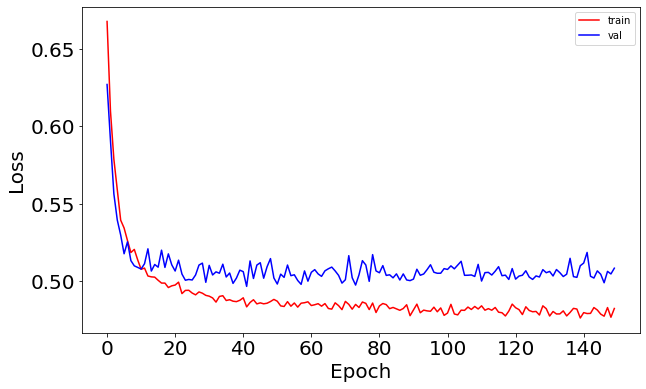

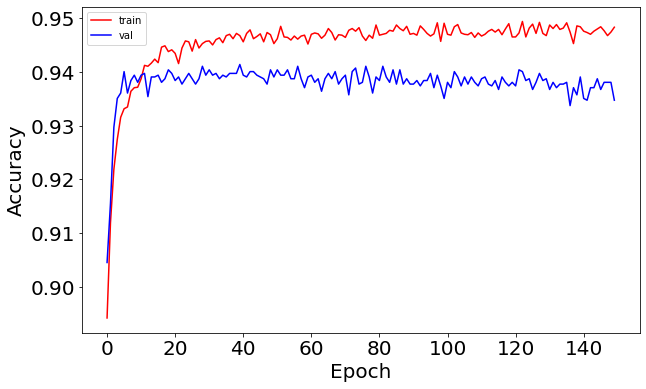

In [118]:
# Capturing learning history per epoch
hist  = pd.DataFrame(nn_2.history)
hist['epoch'] = nn_2.epoch

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['loss']), 'r', label='train')
ax.plot(np.sqrt(hist['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['accuracy']), 'r', label='train')
ax.plot(np.sqrt(hist['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

### ROC-AUC Curve Analysis

No Skill: ROC AUC=0.500
NN Model: ROC AUC=0.936


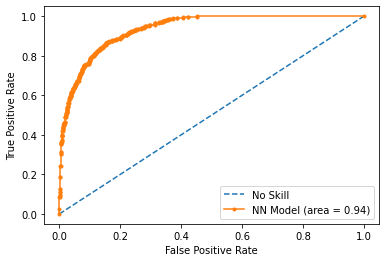

In [120]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = modelnn2.predict_proba(X_test)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NN Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='NN Model (area = %0.2f)' % lr_auc)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

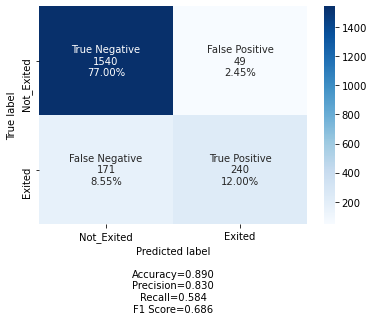

In [138]:
y_pred1 = modelnn2.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**

The models continue to perform relatively well.

The Accuracy is nearing 90, which is excellent. The FP figure is also really good.

The only downside of the model is the volume of False Negatives being generated.

We will adjust accordingly and attempt to tune the model with the adjusted class weighting.

### GridSearch with Weighting

In [97]:
%%time

# create the sklearn model for the network
model_init_batch_epoch_CV = KerasClassifier(build_fn=create_model, verbose=1)
batches = [50, 100, 150]
epochs = [50, 100, 150]
optimizers = ['rmsprop', 'adam']

# grid search for initializer, batch size and number of epochs
param_grid = dict(epochs=epochs, batch_size=batches, optimizer=optimizers)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, 
                    param_grid=param_grid,
                    cv=5)
grid_result = grid.fit(X_train, y_train, class_weight=class_weights, shuffle=True)


Epoch 1/50
128/128 [==============================] - 1s 455us/step - loss: 0.6497 - accuracy: 0.5188
Epoch 2/50
128/128 [==============================] - 0s 455us/step - loss: 0.4891 - accuracy: 0.7534
Epoch 3/50
128/128 [==============================] - 0s 455us/step - loss: 0.3717 - accuracy: 0.8066
Epoch 4/50
128/128 [==============================] - 0s 448us/step - loss: 0.3416 - accuracy: 0.8064
Epoch 5/50
128/128 [==============================] - 0s 455us/step - loss: 0.3437 - accuracy: 0.7977
Epoch 6/50
128/128 [==============================] - 0s 467us/step - loss: 0.3359 - accuracy: 0.8018
Epoch 7/50
128/128 [==============================] - 0s 448us/step - loss: 0.3063 - accuracy: 0.8322
Epoch 8/50
128/128 [==============================] - 0s 455us/step - loss: 0.3082 - accuracy: 0.8289
Epoch 9/50
128/128 [==============================] - 0s 455us/step - loss: 0.3085 - accuracy: 0.8338
Epoch 10/50
128/128 [==============================] - 0s 448us/step - loss: 0.312

128/128 [==============================] - 0s 463us/step - loss: 0.2771 - accuracy: 0.8514
Epoch 30/50
128/128 [==============================] - 0s 455us/step - loss: 0.2814 - accuracy: 0.8521
Epoch 31/50
128/128 [==============================] - 0s 463us/step - loss: 0.2812 - accuracy: 0.8567
Epoch 32/50
128/128 [==============================] - 0s 463us/step - loss: 0.2865 - accuracy: 0.8527
Epoch 33/50
128/128 [==============================] - 0s 463us/step - loss: 0.2798 - accuracy: 0.8608
Epoch 34/50
128/128 [==============================] - 0s 463us/step - loss: 0.2720 - accuracy: 0.8671
Epoch 35/50
128/128 [==============================] - 0s 463us/step - loss: 0.2755 - accuracy: 0.8529
Epoch 36/50
128/128 [==============================] - 0s 455us/step - loss: 0.2718 - accuracy: 0.8555
Epoch 37/50
128/128 [==============================] - 0s 464us/step - loss: 0.2589 - accuracy: 0.8698
Epoch 38/50
128/128 [==============================] - 0s 463us/step - loss: 0.2645 -

128/128 [==============================] - 0s 455us/step - loss: 0.3202 - accuracy: 0.8369
Epoch 8/50
128/128 [==============================] - 0s 463us/step - loss: 0.3014 - accuracy: 0.8430
Epoch 9/50
128/128 [==============================] - 0s 455us/step - loss: 0.3087 - accuracy: 0.8316
Epoch 10/50
128/128 [==============================] - 0s 463us/step - loss: 0.3140 - accuracy: 0.8267
Epoch 11/50
128/128 [==============================] - 0s 448us/step - loss: 0.3114 - accuracy: 0.8322
Epoch 12/50
128/128 [==============================] - 0s 455us/step - loss: 0.3087 - accuracy: 0.8397
Epoch 13/50
128/128 [==============================] - 0s 448us/step - loss: 0.3038 - accuracy: 0.8321
Epoch 14/50
128/128 [==============================] - 0s 463us/step - loss: 0.3038 - accuracy: 0.8395
Epoch 15/50
128/128 [==============================] - 0s 448us/step - loss: 0.2925 - accuracy: 0.8512
Epoch 16/50
128/128 [==============================] - 0s 448us/step - loss: 0.3047 - a

128/128 [==============================] - 0s 455us/step - loss: 0.2693 - accuracy: 0.8632
Epoch 36/50
128/128 [==============================] - 0s 455us/step - loss: 0.2681 - accuracy: 0.8624
Epoch 37/50
128/128 [==============================] - 0s 455us/step - loss: 0.2708 - accuracy: 0.8652
Epoch 38/50
128/128 [==============================] - 0s 455us/step - loss: 0.2676 - accuracy: 0.8568
Epoch 39/50
128/128 [==============================] - 0s 463us/step - loss: 0.2644 - accuracy: 0.8577
Epoch 40/50
128/128 [==============================] - 0s 463us/step - loss: 0.2728 - accuracy: 0.8553
Epoch 41/50
128/128 [==============================] - 0s 463us/step - loss: 0.2780 - accuracy: 0.8539
Epoch 42/50
128/128 [==============================] - 0s 448us/step - loss: 0.2547 - accuracy: 0.8746
Epoch 43/50
128/128 [==============================] - 0s 463us/step - loss: 0.2690 - accuracy: 0.8500
Epoch 44/50
128/128 [==============================] - 0s 463us/step - loss: 0.2724 -

128/128 [==============================] - 0s 455us/step - loss: 0.2800 - accuracy: 0.8529
Epoch 14/50
128/128 [==============================] - 0s 448us/step - loss: 0.2903 - accuracy: 0.8371
Epoch 15/50
128/128 [==============================] - 0s 448us/step - loss: 0.2788 - accuracy: 0.8522
Epoch 16/50
128/128 [==============================] - 0s 455us/step - loss: 0.2968 - accuracy: 0.8478
Epoch 17/50
128/128 [==============================] - 0s 455us/step - loss: 0.2824 - accuracy: 0.8488
Epoch 18/50
128/128 [==============================] - 0s 463us/step - loss: 0.2841 - accuracy: 0.8520
Epoch 19/50
128/128 [==============================] - 0s 448us/step - loss: 0.2749 - accuracy: 0.8556
Epoch 20/50
128/128 [==============================] - 0s 448us/step - loss: 0.2883 - accuracy: 0.8493
Epoch 21/50
128/128 [==============================] - 0s 457us/step - loss: 0.2817 - accuracy: 0.8548
Epoch 22/50
128/128 [==============================] - 0s 455us/step - loss: 0.2823 -

128/128 [==============================] - 0s 463us/step - loss: 0.2816 - accuracy: 0.8531
Epoch 42/50
128/128 [==============================] - 0s 440us/step - loss: 0.2691 - accuracy: 0.8545
Epoch 43/50
128/128 [==============================] - 0s 448us/step - loss: 0.2607 - accuracy: 0.8638
Epoch 44/50
128/128 [==============================] - 0s 455us/step - loss: 0.2819 - accuracy: 0.8491
Epoch 45/50
128/128 [==============================] - 0s 448us/step - loss: 0.2687 - accuracy: 0.8567
Epoch 46/50
128/128 [==============================] - 0s 455us/step - loss: 0.2698 - accuracy: 0.8492
Epoch 47/50
128/128 [==============================] - 0s 448us/step - loss: 0.2603 - accuracy: 0.8629
Epoch 48/50
128/128 [==============================] - 0s 455us/step - loss: 0.2644 - accuracy: 0.8614
Epoch 49/50
128/128 [==============================] - 0s 455us/step - loss: 0.2652 - accuracy: 0.8564
Epoch 50/50
32/32 [==============================] - 0s 322us/step - loss: 0.2827 - a

128/128 [==============================] - 0s 463us/step - loss: 0.2882 - accuracy: 0.8442
Epoch 19/50
128/128 [==============================] - 0s 463us/step - loss: 0.2924 - accuracy: 0.8447
Epoch 20/50
128/128 [==============================] - 0s 484us/step - loss: 0.2856 - accuracy: 0.8534
Epoch 21/50
128/128 [==============================] - 0s 487us/step - loss: 0.2928 - accuracy: 0.8411
Epoch 22/50
128/128 [==============================] - 0s 463us/step - loss: 0.2864 - accuracy: 0.8497
Epoch 23/50
128/128 [==============================] - 0s 471us/step - loss: 0.2867 - accuracy: 0.8524
Epoch 24/50
128/128 [==============================] - 0s 463us/step - loss: 0.2835 - accuracy: 0.8508
Epoch 25/50
128/128 [==============================] - 0s 463us/step - loss: 0.2683 - accuracy: 0.8576
Epoch 26/50
128/128 [==============================] - 0s 463us/step - loss: 0.2931 - accuracy: 0.8464
Epoch 27/50
128/128 [==============================] - 0s 455us/step - loss: 0.2767 -

128/128 [==============================] - 0s 463us/step - loss: 0.2701 - accuracy: 0.8636
Epoch 47/100
128/128 [==============================] - 0s 455us/step - loss: 0.2830 - accuracy: 0.8385
Epoch 48/100
128/128 [==============================] - 0s 455us/step - loss: 0.2831 - accuracy: 0.8486
Epoch 49/100
128/128 [==============================] - 0s 448us/step - loss: 0.2782 - accuracy: 0.8572
Epoch 50/100
128/128 [==============================] - 0s 455us/step - loss: 0.2696 - accuracy: 0.8525
Epoch 51/100
128/128 [==============================] - 0s 452us/step - loss: 0.2658 - accuracy: 0.8499
Epoch 52/100
128/128 [==============================] - 0s 448us/step - loss: 0.2878 - accuracy: 0.8439
Epoch 53/100
128/128 [==============================] - 0s 448us/step - loss: 0.2695 - accuracy: 0.8525
Epoch 54/100
128/128 [==============================] - 0s 455us/step - loss: 0.2601 - accuracy: 0.8537
Epoch 55/100
128/128 [==============================] - 0s 460us/step - loss:

128/128 [==============================] - 0s 463us/step - loss: 0.2814 - accuracy: 0.8479
Epoch 24/100
128/128 [==============================] - 0s 463us/step - loss: 0.2731 - accuracy: 0.8542
Epoch 25/100
128/128 [==============================] - 0s 471us/step - loss: 0.2760 - accuracy: 0.8565
Epoch 26/100
128/128 [==============================] - 0s 463us/step - loss: 0.2834 - accuracy: 0.8484
Epoch 27/100
128/128 [==============================] - 0s 463us/step - loss: 0.2729 - accuracy: 0.8594
Epoch 28/100
128/128 [==============================] - 0s 455us/step - loss: 0.2739 - accuracy: 0.8574
Epoch 29/100
128/128 [==============================] - 0s 455us/step - loss: 0.2753 - accuracy: 0.8536
Epoch 30/100
128/128 [==============================] - 0s 463us/step - loss: 0.2629 - accuracy: 0.8586
Epoch 31/100
128/128 [==============================] - 0s 463us/step - loss: 0.2818 - accuracy: 0.8507
Epoch 32/100
128/128 [==============================] - 0s 463us/step - loss:

128/128 [==============================] - 1s 455us/step - loss: 0.6267 - accuracy: 0.5961
Epoch 2/100
128/128 [==============================] - 0s 463us/step - loss: 0.4316 - accuracy: 0.7872
Epoch 3/100
128/128 [==============================] - 0s 455us/step - loss: 0.3650 - accuracy: 0.7903
Epoch 4/100
128/128 [==============================] - 0s 448us/step - loss: 0.3326 - accuracy: 0.8191
Epoch 5/100
128/128 [==============================] - 0s 455us/step - loss: 0.3271 - accuracy: 0.8109
Epoch 6/100
128/128 [==============================] - 0s 448us/step - loss: 0.3188 - accuracy: 0.8323
Epoch 7/100
128/128 [==============================] - 0s 455us/step - loss: 0.3060 - accuracy: 0.8249
Epoch 8/100
128/128 [==============================] - 0s 448us/step - loss: 0.3033 - accuracy: 0.8410
Epoch 9/100
128/128 [==============================] - 0s 453us/step - loss: 0.2991 - accuracy: 0.8332
Epoch 10/100
128/128 [==============================] - 0s 455us/step - loss: 0.3012 

Epoch 80/100
128/128 [==============================] - 0s 455us/step - loss: 0.2497 - accuracy: 0.8698
Epoch 81/100
128/128 [==============================] - 0s 448us/step - loss: 0.2578 - accuracy: 0.8620
Epoch 82/100
128/128 [==============================] - 0s 463us/step - loss: 0.2700 - accuracy: 0.8552
Epoch 83/100
128/128 [==============================] - 0s 455us/step - loss: 0.2692 - accuracy: 0.8579
Epoch 84/100
128/128 [==============================] - 0s 455us/step - loss: 0.2575 - accuracy: 0.8626
Epoch 85/100
128/128 [==============================] - 0s 448us/step - loss: 0.2488 - accuracy: 0.8614
Epoch 86/100
128/128 [==============================] - 0s 463us/step - loss: 0.2560 - accuracy: 0.8671
Epoch 87/100
128/128 [==============================] - 0s 455us/step - loss: 0.2530 - accuracy: 0.8705
Epoch 88/100
128/128 [==============================] - 0s 448us/step - loss: 0.2609 - accuracy: 0.8653
Epoch 89/100
128/128 [==============================] - 0s 455us

128/128 [==============================] - 0s 463us/step - loss: 0.2639 - accuracy: 0.8476
Epoch 58/100
128/128 [==============================] - 0s 455us/step - loss: 0.2673 - accuracy: 0.8466
Epoch 59/100
128/128 [==============================] - 0s 455us/step - loss: 0.2668 - accuracy: 0.8554
Epoch 60/100
128/128 [==============================] - 0s 463us/step - loss: 0.2695 - accuracy: 0.8427
Epoch 61/100
128/128 [==============================] - 0s 455us/step - loss: 0.2576 - accuracy: 0.8511
Epoch 62/100
128/128 [==============================] - 0s 455us/step - loss: 0.2738 - accuracy: 0.8489
Epoch 63/100
128/128 [==============================] - 0s 463us/step - loss: 0.2701 - accuracy: 0.8475
Epoch 64/100
128/128 [==============================] - 0s 455us/step - loss: 0.2623 - accuracy: 0.8478
Epoch 65/100
128/128 [==============================] - 0s 455us/step - loss: 0.2558 - accuracy: 0.8609
Epoch 66/100
128/128 [==============================] - 0s 456us/step - loss:

128/128 [==============================] - 0s 448us/step - loss: 0.2712 - accuracy: 0.8628
Epoch 36/100
128/128 [==============================] - 0s 448us/step - loss: 0.2672 - accuracy: 0.8630
Epoch 37/100
128/128 [==============================] - 0s 455us/step - loss: 0.2714 - accuracy: 0.8644
Epoch 38/100
128/128 [==============================] - 0s 455us/step - loss: 0.2665 - accuracy: 0.8587
Epoch 39/100
128/128 [==============================] - 0s 448us/step - loss: 0.2634 - accuracy: 0.8736
Epoch 40/100
128/128 [==============================] - 0s 448us/step - loss: 0.2708 - accuracy: 0.8642
Epoch 41/100
128/128 [==============================] - 0s 455us/step - loss: 0.2618 - accuracy: 0.8682
Epoch 42/100
128/128 [==============================] - 0s 455us/step - loss: 0.2671 - accuracy: 0.8535
Epoch 43/100
128/128 [==============================] - 0s 452us/step - loss: 0.2628 - accuracy: 0.8692
Epoch 44/100
128/128 [==============================] - 0s 448us/step - loss:

128/128 [==============================] - 0s 448us/step - loss: 0.2940 - accuracy: 0.8339
Epoch 14/100
128/128 [==============================] - 0s 463us/step - loss: 0.2921 - accuracy: 0.8343
Epoch 15/100
128/128 [==============================] - 0s 448us/step - loss: 0.2983 - accuracy: 0.8449
Epoch 16/100
128/128 [==============================] - 0s 455us/step - loss: 0.2916 - accuracy: 0.8434
Epoch 17/100
128/128 [==============================] - 0s 455us/step - loss: 0.2953 - accuracy: 0.8466
Epoch 18/100
128/128 [==============================] - 0s 448us/step - loss: 0.2986 - accuracy: 0.8377
Epoch 19/100
128/128 [==============================] - 0s 440us/step - loss: 0.2875 - accuracy: 0.8464
Epoch 20/100
128/128 [==============================] - 0s 455us/step - loss: 0.2785 - accuracy: 0.8558
Epoch 21/100
128/128 [==============================] - 0s 455us/step - loss: 0.2984 - accuracy: 0.8360
Epoch 22/100
128/128 [==============================] - 0s 448us/step - loss:

128/128 [==============================] - 0s 455us/step - loss: 0.2546 - accuracy: 0.8625
Epoch 92/100
128/128 [==============================] - 0s 455us/step - loss: 0.2604 - accuracy: 0.8526
Epoch 93/100
128/128 [==============================] - 0s 455us/step - loss: 0.2507 - accuracy: 0.8618
Epoch 94/100
128/128 [==============================] - 0s 448us/step - loss: 0.2606 - accuracy: 0.8518
Epoch 95/100
128/128 [==============================] - 0s 448us/step - loss: 0.2527 - accuracy: 0.8659
Epoch 96/100
128/128 [==============================] - 0s 448us/step - loss: 0.2665 - accuracy: 0.8555
Epoch 97/100
128/128 [==============================] - 0s 448us/step - loss: 0.2480 - accuracy: 0.8643
Epoch 98/100
128/128 [==============================] - 0s 463us/step - loss: 0.2526 - accuracy: 0.8605
Epoch 99/100
128/128 [==============================] - 0s 448us/step - loss: 0.2595 - accuracy: 0.8654
Epoch 100/100
32/32 [==============================] - 0s 354us/step - loss: 

128/128 [==============================] - 0s 455us/step - loss: 0.2575 - accuracy: 0.8618
Epoch 70/100
128/128 [==============================] - 0s 455us/step - loss: 0.2491 - accuracy: 0.8717
Epoch 71/100
128/128 [==============================] - 0s 463us/step - loss: 0.2533 - accuracy: 0.8658
Epoch 72/100
128/128 [==============================] - 0s 463us/step - loss: 0.2512 - accuracy: 0.8611
Epoch 73/100
128/128 [==============================] - 0s 463us/step - loss: 0.2376 - accuracy: 0.8732
Epoch 74/100
128/128 [==============================] - 0s 455us/step - loss: 0.2459 - accuracy: 0.8718
Epoch 75/100
128/128 [==============================] - 0s 455us/step - loss: 0.2530 - accuracy: 0.8722
Epoch 76/100
128/128 [==============================] - 0s 455us/step - loss: 0.2526 - accuracy: 0.8661
Epoch 77/100
128/128 [==============================] - 0s 463us/step - loss: 0.2515 - accuracy: 0.8695
Epoch 78/100
128/128 [==============================] - 0s 463us/step - loss:

128/128 [==============================] - 0s 448us/step - loss: 0.2826 - accuracy: 0.8590
Epoch 48/100
128/128 [==============================] - 0s 471us/step - loss: 0.2675 - accuracy: 0.8610
Epoch 49/100
128/128 [==============================] - 0s 455us/step - loss: 0.2900 - accuracy: 0.8448
Epoch 50/100
128/128 [==============================] - 0s 455us/step - loss: 0.2803 - accuracy: 0.8485
Epoch 51/100
128/128 [==============================] - 0s 448us/step - loss: 0.2693 - accuracy: 0.8529
Epoch 52/100
128/128 [==============================] - 0s 448us/step - loss: 0.2774 - accuracy: 0.8519
Epoch 53/100
128/128 [==============================] - 0s 487us/step - loss: 0.2734 - accuracy: 0.8568
Epoch 54/100
128/128 [==============================] - 0s 518us/step - loss: 0.2722 - accuracy: 0.8588
Epoch 55/100
128/128 [==============================] - 0s 628us/step - loss: 0.2767 - accuracy: 0.8558
Epoch 56/100
128/128 [==============================] - 0s 565us/step - loss:

128/128 [==============================] - 0s 448us/step - loss: 0.2920 - accuracy: 0.8492
Epoch 26/100
128/128 [==============================] - 0s 455us/step - loss: 0.2834 - accuracy: 0.8468
Epoch 27/100
128/128 [==============================] - 0s 463us/step - loss: 0.2966 - accuracy: 0.8425
Epoch 28/100
128/128 [==============================] - 0s 455us/step - loss: 0.2844 - accuracy: 0.8484
Epoch 29/100
128/128 [==============================] - 0s 463us/step - loss: 0.2766 - accuracy: 0.8533
Epoch 30/100
128/128 [==============================] - 0s 463us/step - loss: 0.2846 - accuracy: 0.8389
Epoch 31/100
128/128 [==============================] - 0s 463us/step - loss: 0.2866 - accuracy: 0.8538
Epoch 32/100
128/128 [==============================] - 0s 448us/step - loss: 0.2694 - accuracy: 0.8605
Epoch 33/100
128/128 [==============================] - 0s 463us/step - loss: 0.2770 - accuracy: 0.8470
Epoch 34/100
128/128 [==============================] - 0s 448us/step - loss:

128/128 [==============================] - 0s 463us/step - loss: 0.3582 - accuracy: 0.8235
Epoch 4/100
128/128 [==============================] - 0s 467us/step - loss: 0.3510 - accuracy: 0.8155
Epoch 5/100
128/128 [==============================] - 0s 463us/step - loss: 0.3293 - accuracy: 0.8214
Epoch 6/100
128/128 [==============================] - 0s 463us/step - loss: 0.3203 - accuracy: 0.8312
Epoch 7/100
128/128 [==============================] - 0s 455us/step - loss: 0.3365 - accuracy: 0.8168
Epoch 8/100
128/128 [==============================] - 0s 471us/step - loss: 0.3217 - accuracy: 0.8211
Epoch 9/100
128/128 [==============================] - 0s 463us/step - loss: 0.3172 - accuracy: 0.8297
Epoch 10/100
128/128 [==============================] - 0s 463us/step - loss: 0.3045 - accuracy: 0.8416
Epoch 11/100
128/128 [==============================] - 0s 463us/step - loss: 0.3042 - accuracy: 0.8338
Epoch 12/100
128/128 [==============================] - 0s 463us/step - loss: 0.300

128/128 [==============================] - 0s 463us/step - loss: 0.2420 - accuracy: 0.8804
Epoch 82/100
128/128 [==============================] - 0s 463us/step - loss: 0.2602 - accuracy: 0.8648
Epoch 83/100
128/128 [==============================] - 0s 463us/step - loss: 0.2499 - accuracy: 0.8756
Epoch 84/100
128/128 [==============================] - 0s 463us/step - loss: 0.2541 - accuracy: 0.8628
Epoch 85/100
128/128 [==============================] - 0s 471us/step - loss: 0.2489 - accuracy: 0.8743
Epoch 86/100
128/128 [==============================] - 0s 463us/step - loss: 0.2639 - accuracy: 0.8648
Epoch 87/100
128/128 [==============================] - 0s 463us/step - loss: 0.2420 - accuracy: 0.8819
Epoch 88/100
128/128 [==============================] - 0s 463us/step - loss: 0.2625 - accuracy: 0.8600
Epoch 89/100
128/128 [==============================] - 0s 463us/step - loss: 0.2619 - accuracy: 0.8636
Epoch 90/100
128/128 [==============================] - 0s 463us/step - loss:

128/128 [==============================] - 0s 455us/step - loss: 0.2748 - accuracy: 0.8511
Epoch 60/150
128/128 [==============================] - 0s 463us/step - loss: 0.2677 - accuracy: 0.8604
Epoch 61/150
128/128 [==============================] - 0s 463us/step - loss: 0.2705 - accuracy: 0.8559
Epoch 62/150
128/128 [==============================] - 0s 455us/step - loss: 0.2710 - accuracy: 0.8596
Epoch 63/150
128/128 [==============================] - 0s 463us/step - loss: 0.2615 - accuracy: 0.8566
Epoch 64/150
128/128 [==============================] - 0s 455us/step - loss: 0.2671 - accuracy: 0.8662
Epoch 65/150
128/128 [==============================] - 0s 463us/step - loss: 0.2777 - accuracy: 0.8499
Epoch 66/150
128/128 [==============================] - 0s 455us/step - loss: 0.2667 - accuracy: 0.8673
Epoch 67/150
128/128 [==============================] - 0s 463us/step - loss: 0.2599 - accuracy: 0.8582
Epoch 68/150
128/128 [==============================] - 0s 455us/step - loss:

128/128 [==============================] - 0s 463us/step - loss: 0.2586 - accuracy: 0.8642
Epoch 138/150
128/128 [==============================] - 0s 455us/step - loss: 0.2470 - accuracy: 0.8713
Epoch 139/150
128/128 [==============================] - 0s 463us/step - loss: 0.2462 - accuracy: 0.8652
Epoch 140/150
128/128 [==============================] - 0s 455us/step - loss: 0.2514 - accuracy: 0.8688
Epoch 141/150
128/128 [==============================] - 0s 463us/step - loss: 0.2516 - accuracy: 0.8639
Epoch 142/150
128/128 [==============================] - 0s 463us/step - loss: 0.2541 - accuracy: 0.8666
Epoch 143/150
128/128 [==============================] - 0s 463us/step - loss: 0.2437 - accuracy: 0.8688
Epoch 144/150
128/128 [==============================] - 0s 463us/step - loss: 0.2602 - accuracy: 0.8607
Epoch 145/150
128/128 [==============================] - 0s 455us/step - loss: 0.2546 - accuracy: 0.8679
Epoch 146/150
128/128 [==============================] - 0s 463us/ste

128/128 [==============================] - 0s 455us/step - loss: 0.2531 - accuracy: 0.8616
Epoch 66/150
128/128 [==============================] - 0s 455us/step - loss: 0.2535 - accuracy: 0.8590
Epoch 67/150
128/128 [==============================] - 0s 448us/step - loss: 0.2465 - accuracy: 0.8667
Epoch 68/150
128/128 [==============================] - 0s 455us/step - loss: 0.2682 - accuracy: 0.8507
Epoch 69/150
128/128 [==============================] - 0s 455us/step - loss: 0.2478 - accuracy: 0.8596
Epoch 70/150
128/128 [==============================] - 0s 455us/step - loss: 0.2629 - accuracy: 0.8599
Epoch 71/150
128/128 [==============================] - 0s 455us/step - loss: 0.2484 - accuracy: 0.8646
Epoch 72/150
128/128 [==============================] - 0s 455us/step - loss: 0.2515 - accuracy: 0.8593
Epoch 73/150
128/128 [==============================] - 0s 463us/step - loss: 0.2684 - accuracy: 0.8476
Epoch 74/150
128/128 [==============================] - 0s 455us/step - loss:

128/128 [==============================] - 0s 455us/step - loss: 0.2437 - accuracy: 0.8710
Epoch 144/150
128/128 [==============================] - 0s 455us/step - loss: 0.2268 - accuracy: 0.8735
Epoch 145/150
128/128 [==============================] - 0s 463us/step - loss: 0.2224 - accuracy: 0.8767
Epoch 146/150
128/128 [==============================] - 0s 455us/step - loss: 0.2373 - accuracy: 0.8631
Epoch 147/150
128/128 [==============================] - 0s 455us/step - loss: 0.2321 - accuracy: 0.8681
Epoch 148/150
128/128 [==============================] - 0s 455us/step - loss: 0.2386 - accuracy: 0.8653
Epoch 149/150
128/128 [==============================] - 0s 448us/step - loss: 0.2319 - accuracy: 0.8655
Epoch 150/150
32/32 [==============================] - 0s 353us/step - loss: 0.3781 - accuracy: 0.8450
Epoch 1/150
128/128 [==============================] - 1s 455us/step - loss: 0.6539 - accuracy: 0.6727
Epoch 2/150
128/128 [==============================] - 0s 455us/step - lo

128/128 [==============================] - 0s 455us/step - loss: 0.2667 - accuracy: 0.8652
Epoch 72/150
128/128 [==============================] - 0s 455us/step - loss: 0.2685 - accuracy: 0.8531
Epoch 73/150
128/128 [==============================] - 0s 455us/step - loss: 0.2698 - accuracy: 0.8566
Epoch 74/150
128/128 [==============================] - 0s 448us/step - loss: 0.2631 - accuracy: 0.8623
Epoch 75/150
128/128 [==============================] - 0s 463us/step - loss: 0.2709 - accuracy: 0.8580
Epoch 76/150
128/128 [==============================] - 0s 463us/step - loss: 0.2682 - accuracy: 0.8565
Epoch 77/150
128/128 [==============================] - 0s 463us/step - loss: 0.2622 - accuracy: 0.8597
Epoch 78/150
128/128 [==============================] - 0s 463us/step - loss: 0.2628 - accuracy: 0.8661
Epoch 79/150
128/128 [==============================] - 0s 455us/step - loss: 0.2598 - accuracy: 0.8591
Epoch 80/150
128/128 [==============================] - 0s 455us/step - loss:

128/128 [==============================] - 0s 455us/step - loss: 0.2385 - accuracy: 0.8649
Epoch 150/150
32/32 [==============================] - 0s 354us/step - loss: 0.3354 - accuracy: 0.8288
Epoch 1/150
128/128 [==============================] - 1s 455us/step - loss: 0.6339 - accuracy: 0.6385
Epoch 2/150
128/128 [==============================] - 0s 448us/step - loss: 0.4313 - accuracy: 0.7846
Epoch 3/150
128/128 [==============================] - 0s 455us/step - loss: 0.3800 - accuracy: 0.7861
Epoch 4/150
128/128 [==============================] - 0s 455us/step - loss: 0.3438 - accuracy: 0.8117
Epoch 5/150
128/128 [==============================] - 0s 448us/step - loss: 0.3302 - accuracy: 0.8054
Epoch 6/150
128/128 [==============================] - 0s 448us/step - loss: 0.3265 - accuracy: 0.8256
Epoch 7/150
128/128 [==============================] - 0s 463us/step - loss: 0.3189 - accuracy: 0.8278
Epoch 8/150
128/128 [==============================] - 0s 455us/step - loss: 0.3141 -

128/128 [==============================] - 0s 448us/step - loss: 0.2658 - accuracy: 0.8538
Epoch 78/150
128/128 [==============================] - 0s 455us/step - loss: 0.2653 - accuracy: 0.8538
Epoch 79/150
128/128 [==============================] - 0s 455us/step - loss: 0.2587 - accuracy: 0.8620
Epoch 80/150
128/128 [==============================] - 0s 448us/step - loss: 0.2758 - accuracy: 0.8444
Epoch 81/150
128/128 [==============================] - 0s 455us/step - loss: 0.2526 - accuracy: 0.8656
Epoch 82/150
128/128 [==============================] - 0s 455us/step - loss: 0.2658 - accuracy: 0.8519
Epoch 83/150
128/128 [==============================] - 0s 455us/step - loss: 0.2680 - accuracy: 0.8663
Epoch 84/150
128/128 [==============================] - 0s 448us/step - loss: 0.2686 - accuracy: 0.8553
Epoch 85/150
128/128 [==============================] - 0s 455us/step - loss: 0.2661 - accuracy: 0.8467
Epoch 86/150
128/128 [==============================] - 0s 455us/step - loss:

128/128 [==============================] - 0s 455us/step - loss: 0.3305 - accuracy: 0.8196
Epoch 5/150
128/128 [==============================] - 0s 455us/step - loss: 0.3239 - accuracy: 0.8252
Epoch 6/150
128/128 [==============================] - 0s 455us/step - loss: 0.3135 - accuracy: 0.8323
Epoch 7/150
128/128 [==============================] - 0s 463us/step - loss: 0.3166 - accuracy: 0.8320
Epoch 8/150
128/128 [==============================] - 0s 448us/step - loss: 0.3112 - accuracy: 0.8304
Epoch 9/150
128/128 [==============================] - 0s 455us/step - loss: 0.3085 - accuracy: 0.8463
Epoch 10/150
128/128 [==============================] - 0s 455us/step - loss: 0.3022 - accuracy: 0.8410
Epoch 11/150
128/128 [==============================] - 0s 448us/step - loss: 0.3116 - accuracy: 0.8239
Epoch 12/150
128/128 [==============================] - 0s 463us/step - loss: 0.2967 - accuracy: 0.8514
Epoch 13/150
128/128 [==============================] - 0s 463us/step - loss: 0.29

Epoch 83/150
128/128 [==============================] - 0s 455us/step - loss: 0.2411 - accuracy: 0.8762
Epoch 84/150
128/128 [==============================] - 0s 448us/step - loss: 0.2496 - accuracy: 0.8755
Epoch 85/150
128/128 [==============================] - 0s 455us/step - loss: 0.2521 - accuracy: 0.8708
Epoch 86/150
128/128 [==============================] - 0s 448us/step - loss: 0.2492 - accuracy: 0.8684
Epoch 87/150
128/128 [==============================] - 0s 455us/step - loss: 0.2483 - accuracy: 0.8769
Epoch 88/150
128/128 [==============================] - 0s 455us/step - loss: 0.2352 - accuracy: 0.8819
Epoch 89/150
128/128 [==============================] - 0s 448us/step - loss: 0.2458 - accuracy: 0.8729
Epoch 90/150
128/128 [==============================] - 0s 455us/step - loss: 0.2492 - accuracy: 0.8707
Epoch 91/150
128/128 [==============================] - 0s 455us/step - loss: 0.2479 - accuracy: 0.8755
Epoch 92/150
128/128 [==============================] - 0s 448us

128/128 [==============================] - 0s 463us/step - loss: 0.3116 - accuracy: 0.8302
Epoch 11/150
128/128 [==============================] - 0s 455us/step - loss: 0.2999 - accuracy: 0.8363
Epoch 12/150
128/128 [==============================] - 0s 463us/step - loss: 0.3072 - accuracy: 0.8309
Epoch 13/150
128/128 [==============================] - 0s 455us/step - loss: 0.3037 - accuracy: 0.8308
Epoch 14/150
128/128 [==============================] - 0s 463us/step - loss: 0.3120 - accuracy: 0.8366
Epoch 15/150
128/128 [==============================] - 0s 471us/step - loss: 0.3024 - accuracy: 0.8354
Epoch 16/150
128/128 [==============================] - 0s 455us/step - loss: 0.3024 - accuracy: 0.8330
Epoch 17/150
128/128 [==============================] - 0s 463us/step - loss: 0.2961 - accuracy: 0.8511
Epoch 18/150
128/128 [==============================] - 0s 455us/step - loss: 0.3049 - accuracy: 0.8413
Epoch 19/150
128/128 [==============================] - 0s 455us/step - loss:

128/128 [==============================] - 0s 455us/step - loss: 0.2466 - accuracy: 0.8690
Epoch 89/150
128/128 [==============================] - 0s 471us/step - loss: 0.2661 - accuracy: 0.8622
Epoch 90/150
128/128 [==============================] - 0s 463us/step - loss: 0.2479 - accuracy: 0.8714
Epoch 91/150
128/128 [==============================] - 0s 463us/step - loss: 0.2606 - accuracy: 0.8652
Epoch 92/150
128/128 [==============================] - 0s 455us/step - loss: 0.2523 - accuracy: 0.8608
Epoch 93/150
128/128 [==============================] - 0s 455us/step - loss: 0.2533 - accuracy: 0.8667
Epoch 94/150
128/128 [==============================] - 0s 455us/step - loss: 0.2449 - accuracy: 0.8718
Epoch 95/150
128/128 [==============================] - 0s 455us/step - loss: 0.2473 - accuracy: 0.8659
Epoch 96/150
128/128 [==============================] - 0s 463us/step - loss: 0.2625 - accuracy: 0.8624
Epoch 97/150
128/128 [==============================] - 0s 455us/step - loss:

128/128 [==============================] - 0s 463us/step - loss: 0.2861 - accuracy: 0.8501
Epoch 16/150
128/128 [==============================] - 0s 463us/step - loss: 0.2824 - accuracy: 0.8450
Epoch 17/150
128/128 [==============================] - 0s 463us/step - loss: 0.2780 - accuracy: 0.8513
Epoch 18/150
128/128 [==============================] - 0s 471us/step - loss: 0.2747 - accuracy: 0.8557
Epoch 19/150
128/128 [==============================] - 0s 463us/step - loss: 0.2844 - accuracy: 0.8533
Epoch 20/150
128/128 [==============================] - 0s 463us/step - loss: 0.2869 - accuracy: 0.8484
Epoch 21/150
128/128 [==============================] - 0s 463us/step - loss: 0.2858 - accuracy: 0.8478
Epoch 22/150
128/128 [==============================] - 0s 465us/step - loss: 0.2729 - accuracy: 0.8535
Epoch 23/150
128/128 [==============================] - 0s 479us/step - loss: 0.2793 - accuracy: 0.8525
Epoch 24/150
128/128 [==============================] - 0s 471us/step - loss:

128/128 [==============================] - 0s 469us/step - loss: 0.2558 - accuracy: 0.8638
Epoch 94/150
128/128 [==============================] - 0s 471us/step - loss: 0.2537 - accuracy: 0.8590
Epoch 95/150
128/128 [==============================] - 0s 463us/step - loss: 0.2354 - accuracy: 0.8678
Epoch 96/150
128/128 [==============================] - 0s 463us/step - loss: 0.2514 - accuracy: 0.8602
Epoch 97/150
128/128 [==============================] - 0s 463us/step - loss: 0.2590 - accuracy: 0.8591
Epoch 98/150
128/128 [==============================] - 0s 471us/step - loss: 0.2578 - accuracy: 0.8573
Epoch 99/150
128/128 [==============================] - 0s 463us/step - loss: 0.2479 - accuracy: 0.8642
Epoch 100/150
128/128 [==============================] - 0s 463us/step - loss: 0.2469 - accuracy: 0.8628
Epoch 101/150
128/128 [==============================] - 0s 463us/step - loss: 0.2588 - accuracy: 0.8594
Epoch 102/150
128/128 [==============================] - 0s 463us/step - lo

128/128 [==============================] - 0s 479us/step - loss: 0.2867 - accuracy: 0.8385
Epoch 21/150
128/128 [==============================] - 0s 463us/step - loss: 0.3007 - accuracy: 0.8483
Epoch 22/150
128/128 [==============================] - 0s 463us/step - loss: 0.3004 - accuracy: 0.8457
Epoch 23/150
128/128 [==============================] - 0s 471us/step - loss: 0.2945 - accuracy: 0.8517
Epoch 24/150
128/128 [==============================] - 0s 471us/step - loss: 0.2811 - accuracy: 0.8560
Epoch 25/150
128/128 [==============================] - 0s 463us/step - loss: 0.2843 - accuracy: 0.8487
Epoch 26/150
128/128 [==============================] - 0s 463us/step - loss: 0.2724 - accuracy: 0.8600
Epoch 27/150
128/128 [==============================] - 0s 463us/step - loss: 0.2843 - accuracy: 0.8505
Epoch 28/150
128/128 [==============================] - 0s 471us/step - loss: 0.2835 - accuracy: 0.8529
Epoch 29/150
128/128 [==============================] - 0s 455us/step - loss:

128/128 [==============================] - 0s 471us/step - loss: 0.2478 - accuracy: 0.8733
Epoch 99/150
128/128 [==============================] - 0s 463us/step - loss: 0.2495 - accuracy: 0.8672
Epoch 100/150
128/128 [==============================] - 0s 471us/step - loss: 0.2536 - accuracy: 0.8670
Epoch 101/150
128/128 [==============================] - 0s 469us/step - loss: 0.2512 - accuracy: 0.8649
Epoch 102/150
128/128 [==============================] - 0s 463us/step - loss: 0.2361 - accuracy: 0.8834
Epoch 103/150
128/128 [==============================] - 0s 471us/step - loss: 0.2535 - accuracy: 0.8629
Epoch 104/150
128/128 [==============================] - 0s 471us/step - loss: 0.2581 - accuracy: 0.8568
Epoch 105/150
128/128 [==============================] - 0s 471us/step - loss: 0.2585 - accuracy: 0.8620
Epoch 106/150
128/128 [==============================] - 0s 463us/step - loss: 0.2630 - accuracy: 0.8592
Epoch 107/150
128/128 [==============================] - 0s 463us/step

128/128 [==============================] - 0s 455us/step - loss: 0.2846 - accuracy: 0.8504
Epoch 26/150
128/128 [==============================] - 0s 455us/step - loss: 0.2865 - accuracy: 0.8526
Epoch 27/150
128/128 [==============================] - 0s 455us/step - loss: 0.2813 - accuracy: 0.8454
Epoch 28/150
128/128 [==============================] - 0s 463us/step - loss: 0.2916 - accuracy: 0.8403
Epoch 29/150
128/128 [==============================] - 0s 463us/step - loss: 0.2793 - accuracy: 0.8627
Epoch 30/150
128/128 [==============================] - 0s 463us/step - loss: 0.2848 - accuracy: 0.8540
Epoch 31/150
128/128 [==============================] - 0s 455us/step - loss: 0.2923 - accuracy: 0.8385
Epoch 32/150
128/128 [==============================] - 0s 463us/step - loss: 0.2760 - accuracy: 0.8656
Epoch 33/150
128/128 [==============================] - 0s 463us/step - loss: 0.2806 - accuracy: 0.8556
Epoch 34/150
128/128 [==============================] - 0s 473us/step - loss:

128/128 [==============================] - 0s 463us/step - loss: 0.2773 - accuracy: 0.8546
Epoch 104/150
128/128 [==============================] - 0s 455us/step - loss: 0.2639 - accuracy: 0.8593
Epoch 105/150
128/128 [==============================] - 0s 455us/step - loss: 0.2718 - accuracy: 0.8644
Epoch 106/150
128/128 [==============================] - 0s 455us/step - loss: 0.2533 - accuracy: 0.8699
Epoch 107/150
128/128 [==============================] - 0s 463us/step - loss: 0.2605 - accuracy: 0.8589
Epoch 108/150
128/128 [==============================] - 0s 463us/step - loss: 0.2658 - accuracy: 0.8573
Epoch 109/150
128/128 [==============================] - 0s 455us/step - loss: 0.2589 - accuracy: 0.8659
Epoch 110/150
128/128 [==============================] - 0s 455us/step - loss: 0.2490 - accuracy: 0.8767
Epoch 111/150
128/128 [==============================] - 0s 463us/step - loss: 0.2673 - accuracy: 0.8641
Epoch 112/150
128/128 [==============================] - 0s 455us/ste

128/128 [==============================] - 0s 463us/step - loss: 0.2795 - accuracy: 0.8500
Epoch 31/150
128/128 [==============================] - 0s 455us/step - loss: 0.2823 - accuracy: 0.8575
Epoch 32/150
128/128 [==============================] - 0s 455us/step - loss: 0.2756 - accuracy: 0.8592
Epoch 33/150
128/128 [==============================] - 0s 455us/step - loss: 0.2810 - accuracy: 0.8556
Epoch 34/150
128/128 [==============================] - 0s 455us/step - loss: 0.2878 - accuracy: 0.8519
Epoch 35/150
128/128 [==============================] - 0s 471us/step - loss: 0.2719 - accuracy: 0.8619
Epoch 36/150
128/128 [==============================] - 0s 455us/step - loss: 0.2667 - accuracy: 0.8697
Epoch 37/150
128/128 [==============================] - 0s 463us/step - loss: 0.2739 - accuracy: 0.8608
Epoch 38/150
128/128 [==============================] - 0s 455us/step - loss: 0.2652 - accuracy: 0.8656
Epoch 39/150
128/128 [==============================] - 0s 463us/step - loss:

128/128 [==============================] - 0s 463us/step - loss: 0.2387 - accuracy: 0.8637
Epoch 109/150
128/128 [==============================] - 0s 455us/step - loss: 0.2472 - accuracy: 0.8670
Epoch 110/150
128/128 [==============================] - 0s 455us/step - loss: 0.2370 - accuracy: 0.8751
Epoch 111/150
128/128 [==============================] - 0s 455us/step - loss: 0.2390 - accuracy: 0.8787
Epoch 112/150
128/128 [==============================] - 0s 448us/step - loss: 0.2409 - accuracy: 0.8772
Epoch 113/150
128/128 [==============================] - 0s 448us/step - loss: 0.2479 - accuracy: 0.8674
Epoch 114/150
128/128 [==============================] - 0s 463us/step - loss: 0.2314 - accuracy: 0.8796
Epoch 115/150
128/128 [==============================] - 0s 463us/step - loss: 0.2441 - accuracy: 0.8705
Epoch 116/150
128/128 [==============================] - 0s 463us/step - loss: 0.2335 - accuracy: 0.8795
Epoch 117/150
128/128 [==============================] - 0s 463us/ste

64/64 [==============================] - 0s 491us/step - loss: 0.2838 - accuracy: 0.8569
Epoch 37/50
64/64 [==============================] - 0s 507us/step - loss: 0.2790 - accuracy: 0.8611
Epoch 38/50
64/64 [==============================] - 0s 491us/step - loss: 0.2818 - accuracy: 0.8549
Epoch 39/50
64/64 [==============================] - 0s 491us/step - loss: 0.2749 - accuracy: 0.8610
Epoch 40/50
64/64 [==============================] - 0s 507us/step - loss: 0.2845 - accuracy: 0.8559
Epoch 41/50
64/64 [==============================] - 0s 491us/step - loss: 0.2787 - accuracy: 0.8569
Epoch 42/50
64/64 [==============================] - 0s 491us/step - loss: 0.2687 - accuracy: 0.8595
Epoch 43/50
64/64 [==============================] - 0s 507us/step - loss: 0.2837 - accuracy: 0.8552
Epoch 44/50
64/64 [==============================] - 0s 491us/step - loss: 0.2828 - accuracy: 0.8554
Epoch 45/50
64/64 [==============================] - 0s 491us/step - loss: 0.2893 - accuracy: 0.8490
Ep

64/64 [==============================] - 0s 491us/step - loss: 0.3170 - accuracy: 0.8317
Epoch 16/50
64/64 [==============================] - 0s 507us/step - loss: 0.2956 - accuracy: 0.8366
Epoch 17/50
64/64 [==============================] - 0s 507us/step - loss: 0.3022 - accuracy: 0.8326
Epoch 18/50
64/64 [==============================] - 0s 507us/step - loss: 0.3007 - accuracy: 0.8386
Epoch 19/50
64/64 [==============================] - 0s 507us/step - loss: 0.2812 - accuracy: 0.8602
Epoch 20/50
64/64 [==============================] - 0s 507us/step - loss: 0.2991 - accuracy: 0.8288
Epoch 21/50
64/64 [==============================] - 0s 507us/step - loss: 0.2970 - accuracy: 0.8463
Epoch 22/50
64/64 [==============================] - 0s 507us/step - loss: 0.2919 - accuracy: 0.8402
Epoch 23/50
64/64 [==============================] - 0s 507us/step - loss: 0.2868 - accuracy: 0.8357
Epoch 24/50
64/64 [==============================] - 0s 507us/step - loss: 0.2757 - accuracy: 0.8563
Ep

64/64 [==============================] - 0s 522us/step - loss: 0.2888 - accuracy: 0.8462
Epoch 46/50
64/64 [==============================] - 0s 507us/step - loss: 0.2723 - accuracy: 0.8658
Epoch 47/50
64/64 [==============================] - 0s 507us/step - loss: 0.2823 - accuracy: 0.8497
Epoch 48/50
64/64 [==============================] - 0s 507us/step - loss: 0.2862 - accuracy: 0.8463
Epoch 49/50
64/64 [==============================] - 0s 507us/step - loss: 0.2781 - accuracy: 0.8607
Epoch 50/50
16/16 [==============================] - 0s 464us/step - loss: 0.2972 - accuracy: 0.8569
Epoch 1/50
64/64 [==============================] - 1s 522us/step - loss: 0.6487 - accuracy: 0.6082
Epoch 2/50
64/64 [==============================] - 0s 507us/step - loss: 0.4816 - accuracy: 0.7370
Epoch 3/50
64/64 [==============================] - 0s 507us/step - loss: 0.3948 - accuracy: 0.7877
Epoch 4/50
64/64 [==============================] - 0s 522us/step - loss: 0.3630 - accuracy: 0.8078
Epoch 

64/64 [==============================] - 0s 522us/step - loss: 0.2917 - accuracy: 0.8423
Epoch 25/50
64/64 [==============================] - 0s 522us/step - loss: 0.2929 - accuracy: 0.8491
Epoch 26/50
64/64 [==============================] - 0s 507us/step - loss: 0.2834 - accuracy: 0.8483
Epoch 27/50
64/64 [==============================] - 0s 507us/step - loss: 0.2876 - accuracy: 0.8410
Epoch 28/50
64/64 [==============================] - 0s 507us/step - loss: 0.3063 - accuracy: 0.8382
Epoch 29/50
64/64 [==============================] - 0s 507us/step - loss: 0.2888 - accuracy: 0.8479
Epoch 30/50
64/64 [==============================] - 0s 507us/step - loss: 0.2899 - accuracy: 0.8526
Epoch 31/50
64/64 [==============================] - 0s 522us/step - loss: 0.2852 - accuracy: 0.8449
Epoch 32/50
64/64 [==============================] - 0s 507us/step - loss: 0.2693 - accuracy: 0.8621
Epoch 33/50
64/64 [==============================] - 0s 522us/step - loss: 0.2860 - accuracy: 0.8534
Ep

64/64 [==============================] - 0s 507us/step - loss: 0.4451 - accuracy: 0.7772
Epoch 4/50
64/64 [==============================] - 0s 507us/step - loss: 0.3866 - accuracy: 0.8033
Epoch 5/50
64/64 [==============================] - 0s 507us/step - loss: 0.3643 - accuracy: 0.7924
Epoch 6/50
64/64 [==============================] - 0s 507us/step - loss: 0.3529 - accuracy: 0.8054
Epoch 7/50
64/64 [==============================] - 0s 491us/step - loss: 0.3257 - accuracy: 0.8182
Epoch 8/50
64/64 [==============================] - 0s 507us/step - loss: 0.3227 - accuracy: 0.8218
Epoch 9/50
64/64 [==============================] - 0s 507us/step - loss: 0.3277 - accuracy: 0.8208
Epoch 10/50
64/64 [==============================] - 0s 507us/step - loss: 0.3106 - accuracy: 0.8370
Epoch 11/50
64/64 [==============================] - 0s 491us/step - loss: 0.3064 - accuracy: 0.8396
Epoch 12/50
64/64 [==============================] - 0s 507us/step - loss: 0.3042 - accuracy: 0.8429
Epoch 13

64/64 [==============================] - 0s 491us/step - loss: 0.2848 - accuracy: 0.8436
Epoch 34/50
64/64 [==============================] - 0s 507us/step - loss: 0.2938 - accuracy: 0.8427
Epoch 35/50
64/64 [==============================] - 0s 491us/step - loss: 0.2834 - accuracy: 0.8510
Epoch 36/50
64/64 [==============================] - 0s 491us/step - loss: 0.2905 - accuracy: 0.8469
Epoch 37/50
64/64 [==============================] - 0s 507us/step - loss: 0.2741 - accuracy: 0.8555
Epoch 38/50
64/64 [==============================] - 0s 507us/step - loss: 0.2712 - accuracy: 0.8505
Epoch 39/50
64/64 [==============================] - 0s 507us/step - loss: 0.2772 - accuracy: 0.8495
Epoch 40/50
64/64 [==============================] - 0s 507us/step - loss: 0.2829 - accuracy: 0.8587
Epoch 41/50
64/64 [==============================] - 0s 507us/step - loss: 0.2835 - accuracy: 0.8521
Epoch 42/50
64/64 [==============================] - 0s 507us/step - loss: 0.2758 - accuracy: 0.8587
Ep

64/64 [==============================] - 0s 507us/step - loss: 0.2900 - accuracy: 0.8452
Epoch 13/100
64/64 [==============================] - 0s 491us/step - loss: 0.3014 - accuracy: 0.8388
Epoch 14/100
64/64 [==============================] - 0s 507us/step - loss: 0.3015 - accuracy: 0.8425
Epoch 15/100
64/64 [==============================] - 0s 491us/step - loss: 0.2911 - accuracy: 0.8399
Epoch 16/100
64/64 [==============================] - 0s 507us/step - loss: 0.3012 - accuracy: 0.8427
Epoch 17/100
64/64 [==============================] - 0s 491us/step - loss: 0.2942 - accuracy: 0.8468
Epoch 18/100
64/64 [==============================] - 0s 507us/step - loss: 0.2877 - accuracy: 0.8483
Epoch 19/100
64/64 [==============================] - 0s 491us/step - loss: 0.3006 - accuracy: 0.8367
Epoch 20/100
64/64 [==============================] - 0s 507us/step - loss: 0.2932 - accuracy: 0.8394
Epoch 21/100
64/64 [==============================] - 0s 491us/step - loss: 0.3006 - accuracy: 

64/64 [==============================] - 0s 491us/step - loss: 0.2518 - accuracy: 0.8699
Epoch 93/100
64/64 [==============================] - 0s 507us/step - loss: 0.2489 - accuracy: 0.8738
Epoch 94/100
64/64 [==============================] - 0s 507us/step - loss: 0.2667 - accuracy: 0.8666
Epoch 95/100
64/64 [==============================] - 0s 507us/step - loss: 0.2601 - accuracy: 0.8659
Epoch 96/100
64/64 [==============================] - 0s 507us/step - loss: 0.2552 - accuracy: 0.8664
Epoch 97/100
64/64 [==============================] - 0s 522us/step - loss: 0.2515 - accuracy: 0.8663
Epoch 98/100
64/64 [==============================] - 0s 507us/step - loss: 0.2560 - accuracy: 0.8707
Epoch 99/100
64/64 [==============================] - 0s 507us/step - loss: 0.2508 - accuracy: 0.8604
Epoch 100/100
16/16 [==============================] - 0s 369us/step - loss: 0.3303 - accuracy: 0.8219
Epoch 1/100
64/64 [==============================] - 1s 507us/step - loss: 0.6678 - accuracy: 

64/64 [==============================] - 0s 491us/step - loss: 0.2648 - accuracy: 0.8624
Epoch 72/100
64/64 [==============================] - 0s 507us/step - loss: 0.2605 - accuracy: 0.8576
Epoch 73/100
64/64 [==============================] - 0s 491us/step - loss: 0.2669 - accuracy: 0.8496
Epoch 74/100
64/64 [==============================] - 0s 491us/step - loss: 0.2618 - accuracy: 0.8616
Epoch 75/100
64/64 [==============================] - 0s 507us/step - loss: 0.2553 - accuracy: 0.8565
Epoch 76/100
64/64 [==============================] - 0s 507us/step - loss: 0.2640 - accuracy: 0.8639
Epoch 77/100
64/64 [==============================] - 0s 491us/step - loss: 0.2580 - accuracy: 0.8678
Epoch 78/100
64/64 [==============================] - 0s 491us/step - loss: 0.2610 - accuracy: 0.8557
Epoch 79/100
64/64 [==============================] - 0s 507us/step - loss: 0.2623 - accuracy: 0.8644
Epoch 80/100
64/64 [==============================] - 0s 491us/step - loss: 0.2544 - accuracy: 

64/64 [==============================] - 0s 491us/step - loss: 0.2715 - accuracy: 0.8599
Epoch 51/100
64/64 [==============================] - 0s 507us/step - loss: 0.2776 - accuracy: 0.8580
Epoch 52/100
64/64 [==============================] - 0s 507us/step - loss: 0.2803 - accuracy: 0.8478
Epoch 53/100
64/64 [==============================] - 0s 507us/step - loss: 0.2709 - accuracy: 0.8625
Epoch 54/100
64/64 [==============================] - 0s 507us/step - loss: 0.2725 - accuracy: 0.8620
Epoch 55/100
64/64 [==============================] - 0s 507us/step - loss: 0.2859 - accuracy: 0.8556
Epoch 56/100
64/64 [==============================] - 0s 491us/step - loss: 0.2683 - accuracy: 0.8627
Epoch 57/100
64/64 [==============================] - 0s 507us/step - loss: 0.2705 - accuracy: 0.8608
Epoch 58/100
64/64 [==============================] - 0s 507us/step - loss: 0.2703 - accuracy: 0.8615
Epoch 59/100
64/64 [==============================] - 0s 522us/step - loss: 0.2599 - accuracy: 

64/64 [==============================] - 0s 507us/step - loss: 0.2909 - accuracy: 0.8474
Epoch 30/100
64/64 [==============================] - 0s 491us/step - loss: 0.2884 - accuracy: 0.8397
Epoch 31/100
64/64 [==============================] - 0s 491us/step - loss: 0.2923 - accuracy: 0.8414
Epoch 32/100
64/64 [==============================] - 0s 491us/step - loss: 0.3013 - accuracy: 0.8350
Epoch 33/100
64/64 [==============================] - 0s 507us/step - loss: 0.2861 - accuracy: 0.8479
Epoch 34/100
64/64 [==============================] - 0s 507us/step - loss: 0.2878 - accuracy: 0.8436
Epoch 35/100
64/64 [==============================] - 0s 491us/step - loss: 0.2729 - accuracy: 0.8606
Epoch 36/100
64/64 [==============================] - 0s 507us/step - loss: 0.2843 - accuracy: 0.8503
Epoch 37/100
64/64 [==============================] - 0s 491us/step - loss: 0.2918 - accuracy: 0.8490
Epoch 38/100
64/64 [==============================] - 0s 491us/step - loss: 0.2885 - accuracy: 

64/64 [==============================] - 0s 507us/step - loss: 0.3108 - accuracy: 0.8317
Epoch 9/100
64/64 [==============================] - 0s 507us/step - loss: 0.3101 - accuracy: 0.8346
Epoch 10/100
64/64 [==============================] - 0s 491us/step - loss: 0.3127 - accuracy: 0.8345
Epoch 11/100
64/64 [==============================] - 0s 507us/step - loss: 0.2981 - accuracy: 0.8447
Epoch 12/100
64/64 [==============================] - 0s 522us/step - loss: 0.3054 - accuracy: 0.8377
Epoch 13/100
64/64 [==============================] - 0s 507us/step - loss: 0.2995 - accuracy: 0.8380
Epoch 14/100
64/64 [==============================] - 0s 522us/step - loss: 0.3018 - accuracy: 0.8402
Epoch 15/100
64/64 [==============================] - 0s 507us/step - loss: 0.3016 - accuracy: 0.8433
Epoch 16/100
64/64 [==============================] - 0s 507us/step - loss: 0.3028 - accuracy: 0.8452
Epoch 17/100
64/64 [==============================] - 0s 507us/step - loss: 0.2853 - accuracy: 0

64/64 [==============================] - 0s 507us/step - loss: 0.2538 - accuracy: 0.8551
Epoch 89/100
64/64 [==============================] - 0s 491us/step - loss: 0.2573 - accuracy: 0.8572
Epoch 90/100
64/64 [==============================] - 0s 507us/step - loss: 0.2535 - accuracy: 0.8622
Epoch 91/100
64/64 [==============================] - 0s 507us/step - loss: 0.2511 - accuracy: 0.8561
Epoch 92/100
64/64 [==============================] - 0s 507us/step - loss: 0.2508 - accuracy: 0.8668
Epoch 93/100
64/64 [==============================] - 0s 507us/step - loss: 0.2554 - accuracy: 0.8617
Epoch 94/100
64/64 [==============================] - 0s 507us/step - loss: 0.2573 - accuracy: 0.8614
Epoch 95/100
64/64 [==============================] - 0s 522us/step - loss: 0.2553 - accuracy: 0.8595
Epoch 96/100
64/64 [==============================] - 0s 507us/step - loss: 0.2511 - accuracy: 0.8608
Epoch 97/100
64/64 [==============================] - 0s 507us/step - loss: 0.2533 - accuracy: 

64/64 [==============================] - 0s 507us/step - loss: 0.2731 - accuracy: 0.8498
Epoch 68/100
64/64 [==============================] - 0s 491us/step - loss: 0.2567 - accuracy: 0.8617
Epoch 69/100
64/64 [==============================] - 0s 507us/step - loss: 0.2735 - accuracy: 0.8507
Epoch 70/100
64/64 [==============================] - 0s 491us/step - loss: 0.2642 - accuracy: 0.8561
Epoch 71/100
64/64 [==============================] - 0s 507us/step - loss: 0.2722 - accuracy: 0.8451
Epoch 72/100
64/64 [==============================] - 0s 491us/step - loss: 0.2666 - accuracy: 0.8521
Epoch 73/100
64/64 [==============================] - 0s 507us/step - loss: 0.2850 - accuracy: 0.8535
Epoch 74/100
64/64 [==============================] - 0s 491us/step - loss: 0.2704 - accuracy: 0.8528
Epoch 75/100
64/64 [==============================] - 0s 507us/step - loss: 0.2679 - accuracy: 0.8482
Epoch 76/100
64/64 [==============================] - 0s 491us/step - loss: 0.2689 - accuracy: 

64/64 [==============================] - 0s 507us/step - loss: 0.2712 - accuracy: 0.8511
Epoch 47/100
64/64 [==============================] - 0s 507us/step - loss: 0.2759 - accuracy: 0.8544
Epoch 48/100
64/64 [==============================] - 0s 491us/step - loss: 0.2778 - accuracy: 0.8507
Epoch 49/100
64/64 [==============================] - 0s 491us/step - loss: 0.2687 - accuracy: 0.8566
Epoch 50/100
64/64 [==============================] - 0s 507us/step - loss: 0.2674 - accuracy: 0.8609
Epoch 51/100
64/64 [==============================] - 0s 507us/step - loss: 0.2710 - accuracy: 0.8580
Epoch 52/100
64/64 [==============================] - 0s 491us/step - loss: 0.2685 - accuracy: 0.8579
Epoch 53/100
64/64 [==============================] - 0s 491us/step - loss: 0.2679 - accuracy: 0.8569
Epoch 54/100
64/64 [==============================] - 0s 507us/step - loss: 0.2686 - accuracy: 0.8554
Epoch 55/100
64/64 [==============================] - 0s 507us/step - loss: 0.2504 - accuracy: 

64/64 [==============================] - 0s 491us/step - loss: 0.2834 - accuracy: 0.8482
Epoch 26/100
64/64 [==============================] - 0s 507us/step - loss: 0.2745 - accuracy: 0.8648
Epoch 27/100
64/64 [==============================] - 0s 507us/step - loss: 0.2711 - accuracy: 0.8596
Epoch 28/100
64/64 [==============================] - 0s 491us/step - loss: 0.2787 - accuracy: 0.8526
Epoch 29/100
64/64 [==============================] - 0s 491us/step - loss: 0.2919 - accuracy: 0.8459
Epoch 30/100
64/64 [==============================] - 0s 491us/step - loss: 0.2732 - accuracy: 0.8624
Epoch 31/100
64/64 [==============================] - 0s 491us/step - loss: 0.2768 - accuracy: 0.8521
Epoch 32/100
64/64 [==============================] - 0s 491us/step - loss: 0.2873 - accuracy: 0.8652
Epoch 33/100
64/64 [==============================] - 0s 491us/step - loss: 0.2825 - accuracy: 0.8498
Epoch 34/100
64/64 [==============================] - 0s 491us/step - loss: 0.2876 - accuracy: 

64/64 [==============================] - 0s 491us/step - loss: 0.4046 - accuracy: 0.7703
Epoch 5/100
64/64 [==============================] - 0s 507us/step - loss: 0.3670 - accuracy: 0.7938
Epoch 6/100
64/64 [==============================] - 0s 491us/step - loss: 0.3537 - accuracy: 0.7922
Epoch 7/100
64/64 [==============================] - 0s 491us/step - loss: 0.3628 - accuracy: 0.7897
Epoch 8/100
64/64 [==============================] - 0s 491us/step - loss: 0.3488 - accuracy: 0.7903
Epoch 9/100
64/64 [==============================] - 0s 491us/step - loss: 0.3399 - accuracy: 0.8097
Epoch 10/100
64/64 [==============================] - 0s 507us/step - loss: 0.3313 - accuracy: 0.8199
Epoch 11/100
64/64 [==============================] - 0s 507us/step - loss: 0.3089 - accuracy: 0.8290
Epoch 12/100
64/64 [==============================] - 0s 491us/step - loss: 0.3144 - accuracy: 0.8207
Epoch 13/100
64/64 [==============================] - 0s 491us/step - loss: 0.3140 - accuracy: 0.821

64/64 [==============================] - 0s 491us/step - loss: 0.2735 - accuracy: 0.8559
Epoch 85/100
64/64 [==============================] - 0s 491us/step - loss: 0.2723 - accuracy: 0.8509
Epoch 86/100
64/64 [==============================] - 0s 491us/step - loss: 0.2550 - accuracy: 0.8572
Epoch 87/100
64/64 [==============================] - 0s 507us/step - loss: 0.2632 - accuracy: 0.8585
Epoch 88/100
64/64 [==============================] - 0s 491us/step - loss: 0.2537 - accuracy: 0.8646
Epoch 89/100
64/64 [==============================] - 0s 507us/step - loss: 0.2515 - accuracy: 0.8642
Epoch 90/100
64/64 [==============================] - 0s 507us/step - loss: 0.2477 - accuracy: 0.8676
Epoch 91/100
64/64 [==============================] - 0s 507us/step - loss: 0.2521 - accuracy: 0.8569
Epoch 92/100
64/64 [==============================] - 0s 491us/step - loss: 0.2549 - accuracy: 0.8590
Epoch 93/100
64/64 [==============================] - 0s 491us/step - loss: 0.2520 - accuracy: 

64/64 [==============================] - 0s 491us/step - loss: 0.2825 - accuracy: 0.8551
Epoch 64/100
64/64 [==============================] - 0s 507us/step - loss: 0.2669 - accuracy: 0.8555
Epoch 65/100
64/64 [==============================] - 0s 507us/step - loss: 0.2645 - accuracy: 0.8577
Epoch 66/100
64/64 [==============================] - 0s 491us/step - loss: 0.2633 - accuracy: 0.8632
Epoch 67/100
64/64 [==============================] - 0s 491us/step - loss: 0.2793 - accuracy: 0.8399
Epoch 68/100
64/64 [==============================] - 0s 507us/step - loss: 0.2609 - accuracy: 0.8712
Epoch 69/100
64/64 [==============================] - 0s 491us/step - loss: 0.2616 - accuracy: 0.8614
Epoch 70/100
64/64 [==============================] - 0s 507us/step - loss: 0.2536 - accuracy: 0.8640
Epoch 71/100
64/64 [==============================] - 0s 507us/step - loss: 0.2660 - accuracy: 0.8595
Epoch 72/100
64/64 [==============================] - 0s 507us/step - loss: 0.2603 - accuracy: 

64/64 [==============================] - 0s 491us/step - loss: 0.2858 - accuracy: 0.8449
Epoch 43/150
64/64 [==============================] - 0s 491us/step - loss: 0.2764 - accuracy: 0.8400
Epoch 44/150
64/64 [==============================] - 0s 491us/step - loss: 0.2869 - accuracy: 0.8395
Epoch 45/150
64/64 [==============================] - 0s 507us/step - loss: 0.2856 - accuracy: 0.8374
Epoch 46/150
64/64 [==============================] - 0s 491us/step - loss: 0.2863 - accuracy: 0.8384
Epoch 47/150
64/64 [==============================] - 0s 491us/step - loss: 0.2812 - accuracy: 0.8392
Epoch 48/150
64/64 [==============================] - 0s 507us/step - loss: 0.2806 - accuracy: 0.8371
Epoch 49/150
64/64 [==============================] - 0s 507us/step - loss: 0.2778 - accuracy: 0.8483
Epoch 50/150
64/64 [==============================] - 0s 491us/step - loss: 0.2712 - accuracy: 0.8488
Epoch 51/150
64/64 [==============================] - 0s 507us/step - loss: 0.2740 - accuracy: 

64/64 [==============================] - 0s 507us/step - loss: 0.2607 - accuracy: 0.8521
Epoch 123/150
64/64 [==============================] - 0s 507us/step - loss: 0.2532 - accuracy: 0.8583
Epoch 124/150
64/64 [==============================] - 0s 507us/step - loss: 0.2508 - accuracy: 0.8613
Epoch 125/150
64/64 [==============================] - 0s 507us/step - loss: 0.2409 - accuracy: 0.8719
Epoch 126/150
64/64 [==============================] - 0s 491us/step - loss: 0.2491 - accuracy: 0.8655
Epoch 127/150
64/64 [==============================] - 0s 507us/step - loss: 0.2579 - accuracy: 0.8589
Epoch 128/150
64/64 [==============================] - 0s 491us/step - loss: 0.2426 - accuracy: 0.8665
Epoch 129/150
64/64 [==============================] - 0s 507us/step - loss: 0.2496 - accuracy: 0.8638
Epoch 130/150
64/64 [==============================] - 0s 522us/step - loss: 0.2666 - accuracy: 0.8538
Epoch 131/150
64/64 [==============================] - 0s 522us/step - loss: 0.2467 - a

64/64 [==============================] - 0s 491us/step - loss: 0.2572 - accuracy: 0.8565
Epoch 52/150
64/64 [==============================] - 0s 507us/step - loss: 0.2593 - accuracy: 0.8623
Epoch 53/150
64/64 [==============================] - 0s 507us/step - loss: 0.2589 - accuracy: 0.8626
Epoch 54/150
64/64 [==============================] - 0s 507us/step - loss: 0.2487 - accuracy: 0.8699
Epoch 55/150
64/64 [==============================] - 0s 507us/step - loss: 0.2601 - accuracy: 0.8639
Epoch 56/150
64/64 [==============================] - 0s 491us/step - loss: 0.2586 - accuracy: 0.8586
Epoch 57/150
64/64 [==============================] - 0s 507us/step - loss: 0.2623 - accuracy: 0.8597
Epoch 58/150
64/64 [==============================] - 0s 507us/step - loss: 0.2533 - accuracy: 0.8583
Epoch 59/150
64/64 [==============================] - 0s 507us/step - loss: 0.2493 - accuracy: 0.8676
Epoch 60/150
64/64 [==============================] - 0s 507us/step - loss: 0.2553 - accuracy: 

64/64 [==============================] - 0s 507us/step - loss: 0.2414 - accuracy: 0.8721
Epoch 132/150
64/64 [==============================] - 0s 507us/step - loss: 0.2320 - accuracy: 0.8708
Epoch 133/150
64/64 [==============================] - 0s 522us/step - loss: 0.2372 - accuracy: 0.8646
Epoch 134/150
64/64 [==============================] - 0s 507us/step - loss: 0.2319 - accuracy: 0.8707
Epoch 135/150
64/64 [==============================] - 0s 507us/step - loss: 0.2282 - accuracy: 0.8684
Epoch 136/150
64/64 [==============================] - 0s 507us/step - loss: 0.2261 - accuracy: 0.8750
Epoch 137/150
64/64 [==============================] - 0s 507us/step - loss: 0.2376 - accuracy: 0.8698
Epoch 138/150
64/64 [==============================] - 0s 507us/step - loss: 0.2424 - accuracy: 0.8554
Epoch 139/150
64/64 [==============================] - 0s 507us/step - loss: 0.2316 - accuracy: 0.8697
Epoch 140/150
64/64 [==============================] - 0s 507us/step - loss: 0.2349 - a

64/64 [==============================] - 0s 491us/step - loss: 0.2656 - accuracy: 0.8597
Epoch 61/150
64/64 [==============================] - 0s 522us/step - loss: 0.2563 - accuracy: 0.8607
Epoch 62/150
64/64 [==============================] - 0s 507us/step - loss: 0.2782 - accuracy: 0.8516
Epoch 63/150
64/64 [==============================] - 0s 507us/step - loss: 0.2675 - accuracy: 0.8635
Epoch 64/150
64/64 [==============================] - 0s 507us/step - loss: 0.2647 - accuracy: 0.8559
Epoch 65/150
64/64 [==============================] - 0s 507us/step - loss: 0.2513 - accuracy: 0.8726
Epoch 66/150
64/64 [==============================] - 0s 491us/step - loss: 0.2753 - accuracy: 0.8599
Epoch 67/150
64/64 [==============================] - 0s 507us/step - loss: 0.2712 - accuracy: 0.8547
Epoch 68/150
64/64 [==============================] - 0s 507us/step - loss: 0.2678 - accuracy: 0.8590
Epoch 69/150
64/64 [==============================] - 0s 507us/step - loss: 0.2652 - accuracy: 

64/64 [==============================] - 0s 507us/step - loss: 0.2484 - accuracy: 0.8634
Epoch 141/150
64/64 [==============================] - 0s 491us/step - loss: 0.2367 - accuracy: 0.8765
Epoch 142/150
64/64 [==============================] - 0s 507us/step - loss: 0.2451 - accuracy: 0.8729
Epoch 143/150
64/64 [==============================] - 0s 507us/step - loss: 0.2449 - accuracy: 0.8779
Epoch 144/150
64/64 [==============================] - 0s 491us/step - loss: 0.2349 - accuracy: 0.8811
Epoch 145/150
64/64 [==============================] - 0s 507us/step - loss: 0.2367 - accuracy: 0.8749
Epoch 146/150
64/64 [==============================] - 0s 491us/step - loss: 0.2412 - accuracy: 0.8750
Epoch 147/150
64/64 [==============================] - 0s 507us/step - loss: 0.2310 - accuracy: 0.8760
Epoch 148/150
64/64 [==============================] - 0s 507us/step - loss: 0.2523 - accuracy: 0.8646
Epoch 149/150
64/64 [==============================] - 0s 507us/step - loss: 0.2338 - a

64/64 [==============================] - 0s 507us/step - loss: 0.2696 - accuracy: 0.8515
Epoch 70/150
64/64 [==============================] - 0s 491us/step - loss: 0.2686 - accuracy: 0.8474
Epoch 71/150
64/64 [==============================] - 0s 507us/step - loss: 0.2844 - accuracy: 0.8470
Epoch 72/150
64/64 [==============================] - 0s 491us/step - loss: 0.2725 - accuracy: 0.8470
Epoch 73/150
64/64 [==============================] - 0s 507us/step - loss: 0.2619 - accuracy: 0.8587
Epoch 74/150
64/64 [==============================] - 0s 491us/step - loss: 0.2805 - accuracy: 0.8388
Epoch 75/150
64/64 [==============================] - 0s 507us/step - loss: 0.2726 - accuracy: 0.8560
Epoch 76/150
64/64 [==============================] - 0s 507us/step - loss: 0.2624 - accuracy: 0.8586
Epoch 77/150
64/64 [==============================] - 0s 491us/step - loss: 0.2740 - accuracy: 0.8521
Epoch 78/150
64/64 [==============================] - 0s 507us/step - loss: 0.2632 - accuracy: 

Epoch 149/150
64/64 [==============================] - 0s 491us/step - loss: 0.2363 - accuracy: 0.8687
Epoch 150/150
16/16 [==============================] - 0s 399us/step - loss: 0.2934 - accuracy: 0.8450
Epoch 1/150
64/64 [==============================] - 1s 491us/step - loss: 0.6411 - accuracy: 0.5093
Epoch 2/150
64/64 [==============================] - 0s 491us/step - loss: 0.5111 - accuracy: 0.7302
Epoch 3/150
64/64 [==============================] - 0s 491us/step - loss: 0.4437 - accuracy: 0.7702
Epoch 4/150
64/64 [==============================] - 0s 491us/step - loss: 0.3699 - accuracy: 0.7934
Epoch 5/150
64/64 [==============================] - 0s 491us/step - loss: 0.3494 - accuracy: 0.8044
Epoch 6/150
64/64 [==============================] - 0s 491us/step - loss: 0.3287 - accuracy: 0.8141
Epoch 7/150
64/64 [==============================] - 0s 491us/step - loss: 0.3284 - accuracy: 0.8279
Epoch 8/150
64/64 [==============================] - 0s 491us/step - loss: 0.2991 - acc

64/64 [==============================] - 0s 491us/step - loss: 0.2607 - accuracy: 0.8597
Epoch 79/150
64/64 [==============================] - 0s 491us/step - loss: 0.2555 - accuracy: 0.8576
Epoch 80/150
64/64 [==============================] - 0s 491us/step - loss: 0.2632 - accuracy: 0.8489
Epoch 81/150
64/64 [==============================] - 0s 507us/step - loss: 0.2561 - accuracy: 0.8590
Epoch 82/150
64/64 [==============================] - 0s 475us/step - loss: 0.2564 - accuracy: 0.8533
Epoch 83/150
64/64 [==============================] - 0s 491us/step - loss: 0.2668 - accuracy: 0.8473
Epoch 84/150
64/64 [==============================] - 0s 491us/step - loss: 0.2539 - accuracy: 0.8584
Epoch 85/150
64/64 [==============================] - 0s 491us/step - loss: 0.2684 - accuracy: 0.8511
Epoch 86/150
64/64 [==============================] - 0s 491us/step - loss: 0.2475 - accuracy: 0.8704
Epoch 87/150
64/64 [==============================] - 0s 491us/step - loss: 0.2557 - accuracy: 

64/64 [==============================] - 0s 491us/step - loss: 0.3293 - accuracy: 0.8120
Epoch 8/150
64/64 [==============================] - 0s 491us/step - loss: 0.3395 - accuracy: 0.8016
Epoch 9/150
64/64 [==============================] - 0s 491us/step - loss: 0.3177 - accuracy: 0.8208
Epoch 10/150
64/64 [==============================] - 0s 491us/step - loss: 0.3258 - accuracy: 0.8162
Epoch 11/150
64/64 [==============================] - 0s 491us/step - loss: 0.3166 - accuracy: 0.8283
Epoch 12/150
64/64 [==============================] - 0s 491us/step - loss: 0.3021 - accuracy: 0.8370
Epoch 13/150
64/64 [==============================] - 0s 491us/step - loss: 0.3021 - accuracy: 0.8403
Epoch 14/150
64/64 [==============================] - 0s 491us/step - loss: 0.3144 - accuracy: 0.8291
Epoch 15/150
64/64 [==============================] - 0s 507us/step - loss: 0.3117 - accuracy: 0.8203
Epoch 16/150
64/64 [==============================] - 0s 507us/step - loss: 0.2914 - accuracy: 0.

64/64 [==============================] - 0s 491us/step - loss: 0.2644 - accuracy: 0.8534
Epoch 88/150
64/64 [==============================] - 0s 491us/step - loss: 0.2592 - accuracy: 0.8620
Epoch 89/150
64/64 [==============================] - 0s 507us/step - loss: 0.2562 - accuracy: 0.8616
Epoch 90/150
64/64 [==============================] - 0s 507us/step - loss: 0.2628 - accuracy: 0.8574
Epoch 91/150
64/64 [==============================] - 0s 491us/step - loss: 0.2620 - accuracy: 0.8564
Epoch 92/150
64/64 [==============================] - 0s 491us/step - loss: 0.2564 - accuracy: 0.8675
Epoch 93/150
64/64 [==============================] - 0s 491us/step - loss: 0.2619 - accuracy: 0.8686
Epoch 94/150
64/64 [==============================] - 0s 491us/step - loss: 0.2569 - accuracy: 0.8609
Epoch 95/150
64/64 [==============================] - 0s 491us/step - loss: 0.2545 - accuracy: 0.8653
Epoch 96/150
64/64 [==============================] - 0s 507us/step - loss: 0.2639 - accuracy: 

64/64 [==============================] - 0s 507us/step - loss: 0.2991 - accuracy: 0.8418
Epoch 17/150
64/64 [==============================] - 0s 507us/step - loss: 0.2998 - accuracy: 0.8389
Epoch 18/150
64/64 [==============================] - 0s 507us/step - loss: 0.2961 - accuracy: 0.8376
Epoch 19/150
64/64 [==============================] - 0s 507us/step - loss: 0.2859 - accuracy: 0.8416
Epoch 20/150
64/64 [==============================] - 0s 491us/step - loss: 0.2937 - accuracy: 0.8343
Epoch 21/150
64/64 [==============================] - 0s 507us/step - loss: 0.2901 - accuracy: 0.8334
Epoch 22/150
64/64 [==============================] - 0s 491us/step - loss: 0.2874 - accuracy: 0.8457
Epoch 23/150
64/64 [==============================] - 0s 507us/step - loss: 0.2864 - accuracy: 0.8477
Epoch 24/150
64/64 [==============================] - 0s 491us/step - loss: 0.2778 - accuracy: 0.8451
Epoch 25/150
64/64 [==============================] - 0s 507us/step - loss: 0.2821 - accuracy: 

64/64 [==============================] - 0s 510us/step - loss: 0.2469 - accuracy: 0.8662
Epoch 97/150
64/64 [==============================] - 0s 507us/step - loss: 0.2514 - accuracy: 0.8611
Epoch 98/150
64/64 [==============================] - 0s 491us/step - loss: 0.2455 - accuracy: 0.8745
Epoch 99/150
64/64 [==============================] - 0s 507us/step - loss: 0.2416 - accuracy: 0.8820
Epoch 100/150
64/64 [==============================] - 0s 491us/step - loss: 0.2574 - accuracy: 0.8729
Epoch 101/150
64/64 [==============================] - 0s 507us/step - loss: 0.2423 - accuracy: 0.8629
Epoch 102/150
64/64 [==============================] - 0s 507us/step - loss: 0.2556 - accuracy: 0.8624
Epoch 103/150
64/64 [==============================] - 0s 522us/step - loss: 0.2490 - accuracy: 0.8707
Epoch 104/150
64/64 [==============================] - 0s 491us/step - loss: 0.2380 - accuracy: 0.8748
Epoch 105/150
64/64 [==============================] - 0s 507us/step - loss: 0.2392 - accu

64/64 [==============================] - 0s 507us/step - loss: 0.2825 - accuracy: 0.8541
Epoch 26/150
64/64 [==============================] - 0s 515us/step - loss: 0.2886 - accuracy: 0.8513
Epoch 27/150
64/64 [==============================] - 0s 491us/step - loss: 0.2842 - accuracy: 0.8505
Epoch 28/150
64/64 [==============================] - 0s 507us/step - loss: 0.2832 - accuracy: 0.8415
Epoch 29/150
64/64 [==============================] - 0s 491us/step - loss: 0.2886 - accuracy: 0.8477
Epoch 30/150
64/64 [==============================] - 0s 507us/step - loss: 0.2848 - accuracy: 0.8534
Epoch 31/150
64/64 [==============================] - 0s 507us/step - loss: 0.2850 - accuracy: 0.8518
Epoch 32/150
64/64 [==============================] - 0s 491us/step - loss: 0.2883 - accuracy: 0.8513
Epoch 33/150
64/64 [==============================] - 0s 507us/step - loss: 0.2870 - accuracy: 0.8455
Epoch 34/150
64/64 [==============================] - 0s 491us/step - loss: 0.2738 - accuracy: 

64/64 [==============================] - 0s 491us/step - loss: 0.2695 - accuracy: 0.8392
Epoch 106/150
64/64 [==============================] - 0s 507us/step - loss: 0.2548 - accuracy: 0.8622
Epoch 107/150
64/64 [==============================] - 0s 491us/step - loss: 0.2646 - accuracy: 0.8577
Epoch 108/150
64/64 [==============================] - 0s 491us/step - loss: 0.2502 - accuracy: 0.8655
Epoch 109/150
64/64 [==============================] - 0s 507us/step - loss: 0.2487 - accuracy: 0.8667
Epoch 110/150
64/64 [==============================] - 0s 491us/step - loss: 0.2494 - accuracy: 0.8716
Epoch 111/150
64/64 [==============================] - 0s 507us/step - loss: 0.2614 - accuracy: 0.8556
Epoch 112/150
64/64 [==============================] - 0s 491us/step - loss: 0.2444 - accuracy: 0.8785
Epoch 113/150
64/64 [==============================] - 0s 507us/step - loss: 0.2611 - accuracy: 0.8666
Epoch 114/150
64/64 [==============================] - 0s 491us/step - loss: 0.2484 - a

64/64 [==============================] - 0s 507us/step - loss: 0.2853 - accuracy: 0.8538
Epoch 35/150
64/64 [==============================] - 0s 507us/step - loss: 0.2907 - accuracy: 0.8317
Epoch 36/150
64/64 [==============================] - 0s 522us/step - loss: 0.2837 - accuracy: 0.8434
Epoch 37/150
64/64 [==============================] - 0s 507us/step - loss: 0.2939 - accuracy: 0.8487
Epoch 38/150
64/64 [==============================] - 0s 507us/step - loss: 0.2875 - accuracy: 0.8474
Epoch 39/150
64/64 [==============================] - 0s 522us/step - loss: 0.2768 - accuracy: 0.8541
Epoch 40/150
64/64 [==============================] - 0s 507us/step - loss: 0.2796 - accuracy: 0.8447
Epoch 41/150
64/64 [==============================] - 0s 507us/step - loss: 0.2854 - accuracy: 0.8444
Epoch 42/150
64/64 [==============================] - 0s 507us/step - loss: 0.2899 - accuracy: 0.8480
Epoch 43/150
64/64 [==============================] - 0s 522us/step - loss: 0.2829 - accuracy: 

64/64 [==============================] - 0s 538us/step - loss: 0.2515 - accuracy: 0.8584
Epoch 115/150
64/64 [==============================] - 0s 507us/step - loss: 0.2615 - accuracy: 0.8412
Epoch 116/150
64/64 [==============================] - 0s 507us/step - loss: 0.2511 - accuracy: 0.8553
Epoch 117/150
64/64 [==============================] - 0s 507us/step - loss: 0.2653 - accuracy: 0.8542
Epoch 118/150
64/64 [==============================] - 0s 507us/step - loss: 0.2527 - accuracy: 0.8518
Epoch 119/150
64/64 [==============================] - 0s 507us/step - loss: 0.2564 - accuracy: 0.8573
Epoch 120/150
64/64 [==============================] - 0s 522us/step - loss: 0.2568 - accuracy: 0.8523
Epoch 121/150
64/64 [==============================] - 0s 507us/step - loss: 0.2535 - accuracy: 0.8560
Epoch 122/150
64/64 [==============================] - 0s 522us/step - loss: 0.2520 - accuracy: 0.8550
Epoch 123/150
64/64 [==============================] - 0s 507us/step - loss: 0.2637 - a

64/64 [==============================] - 0s 507us/step - loss: 0.2742 - accuracy: 0.8602
Epoch 44/150
64/64 [==============================] - 0s 507us/step - loss: 0.2749 - accuracy: 0.8577
Epoch 45/150
64/64 [==============================] - 0s 522us/step - loss: 0.2690 - accuracy: 0.8658
Epoch 46/150
64/64 [==============================] - 0s 522us/step - loss: 0.2766 - accuracy: 0.8554
Epoch 47/150
64/64 [==============================] - 0s 522us/step - loss: 0.2695 - accuracy: 0.8527
Epoch 48/150
64/64 [==============================] - 0s 507us/step - loss: 0.2633 - accuracy: 0.8758
Epoch 49/150
64/64 [==============================] - 0s 507us/step - loss: 0.2593 - accuracy: 0.8647
Epoch 50/150
64/64 [==============================] - 0s 507us/step - loss: 0.2717 - accuracy: 0.8556
Epoch 51/150
64/64 [==============================] - 0s 507us/step - loss: 0.2828 - accuracy: 0.8507
Epoch 52/150
64/64 [==============================] - 0s 507us/step - loss: 0.2607 - accuracy: 

64/64 [==============================] - 0s 522us/step - loss: 0.2350 - accuracy: 0.8811
Epoch 124/150
64/64 [==============================] - 0s 507us/step - loss: 0.2382 - accuracy: 0.8619
Epoch 125/150
64/64 [==============================] - 0s 507us/step - loss: 0.2405 - accuracy: 0.8746
Epoch 126/150
64/64 [==============================] - 0s 507us/step - loss: 0.2461 - accuracy: 0.8710
Epoch 127/150
64/64 [==============================] - 0s 522us/step - loss: 0.2390 - accuracy: 0.8721
Epoch 128/150
64/64 [==============================] - 0s 522us/step - loss: 0.2432 - accuracy: 0.8717
Epoch 129/150
64/64 [==============================] - 0s 507us/step - loss: 0.2424 - accuracy: 0.8689
Epoch 130/150
64/64 [==============================] - 0s 522us/step - loss: 0.2356 - accuracy: 0.8798
Epoch 131/150
64/64 [==============================] - 0s 507us/step - loss: 0.2396 - accuracy: 0.8685
Epoch 132/150
64/64 [==============================] - 0s 522us/step - loss: 0.2431 - a

43/43 [==============================] - 0s 641us/step - loss: 0.5472 - accuracy: 0.7264
Epoch 3/50
43/43 [==============================] - 0s 617us/step - loss: 0.4309 - accuracy: 0.7810
Epoch 4/50
43/43 [==============================] - 0s 617us/step - loss: 0.3861 - accuracy: 0.8038
Epoch 5/50
43/43 [==============================] - 0s 641us/step - loss: 0.3463 - accuracy: 0.8249
Epoch 6/50
43/43 [==============================] - 0s 617us/step - loss: 0.3324 - accuracy: 0.8143
Epoch 7/50
43/43 [==============================] - 0s 617us/step - loss: 0.3144 - accuracy: 0.8267
Epoch 8/50
43/43 [==============================] - 0s 641us/step - loss: 0.3207 - accuracy: 0.8296
Epoch 9/50
43/43 [==============================] - 0s 617us/step - loss: 0.2967 - accuracy: 0.8366
Epoch 10/50
43/43 [==============================] - 0s 641us/step - loss: 0.2993 - accuracy: 0.8426
Epoch 11/50
43/43 [==============================] - 0s 617us/step - loss: 0.2950 - accuracy: 0.8393
Epoch 12/

43/43 [==============================] - 0s 594us/step - loss: 0.2957 - accuracy: 0.8448
Epoch 33/50
43/43 [==============================] - 0s 617us/step - loss: 0.2931 - accuracy: 0.8510
Epoch 34/50
43/43 [==============================] - 0s 594us/step - loss: 0.2891 - accuracy: 0.8600
Epoch 35/50
43/43 [==============================] - 0s 617us/step - loss: 0.2754 - accuracy: 0.8564
Epoch 36/50
43/43 [==============================] - 0s 617us/step - loss: 0.2763 - accuracy: 0.8621
Epoch 37/50
43/43 [==============================] - 0s 594us/step - loss: 0.2889 - accuracy: 0.8543
Epoch 38/50
43/43 [==============================] - 0s 617us/step - loss: 0.2900 - accuracy: 0.8459
Epoch 39/50
43/43 [==============================] - 0s 617us/step - loss: 0.2764 - accuracy: 0.8669
Epoch 40/50
43/43 [==============================] - 0s 594us/step - loss: 0.2872 - accuracy: 0.8587
Epoch 41/50
43/43 [==============================] - 0s 617us/step - loss: 0.2825 - accuracy: 0.8570
Ep

43/43 [==============================] - 0s 641us/step - loss: 0.3028 - accuracy: 0.8435
Epoch 12/50
43/43 [==============================] - 0s 641us/step - loss: 0.3057 - accuracy: 0.8366
Epoch 13/50
43/43 [==============================] - 0s 641us/step - loss: 0.2988 - accuracy: 0.8515
Epoch 14/50
43/43 [==============================] - 0s 641us/step - loss: 0.3073 - accuracy: 0.8353
Epoch 15/50
43/43 [==============================] - 0s 641us/step - loss: 0.3044 - accuracy: 0.8392
Epoch 16/50
43/43 [==============================] - 0s 641us/step - loss: 0.2887 - accuracy: 0.8479
Epoch 17/50
43/43 [==============================] - 0s 665us/step - loss: 0.2985 - accuracy: 0.8459
Epoch 18/50
43/43 [==============================] - 0s 617us/step - loss: 0.2933 - accuracy: 0.8498
Epoch 19/50
43/43 [==============================] - 0s 641us/step - loss: 0.2853 - accuracy: 0.8495
Epoch 20/50
43/43 [==============================] - 0s 617us/step - loss: 0.2990 - accuracy: 0.8425
Ep

43/43 [==============================] - 0s 617us/step - loss: 0.2762 - accuracy: 0.8495
Epoch 42/50
43/43 [==============================] - 0s 641us/step - loss: 0.2715 - accuracy: 0.8525
Epoch 43/50
43/43 [==============================] - 0s 617us/step - loss: 0.2751 - accuracy: 0.8475
Epoch 44/50
43/43 [==============================] - 0s 617us/step - loss: 0.2860 - accuracy: 0.8452
Epoch 45/50
43/43 [==============================] - 0s 641us/step - loss: 0.2827 - accuracy: 0.8576
Epoch 46/50
43/43 [==============================] - 0s 617us/step - loss: 0.2665 - accuracy: 0.8583
Epoch 47/50
43/43 [==============================] - 0s 617us/step - loss: 0.2786 - accuracy: 0.8498
Epoch 48/50
43/43 [==============================] - 0s 641us/step - loss: 0.2821 - accuracy: 0.8502
Epoch 49/50
43/43 [==============================] - 0s 641us/step - loss: 0.2792 - accuracy: 0.8587
Epoch 50/50
11/11 [==============================] - 0s 399us/step - loss: 0.2889 - accuracy: 0.8556
Ep

43/43 [==============================] - 0s 641us/step - loss: 0.2893 - accuracy: 0.8474
Epoch 21/50
43/43 [==============================] - 0s 641us/step - loss: 0.3067 - accuracy: 0.8346
Epoch 22/50
43/43 [==============================] - 0s 641us/step - loss: 0.3040 - accuracy: 0.8373
Epoch 23/50
43/43 [==============================] - 0s 665us/step - loss: 0.2957 - accuracy: 0.8502
Epoch 24/50
43/43 [==============================] - 0s 641us/step - loss: 0.3038 - accuracy: 0.8312
Epoch 25/50
43/43 [==============================] - 0s 617us/step - loss: 0.2896 - accuracy: 0.8528
Epoch 26/50
43/43 [==============================] - 0s 641us/step - loss: 0.2950 - accuracy: 0.8428
Epoch 27/50
43/43 [==============================] - 0s 641us/step - loss: 0.2810 - accuracy: 0.8492
Epoch 28/50
43/43 [==============================] - 0s 641us/step - loss: 0.3002 - accuracy: 0.8526
Epoch 29/50
43/43 [==============================] - 0s 641us/step - loss: 0.2957 - accuracy: 0.8366
Ep

11/11 [==============================] - 0s 496us/step - loss: 0.2894 - accuracy: 0.8506
Epoch 1/50
43/43 [==============================] - 1s 617us/step - loss: 0.6866 - accuracy: 0.6332
Epoch 2/50
43/43 [==============================] - 0s 617us/step - loss: 0.5894 - accuracy: 0.7506
Epoch 3/50
43/43 [==============================] - 0s 617us/step - loss: 0.4581 - accuracy: 0.7859
Epoch 4/50
43/43 [==============================] - 0s 617us/step - loss: 0.3946 - accuracy: 0.7808
Epoch 5/50
43/43 [==============================] - 0s 617us/step - loss: 0.3655 - accuracy: 0.7985
Epoch 6/50
43/43 [==============================] - 0s 641us/step - loss: 0.3412 - accuracy: 0.8084
Epoch 7/50
43/43 [==============================] - 0s 617us/step - loss: 0.3389 - accuracy: 0.8093
Epoch 8/50
43/43 [==============================] - 0s 617us/step - loss: 0.3241 - accuracy: 0.8254
Epoch 9/50
43/43 [==============================] - 0s 617us/step - loss: 0.3135 - accuracy: 0.8367
Epoch 10/50

43/43 [==============================] - 0s 617us/step - loss: 0.2846 - accuracy: 0.8536
Epoch 30/100
43/43 [==============================] - 0s 617us/step - loss: 0.2825 - accuracy: 0.8433
Epoch 31/100
43/43 [==============================] - 0s 617us/step - loss: 0.2940 - accuracy: 0.8334
Epoch 32/100
43/43 [==============================] - 0s 641us/step - loss: 0.2936 - accuracy: 0.8512
Epoch 33/100
43/43 [==============================] - 0s 618us/step - loss: 0.2906 - accuracy: 0.8359
Epoch 34/100
43/43 [==============================] - 0s 641us/step - loss: 0.2736 - accuracy: 0.8559
Epoch 35/100
43/43 [==============================] - 0s 641us/step - loss: 0.2831 - accuracy: 0.8473
Epoch 36/100
43/43 [==============================] - 0s 641us/step - loss: 0.2887 - accuracy: 0.8538
Epoch 37/100
43/43 [==============================] - 0s 617us/step - loss: 0.2753 - accuracy: 0.8491
Epoch 38/100
43/43 [==============================] - 0s 617us/step - loss: 0.2866 - accuracy: 

43/43 [==============================] - 0s 617us/step - loss: 0.3262 - accuracy: 0.8260
Epoch 9/100
43/43 [==============================] - 0s 641us/step - loss: 0.3264 - accuracy: 0.8191
Epoch 10/100
43/43 [==============================] - 0s 617us/step - loss: 0.3126 - accuracy: 0.8332
Epoch 11/100
43/43 [==============================] - 0s 641us/step - loss: 0.2971 - accuracy: 0.8419
Epoch 12/100
43/43 [==============================] - 0s 617us/step - loss: 0.3104 - accuracy: 0.8263
Epoch 13/100
43/43 [==============================] - 0s 617us/step - loss: 0.3069 - accuracy: 0.8337
Epoch 14/100
43/43 [==============================] - 0s 641us/step - loss: 0.3014 - accuracy: 0.8428
Epoch 15/100
43/43 [==============================] - 0s 617us/step - loss: 0.2933 - accuracy: 0.8418
Epoch 16/100
43/43 [==============================] - 0s 617us/step - loss: 0.2971 - accuracy: 0.8474
Epoch 17/100
43/43 [==============================] - 0s 641us/step - loss: 0.2940 - accuracy: 0

43/43 [==============================] - 0s 617us/step - loss: 0.2561 - accuracy: 0.8662
Epoch 89/100
43/43 [==============================] - 0s 641us/step - loss: 0.2517 - accuracy: 0.8647
Epoch 90/100
43/43 [==============================] - 0s 617us/step - loss: 0.2567 - accuracy: 0.8592
Epoch 91/100
43/43 [==============================] - 0s 617us/step - loss: 0.2621 - accuracy: 0.8589
Epoch 92/100
43/43 [==============================] - 0s 641us/step - loss: 0.2587 - accuracy: 0.8608
Epoch 93/100
43/43 [==============================] - 0s 617us/step - loss: 0.2458 - accuracy: 0.8759
Epoch 94/100
43/43 [==============================] - 0s 617us/step - loss: 0.2509 - accuracy: 0.8718
Epoch 95/100
43/43 [==============================] - 0s 641us/step - loss: 0.2573 - accuracy: 0.8606
Epoch 96/100
43/43 [==============================] - 0s 617us/step - loss: 0.2543 - accuracy: 0.8693
Epoch 97/100
43/43 [==============================] - 0s 617us/step - loss: 0.2480 - accuracy: 

43/43 [==============================] - 0s 617us/step - loss: 0.2665 - accuracy: 0.8664
Epoch 68/100
43/43 [==============================] - 0s 641us/step - loss: 0.2764 - accuracy: 0.8605
Epoch 69/100
43/43 [==============================] - 0s 617us/step - loss: 0.2717 - accuracy: 0.8511
Epoch 70/100
43/43 [==============================] - 0s 617us/step - loss: 0.2693 - accuracy: 0.8575
Epoch 71/100
43/43 [==============================] - 0s 641us/step - loss: 0.2639 - accuracy: 0.8675
Epoch 72/100
43/43 [==============================] - 0s 617us/step - loss: 0.2737 - accuracy: 0.8662
Epoch 73/100
43/43 [==============================] - 0s 641us/step - loss: 0.2686 - accuracy: 0.8572
Epoch 74/100
43/43 [==============================] - 0s 641us/step - loss: 0.2776 - accuracy: 0.8523
Epoch 75/100
43/43 [==============================] - 0s 641us/step - loss: 0.2719 - accuracy: 0.8515
Epoch 76/100
43/43 [==============================] - 0s 617us/step - loss: 0.2680 - accuracy: 

43/43 [==============================] - 0s 617us/step - loss: 0.2875 - accuracy: 0.8429
Epoch 47/100
43/43 [==============================] - 0s 641us/step - loss: 0.2772 - accuracy: 0.8619
Epoch 48/100
43/43 [==============================] - 0s 641us/step - loss: 0.2774 - accuracy: 0.8616
Epoch 49/100
43/43 [==============================] - 0s 665us/step - loss: 0.2674 - accuracy: 0.8590
Epoch 50/100
43/43 [==============================] - 0s 629us/step - loss: 0.2781 - accuracy: 0.8509
Epoch 51/100
43/43 [==============================] - 0s 617us/step - loss: 0.2846 - accuracy: 0.8403
Epoch 52/100
43/43 [==============================] - 0s 641us/step - loss: 0.2805 - accuracy: 0.8468
Epoch 53/100
43/43 [==============================] - 0s 641us/step - loss: 0.2712 - accuracy: 0.8507
Epoch 54/100
43/43 [==============================] - 0s 665us/step - loss: 0.2800 - accuracy: 0.8433
Epoch 55/100
43/43 [==============================] - 0s 665us/step - loss: 0.2673 - accuracy: 

43/43 [==============================] - 0s 641us/step - loss: 0.2860 - accuracy: 0.8519
Epoch 26/100
43/43 [==============================] - 0s 641us/step - loss: 0.2825 - accuracy: 0.8482
Epoch 27/100
43/43 [==============================] - 0s 665us/step - loss: 0.2936 - accuracy: 0.8475
Epoch 28/100
43/43 [==============================] - 0s 641us/step - loss: 0.2925 - accuracy: 0.8440
Epoch 29/100
43/43 [==============================] - 0s 641us/step - loss: 0.2917 - accuracy: 0.8502
Epoch 30/100
43/43 [==============================] - 0s 641us/step - loss: 0.2877 - accuracy: 0.8457
Epoch 31/100
43/43 [==============================] - 0s 641us/step - loss: 0.2905 - accuracy: 0.8535
Epoch 32/100
43/43 [==============================] - 0s 665us/step - loss: 0.2850 - accuracy: 0.8518
Epoch 33/100
43/43 [==============================] - 0s 641us/step - loss: 0.2857 - accuracy: 0.8477
Epoch 34/100
43/43 [==============================] - 0s 641us/step - loss: 0.2760 - accuracy: 

43/43 [==============================] - 0s 641us/step - loss: 0.4249 - accuracy: 0.7838
Epoch 5/100
43/43 [==============================] - 0s 617us/step - loss: 0.3998 - accuracy: 0.7979
Epoch 6/100
43/43 [==============================] - 0s 617us/step - loss: 0.3639 - accuracy: 0.8231
Epoch 7/100
43/43 [==============================] - 0s 641us/step - loss: 0.3405 - accuracy: 0.8215
Epoch 8/100
43/43 [==============================] - 0s 641us/step - loss: 0.3345 - accuracy: 0.8136
Epoch 9/100
43/43 [==============================] - 0s 617us/step - loss: 0.3364 - accuracy: 0.8185
Epoch 10/100
43/43 [==============================] - 0s 617us/step - loss: 0.3283 - accuracy: 0.8233
Epoch 11/100
43/43 [==============================] - 0s 617us/step - loss: 0.3172 - accuracy: 0.8372
Epoch 12/100
43/43 [==============================] - 0s 641us/step - loss: 0.3152 - accuracy: 0.8235
Epoch 13/100
43/43 [==============================] - 0s 641us/step - loss: 0.2962 - accuracy: 0.835

43/43 [==============================] - 0s 617us/step - loss: 0.2674 - accuracy: 0.8495
Epoch 85/100
43/43 [==============================] - 0s 641us/step - loss: 0.2693 - accuracy: 0.8571
Epoch 86/100
43/43 [==============================] - 0s 617us/step - loss: 0.2571 - accuracy: 0.8630
Epoch 87/100
43/43 [==============================] - 0s 617us/step - loss: 0.2677 - accuracy: 0.8556
Epoch 88/100
43/43 [==============================] - 0s 641us/step - loss: 0.2648 - accuracy: 0.8533
Epoch 89/100
43/43 [==============================] - 0s 641us/step - loss: 0.2684 - accuracy: 0.8502
Epoch 90/100
43/43 [==============================] - 0s 617us/step - loss: 0.2545 - accuracy: 0.8602
Epoch 91/100
43/43 [==============================] - 0s 617us/step - loss: 0.2540 - accuracy: 0.8671
Epoch 92/100
43/43 [==============================] - 0s 617us/step - loss: 0.2558 - accuracy: 0.8633
Epoch 93/100
43/43 [==============================] - 0s 641us/step - loss: 0.2668 - accuracy: 

43/43 [==============================] - 0s 617us/step - loss: 0.2610 - accuracy: 0.8595
Epoch 64/100
43/43 [==============================] - 0s 617us/step - loss: 0.2676 - accuracy: 0.8601
Epoch 65/100
43/43 [==============================] - 0s 617us/step - loss: 0.2791 - accuracy: 0.8516
Epoch 66/100
43/43 [==============================] - 0s 617us/step - loss: 0.2760 - accuracy: 0.8560
Epoch 67/100
43/43 [==============================] - 0s 594us/step - loss: 0.2682 - accuracy: 0.8572
Epoch 68/100
43/43 [==============================] - 0s 617us/step - loss: 0.2727 - accuracy: 0.8430
Epoch 69/100
43/43 [==============================] - 0s 617us/step - loss: 0.2654 - accuracy: 0.8615
Epoch 70/100
43/43 [==============================] - 0s 617us/step - loss: 0.2668 - accuracy: 0.8611
Epoch 71/100
43/43 [==============================] - 0s 594us/step - loss: 0.2650 - accuracy: 0.8615
Epoch 72/100
43/43 [==============================] - 0s 617us/step - loss: 0.2695 - accuracy: 

43/43 [==============================] - 0s 617us/step - loss: 0.2876 - accuracy: 0.8519
Epoch 43/100
43/43 [==============================] - 0s 617us/step - loss: 0.2851 - accuracy: 0.8576
Epoch 44/100
43/43 [==============================] - 0s 641us/step - loss: 0.2726 - accuracy: 0.8578
Epoch 45/100
43/43 [==============================] - 0s 617us/step - loss: 0.2928 - accuracy: 0.8441
Epoch 46/100
43/43 [==============================] - 0s 617us/step - loss: 0.2848 - accuracy: 0.8618
Epoch 47/100
43/43 [==============================] - 0s 641us/step - loss: 0.2790 - accuracy: 0.8534
Epoch 48/100
43/43 [==============================] - 0s 641us/step - loss: 0.2741 - accuracy: 0.8533
Epoch 49/100
43/43 [==============================] - 0s 617us/step - loss: 0.2766 - accuracy: 0.8614
Epoch 50/100
43/43 [==============================] - 0s 617us/step - loss: 0.2830 - accuracy: 0.8539
Epoch 51/100
43/43 [==============================] - 0s 617us/step - loss: 0.2717 - accuracy: 

43/43 [==============================] - 0s 641us/step - loss: 0.2850 - accuracy: 0.8463
Epoch 22/100
43/43 [==============================] - 0s 641us/step - loss: 0.2918 - accuracy: 0.8331
Epoch 23/100
43/43 [==============================] - 0s 641us/step - loss: 0.2905 - accuracy: 0.8386
Epoch 24/100
43/43 [==============================] - 0s 641us/step - loss: 0.2955 - accuracy: 0.8430
Epoch 25/100
43/43 [==============================] - 0s 641us/step - loss: 0.2974 - accuracy: 0.8329
Epoch 26/100
43/43 [==============================] - 0s 617us/step - loss: 0.2989 - accuracy: 0.8332
Epoch 27/100
43/43 [==============================] - 0s 641us/step - loss: 0.3031 - accuracy: 0.8435
Epoch 28/100
43/43 [==============================] - 0s 641us/step - loss: 0.2975 - accuracy: 0.8428
Epoch 29/100
43/43 [==============================] - 0s 665us/step - loss: 0.2954 - accuracy: 0.8353
Epoch 30/100
43/43 [==============================] - 0s 641us/step - loss: 0.2946 - accuracy: 

11/11 [==============================] - 0s 495us/step - loss: 0.3245 - accuracy: 0.8256
Epoch 1/100
43/43 [==============================] - 1s 641us/step - loss: 0.6815 - accuracy: 0.5817
Epoch 2/100
43/43 [==============================] - 0s 617us/step - loss: 0.6295 - accuracy: 0.6787
Epoch 3/100
43/43 [==============================] - 0s 641us/step - loss: 0.5150 - accuracy: 0.7531
Epoch 4/100
43/43 [==============================] - 0s 641us/step - loss: 0.4271 - accuracy: 0.7859
Epoch 5/100
43/43 [==============================] - 0s 641us/step - loss: 0.3811 - accuracy: 0.8092
Epoch 6/100
43/43 [==============================] - 0s 641us/step - loss: 0.3535 - accuracy: 0.8208
Epoch 7/100
43/43 [==============================] - 0s 641us/step - loss: 0.3251 - accuracy: 0.8415
Epoch 8/100
43/43 [==============================] - 0s 641us/step - loss: 0.3196 - accuracy: 0.8288
Epoch 9/100
43/43 [==============================] - 0s 641us/step - loss: 0.3233 - accuracy: 0.8205
Ep

43/43 [==============================] - 0s 641us/step - loss: 0.2533 - accuracy: 0.8660
Epoch 81/100
43/43 [==============================] - 0s 617us/step - loss: 0.2602 - accuracy: 0.8616
Epoch 82/100
43/43 [==============================] - 0s 641us/step - loss: 0.2758 - accuracy: 0.8527
Epoch 83/100
43/43 [==============================] - 0s 617us/step - loss: 0.2628 - accuracy: 0.8646
Epoch 84/100
43/43 [==============================] - 0s 617us/step - loss: 0.2658 - accuracy: 0.8613
Epoch 85/100
43/43 [==============================] - 0s 641us/step - loss: 0.2543 - accuracy: 0.8691
Epoch 86/100
43/43 [==============================] - 0s 641us/step - loss: 0.2453 - accuracy: 0.8657
Epoch 87/100
43/43 [==============================] - 0s 641us/step - loss: 0.2511 - accuracy: 0.8696
Epoch 88/100
43/43 [==============================] - 0s 641us/step - loss: 0.2579 - accuracy: 0.8690
Epoch 89/100
43/43 [==============================] - 0s 641us/step - loss: 0.2668 - accuracy: 

43/43 [==============================] - 0s 641us/step - loss: 0.2801 - accuracy: 0.8565
Epoch 60/150
43/43 [==============================] - 0s 665us/step - loss: 0.2829 - accuracy: 0.8474
Epoch 61/150
43/43 [==============================] - 0s 641us/step - loss: 0.2770 - accuracy: 0.8616
Epoch 62/150
43/43 [==============================] - 0s 641us/step - loss: 0.2702 - accuracy: 0.8561
Epoch 63/150
43/43 [==============================] - 0s 617us/step - loss: 0.2769 - accuracy: 0.8697
Epoch 64/150
43/43 [==============================] - 0s 641us/step - loss: 0.2659 - accuracy: 0.8667
Epoch 65/150
43/43 [==============================] - 0s 641us/step - loss: 0.2885 - accuracy: 0.8496
Epoch 66/150
43/43 [==============================] - 0s 617us/step - loss: 0.2636 - accuracy: 0.8700
Epoch 67/150
43/43 [==============================] - 0s 641us/step - loss: 0.2755 - accuracy: 0.8546
Epoch 68/150
43/43 [==============================] - 0s 641us/step - loss: 0.2820 - accuracy: 

43/43 [==============================] - 0s 641us/step - loss: 0.2543 - accuracy: 0.8695
Epoch 140/150
43/43 [==============================] - 0s 665us/step - loss: 0.2532 - accuracy: 0.8737
Epoch 141/150
43/43 [==============================] - 0s 665us/step - loss: 0.2558 - accuracy: 0.8675
Epoch 142/150
43/43 [==============================] - 0s 689us/step - loss: 0.2592 - accuracy: 0.8523
Epoch 143/150
43/43 [==============================] - 0s 641us/step - loss: 0.2404 - accuracy: 0.8695
Epoch 144/150
43/43 [==============================] - 0s 665us/step - loss: 0.2344 - accuracy: 0.8829
Epoch 145/150
43/43 [==============================] - 0s 665us/step - loss: 0.2693 - accuracy: 0.8603
Epoch 146/150
43/43 [==============================] - 0s 641us/step - loss: 0.2411 - accuracy: 0.8704
Epoch 147/150
43/43 [==============================] - 0s 665us/step - loss: 0.2541 - accuracy: 0.8677
Epoch 148/150
43/43 [==============================] - 0s 641us/step - loss: 0.2539 - a

43/43 [==============================] - 0s 665us/step - loss: 0.2679 - accuracy: 0.8607
Epoch 69/150
43/43 [==============================] - 0s 665us/step - loss: 0.2625 - accuracy: 0.8574
Epoch 70/150
43/43 [==============================] - 0s 665us/step - loss: 0.2714 - accuracy: 0.8541
Epoch 71/150
43/43 [==============================] - 0s 665us/step - loss: 0.2586 - accuracy: 0.8553
Epoch 72/150
43/43 [==============================] - 0s 665us/step - loss: 0.2707 - accuracy: 0.8521
Epoch 73/150
43/43 [==============================] - 0s 689us/step - loss: 0.2602 - accuracy: 0.8631
Epoch 74/150
43/43 [==============================] - 0s 665us/step - loss: 0.2748 - accuracy: 0.8553
Epoch 75/150
43/43 [==============================] - 0s 665us/step - loss: 0.2729 - accuracy: 0.8593
Epoch 76/150
43/43 [==============================] - 0s 689us/step - loss: 0.2840 - accuracy: 0.8456
Epoch 77/150
43/43 [==============================] - 0s 641us/step - loss: 0.2726 - accuracy: 

Epoch 148/150
43/43 [==============================] - 0s 665us/step - loss: 0.2454 - accuracy: 0.8725
Epoch 149/150
43/43 [==============================] - 0s 665us/step - loss: 0.2505 - accuracy: 0.8599
Epoch 150/150
11/11 [==============================] - 0s 399us/step - loss: 0.3112 - accuracy: 0.8531
Epoch 1/150
43/43 [==============================] - 1s 665us/step - loss: 0.6841 - accuracy: 0.6129
Epoch 2/150
43/43 [==============================] - 0s 641us/step - loss: 0.5659 - accuracy: 0.7281
Epoch 3/150
43/43 [==============================] - 0s 641us/step - loss: 0.4964 - accuracy: 0.7422
Epoch 4/150
43/43 [==============================] - 0s 641us/step - loss: 0.4518 - accuracy: 0.7646
Epoch 5/150
43/43 [==============================] - 0s 665us/step - loss: 0.4012 - accuracy: 0.7982
Epoch 6/150
43/43 [==============================] - 0s 641us/step - loss: 0.3965 - accuracy: 0.7888
Epoch 7/150
43/43 [==============================] - 0s 641us/step - loss: 0.3542 - a

43/43 [==============================] - 0s 641us/step - loss: 0.2655 - accuracy: 0.8588
Epoch 78/150
43/43 [==============================] - 0s 665us/step - loss: 0.2610 - accuracy: 0.8638
Epoch 79/150
43/43 [==============================] - 0s 641us/step - loss: 0.2757 - accuracy: 0.8573
Epoch 80/150
43/43 [==============================] - 0s 617us/step - loss: 0.2642 - accuracy: 0.8582
Epoch 81/150
43/43 [==============================] - 0s 641us/step - loss: 0.2683 - accuracy: 0.8636
Epoch 82/150
43/43 [==============================] - 0s 665us/step - loss: 0.2595 - accuracy: 0.8705
Epoch 83/150
43/43 [==============================] - 0s 641us/step - loss: 0.2658 - accuracy: 0.8666
Epoch 84/150
43/43 [==============================] - 0s 665us/step - loss: 0.2577 - accuracy: 0.8682
Epoch 85/150
43/43 [==============================] - 0s 641us/step - loss: 0.2633 - accuracy: 0.8622
Epoch 86/150
43/43 [==============================] - 0s 665us/step - loss: 0.2558 - accuracy: 

43/43 [==============================] - 0s 665us/step - loss: 0.3748 - accuracy: 0.8056
Epoch 6/150
43/43 [==============================] - 0s 641us/step - loss: 0.3676 - accuracy: 0.8038
Epoch 7/150
43/43 [==============================] - 0s 665us/step - loss: 0.3379 - accuracy: 0.8131
Epoch 8/150
43/43 [==============================] - 0s 641us/step - loss: 0.3373 - accuracy: 0.8074
Epoch 9/150
43/43 [==============================] - 0s 641us/step - loss: 0.3261 - accuracy: 0.8176
Epoch 10/150
43/43 [==============================] - 0s 641us/step - loss: 0.3151 - accuracy: 0.8138
Epoch 11/150
43/43 [==============================] - 0s 617us/step - loss: 0.3163 - accuracy: 0.8209
Epoch 12/150
43/43 [==============================] - 0s 641us/step - loss: 0.3111 - accuracy: 0.8192
Epoch 13/150
43/43 [==============================] - 0s 641us/step - loss: 0.3121 - accuracy: 0.8170
Epoch 14/150
43/43 [==============================] - 0s 641us/step - loss: 0.3060 - accuracy: 0.81

43/43 [==============================] - 0s 641us/step - loss: 0.2669 - accuracy: 0.8456
Epoch 86/150
43/43 [==============================] - 0s 665us/step - loss: 0.2520 - accuracy: 0.8632
Epoch 87/150
43/43 [==============================] - 0s 641us/step - loss: 0.2786 - accuracy: 0.8511
Epoch 88/150
43/43 [==============================] - 0s 641us/step - loss: 0.2647 - accuracy: 0.8522
Epoch 89/150
43/43 [==============================] - 0s 665us/step - loss: 0.2608 - accuracy: 0.8542
Epoch 90/150
43/43 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.86 - 0s 665us/step - loss: 0.2615 - accuracy: 0.8547
Epoch 91/150
43/43 [==============================] - 0s 641us/step - loss: 0.2735 - accuracy: 0.8437
Epoch 92/150
43/43 [==============================] - 0s 641us/step - loss: 0.2552 - accuracy: 0.8655
Epoch 93/150
43/43 [==============================] - 0s 617us/step - loss: 0.2534 - accuracy: 0.8562
Epoch 94/150
43/43 [==============================] -

43/43 [==============================] - 0s 641us/step - loss: 0.2950 - accuracy: 0.8360
Epoch 14/150
43/43 [==============================] - 0s 641us/step - loss: 0.3036 - accuracy: 0.8367
Epoch 15/150
43/43 [==============================] - 0s 665us/step - loss: 0.2823 - accuracy: 0.8443
Epoch 16/150
43/43 [==============================] - 0s 641us/step - loss: 0.2916 - accuracy: 0.8383
Epoch 17/150
43/43 [==============================] - 0s 641us/step - loss: 0.3036 - accuracy: 0.8366
Epoch 18/150
43/43 [==============================] - 0s 641us/step - loss: 0.2971 - accuracy: 0.8386
Epoch 19/150
43/43 [==============================] - 0s 641us/step - loss: 0.2990 - accuracy: 0.8487
Epoch 20/150
43/43 [==============================] - 0s 641us/step - loss: 0.2924 - accuracy: 0.8520
Epoch 21/150
43/43 [==============================] - 0s 641us/step - loss: 0.2788 - accuracy: 0.8520
Epoch 22/150
43/43 [==============================] - 0s 641us/step - loss: 0.2891 - accuracy: 

43/43 [==============================] - 0s 641us/step - loss: 0.2610 - accuracy: 0.8639
Epoch 94/150
43/43 [==============================] - 0s 665us/step - loss: 0.2529 - accuracy: 0.8683
Epoch 95/150
43/43 [==============================] - 0s 642us/step - loss: 0.2515 - accuracy: 0.8549
Epoch 96/150
43/43 [==============================] - 0s 641us/step - loss: 0.2517 - accuracy: 0.8619
Epoch 97/150
43/43 [==============================] - 0s 641us/step - loss: 0.2553 - accuracy: 0.8650
Epoch 98/150
43/43 [==============================] - 0s 641us/step - loss: 0.2518 - accuracy: 0.8640
Epoch 99/150
43/43 [==============================] - 0s 665us/step - loss: 0.2653 - accuracy: 0.8534
Epoch 100/150
43/43 [==============================] - 0s 641us/step - loss: 0.2512 - accuracy: 0.8741
Epoch 101/150
43/43 [==============================] - 0s 641us/step - loss: 0.2563 - accuracy: 0.8603
Epoch 102/150
43/43 [==============================] - 0s 665us/step - loss: 0.2417 - accurac

43/43 [==============================] - 0s 689us/step - loss: 0.2885 - accuracy: 0.8374
Epoch 23/150
43/43 [==============================] - 0s 689us/step - loss: 0.2956 - accuracy: 0.8436
Epoch 24/150
43/43 [==============================] - 0s 641us/step - loss: 0.3047 - accuracy: 0.8424
Epoch 25/150
43/43 [==============================] - 0s 641us/step - loss: 0.2924 - accuracy: 0.8358
Epoch 26/150
43/43 [==============================] - 0s 641us/step - loss: 0.2830 - accuracy: 0.8391
Epoch 27/150
43/43 [==============================] - 0s 665us/step - loss: 0.2862 - accuracy: 0.8416
Epoch 28/150
43/43 [==============================] - 0s 641us/step - loss: 0.2847 - accuracy: 0.8463
Epoch 29/150
43/43 [==============================] - 0s 665us/step - loss: 0.2816 - accuracy: 0.8486
Epoch 30/150
43/43 [==============================] - 0s 665us/step - loss: 0.2765 - accuracy: 0.8435
Epoch 31/150
43/43 [==============================] - 0s 641us/step - loss: 0.2862 - accuracy: 

43/43 [==============================] - 0s 641us/step - loss: 0.2524 - accuracy: 0.8626
Epoch 103/150
43/43 [==============================] - 0s 641us/step - loss: 0.2487 - accuracy: 0.8565
Epoch 104/150
43/43 [==============================] - 0s 641us/step - loss: 0.2437 - accuracy: 0.8572
Epoch 105/150
43/43 [==============================] - 0s 665us/step - loss: 0.2552 - accuracy: 0.8601
Epoch 106/150
43/43 [==============================] - 0s 665us/step - loss: 0.2566 - accuracy: 0.8560
Epoch 107/150
43/43 [==============================] - 0s 641us/step - loss: 0.2464 - accuracy: 0.8705
Epoch 108/150
43/43 [==============================] - 0s 665us/step - loss: 0.2600 - accuracy: 0.8480
Epoch 109/150
43/43 [==============================] - 0s 665us/step - loss: 0.2493 - accuracy: 0.8570
Epoch 110/150
43/43 [==============================] - 0s 641us/step - loss: 0.2449 - accuracy: 0.8676
Epoch 111/150
43/43 [==============================] - 0s 665us/step - loss: 0.2537 - a

43/43 [==============================] - 0s 665us/step - loss: 0.2881 - accuracy: 0.8471
Epoch 31/150
43/43 [==============================] - 0s 641us/step - loss: 0.2834 - accuracy: 0.8526
Epoch 32/150
43/43 [==============================] - 0s 641us/step - loss: 0.2813 - accuracy: 0.8491
Epoch 33/150
43/43 [==============================] - 0s 665us/step - loss: 0.2840 - accuracy: 0.8539
Epoch 34/150
43/43 [==============================] - 0s 665us/step - loss: 0.2767 - accuracy: 0.8510
Epoch 35/150
43/43 [==============================] - 0s 665us/step - loss: 0.2760 - accuracy: 0.8500
Epoch 36/150
43/43 [==============================] - 0s 665us/step - loss: 0.2808 - accuracy: 0.8570
Epoch 37/150
43/43 [==============================] - 0s 689us/step - loss: 0.2808 - accuracy: 0.8390
Epoch 38/150
43/43 [==============================] - 0s 665us/step - loss: 0.2822 - accuracy: 0.8491
Epoch 39/150
43/43 [==============================] - 0s 665us/step - loss: 0.2807 - accuracy: 

43/43 [==============================] - 0s 641us/step - loss: 0.2431 - accuracy: 0.8626
Epoch 111/150
43/43 [==============================] - 0s 664us/step - loss: 0.2489 - accuracy: 0.8640
Epoch 112/150
43/43 [==============================] - 0s 665us/step - loss: 0.2557 - accuracy: 0.8560
Epoch 113/150
43/43 [==============================] - 0s 665us/step - loss: 0.2457 - accuracy: 0.8675
Epoch 114/150
43/43 [==============================] - 0s 641us/step - loss: 0.2543 - accuracy: 0.8541
Epoch 115/150
43/43 [==============================] - 0s 665us/step - loss: 0.2520 - accuracy: 0.8574
Epoch 116/150
43/43 [==============================] - 0s 641us/step - loss: 0.2499 - accuracy: 0.8525
Epoch 117/150
43/43 [==============================] - 0s 665us/step - loss: 0.2547 - accuracy: 0.8568
Epoch 118/150
43/43 [==============================] - 0s 665us/step - loss: 0.2577 - accuracy: 0.8558
Epoch 119/150
43/43 [==============================] - 0s 641us/step - loss: 0.2562 - a

43/43 [==============================] - 0s 665us/step - loss: 0.2748 - accuracy: 0.8555
Epoch 40/150
43/43 [==============================] - 0s 641us/step - loss: 0.2798 - accuracy: 0.8533
Epoch 41/150
43/43 [==============================] - 0s 665us/step - loss: 0.2836 - accuracy: 0.8488
Epoch 42/150
43/43 [==============================] - 0s 689us/step - loss: 0.2703 - accuracy: 0.8652
Epoch 43/150
43/43 [==============================] - 0s 665us/step - loss: 0.2742 - accuracy: 0.8583
Epoch 44/150
43/43 [==============================] - 0s 689us/step - loss: 0.2745 - accuracy: 0.8484
Epoch 45/150
43/43 [==============================] - 0s 641us/step - loss: 0.2731 - accuracy: 0.8493
Epoch 46/150
43/43 [==============================] - 0s 689us/step - loss: 0.2826 - accuracy: 0.8579
Epoch 47/150
43/43 [==============================] - 0s 665us/step - loss: 0.2693 - accuracy: 0.8578
Epoch 48/150
43/43 [==============================] - 0s 665us/step - loss: 0.2901 - accuracy: 

43/43 [==============================] - 0s 689us/step - loss: 0.2581 - accuracy: 0.8607
Epoch 120/150
43/43 [==============================] - 0s 665us/step - loss: 0.2628 - accuracy: 0.8526
Epoch 121/150
43/43 [==============================] - 0s 665us/step - loss: 0.2542 - accuracy: 0.8655
Epoch 122/150
43/43 [==============================] - 0s 665us/step - loss: 0.2614 - accuracy: 0.8580
Epoch 123/150
43/43 [==============================] - 0s 665us/step - loss: 0.2518 - accuracy: 0.8621
Epoch 124/150
43/43 [==============================] - 0s 665us/step - loss: 0.2535 - accuracy: 0.8622
Epoch 125/150
43/43 [==============================] - 0s 665us/step - loss: 0.2420 - accuracy: 0.8743
Epoch 126/150
43/43 [==============================] - 0s 665us/step - loss: 0.2508 - accuracy: 0.8666
Epoch 127/150
43/43 [==============================] - 0s 665us/step - loss: 0.2574 - accuracy: 0.8633
Epoch 128/150
43/43 [==============================] - 0s 643us/step - loss: 0.2613 - a

43/43 [==============================] - 0s 641us/step - loss: 0.2734 - accuracy: 0.8549
Epoch 49/150
43/43 [==============================] - 0s 642us/step - loss: 0.2832 - accuracy: 0.8446
Epoch 50/150
43/43 [==============================] - 0s 665us/step - loss: 0.2999 - accuracy: 0.8424
Epoch 51/150
43/43 [==============================] - 0s 641us/step - loss: 0.2745 - accuracy: 0.8538
Epoch 52/150
43/43 [==============================] - 0s 665us/step - loss: 0.2832 - accuracy: 0.8498
Epoch 53/150
43/43 [==============================] - 0s 665us/step - loss: 0.2764 - accuracy: 0.8523
Epoch 54/150
43/43 [==============================] - 0s 665us/step - loss: 0.2737 - accuracy: 0.8563
Epoch 55/150
43/43 [==============================] - 0s 712us/step - loss: 0.2749 - accuracy: 0.8563
Epoch 56/150
43/43 [==============================] - 0s 665us/step - loss: 0.2823 - accuracy: 0.8501
Epoch 57/150
43/43 [==============================] - 0s 665us/step - loss: 0.2743 - accuracy: 

43/43 [==============================] - 0s 689us/step - loss: 0.2476 - accuracy: 0.8667
Epoch 129/150
43/43 [==============================] - 0s 641us/step - loss: 0.2514 - accuracy: 0.8722
Epoch 130/150
43/43 [==============================] - 0s 665us/step - loss: 0.2447 - accuracy: 0.8697
Epoch 131/150
43/43 [==============================] - 0s 665us/step - loss: 0.2505 - accuracy: 0.8650
Epoch 132/150
43/43 [==============================] - 0s 665us/step - loss: 0.2619 - accuracy: 0.8609
Epoch 133/150
43/43 [==============================] - 0s 665us/step - loss: 0.2483 - accuracy: 0.8754
Epoch 134/150
43/43 [==============================] - 0s 665us/step - loss: 0.2555 - accuracy: 0.8655
Epoch 135/150
43/43 [==============================] - 0s 665us/step - loss: 0.2503 - accuracy: 0.8736
Epoch 136/150
43/43 [==============================] - 0s 641us/step - loss: 0.2555 - accuracy: 0.8606
Epoch 137/150
43/43 [==============================] - 0s 665us/step - loss: 0.2532 - a

43/43 [==============================] - 0s 617us/step - loss: 0.2796 - accuracy: 0.8628
Epoch 58/150
43/43 [==============================] - 0s 641us/step - loss: 0.2631 - accuracy: 0.8706
Epoch 59/150
43/43 [==============================] - 0s 641us/step - loss: 0.2705 - accuracy: 0.8590
Epoch 60/150
43/43 [==============================] - 0s 641us/step - loss: 0.2739 - accuracy: 0.8484
Epoch 61/150
43/43 [==============================] - 0s 617us/step - loss: 0.2756 - accuracy: 0.8663
Epoch 62/150
43/43 [==============================] - 0s 641us/step - loss: 0.2687 - accuracy: 0.8583
Epoch 63/150
43/43 [==============================] - 0s 617us/step - loss: 0.2802 - accuracy: 0.8507
Epoch 64/150
43/43 [==============================] - 0s 617us/step - loss: 0.2738 - accuracy: 0.8614
Epoch 65/150
43/43 [==============================] - 0s 641us/step - loss: 0.2755 - accuracy: 0.8570
Epoch 66/150
43/43 [==============================] - 0s 641us/step - loss: 0.2698 - accuracy: 

43/43 [==============================] - 0s 641us/step - loss: 0.2505 - accuracy: 0.8619
Epoch 138/150
43/43 [==============================] - 0s 641us/step - loss: 0.2580 - accuracy: 0.8583
Epoch 139/150
43/43 [==============================] - 0s 617us/step - loss: 0.2426 - accuracy: 0.8735
Epoch 140/150
43/43 [==============================] - 0s 641us/step - loss: 0.2352 - accuracy: 0.8767
Epoch 141/150
43/43 [==============================] - 0s 641us/step - loss: 0.2487 - accuracy: 0.8699
Epoch 142/150
43/43 [==============================] - 0s 641us/step - loss: 0.2474 - accuracy: 0.8654
Epoch 143/150
43/43 [==============================] - 0s 617us/step - loss: 0.2449 - accuracy: 0.8692
Epoch 144/150
43/43 [==============================] - 0s 641us/step - loss: 0.2501 - accuracy: 0.8701
Epoch 145/150
43/43 [==============================] - 0s 641us/step - loss: 0.2409 - accuracy: 0.8669
Epoch 146/150
43/43 [==============================] - 0s 617us/step - loss: 0.2471 - a

80/80 [==============================] - 0s 505us/step - loss: 0.2671 - accuracy: 0.8523
Epoch 67/150
80/80 [==============================] - 0s 505us/step - loss: 0.2589 - accuracy: 0.8621
Epoch 68/150
80/80 [==============================] - 0s 492us/step - loss: 0.2701 - accuracy: 0.8575
Epoch 69/150
80/80 [==============================] - 0s 505us/step - loss: 0.2695 - accuracy: 0.8560
Epoch 70/150
80/80 [==============================] - 0s 492us/step - loss: 0.2582 - accuracy: 0.8633
Epoch 71/150
80/80 [==============================] - 0s 505us/step - loss: 0.2717 - accuracy: 0.8539
Epoch 72/150
80/80 [==============================] - 0s 492us/step - loss: 0.2596 - accuracy: 0.8685
Epoch 73/150
80/80 [==============================] - 0s 492us/step - loss: 0.2624 - accuracy: 0.8631
Epoch 74/150
80/80 [==============================] - 0s 505us/step - loss: 0.2746 - accuracy: 0.8578
Epoch 75/150
80/80 [==============================] - 0s 492us/step - loss: 0.2706 - accuracy: 

Epoch 146/150
80/80 [==============================] - 0s 505us/step - loss: 0.2609 - accuracy: 0.8547
Epoch 147/150
80/80 [==============================] - 0s 505us/step - loss: 0.2433 - accuracy: 0.8685
Epoch 148/150
80/80 [==============================] - 0s 492us/step - loss: 0.2544 - accuracy: 0.8636
Epoch 149/150
80/80 [==============================] - 0s 492us/step - loss: 0.2428 - accuracy: 0.8697
Epoch 150/150
80/80 [==============================] - 0s 492us/step - loss: 0.2483 - accuracy: 0.8700
Wall time: 7min 51s


In [98]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.8620000004768371 using {'batch_size': 100, 'epochs': 150, 'optimizer': 'adam'}
 mean=0.8589, std=0.00821 using {'batch_size': 50, 'epochs': 50, 'optimizer': 'rmsprop'}
 mean=0.8521, std=0.0117 using {'batch_size': 50, 'epochs': 50, 'optimizer': 'adam'}
 mean=0.8457, std=0.009332 using {'batch_size': 50, 'epochs': 100, 'optimizer': 'rmsprop'}
 mean=0.8423, std=0.0171 using {'batch_size': 50, 'epochs': 100, 'optimizer': 'adam'}
 mean=0.8459, std=0.01421 using {'batch_size': 50, 'epochs': 150, 'optimizer': 'rmsprop'}
 mean=0.8428, std=0.01301 using {'batch_size': 50, 'epochs': 150, 'optimizer': 'adam'}
 mean=0.8505, std=0.007075 using {'batch_size': 100, 'epochs': 50, 'optimizer': 'rmsprop'}
 mean=0.8427, std=0.01009 using {'batch_size': 100, 'epochs': 50, 'optimizer': 'adam'}
 mean=0.8439, std=0.01406 using {'batch_size': 100, 'epochs': 100, 'optimizer': 'rmsprop'}
 mean=0.842, std=0.006643 using {'batch_size': 100, 'epochs': 100, 'optimizer': 'adam'}
 mean=0.8457, st

In [121]:
#Fitting model with GridSearch results.
modelnn3 = Sequential()
modelnn3.add(Dense(units=20, input_dim = 13,activation='relu'))   # input of 13 columns as shown above
    # hidden layer
modelnn3.add(Dense(units=20,activation='relu'))
    #Adding Dropout to prevent overfitting 
modelnn3.add(Dropout(0.3))
modelnn3.add(Dense(24,activation='relu'))
modelnn3.add(Dense(24,activation='relu'))
modelnn3.add(Dense(1,activation='sigmoid'))                        # binary classification Exited or not
modelnn3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])   

In [122]:
#Setting Batch_Size & Epochs to Grid results
nn_3=modelnn3.fit(X_train,y_train,batch_size=100,epochs=150,validation_split=0.2)

Epoch 1/150
64/64 [==============================] - 1s 4ms/step - loss: 0.5581 - accuracy: 0.7890 - val_loss: 0.4512 - val_accuracy: 0.7894
Epoch 2/150
64/64 [==============================] - 0s 633us/step - loss: 0.4165 - accuracy: 0.8071 - val_loss: 0.3580 - val_accuracy: 0.8419
Epoch 3/150
64/64 [==============================] - 0s 633us/step - loss: 0.3443 - accuracy: 0.8378 - val_loss: 0.3090 - val_accuracy: 0.8581
Epoch 4/150
64/64 [==============================] - 0s 633us/step - loss: 0.3031 - accuracy: 0.8592 - val_loss: 0.2871 - val_accuracy: 0.8681
Epoch 5/150
64/64 [==============================] - 0s 656us/step - loss: 0.2779 - accuracy: 0.8735 - val_loss: 0.2664 - val_accuracy: 0.8794
Epoch 6/150
64/64 [==============================] - 0s 634us/step - loss: 0.2742 - accuracy: 0.8742 - val_loss: 0.2602 - val_accuracy: 0.8825
Epoch 7/150
64/64 [==============================] - 0s 633us/step - loss: 0.2584 - accuracy: 0.8832 - val_loss: 0.2550 - val_accuracy: 0.8850
E

Epoch 58/150
64/64 [==============================] - 0s 633us/step - loss: 0.2068 - accuracy: 0.9113 - val_loss: 0.2470 - val_accuracy: 0.8863
Epoch 59/150
64/64 [==============================] - 0s 617us/step - loss: 0.2234 - accuracy: 0.9018 - val_loss: 0.2524 - val_accuracy: 0.8825
Epoch 60/150
64/64 [==============================] - 0s 617us/step - loss: 0.2251 - accuracy: 0.9027 - val_loss: 0.2505 - val_accuracy: 0.8806
Epoch 61/150
64/64 [==============================] - 0s 617us/step - loss: 0.2191 - accuracy: 0.9055 - val_loss: 0.2497 - val_accuracy: 0.8850
Epoch 62/150
64/64 [==============================] - 0s 617us/step - loss: 0.2172 - accuracy: 0.9069 - val_loss: 0.2510 - val_accuracy: 0.8831
Epoch 63/150
64/64 [==============================] - 0s 617us/step - loss: 0.2198 - accuracy: 0.9040 - val_loss: 0.2521 - val_accuracy: 0.8831
Epoch 64/150
64/64 [==============================] - 0s 633us/step - loss: 0.2172 - accuracy: 0.9045 - val_loss: 0.2500 - val_accuracy:

Epoch 115/150
64/64 [==============================] - 0s 633us/step - loss: 0.2036 - accuracy: 0.9085 - val_loss: 0.2456 - val_accuracy: 0.8900
Epoch 116/150
64/64 [==============================] - 0s 617us/step - loss: 0.2221 - accuracy: 0.9015 - val_loss: 0.2517 - val_accuracy: 0.8813
Epoch 117/150
64/64 [==============================] - 0s 633us/step - loss: 0.2030 - accuracy: 0.9150 - val_loss: 0.2462 - val_accuracy: 0.8906
Epoch 118/150
64/64 [==============================] - 0s 633us/step - loss: 0.2132 - accuracy: 0.9057 - val_loss: 0.2460 - val_accuracy: 0.8913
Epoch 119/150
64/64 [==============================] - 0s 633us/step - loss: 0.2072 - accuracy: 0.9105 - val_loss: 0.2498 - val_accuracy: 0.8856
Epoch 120/150
64/64 [==============================] - 0s 617us/step - loss: 0.2014 - accuracy: 0.9183 - val_loss: 0.2465 - val_accuracy: 0.8881
Epoch 121/150
64/64 [==============================] - 0s 617us/step - loss: 0.1960 - accuracy: 0.9125 - val_loss: 0.2504 - val_ac

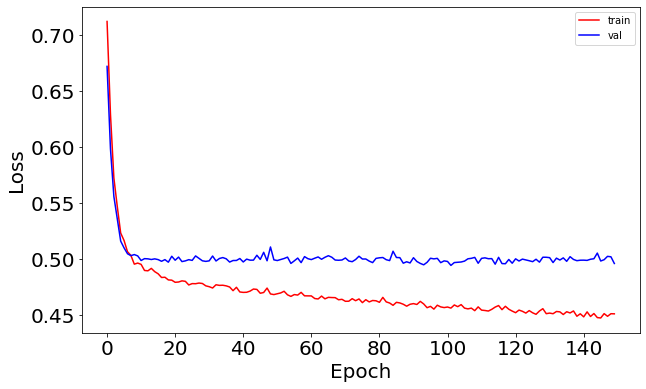

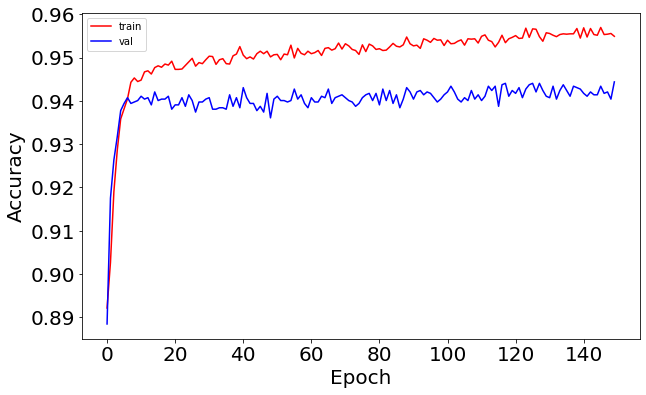

In [123]:
# Capturing learning history per epoch
hist  = pd.DataFrame(nn_3.history)
hist['epoch'] = nn_3.epoch

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['loss']), 'r', label='train')
ax.plot(np.sqrt(hist['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['accuracy']), 'r', label='train')
ax.plot(np.sqrt(hist['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

No Skill: ROC AUC=0.500
NN Model: ROC AUC=0.931


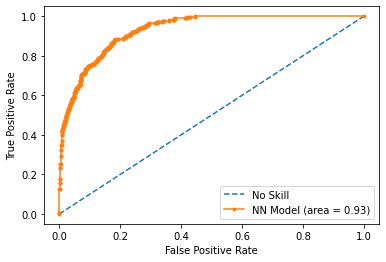

In [125]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = modelnn3.predict_proba(X_test)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NN Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='NN Model (area = %0.2f)' % lr_auc)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

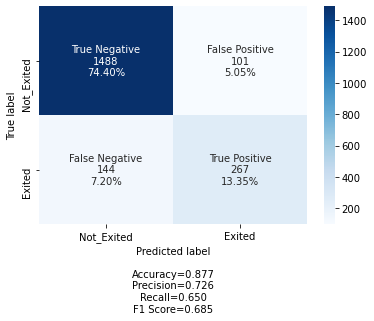

In [124]:
y_pred1 = modelnn3.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**

It appears that we have reached the limit on performance gain.

The Accuracy remains good, while the TP numbers are very promising.

The imbalance of the target variable has been dealt with and we are seeing models provide similar results.

We will check whether Up/Down sampling techniques can be applied to generate a better model.

### Undersampling Data using SMOTE

In [104]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [105]:
#Fitting model with GridSearch results.
modelnnu = Sequential()
modelnnu.add(Dense(units=10, input_dim = 13,activation='relu'))   # input of 13 columns as shown above
    # hidden layer
modelnnu.add(Dense(units=10,activation='relu'))
    #Adding Dropout to prevent overfitting 
modelnnu.add(Dropout(0.3))
modelnnu.add(Dense(24,activation='relu'))
modelnnu.add(Dense(24,activation='relu'))
modelnnu.add(Dense(1,activation='sigmoid'))                        # binary classification Exited or not
modelnnu.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])   

In [106]:
nn_u=modelnnu.fit(X_train_un,y_train_un,batch_size=150,epochs=100,validation_split=0.2)

Epoch 1/100
18/18 [==============================] - 1s 14ms/step - loss: 0.6799 - accuracy: 0.5849 - val_loss: 0.8488 - val_accuracy: 0.0307
Epoch 2/100
18/18 [==============================] - 0s 1ms/step - loss: 0.6593 - accuracy: 0.6257 - val_loss: 0.8666 - val_accuracy: 0.0369
Epoch 3/100
18/18 [==============================] - 0s 1ms/step - loss: 0.6546 - accuracy: 0.6265 - val_loss: 0.9436 - val_accuracy: 0.0369
Epoch 4/100
18/18 [==============================] - 0s 1ms/step - loss: 0.6456 - accuracy: 0.6296 - val_loss: 0.9708 - val_accuracy: 0.0522
Epoch 5/100
18/18 [==============================] - 0s 1ms/step - loss: 0.6193 - accuracy: 0.6600 - val_loss: 0.9603 - val_accuracy: 0.1229
Epoch 6/100
18/18 [==============================] - 0s 1ms/step - loss: 0.6060 - accuracy: 0.6729 - val_loss: 0.9102 - val_accuracy: 0.2442
Epoch 7/100
18/18 [==============================] - 0s 1ms/step - loss: 0.5913 - accuracy: 0.6865 - val_loss: 0.8695 - val_accuracy: 0.3226
Epoch 8/100


Epoch 59/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3147 - accuracy: 0.8505 - val_loss: 0.3793 - val_accuracy: 0.8126
Epoch 60/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3185 - accuracy: 0.8487 - val_loss: 0.4086 - val_accuracy: 0.7865
Epoch 61/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3179 - accuracy: 0.8423 - val_loss: 0.3932 - val_accuracy: 0.8095
Epoch 62/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3131 - accuracy: 0.8483 - val_loss: 0.3900 - val_accuracy: 0.8095
Epoch 63/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3182 - accuracy: 0.8489 - val_loss: 0.3977 - val_accuracy: 0.8003
Epoch 64/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3186 - accuracy: 0.8385 - val_loss: 0.3874 - val_accuracy: 0.8034
Epoch 65/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3115 - accuracy: 0.8530 - val_loss: 0.4314 - val_accuracy: 0.7665
Epoch 

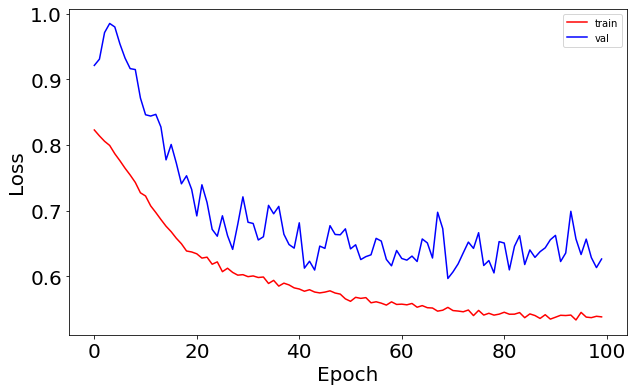

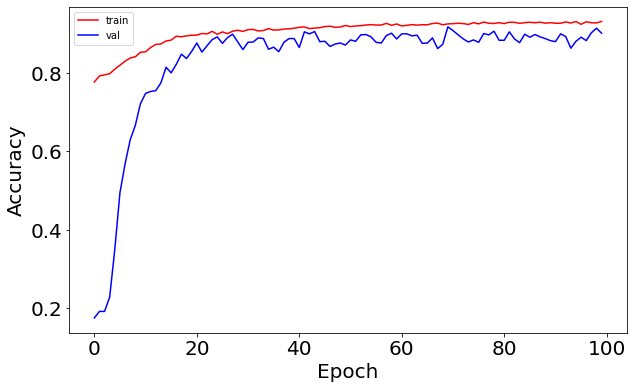

In [107]:
# Capturing learning history per epoch
hist  = pd.DataFrame(nn_u.history)
hist['epoch'] = nn_u.epoch

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['loss']), 'r', label='train')
ax.plot(np.sqrt(hist['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['accuracy']), 'r', label='train')
ax.plot(np.sqrt(hist['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

No Skill: ROC AUC=0.500
NN Model: ROC AUC=0.931


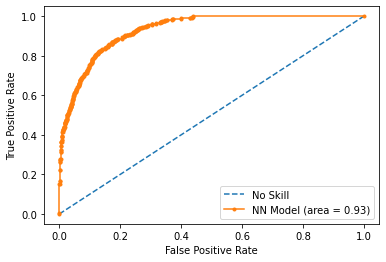

In [109]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = modelnnu.predict_proba(X_test)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NN Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='NN Model (area = %0.2f)' % lr_auc)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

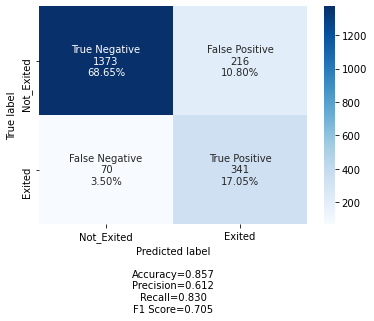

In [133]:
y_pred1 = modelnnu.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**

The Downsampled model has improved Recall dramatically. It has come at the cost of decreasing the overall accuracy of the model.

We have improved the models ability to accurately predict both Negative & Positive values.

This is a good fitting model that performs well in our target metrics.

### Oversampling train data using SMOTE

In [110]:
from imblearn.over_sampling import SMOTE

print("Before UpSampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label 'No': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over==0)))


print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Yes': 1626
Before UpSampling, counts of label 'No': 6374 

After UpSampling, counts of label 'Yes': 6374
After UpSampling, counts of label 'No': 6374 

After UpSampling, the shape of train_X: (12748, 13)
After UpSampling, the shape of train_y: (12748,) 



In [111]:
#Fitting model with GridSearch results.
modelnno = Sequential()
modelnno.add(Dense(units=10, input_dim = 13,activation='relu'))   # input of 13 columns as shown above
    # hidden layer
modelnno.add(Dense(units=10,activation='relu'))
    #Adding Dropout to prevent overfitting 
modelnno.add(Dropout(0.3))
modelnno.add(Dense(24,activation='relu'))
modelnno.add(Dense(24,activation='relu'))
modelnno.add(Dense(1,activation='sigmoid'))                        # binary classification Exited or not
modelnno.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])   

In [112]:
nn_o=modelnno.fit(X_train_over,y_train_over,batch_size=150,epochs=100,validation_split=0.2)

Epoch 1/100
68/68 [==============================] - 1s 4ms/step - loss: 0.6555 - accuracy: 0.6315 - val_loss: 0.8372 - val_accuracy: 0.3086
Epoch 2/100
68/68 [==============================] - 0s 666us/step - loss: 0.5670 - accuracy: 0.7102 - val_loss: 0.6531 - val_accuracy: 0.6918
Epoch 3/100
68/68 [==============================] - 0s 685us/step - loss: 0.4878 - accuracy: 0.7642 - val_loss: 0.5020 - val_accuracy: 0.8004
Epoch 4/100
68/68 [==============================] - 0s 670us/step - loss: 0.4299 - accuracy: 0.7988 - val_loss: 0.4719 - val_accuracy: 0.8149
Epoch 5/100
68/68 [==============================] - 0s 670us/step - loss: 0.3923 - accuracy: 0.8148 - val_loss: 0.4381 - val_accuracy: 0.8376
Epoch 6/100
68/68 [==============================] - 0s 670us/step - loss: 0.3635 - accuracy: 0.8338 - val_loss: 0.4561 - val_accuracy: 0.8196
Epoch 7/100
68/68 [==============================] - 0s 655us/step - loss: 0.3536 - accuracy: 0.8383 - val_loss: 0.3574 - val_accuracy: 0.8671
E

Epoch 58/100
68/68 [==============================] - 0s 670us/step - loss: 0.2790 - accuracy: 0.8654 - val_loss: 0.3168 - val_accuracy: 0.8804
Epoch 59/100
68/68 [==============================] - 0s 685us/step - loss: 0.2845 - accuracy: 0.8635 - val_loss: 0.3240 - val_accuracy: 0.8800
Epoch 60/100
68/68 [==============================] - 0s 670us/step - loss: 0.2714 - accuracy: 0.8746 - val_loss: 0.2861 - val_accuracy: 0.8980
Epoch 61/100
68/68 [==============================] - 0s 655us/step - loss: 0.2808 - accuracy: 0.8647 - val_loss: 0.2925 - val_accuracy: 0.8992
Epoch 62/100
68/68 [==============================] - 0s 655us/step - loss: 0.2783 - accuracy: 0.8707 - val_loss: 0.2699 - val_accuracy: 0.9137
Epoch 63/100
68/68 [==============================] - 0s 655us/step - loss: 0.2735 - accuracy: 0.8705 - val_loss: 0.3051 - val_accuracy: 0.8973
Epoch 64/100
68/68 [==============================] - 0s 670us/step - loss: 0.2749 - accuracy: 0.8719 - val_loss: 0.2822 - val_accuracy:

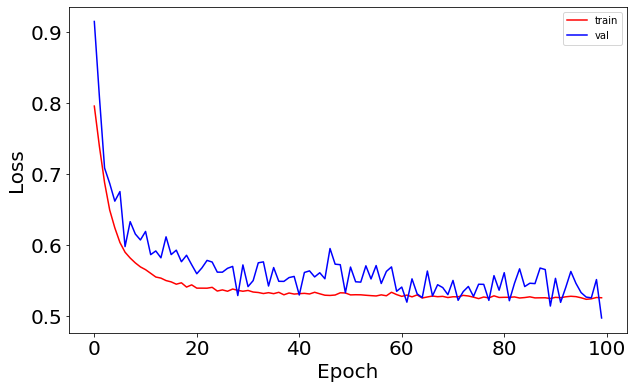

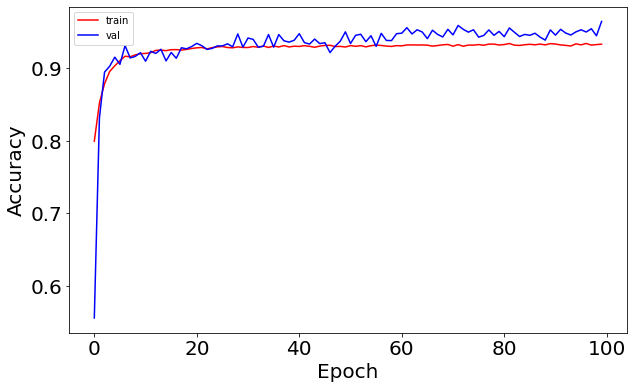

In [113]:
# Capturing learning history per epoch
hist  = pd.DataFrame(nn_o.history)
hist['epoch'] = nn_o.epoch

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['loss']), 'r', label='train')
ax.plot(np.sqrt(hist['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(hist['accuracy']), 'r', label='train')
ax.plot(np.sqrt(hist['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

No Skill: ROC AUC=0.500
NN Model: ROC AUC=0.930


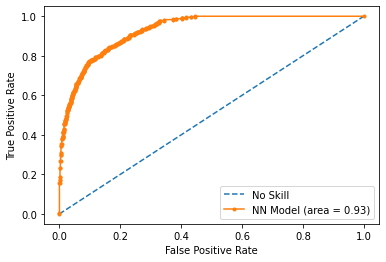

In [115]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = modelnno.predict_proba(X_test)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NN Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='NN Model (area = %0.2f)' % lr_auc)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

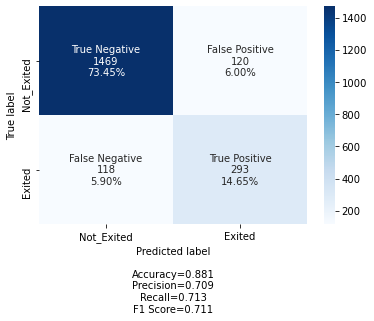

In [135]:
y_pred1 = modelnno.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.7:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

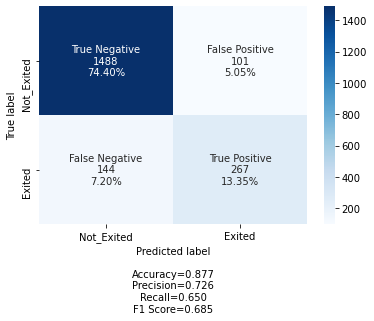

In [150]:
y_pred1 = modelnn3.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**

The UpSampled technique has resulted in another good performing model.

The accuracy and recall scores are both higher than what we have seen before.

Unfortunately, the model is generating far more False Positives, which suggests it is too aggressive in predicting an Exited customer.

We adjusted accordingly by changing the Threshold based on the AUC-ROC graph.

## Conclusion

### Top Performing Model

The **GridSearch tuned ANN with Weight adjustments** performs best in our target metrics.

- Accuracy: 88
- Recall: 65

I would advise the use of this model, the reason being that although recall can be improved, the number of False Postives compared to True Positives indicates that the model is well balanced. It is predicting Exited customers at a high enough rate to deliver value to the bank, while minimizing the exposure to a too aggressive model.

### Business Recommendation

The dataset is not optimally designed and setup to predict the churn of customers. Data focused on the customers behavior, specifically the change in behaviour is a much better predictor for future change, specifically exiting the bank as a cusomter. The data used to train these models does not convey enough information about a customer, to really predict what they might do.

This dataset would be better used for identifying customers who might buy new/more expensive products. CreditScore, HasCrCard, IsActiveMember, NumberOfProducts - are all features that should be used in profiling a customer for products. Not whether they will leave the bank in the near future.

Given the problem statement: "Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months."

The model advised will do what it can in predicting the whether the customer will leave. However, there is no data related to time, change in behaviour or any other data point that could be used to safely predict a change in action over a set time frame. 

This problem statement is ill fitting to the dataset provided. 

My recommendation if this were a real bank, is to change the problem statement for this data, or change the dataset we are working with.